# Analyse von Audio Dateien zur Erkennung des Geschlechts
## 1. Einlesen einer csv Datei
Die Datei enthält alle zuvor extrahierten Audio Features und das Ziellabel Geschlecht.

In [1]:
!pip install boto3
!conda install dask -y
!pip install fsspec
#!pip install pandas==0.22 # für macOS
#!pip install s3fs # wenn S3 Bucket verwendet wird
!pip install sklearn
!pip install keras
!pip install tensorflow

Solving environment: done

# All requested packages already installed.



In [2]:
import os
import boto3
import pandas as pd
import sys
from io import StringIO
import dask.dataframe as dd
import numpy as np



In [12]:
df = pd.read_csv ('/home/sebastian/Schreibtisch/Gender_Age_Detection/Datensaetze/FeaturesExtracted_gesamt_language_final.csv', delimiter =';')

In [13]:
df

Unnamed: 0       age  gender language  \
0            2295  thirties  female       es   
1           21497   sixties    male       es   
2           13989  thirties    male       es   
3           19314   sixties    male       fr   
4           14262   fifties    male       es   
...           ...       ...     ...      ...   
68257       13558  fourties  female       de   
68258       18799  twenties    male       es   
68259       22568  thirties    male       de   
68260       16402  thirties    male       fr   
68261       21524  thirties    male       fr   

                                                chroma_1  \
0      [2.19016479e-02 1.98419178e-02 1.42401079e-02 ...   
1      [0.00123055 0.00173425 0.00128084 0.00159457 0...   
2      [0.00039702 0.00057141 0.00061397 0.00078023 0...   
3      [3.29369082e-04 2.56816195e-04 5.18794072e-04 ...   
4      [0.02719358 0.00433154 0.00892589 0.00344029 0...   
...                                                  ...   
68257  [0.00343028 0.00679621 0.00967812 0.00762795 0...   
68258  [2.40466189e-02 5.05102880e-02 1.02736688e-02 ...   
68259  [0.01443982 0.00812239 0.00525087 0.0077737  0...   
68260  [0.00522564 0.02045272 0.04677218 0.01359765 0...   
68261  [1.60902354e-03 1.55873154e-03 7.18903630e-04 ...   

                                                chroma_2  \
0      [2.36301791e-03 1.60699223e-04 1.79014003e-05 ...   
1      [1.50602186e-03 1.02319085e-03 1.11540379e-03 ...   
2      [2.74740100e-04 2.87674231e-04 4.09835138e-05 ...   
3      [6.42853330e-05 1.48090630e-04 1.14659622e-04 ...   
4      [6.81004474e-04 6.22475191e-04 7.48369935e-04 ...   
...                                                  ...   
68257  [3.16236526e-03 1.90740164e-03 6.38218969e-04 ...   
68258  [1.28503213e-03 5.94318099e-04 9.26854382e-03 ...   
68259  [0.00772032 0.00591086 0.00381285 0.009494   0...   
68260  [4.13899979e-03 2.73543269e-03 6.27909953e-03 ...   
68261  [1.06054262e-03 2.28851029e-04 2.55745251e-04 ...   

                                                chroma_3  \
0      [5.99647834e-02 3.68444838e-02 3.53325342e-02 ...   
1      [0.14043849 0.17600987 0.15867324 0.08335744 0...   
2      [0.11649644 0.00463287 0.00566268 0.00316505 0...   
3      [0.14190883 0.06185474 0.2292469  0.17721694 0...   
4      [0.09314385 0.12375989 0.14058293 0.13572437 0...   
...                                                  ...   
68257  [0.05478125 0.14112093 0.22616205 0.10232634 0...   
68258  [0.05300792 0.04199321 0.00499007 0.00665875 0...   
68259  [0.00683805 0.01875355 0.01503395 0.01313472 0...   
68260  [8.14093519e-02 3.61815064e-02 3.47308329e-02 ...   
68261  [2.39371646e-02 3.76260395e-02 7.71690399e-02 ...   

                                                chroma_4  \
0      [2.21916863e-02 5.72602089e-02 4.64333974e-02 ...   
1      [0.00633533 0.00384413 0.00458627 0.00504513 0...   
2      [6.61108597e-04 2.12461767e-04 8.37083200e-05 ...   
3      [3.37721708e-04 1.07072036e-03 3.48459481e-03 ...   
4      [0.01124633 0.02183456 0.0088202  0.04462231 0...   
...                                                  ...   
68257  [4.75380040e-03 3.81708538e-03 1.92017636e-03 ...   
68258  [3.10146292e-03 1.31798178e-03 6.45931813e-05 ...   
68259  [0.00530796 0.00436534 0.00638615 0.01121916 0...   
68260  [2.28617590e-03 5.35151041e-03 6.74630053e-03 ...   
68261  [2.10392658e-03 2.93338878e-03 7.99703140e-03 ...   

                                                chroma_5  \
0      [3.18668933e-02 7.64438013e-02 7.38779808e-02 ...   
1      [0.01288588 0.01003239 0.00703126 0.00464644 0...   
2      [5.15444731e-03 2.42194143e-03 4.76634330e-04 ...   
3      [1.60501392e-03 1.25166923e-03 8.77682815e-04 ...   
4      [0.0230064  0.02295414 0.01491988 0.00615127 0...   
...                                                  ...   
68257  [1.58586294e-02 6.98927003e-03 8.19945159e-03 ...   
68258  [0.00731731 0.00416628 0.00094575 0.0012292  0...   
68259 

Für die weitere Verarbeitung werden alle Spaltennamen in eine Liste übernommen. Es werden nur die Spaltennamen der Audio Features beibehalten

In [15]:
list_cn = df.columns.values
list_cn = np.delete(list_cn,0)
list_cn = np.delete(list_cn,0)
list_cn = np.delete(list_cn,0)
list_cn = np.delete(list_cn,0)
list_cn

array(['chroma_1', 'chroma_2', 'chroma_3', 'chroma_4', 'chroma_5',
       'chroma_6', 'chroma_7', 'chroma_8', 'chroma_9', 'chroma_10',
       'chroma_11', 'chroma_12', 'chroma_std', 'energy', 'energy_entropy',
       'mfcc_1', 'mfcc_2', 'mfcc_3', 'mfcc_4', 'mfcc_5', 'mfcc_6',
       'mfcc_7', 'mfcc_8', 'mfcc_9', 'mfcc_10', 'mfcc_11', 'mfcc_12',
       'mfcc_13', 'spectral_centroid', 'spectral_entropy',
       'spectral_flux', 'spectral_rolloff', 'spectral_spread', 'zcr'],
      dtype=object)

In der folgenden Schleife wird der DataFrame bearbeitet:
Es werden als String erkannte character ([]) entfernt.
Anschließend werden alle String - Werte eines Elements in ein NumPy Array gewandelt und in eine Liste zwischengespeichert.
Die Liste wird zurück in das Element das DataFrame geschrieben und der Median gebildet.
Dies ist notwendig um das richtige Format zur Eingabe in das Neuronale Netz zu erhalten.

In [16]:
nrows = len(df)

for i in range (0,nrows):
    for j in list_cn:
        list_c = df[j].iloc[i]
        list_c = list_c.replace('[','')
        list_c = list_c.replace(']','')
        list1 = np.fromstring (list_c, sep=' ',dtype=float)
        df[j].iat[i] = list1
        df[j].iat[i] = df[j].iloc[i].mean()
    if (i % 10000 == 0):
        print ("Reihe "+ str(i) + " fertig")
print ("Konvertierung abgeschlossen.")

Reihe 0 fertig
Reihe 10000 fertig
Reihe 20000 fertig
Reihe 30000 fertig
Reihe 40000 fertig
Reihe 50000 fertig
Reihe 60000 fertig
Konvertierung abgeschlossen.


Anschließend werden die nicht benötigten Spalten aus dem DataFrame entfernt

In [17]:
df.head()

Unnamed: 0       age  gender language    chroma_1    chroma_2   chroma_3  \
0        2295  thirties  female       es   0.0118005  0.00479505  0.0129216   
1       21497   sixties    male       es  0.00765219  0.00171154  0.0701106   
2       13989  thirties    male       es  0.00928783   0.0027387  0.0143024   
3       19314   sixties    male       fr   0.0117465  0.00226177  0.0778406   
4       14262   fifties    male       es   0.0216152  0.00180375  0.0807026   

     chroma_4   chroma_5    chroma_6  ...     mfcc_10    mfcc_11      mfcc_12  \
0   0.0126578  0.0160492   0.0151662  ...   -0.146467 -0.0400597   0.00576619   
1   0.0070182  0.0379804   0.0142086  ...    0.088225  0.0503712     0.133719   
2  0.00417938  0.0157957  0.00698435  ...    0.117705  0.0223089 -3.56302e-05   
3  0.00563338  0.0157707  0.00413591  ...     0.14873 -0.0360583     0.122448   
4   0.0147121  0.0154404  0.00694891  ...  0.00705812 -0.0185564  -0.00700929   

      mfcc_13 spectral_centroid spectral_entropy spectral_flux  \
0  0.00491991          0.139776         0.562644    0.00597526   
1 -0.00760059          0.159489         0.412544    0.00585764   
2  -0.0101439          0.103226        0.0940455    0.00759018   
3  -0.0252428          0.121803         0.291743    0.00944365   
4   0.0388217          0.135693         0.349937    0.00541778   

  spectral_rolloff spectral_spread        zcr  
0        0.0910782        0.158083  0.0783699  
1        0.0570055        0.199808  0.0565666  
2        0.0227067        0.172089   0.016155  
3         0.047759        0.169937   0.036206  
4        0.0549664        0.178973  0.0558028  

[5 rows x 38 columns]

# Shuffeln!

In [18]:
df2 = df.sample(frac=1)
df2.head(20)

Unnamed: 0       age  gender language    chroma_1    chroma_2  \
34390       10880   fifties    male       de  0.00887867  0.00766334   
45433       15353  twenties    male       fr   0.0107396  0.00156441   
29132        5357  thirties  female       de   0.0114942  0.00934374   
58487       16102  thirties    male       fr    0.028088  0.00272744   
36850       17890  twenties    male       de   0.0187511  0.00561218   
41178         542  thirties  female       fr    0.050127  0.00480676   
38379        1536  twenties  female       es   0.0521722  0.00453762   
9495         3638  thirties  female       fr   0.0296413  0.00636109   
47521        7763  twenties  female       fr  0.00918313  0.00719242   
41275        2934   sixties  female       fr   0.0242286   0.0124377   
18027        1127   sixties  female       fr   0.0231786  0.00522729   
49243       20898  fourties  female       de   0.0299861   0.0048805   
37897        1956  twenties  female       es   0.0312093  0.00645467   
54720       12732  twenties    male       es  0.00778705  0.00454376   
21858       19889  fourties    male       es   0.0229389  0.00469592   
20953       21019  fourties  female       de  0.00738732  0.00360077   
32635         838   fifties  female       fr   0.0260284  0.00445643   
20873       22679  twenties    male       es   0.0214694  0.00882909   
65929        8368  thirties  female       fr   0.0134715  0.00653841   
25479         854  twenties  female       es   0.0336341  0.00541251   

        chroma_3    chroma_4   chroma_5    chroma_6  ...    mfcc_10  \
34390  0.0127459  0.00731183  0.0204298  0.00969819  ...  0.0438884   
45433  0.0757519  0.00625634  0.0291801  0.00468224  ...  0.0458368   
29132  0.0387236   0.0257214   0.025842   0.0230062  ...   -0.11413   
58487   0.035963   0.0130571  0.0301147  0.00537687  ...    0.12947   
36850  0.0546408   0.0150959  0.0196588   0.0110327  ...  -0.108412   
41178  0.0272337   0.0260337  0.0225484   0.0161154  ...  -0.160889   
38379  0.0667685   0.0214479  0.0177912   0.0256101  ...   -0.36519   
9495   0.0341568   0.0189918  0.0163076    0.007549  ... -0.0755897   
47521  0.0133191   0.0140766  0.0155235   0.0112577  ...   -0.12632   
41275  0.0293549   0.0153258  0.0244043  0.00588396  ...  -0.232135   
18027  0.0283237   0.0124467   0.018258  0.00803017  ... -0.0988729   
49243  0.0323027  0.00917098  0.0104184  0.00530912  ...  -0.204168   
37897  0.0321251   0.0236527  0.0196767  0.00846928  ...  -0.203264   
54720  0.0587173  0.00790899  0.0237292  0.00839963  ...  0.0378534   
21858  0.0565905   0.0172974  0.0232584  0.00864091  ...  -0.143593   
20953  0.0285473   0.0110407  0.0137345  0.00927645  ... -0.0737025   
32635   0.028859   0.0250551  0.0202968   0.0136565  ...  -0.164289   
20873  0.0143442  0.00980677  0.0110236   0.0133716  ... -0.0691131   
65929  0.0355014   0.0228941    0.02611    0.018077  ...   -0.24747   
25479  0.0278956   0.0120289  0.0104624  0.00668862  ...  -0.169885   

         mfcc_11    mfcc_12    mfcc_13 spectral_centroid spectral_entropy  \
34390  0.0639953   0.164686   0.144677          0.142245         0.506593   
45433 -0.0458175   0.132905 -0.0946205          0.120135         0.299833   
29132   -0.23233 -0.0240317  0.0556784          0.118517         0.360072   
58487 -0.0978414  -0.143894  -0.153526          0.113205          0.28128   
36850  -0.282131  -0.147841  -0.144485          0.133737         0.562057   
41178  -0.266047  -0.186715  -0.162143          0.119814         0.435007   
38379  -0.139267  -0.285626  -0.195295          0.136401         0.362178   
9495   -0.145166  -0.149149  -0.162248         0.0924402         0.318151   
47521  0.0555556  0.0623977 -0.0389401          0.110943         0.555284   
41275 -0.0515558   -0.24374  -0.206603           0.14587         0.705147   
18027 -0.0192206  -0.123718  -0.100261          0.154294         0.614431   
49243  0.0321216 -0.0810978 -0.0914791          0.119208         0.455563   
3

In [19]:
#!Änderung: weder gender noch age entfernen
df_gesamt = df2.copy()
del df_gesamt['Unnamed: 0']
del df_gesamt['age']
del df_gesamt['gender']
#del df_gesamt['file_wave']

In [20]:
df_gesamt.head()

language    chroma_1    chroma_2   chroma_3    chroma_4   chroma_5  \
34390       de  0.00887867  0.00766334  0.0127459  0.00731183  0.0204298   
45433       fr   0.0107396  0.00156441  0.0757519  0.00625634  0.0291801   
29132       de   0.0114942  0.00934374  0.0387236   0.0257214   0.025842   
58487       fr    0.028088  0.00272744   0.035963   0.0130571  0.0301147   
36850       de   0.0187511  0.00561218  0.0546408   0.0150959  0.0196588   

         chroma_6    chroma_7     chroma_8    chroma_9  ...    mfcc_10  \
34390  0.00969819    0.023986   0.00213756  0.00740461  ...  0.0438884   
45433  0.00468224   0.0695495   0.00179695  0.00402128  ...  0.0458368   
29132   0.0230062   0.0340243   0.00308694  0.00597472  ...   -0.11413   
58487  0.00537687   0.0649743   0.00128248  0.00405353  ...    0.12947   
36850   0.0110327  0.00986983  0.000801252  0.00362554  ...  -0.108412   

         mfcc_11    mfcc_12    mfcc_13 spectral_centroid spectral_entropy  \
34390  0.0639953   0.164686   0.144677          0.142245         0.506593   
45433 -0.0458175   0.132905 -0.0946205          0.120135         0.299833   
29132   -0.23233 -0.0240317  0.0556784          0.118517         0.360072   
58487 -0.0978414  -0.143894  -0.153526          0.113205          0.28128   
36850  -0.282131  -0.147841  -0.144485          0.133737         0.562057   

      spectral_flux spectral_rolloff spectral_spread        zcr  
34390    0.00649401          0.10357        0.160205  0.0873052  
45433      0.010233        0.0600051         0.17093  0.0465244  
29132    0.00846906        0.0619424         0.16995  0.0491002  
58487    0.00922568        0.0503212        0.169105  0.0401339  
36850     0.0071714        0.0993713        0.151751  0.0783959  

[5 rows x 35 columns]

In [21]:
df_data_x = df_gesamt
del df_gesamt['language']
df_data_x.head()

chroma_1    chroma_2   chroma_3    chroma_4   chroma_5    chroma_6  \
34390  0.00887867  0.00766334  0.0127459  0.00731183  0.0204298  0.00969819   
45433   0.0107396  0.00156441  0.0757519  0.00625634  0.0291801  0.00468224   
29132   0.0114942  0.00934374  0.0387236   0.0257214   0.025842   0.0230062   
58487    0.028088  0.00272744   0.035963   0.0130571  0.0301147  0.00537687   
36850   0.0187511  0.00561218  0.0546408   0.0150959  0.0196588   0.0110327   

         chroma_7     chroma_8    chroma_9   chroma_10  ...    mfcc_10  \
34390    0.023986   0.00213756  0.00740461   0.0141256  ...  0.0438884   
45433   0.0695495   0.00179695  0.00402128   0.0282549  ...  0.0458368   
29132   0.0340243   0.00308694  0.00597472   0.0163686  ...   -0.11413   
58487   0.0649743   0.00128248  0.00405353   0.0249799  ...    0.12947   
36850  0.00986983  0.000801252  0.00362554  0.00687997  ...  -0.108412   

         mfcc_11    mfcc_12    mfcc_13 spectral_centroid spectral_entropy  \
34390  0.0639953   0.164686   0.144677          0.142245         0.506593   
45433 -0.0458175   0.132905 -0.0946205          0.120135         0.299833   
29132   -0.23233 -0.0240317  0.0556784          0.118517         0.360072   
58487 -0.0978414  -0.143894  -0.153526          0.113205          0.28128   
36850  -0.282131  -0.147841  -0.144485          0.133737         0.562057   

      spectral_flux spectral_rolloff spectral_spread        zcr  
34390    0.00649401          0.10357        0.160205  0.0873052  
45433      0.010233        0.0600051         0.17093  0.0465244  
29132    0.00846906        0.0619424         0.16995  0.0491002  
58487    0.00922568        0.0503212        0.169105  0.0401339  
36850     0.0071714        0.0993713        0.151751  0.0783959  

[5 rows x 34 columns]

Die Zielvariable (Gender) wird in eine eigene Liste (?) geschrieben. Da das neuronale Netz nur mit Integer bzw. Float als Zieldatentyp arbeiten kann, wir mit Hilfe der Methode LabelEncoder das Geschlacht als 0 und 1 kodiert:

In [22]:
# Erstellen eines df mit Zielvariable gender
df_lang_y = df2.language.copy()
df_lang_y.head(30)

34390    de
45433    fr
29132    de
58487    fr
36850    de
41178    fr
38379    es
9495     fr
47521    fr
41275    fr
18027    fr
49243    de
37897    es
54720    es
21858    es
20953    de
32635    fr
20873    es
65929    fr
25479    es
4418     es
21589    fr
5643     fr
27109    de
5869     fr
12595    fr
20670    fr
67169    es
65618    es
15997    de
Name: language, dtype: object

In [23]:
#!Änderung: Name des dfs statt df_gender_y in age
from sklearn.preprocessing import LabelEncoder
# integer encode
label_encoder = LabelEncoder()
df_lang_y = label_encoder.fit_transform(df_lang_y)
print(df_lang_y[0])

0


In [26]:
print(df_lang_y[6])

1


# codierung Sprache: de = 0, fr=2, es = 1

Für das neuronale Netz verwenden wir Keras.
Folgende Funktionen werden aus Keras verwendet:
- Sequential
- Dense
- Activation

In [27]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Activation

Using TensorFlow backend.


Im folgenden Schritt wird das neuronale Netz konfiguriert:
Genaue Beschreibung, mit welchen Konfiguration welches Ergebnis erreicht wurde

In [31]:
# model konfigurieren
# softmax, sigmoid
#model.add (Dense (30, input_dim = 34, activation = 'relu'))
#model.add (Dense (10, activation = 'relu'))
#60%val_acc bei 2hidden mit 100 Knoten jeweils mit relu / dense last Dense =7/actication softmax / loss = 'categorical_crossentropy', optimizer = 'adam'
#mit den einstellungen schafft man 63,66%

#0.7144 mit softmax

model = Sequential()
#hier muss beim Versuch mit Gender als Trainingsmerkmal eine 35 statt eine 34 stehen!
model.add (Dense (34, input_dim = 34, activation = 'relu'))
model.add (Dense (100, activation = 'relu'))
model.add (Dense (100, activation = 'relu'))
#model.add (Dense (100, activation = 'relu'))
model.add (Dense (3, activation = 'softmax'))
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 34)                1190      
_________________________________________________________________
dense_6 (Dense)              (None, 100)               3500      
_________________________________________________________________
dense_7 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_8 (Dense)              (None, 3)                 303       
Total params: 15,093
Trainable params: 15,093
Non-trainable params: 0
_________________________________________________________________


Im nächsten Schritt wird das Modell kompiliert.
Als Loss Funktion wird die Methode "Mean Squared Error" genutzt. "Adam" wird als Optimierungsfunktion genutzt.

In [36]:
model.compile (loss = 'sparse_categorical_crossentropy', optimizer = 'adam', metrics = ['sparse_categorical_crossentropy','acc'])

Dann wird das Modell trainiert. Die Validierung erfolgt direkt mit dem Training mit 33% der Gesamt-Daten

In [37]:
import time

# Startzeit
t = time.localtime()
current_time = time.strftime("%d.%m.%Y %H:%M:%S", t)
print(current_time, ' Training gestartet ...')

# Model trainieren
history = model.fit (df_gesamt, df_lang_y, epochs = 100, validation_split = 0.3, batch_size = 10)

# Endzeit
t2 = time.localtime()
current_time2 = time.strftime("%d.%m.%Y %H:%M:%S", t2)
print(current_time2, ' Training beendet ...')

23.05.2020 11:41:31  Training gestartet ...
Train on 47783 samples, validate on 20479 samples
Epoch 1/100
47783/47783 [==============================] - 9s 185us/step - loss: 1.0475 - sparse_categorical_crossentropy: 1.0475 - acc: 0.4388 - val_loss: 0.9961 - val_sparse_categorical_crossentropy: 0.9961 - val_acc: 0.4943
Epoch 2/100
47783/47783 [==============================] - 10s 204us/step - loss: 0.9781 - sparse_categorical_crossentropy: 0.9781 - acc: 0.5120 - val_loss: 0.9646 - val_sparse_categorical_crossentropy: 0.9646 - val_acc: 0.5172
Epoch 3/100
47783/47783 [==============================] - 9s 178us/step - loss: 0.9317 - sparse_categorical_crossentropy: 0.9317 - acc: 0.5431 - val_loss: 0.9041 - val_sparse_categorical_crossentropy: 0.9041 - val_acc: 0.5548
Epoch 4/100
47783/47783 [==============================] - 9s 181us/step - loss: 0.8989 - sparse_categorical_crossentropy: 0.8989 - acc: 0.5636 - val_loss: 0.8820 - val_sparse_categorical_crossentropy: 0.8820 - val_acc: 0.57

47783/47783 [==============================] - 8s 176us/step - loss: 0.6147 - sparse_categorical_crossentropy: 0.6147 - acc: 0.7304 - val_loss: 0.6973 - val_sparse_categorical_crossentropy: 0.6973 - val_acc: 0.6990
Epoch 37/100
47783/47783 [==============================] - 8s 177us/step - loss: 0.6092 - sparse_categorical_crossentropy: 0.6092 - acc: 0.7339 - val_loss: 0.6990 - val_sparse_categorical_crossentropy: 0.6990 - val_acc: 0.7020
Epoch 38/100
47783/47783 [==============================] - 8s 177us/step - loss: 0.6078 - sparse_categorical_crossentropy: 0.6078 - acc: 0.7333 - val_loss: 0.6855 - val_sparse_categorical_crossentropy: 0.6855 - val_acc: 0.7025
Epoch 39/100
47783/47783 [==============================] - 8s 176us/step - loss: 0.6013 - sparse_categorical_crossentropy: 0.6013 - acc: 0.7371 - val_loss: 0.6805 - val_sparse_categorical_crossentropy: 0.6805 - val_acc: 0.7115
Epoch 40/100
47783/47783 [==============================] - 9s 179us/step - loss: 0.6002 - sparse_cat

Epoch 72/100
47783/47783 [==============================] - 8s 178us/step - loss: 0.5312 - sparse_categorical_crossentropy: 0.5312 - acc: 0.7712 - val_loss: 0.7164 - val_sparse_categorical_crossentropy: 0.7164 - val_acc: 0.7077
Epoch 73/100
47783/47783 [==============================] - 8s 176us/step - loss: 0.5282 - sparse_categorical_crossentropy: 0.5282 - acc: 0.7704 - val_loss: 0.6923 - val_sparse_categorical_crossentropy: 0.6923 - val_acc: 0.7153
Epoch 74/100
47783/47783 [==============================] - 9s 180us/step - loss: 0.5292 - sparse_categorical_crossentropy: 0.5292 - acc: 0.7718 - val_loss: 0.6744 - val_sparse_categorical_crossentropy: 0.6744 - val_acc: 0.7209
Epoch 75/100
47783/47783 [==============================] - 9s 183us/step - loss: 0.5257 - sparse_categorical_crossentropy: 0.5257 - acc: 0.7727 - val_loss: 0.7077 - val_sparse_categorical_crossentropy: 0.7077 - val_acc: 0.7104
Epoch 76/100
47783/47783 [==============================] - 9s 181us/step - loss: 0.5245

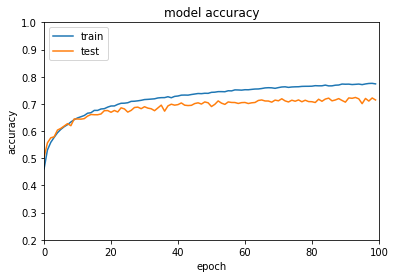

In [34]:
import matplotlib.pyplot as plt

# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.axis([0, 100, 0.2, 1])
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
#print(history.history.keys())

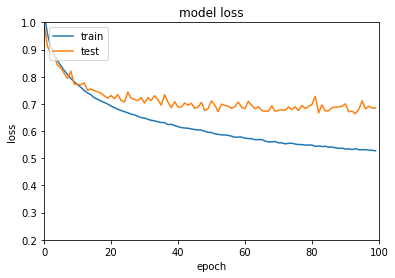

In [35]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.axis([0, 100, 0.2, 1])
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Optimales Modell finden mittels CV¶

In [38]:
from sklearn.model_selection import GridSearchCV

In [39]:
#Optimierungsfunktion für Modell
def c_modelOpti(optimizer, activation):
    model = Sequential()
    model.add(Dense(34, input_dim = 34, activation = activation))
    model.add (Dense (100, activation = activation))
    model.add (Dense (100, activation = activation))
    model.add (Dense (3, activation = 'softmax'))
    model.compile(loss = "sparse_categorical_crossentropy", optimizer = optimizer, metrics = ["sparse_categorical_crossentropy","acc"])
    return model

In [40]:
model.compile (loss = 'sparse_categorical_crossentropy', optimizer = 'adam', metrics = ['categorical_crossentropy','acc'])

In [41]:
from keras.wrappers.scikit_learn import KerasClassifier

In [42]:
model = KerasClassifier(build_fn=c_modelOpti)

epoches = [50, 100, 150]
optimizers = ['Adam', 'Adamax', 'SGD', 'RMSprop', 'Adadelta']
activations = ['softmax', 'relu', 'elu', 'selu', 'linear']

parameters = {'epochs': epoches, 'optimizer': optimizers, 'activation': activations}

clf = GridSearchCV(model, parameters)

# Startzeit
t = time.localtime()
current_time = time.strftime("%d.%m.%Y %H:%M:%S", t)
print(current_time, ' Training gestartet ...\n')

# Modell trainieren
clf.fit(df_gesamt, df_lang_y, validation_split = 0.3)

# Endzeit
t2 = time.localtime()
current_time2 = time.strftime("%d.%m.%Y %H:%M:%S", t2)
print(' ')
print(current_time2, 'Training beendet ...')

23.05.2020 12:00:16  Training gestartet ...



/home/sebastian/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


Train on 31855 samples, validate on 13653 samples
Epoch 1/50
31855/31855 [==============================] - 3s 84us/step - loss: 1.0987 - sparse_categorical_crossentropy: 1.0987 - acc: 0.3322 - val_loss: 1.0988 - val_sparse_categorical_crossentropy: 1.0988 - val_acc: 0.3273
Epoch 2/50
31855/31855 [==============================] - 3s 91us/step - loss: 1.0905 - sparse_categorical_crossentropy: 1.0905 - acc: 0.3843 - val_loss: 1.0706 - val_sparse_categorical_crossentropy: 1.0706 - val_acc: 0.4173
Epoch 3/50
31855/31855 [==============================] - 3s 80us/step - loss: 1.0548 - sparse_categorical_crossentropy: 1.0548 - acc: 0.4264 - val_loss: 1.0597 - val_sparse_categorical_crossentropy: 1.0597 - val_acc: 0.4199
Epoch 4/50
31855/31855 [==============================] - 3s 79us/step - loss: 1.0490 - sparse_categorical_crossentropy: 1.0490 - acc: 0.4274 - val_loss: 1.0583 - val_sparse_categorical_crossentropy: 1.0583 - val_acc: 0.4149
Epoch 5/50
31855/31855 [==========================

31855/31855 [==============================] - 2s 75us/step - loss: 1.0052 - sparse_categorical_crossentropy: 1.0052 - acc: 0.4813 - val_loss: 1.0167 - val_sparse_categorical_crossentropy: 1.0167 - val_acc: 0.4690
Epoch 38/50
31855/31855 [==============================] - 2s 75us/step - loss: 1.0051 - sparse_categorical_crossentropy: 1.0051 - acc: 0.4815 - val_loss: 1.0080 - val_sparse_categorical_crossentropy: 1.0080 - val_acc: 0.4788
Epoch 39/50
31855/31855 [==============================] - 2s 75us/step - loss: 1.0054 - sparse_categorical_crossentropy: 1.0054 - acc: 0.4802 - val_loss: 1.0080 - val_sparse_categorical_crossentropy: 1.0080 - val_acc: 0.4786
Epoch 40/50
31855/31855 [==============================] - 2s 75us/step - loss: 1.0053 - sparse_categorical_crossentropy: 1.0053 - acc: 0.4813 - val_loss: 1.0083 - val_sparse_categorical_crossentropy: 1.0083 - val_acc: 0.4797
Epoch 41/50
31855/31855 [==============================] - 2s 75us/step - loss: 1.0040 - sparse_categorical_

Epoch 23/50
31855/31855 [==============================] - 2s 77us/step - loss: 1.0001 - sparse_categorical_crossentropy: 1.0001 - acc: 0.4759 - val_loss: 0.9990 - val_sparse_categorical_crossentropy: 0.9990 - val_acc: 0.4735
Epoch 24/50
31855/31855 [==============================] - 2s 78us/step - loss: 0.9993 - sparse_categorical_crossentropy: 0.9993 - acc: 0.4779 - val_loss: 0.9984 - val_sparse_categorical_crossentropy: 0.9984 - val_acc: 0.4759
Epoch 25/50
31855/31855 [==============================] - 2s 78us/step - loss: 0.9989 - sparse_categorical_crossentropy: 0.9989 - acc: 0.4763 - val_loss: 0.9981 - val_sparse_categorical_crossentropy: 0.9981 - val_acc: 0.4748
Epoch 26/50
31855/31855 [==============================] - 2s 77us/step - loss: 0.9995 - sparse_categorical_crossentropy: 0.9995 - acc: 0.4777 - val_loss: 0.9971 - val_sparse_categorical_crossentropy: 0.9971 - val_acc: 0.4748
Epoch 27/50
31855/31855 [==============================] - 2s 77us/step - loss: 0.9976 - sparse_

Epoch 9/50
31855/31855 [==============================] - 2s 74us/step - loss: 1.0455 - sparse_categorical_crossentropy: 1.0455 - acc: 0.4344 - val_loss: 1.0434 - val_sparse_categorical_crossentropy: 1.0434 - val_acc: 0.4478
Epoch 10/50
31855/31855 [==============================] - 2s 76us/step - loss: 1.0441 - sparse_categorical_crossentropy: 1.0441 - acc: 0.4349 - val_loss: 1.0410 - val_sparse_categorical_crossentropy: 1.0410 - val_acc: 0.4469
Epoch 11/50
31855/31855 [==============================] - 2s 76us/step - loss: 1.0431 - sparse_categorical_crossentropy: 1.0431 - acc: 0.4385 - val_loss: 1.0391 - val_sparse_categorical_crossentropy: 1.0391 - val_acc: 0.4532
Epoch 12/50
31855/31855 [==============================] - 2s 75us/step - loss: 1.0418 - sparse_categorical_crossentropy: 1.0418 - acc: 0.4396 - val_loss: 1.0380 - val_sparse_categorical_crossentropy: 1.0380 - val_acc: 0.4467
Epoch 13/50
31855/31855 [==============================] - 2s 75us/step - loss: 1.0408 - sparse_c

31855/31855 [==============================] - 2s 78us/step - loss: 1.0038 - sparse_categorical_crossentropy: 1.0038 - acc: 0.4816 - val_loss: 1.0012 - val_sparse_categorical_crossentropy: 1.0012 - val_acc: 0.4893
Epoch 46/50
31855/31855 [==============================] - 3s 81us/step - loss: 1.0040 - sparse_categorical_crossentropy: 1.0040 - acc: 0.4828 - val_loss: 0.9998 - val_sparse_categorical_crossentropy: 0.9998 - val_acc: 0.4901
Epoch 47/50
31855/31855 [==============================] - 3s 82us/step - loss: 1.0035 - sparse_categorical_crossentropy: 1.0035 - acc: 0.4840 - val_loss: 1.0031 - val_sparse_categorical_crossentropy: 1.0031 - val_acc: 0.4869
Epoch 48/50
31855/31855 [==============================] - 2s 65us/step - loss: 1.0030 - sparse_categorical_crossentropy: 1.0030 - acc: 0.4871 - val_loss: 1.0052 - val_sparse_categorical_crossentropy: 1.0052 - val_acc: 0.4874
Epoch 49/50
31855/31855 [==============================] - 2s 64us/step - loss: 1.0021 - sparse_categorical_

Epoch 31/50
31855/31855 [==============================] - 2s 78us/step - loss: 1.0221 - sparse_categorical_crossentropy: 1.0221 - acc: 0.4603 - val_loss: 1.0317 - val_sparse_categorical_crossentropy: 1.0317 - val_acc: 0.4496
Epoch 32/50
31855/31855 [==============================] - 3s 79us/step - loss: 1.0204 - sparse_categorical_crossentropy: 1.0204 - acc: 0.4600 - val_loss: 1.0281 - val_sparse_categorical_crossentropy: 1.0281 - val_acc: 0.4543
Epoch 33/50
31855/31855 [==============================] - 3s 79us/step - loss: 1.0191 - sparse_categorical_crossentropy: 1.0191 - acc: 0.4643 - val_loss: 1.0270 - val_sparse_categorical_crossentropy: 1.0270 - val_acc: 0.4556
Epoch 34/50
31855/31855 [==============================] - 2s 77us/step - loss: 1.0176 - sparse_categorical_crossentropy: 1.0176 - acc: 0.4654 - val_loss: 1.0284 - val_sparse_categorical_crossentropy: 1.0284 - val_acc: 0.4551
Epoch 35/50
31855/31855 [==============================] - 2s 78us/step - loss: 1.0167 - sparse_

Epoch 17/50
31855/31855 [==============================] - 2s 73us/step - loss: 1.0398 - sparse_categorical_crossentropy: 1.0398 - acc: 0.4339 - val_loss: 1.0449 - val_sparse_categorical_crossentropy: 1.0449 - val_acc: 0.4210
Epoch 18/50
31855/31855 [==============================] - 2s 73us/step - loss: 1.0386 - sparse_categorical_crossentropy: 1.0386 - acc: 0.4326 - val_loss: 1.0427 - val_sparse_categorical_crossentropy: 1.0427 - val_acc: 0.4214
Epoch 19/50
31855/31855 [==============================] - 2s 73us/step - loss: 1.0368 - sparse_categorical_crossentropy: 1.0368 - acc: 0.4344 - val_loss: 1.0433 - val_sparse_categorical_crossentropy: 1.0433 - val_acc: 0.4355
Epoch 20/50
31855/31855 [==============================] - 2s 73us/step - loss: 1.0355 - sparse_categorical_crossentropy: 1.0355 - acc: 0.4336 - val_loss: 1.0389 - val_sparse_categorical_crossentropy: 1.0389 - val_acc: 0.4355
Epoch 21/50
31855/31855 [==============================] - 2s 74us/step - loss: 1.0337 - sparse_

Epoch 3/50
31855/31855 [==============================] - 3s 79us/step - loss: 1.0953 - sparse_categorical_crossentropy: 1.0953 - acc: 0.3967 - val_loss: 1.0900 - val_sparse_categorical_crossentropy: 1.0900 - val_acc: 0.4148
Epoch 4/50
31855/31855 [==============================] - 3s 80us/step - loss: 1.0797 - sparse_categorical_crossentropy: 1.0797 - acc: 0.4181 - val_loss: 1.0678 - val_sparse_categorical_crossentropy: 1.0678 - val_acc: 0.4244
Epoch 5/50
31855/31855 [==============================] - 3s 79us/step - loss: 1.0612 - sparse_categorical_crossentropy: 1.0612 - acc: 0.4200 - val_loss: 1.0551 - val_sparse_categorical_crossentropy: 1.0551 - val_acc: 0.4254
Epoch 6/50
31855/31855 [==============================] - 3s 79us/step - loss: 1.0539 - sparse_categorical_crossentropy: 1.0539 - acc: 0.4262 - val_loss: 1.0526 - val_sparse_categorical_crossentropy: 1.0526 - val_acc: 0.4283
Epoch 7/50
31855/31855 [==============================] - 3s 80us/step - loss: 1.0512 - sparse_categ

31855/31855 [==============================] - 3s 79us/step - loss: 0.9932 - sparse_categorical_crossentropy: 0.9932 - acc: 0.4843 - val_loss: 0.9881 - val_sparse_categorical_crossentropy: 0.9881 - val_acc: 0.4924
Epoch 40/50
31855/31855 [==============================] - 3s 79us/step - loss: 0.9917 - sparse_categorical_crossentropy: 0.9917 - acc: 0.4879 - val_loss: 0.9908 - val_sparse_categorical_crossentropy: 0.9908 - val_acc: 0.4904
Epoch 41/50
31855/31855 [==============================] - 2s 78us/step - loss: 0.9907 - sparse_categorical_crossentropy: 0.9907 - acc: 0.4889 - val_loss: 0.9866 - val_sparse_categorical_crossentropy: 0.9866 - val_acc: 0.4938
Epoch 42/50
31855/31855 [==============================] - 2s 78us/step - loss: 0.9892 - sparse_categorical_crossentropy: 0.9892 - acc: 0.4893 - val_loss: 0.9860 - val_sparse_categorical_crossentropy: 0.9860 - val_acc: 0.4936
Epoch 43/50
31855/31855 [==============================] - 3s 79us/step - loss: 0.9897 - sparse_categorical_

Epoch 25/50
31855/31855 [==============================] - 2s 73us/step - loss: 1.0986 - sparse_categorical_crossentropy: 1.0986 - acc: 0.3345 - val_loss: 1.0989 - val_sparse_categorical_crossentropy: 1.0989 - val_acc: 0.3273
Epoch 26/50
31855/31855 [==============================] - 2s 75us/step - loss: 1.0987 - sparse_categorical_crossentropy: 1.0987 - acc: 0.3329 - val_loss: 1.0986 - val_sparse_categorical_crossentropy: 1.0986 - val_acc: 0.3412
Epoch 27/50
31855/31855 [==============================] - 2s 73us/step - loss: 1.0987 - sparse_categorical_crossentropy: 1.0987 - acc: 0.3318 - val_loss: 1.0987 - val_sparse_categorical_crossentropy: 1.0987 - val_acc: 0.3273
Epoch 28/50
31855/31855 [==============================] - 2s 73us/step - loss: 1.0987 - sparse_categorical_crossentropy: 1.0987 - acc: 0.3335 - val_loss: 1.0987 - val_sparse_categorical_crossentropy: 1.0987 - val_acc: 0.3273
Epoch 29/50
31855/31855 [==============================] - 2s 75us/step - loss: 1.0987 - sparse_

Epoch 11/50
31855/31855 [==============================] - 2s 74us/step - loss: 1.0986 - sparse_categorical_crossentropy: 1.0986 - acc: 0.3368 - val_loss: 1.0987 - val_sparse_categorical_crossentropy: 1.0987 - val_acc: 0.3315
Epoch 12/50
31855/31855 [==============================] - 2s 72us/step - loss: 1.0987 - sparse_categorical_crossentropy: 1.0987 - acc: 0.3354 - val_loss: 1.0986 - val_sparse_categorical_crossentropy: 1.0986 - val_acc: 0.3315
Epoch 13/50
31855/31855 [==============================] - 2s 73us/step - loss: 1.0987 - sparse_categorical_crossentropy: 1.0987 - acc: 0.3326 - val_loss: 1.0987 - val_sparse_categorical_crossentropy: 1.0987 - val_acc: 0.3315
Epoch 14/50
31855/31855 [==============================] - 2s 74us/step - loss: 1.0986 - sparse_categorical_crossentropy: 1.0986 - acc: 0.3355 - val_loss: 1.0990 - val_sparse_categorical_crossentropy: 1.0990 - val_acc: 0.3273
Epoch 15/50
31855/31855 [==============================] - 2s 72us/step - loss: 1.0987 - sparse_

31855/31855 [==============================] - 2s 73us/step - loss: 1.0987 - sparse_categorical_crossentropy: 1.0987 - acc: 0.3323 - val_loss: 1.0987 - val_sparse_categorical_crossentropy: 1.0987 - val_acc: 0.3315
Epoch 48/50
31855/31855 [==============================] - 2s 71us/step - loss: 1.0987 - sparse_categorical_crossentropy: 1.0987 - acc: 0.3317 - val_loss: 1.0987 - val_sparse_categorical_crossentropy: 1.0987 - val_acc: 0.3315
Epoch 49/50
31855/31855 [==============================] - 2s 75us/step - loss: 1.0986 - sparse_categorical_crossentropy: 1.0986 - acc: 0.3318 - val_loss: 1.0990 - val_sparse_categorical_crossentropy: 1.0990 - val_acc: 0.3315
Epoch 50/50
22754/22754 [==============================] - 1s 29us/step
Train on 31855 samples, validate on 13653 samples
Epoch 1/50
31855/31855 [==============================] - 3s 81us/step - loss: 1.0987 - sparse_categorical_crossentropy: 1.0987 - acc: 0.3311 - val_loss: 1.0987 - val_sparse_categorical_crossentropy: 1.0987 - val

Epoch 33/50
31855/31855 [==============================] - 2s 76us/step - loss: 1.0987 - sparse_categorical_crossentropy: 1.0987 - acc: 0.3359 - val_loss: 1.0987 - val_sparse_categorical_crossentropy: 1.0987 - val_acc: 0.3297
Epoch 34/50
31855/31855 [==============================] - 2s 73us/step - loss: 1.0987 - sparse_categorical_crossentropy: 1.0987 - acc: 0.3341 - val_loss: 1.0987 - val_sparse_categorical_crossentropy: 1.0987 - val_acc: 0.3297
Epoch 35/50
31855/31855 [==============================] - 2s 73us/step - loss: 1.0986 - sparse_categorical_crossentropy: 1.0986 - acc: 0.3383 - val_loss: 1.0986 - val_sparse_categorical_crossentropy: 1.0986 - val_acc: 0.3375
Epoch 36/50
31855/31855 [==============================] - 2s 74us/step - loss: 1.0987 - sparse_categorical_crossentropy: 1.0987 - acc: 0.3323 - val_loss: 1.0986 - val_sparse_categorical_crossentropy: 1.0986 - val_acc: 0.3375
Epoch 37/50
31855/31855 [==============================] - 2s 74us/step - loss: 1.0987 - sparse_

Epoch 19/50
31855/31855 [==============================] - 2s 74us/step - loss: 1.0293 - sparse_categorical_crossentropy: 1.0293 - acc: 0.4501 - val_loss: 1.0382 - val_sparse_categorical_crossentropy: 1.0382 - val_acc: 0.4439
Epoch 20/50
31855/31855 [==============================] - 2s 75us/step - loss: 1.0276 - sparse_categorical_crossentropy: 1.0276 - acc: 0.4535 - val_loss: 1.0444 - val_sparse_categorical_crossentropy: 1.0444 - val_acc: 0.4442
Epoch 21/50
31855/31855 [==============================] - 2s 78us/step - loss: 1.0261 - sparse_categorical_crossentropy: 1.0261 - acc: 0.4529 - val_loss: 1.0351 - val_sparse_categorical_crossentropy: 1.0351 - val_acc: 0.4482
Epoch 22/50
31855/31855 [==============================] - 2s 76us/step - loss: 1.0244 - sparse_categorical_crossentropy: 1.0244 - acc: 0.4579 - val_loss: 1.0322 - val_sparse_categorical_crossentropy: 1.0322 - val_acc: 0.4510
Epoch 23/50
31855/31855 [==============================] - 2s 75us/step - loss: 1.0225 - sparse_

Epoch 5/50
31855/31855 [==============================] - 2s 74us/step - loss: 1.0544 - sparse_categorical_crossentropy: 1.0544 - acc: 0.4248 - val_loss: 1.0574 - val_sparse_categorical_crossentropy: 1.0574 - val_acc: 0.4144
Epoch 6/50
31855/31855 [==============================] - 2s 74us/step - loss: 1.0502 - sparse_categorical_crossentropy: 1.0502 - acc: 0.4258 - val_loss: 1.0546 - val_sparse_categorical_crossentropy: 1.0546 - val_acc: 0.4228
Epoch 7/50
31855/31855 [==============================] - 2s 76us/step - loss: 1.0481 - sparse_categorical_crossentropy: 1.0481 - acc: 0.4289 - val_loss: 1.0608 - val_sparse_categorical_crossentropy: 1.0608 - val_acc: 0.4138
Epoch 8/50
31855/31855 [==============================] - 2s 73us/step - loss: 1.0466 - sparse_categorical_crossentropy: 1.0466 - acc: 0.4284 - val_loss: 1.0510 - val_sparse_categorical_crossentropy: 1.0510 - val_acc: 0.4240
Epoch 9/50
31855/31855 [==============================] - 2s 74us/step - loss: 1.0452 - sparse_categ

31855/31855 [==============================] - 2s 73us/step - loss: 1.0076 - sparse_categorical_crossentropy: 1.0076 - acc: 0.4771 - val_loss: 1.0201 - val_sparse_categorical_crossentropy: 1.0201 - val_acc: 0.4707
Epoch 42/50
31855/31855 [==============================] - 2s 74us/step - loss: 1.0069 - sparse_categorical_crossentropy: 1.0069 - acc: 0.4793 - val_loss: 1.0209 - val_sparse_categorical_crossentropy: 1.0209 - val_acc: 0.4698
Epoch 43/50
31855/31855 [==============================] - 2s 74us/step - loss: 1.0070 - sparse_categorical_crossentropy: 1.0070 - acc: 0.4797 - val_loss: 1.0054 - val_sparse_categorical_crossentropy: 1.0054 - val_acc: 0.4808
Epoch 44/50
31855/31855 [==============================] - 2s 73us/step - loss: 1.0070 - sparse_categorical_crossentropy: 1.0070 - acc: 0.4774 - val_loss: 1.0084 - val_sparse_categorical_crossentropy: 1.0084 - val_acc: 0.4772
Epoch 45/50
31855/31855 [==============================] - 2s 73us/step - loss: 1.0066 - sparse_categorical_

Epoch 27/50
31855/31855 [==============================] - 2s 76us/step - loss: 1.0214 - sparse_categorical_crossentropy: 1.0214 - acc: 0.4623 - val_loss: 1.0163 - val_sparse_categorical_crossentropy: 1.0163 - val_acc: 0.4732
Epoch 28/50
31855/31855 [==============================] - 2s 76us/step - loss: 1.0199 - sparse_categorical_crossentropy: 1.0199 - acc: 0.4625 - val_loss: 1.0150 - val_sparse_categorical_crossentropy: 1.0150 - val_acc: 0.4746
Epoch 29/50
31855/31855 [==============================] - 2s 76us/step - loss: 1.0181 - sparse_categorical_crossentropy: 1.0181 - acc: 0.4641 - val_loss: 1.0203 - val_sparse_categorical_crossentropy: 1.0203 - val_acc: 0.4710
Epoch 30/50
31855/31855 [==============================] - 2s 76us/step - loss: 1.0175 - sparse_categorical_crossentropy: 1.0175 - acc: 0.4671 - val_loss: 1.0117 - val_sparse_categorical_crossentropy: 1.0117 - val_acc: 0.4778
Epoch 31/50
31855/31855 [==============================] - 2s 75us/step - loss: 1.0161 - sparse_

Epoch 13/50
31855/31855 [==============================] - 3s 79us/step - loss: 1.0988 - sparse_categorical_crossentropy: 1.0988 - acc: 0.3334 - val_loss: 1.0987 - val_sparse_categorical_crossentropy: 1.0987 - val_acc: 0.3273
Epoch 14/50
31855/31855 [==============================] - 3s 80us/step - loss: 1.0987 - sparse_categorical_crossentropy: 1.0987 - acc: 0.3332 - val_loss: 1.0990 - val_sparse_categorical_crossentropy: 1.0990 - val_acc: 0.3273
Epoch 15/50
31855/31855 [==============================] - 3s 81us/step - loss: 1.0988 - sparse_categorical_crossentropy: 1.0988 - acc: 0.3345 - val_loss: 1.0985 - val_sparse_categorical_crossentropy: 1.0985 - val_acc: 0.3412
Epoch 16/50
31855/31855 [==============================] - 3s 80us/step - loss: 1.0988 - sparse_categorical_crossentropy: 1.0988 - acc: 0.3291 - val_loss: 1.0988 - val_sparse_categorical_crossentropy: 1.0988 - val_acc: 0.3273
Epoch 17/50
31855/31855 [==============================] - 3s 83us/step - loss: 1.0988 - sparse_

31855/31855 [==============================] - 3s 80us/step - loss: 1.0988 - sparse_categorical_crossentropy: 1.0988 - acc: 0.3313 - val_loss: 1.0987 - val_sparse_categorical_crossentropy: 1.0987 - val_acc: 0.3273
Epoch 50/50
22754/22754 [==============================] - 1s 31us/step
Train on 31855 samples, validate on 13653 samples
Epoch 1/50
31855/31855 [==============================] - 3s 84us/step - loss: 1.0987 - sparse_categorical_crossentropy: 1.0987 - acc: 0.3356 - val_loss: 1.0987 - val_sparse_categorical_crossentropy: 1.0987 - val_acc: 0.3315
Epoch 2/50
31855/31855 [==============================] - 2s 77us/step - loss: 1.0987 - sparse_categorical_crossentropy: 1.0987 - acc: 0.3324 - val_loss: 1.0987 - val_sparse_categorical_crossentropy: 1.0987 - val_acc: 0.3273
Epoch 3/50
31855/31855 [==============================] - 3s 79us/step - loss: 1.0987 - sparse_categorical_crossentropy: 1.0987 - acc: 0.3288 - val_loss: 1.0985 - val_sparse_categorical_crossentropy: 1.0985 - val_a

Epoch 35/50
31855/31855 [==============================] - 2s 76us/step - loss: 1.0987 - sparse_categorical_crossentropy: 1.0987 - acc: 0.3339 - val_loss: 1.0992 - val_sparse_categorical_crossentropy: 1.0992 - val_acc: 0.3315
Epoch 36/50
31855/31855 [==============================] - 2s 76us/step - loss: 1.0987 - sparse_categorical_crossentropy: 1.0987 - acc: 0.3330 - val_loss: 1.0985 - val_sparse_categorical_crossentropy: 1.0985 - val_acc: 0.3412
Epoch 37/50
31855/31855 [==============================] - 2s 76us/step - loss: 1.0987 - sparse_categorical_crossentropy: 1.0987 - acc: 0.3327 - val_loss: 1.0989 - val_sparse_categorical_crossentropy: 1.0989 - val_acc: 0.3315
Epoch 38/50
31855/31855 [==============================] - 2s 75us/step - loss: 1.0987 - sparse_categorical_crossentropy: 1.0987 - acc: 0.3349 - val_loss: 1.0986 - val_sparse_categorical_crossentropy: 1.0986 - val_acc: 0.3315
Epoch 39/50
31855/31855 [==============================] - 2s 76us/step - loss: 1.0987 - sparse_

Epoch 21/50
31855/31855 [==============================] - 2s 76us/step - loss: 1.0987 - sparse_categorical_crossentropy: 1.0987 - acc: 0.3311 - val_loss: 1.0986 - val_sparse_categorical_crossentropy: 1.0986 - val_acc: 0.3375
Epoch 22/50
31855/31855 [==============================] - 2s 74us/step - loss: 1.0987 - sparse_categorical_crossentropy: 1.0987 - acc: 0.3304 - val_loss: 1.0986 - val_sparse_categorical_crossentropy: 1.0986 - val_acc: 0.3297
Epoch 23/50
31855/31855 [==============================] - 2s 75us/step - loss: 1.0988 - sparse_categorical_crossentropy: 1.0988 - acc: 0.3288 - val_loss: 1.0987 - val_sparse_categorical_crossentropy: 1.0987 - val_acc: 0.3297
Epoch 24/50
31855/31855 [==============================] - 2s 76us/step - loss: 1.0987 - sparse_categorical_crossentropy: 1.0987 - acc: 0.3293 - val_loss: 1.0987 - val_sparse_categorical_crossentropy: 1.0987 - val_acc: 0.3375
Epoch 25/50
31855/31855 [==============================] - 2s 75us/step - loss: 1.0988 - sparse_

Epoch 7/100
31855/31855 [==============================] - 2s 77us/step - loss: 1.0429 - sparse_categorical_crossentropy: 1.0429 - acc: 0.4315 - val_loss: 1.0540 - val_sparse_categorical_crossentropy: 1.0540 - val_acc: 0.4263
Epoch 8/100
31855/31855 [==============================] - 2s 75us/step - loss: 1.0417 - sparse_categorical_crossentropy: 1.0417 - acc: 0.4334 - val_loss: 1.0530 - val_sparse_categorical_crossentropy: 1.0530 - val_acc: 0.4283
Epoch 9/100
31855/31855 [==============================] - 2s 78us/step - loss: 1.0402 - sparse_categorical_crossentropy: 1.0402 - acc: 0.4356 - val_loss: 1.0504 - val_sparse_categorical_crossentropy: 1.0504 - val_acc: 0.4238
Epoch 10/100
31855/31855 [==============================] - 2s 76us/step - loss: 1.0391 - sparse_categorical_crossentropy: 1.0391 - acc: 0.4383 - val_loss: 1.0487 - val_sparse_categorical_crossentropy: 1.0487 - val_acc: 0.4279
Epoch 11/100
31855/31855 [==============================] - 2s 78us/step - loss: 1.0382 - spars

31855/31855 [==============================] - 2s 78us/step - loss: 1.0037 - sparse_categorical_crossentropy: 1.0037 - acc: 0.4826 - val_loss: 1.0127 - val_sparse_categorical_crossentropy: 1.0127 - val_acc: 0.4762
Epoch 44/100
31855/31855 [==============================] - 2s 75us/step - loss: 1.0032 - sparse_categorical_crossentropy: 1.0032 - acc: 0.4869 - val_loss: 1.0144 - val_sparse_categorical_crossentropy: 1.0144 - val_acc: 0.4737
Epoch 45/100
31855/31855 [==============================] - 2s 77us/step - loss: 1.0025 - sparse_categorical_crossentropy: 1.0025 - acc: 0.4837 - val_loss: 1.0102 - val_sparse_categorical_crossentropy: 1.0102 - val_acc: 0.4790
Epoch 46/100
31855/31855 [==============================] - 2s 77us/step - loss: 1.0031 - sparse_categorical_crossentropy: 1.0031 - acc: 0.4871 - val_loss: 1.0049 - val_sparse_categorical_crossentropy: 1.0049 - val_acc: 0.4803
Epoch 47/100
31855/31855 [==============================] - 2s 77us/step - loss: 1.0024 - sparse_categori

31855/31855 [==============================] - 2s 76us/step - loss: 0.9972 - sparse_categorical_crossentropy: 0.9972 - acc: 0.4877 - val_loss: 0.9978 - val_sparse_categorical_crossentropy: 0.9978 - val_acc: 0.4867
Epoch 80/100
31855/31855 [==============================] - 2s 75us/step - loss: 0.9962 - sparse_categorical_crossentropy: 0.9962 - acc: 0.4916 - val_loss: 1.0042 - val_sparse_categorical_crossentropy: 1.0042 - val_acc: 0.4823
Epoch 81/100
31855/31855 [==============================] - 2s 76us/step - loss: 0.9964 - sparse_categorical_crossentropy: 0.9964 - acc: 0.4921 - val_loss: 0.9974 - val_sparse_categorical_crossentropy: 0.9974 - val_acc: 0.4892
Epoch 82/100
31855/31855 [==============================] - 2s 77us/step - loss: 0.9961 - sparse_categorical_crossentropy: 0.9961 - acc: 0.4909 - val_loss: 0.9981 - val_sparse_categorical_crossentropy: 0.9981 - val_acc: 0.4882
Epoch 83/100
31855/31855 [==============================] - 2s 77us/step - loss: 0.9962 - sparse_categori

Epoch 15/100
31855/31855 [==============================] - 3s 81us/step - loss: 1.0153 - sparse_categorical_crossentropy: 1.0153 - acc: 0.4527 - val_loss: 1.0164 - val_sparse_categorical_crossentropy: 1.0164 - val_acc: 0.4531
Epoch 16/100
31855/31855 [==============================] - 3s 80us/step - loss: 1.0127 - sparse_categorical_crossentropy: 1.0127 - acc: 0.4584 - val_loss: 1.0130 - val_sparse_categorical_crossentropy: 1.0130 - val_acc: 0.4553
Epoch 17/100
31855/31855 [==============================] - 3s 79us/step - loss: 1.0102 - sparse_categorical_crossentropy: 1.0102 - acc: 0.4595 - val_loss: 1.0109 - val_sparse_categorical_crossentropy: 1.0109 - val_acc: 0.4612
Epoch 18/100
31855/31855 [==============================] - 3s 79us/step - loss: 1.0079 - sparse_categorical_crossentropy: 1.0079 - acc: 0.4628 - val_loss: 1.0079 - val_sparse_categorical_crossentropy: 1.0079 - val_acc: 0.4635
Epoch 19/100
31855/31855 [==============================] - 3s 80us/step - loss: 1.0046 - sp

31855/31855 [==============================] - 2s 78us/step - loss: 0.9268 - sparse_categorical_crossentropy: 0.9268 - acc: 0.5616 - val_loss: 0.9177 - val_sparse_categorical_crossentropy: 0.9177 - val_acc: 0.5685
Epoch 52/100
31855/31855 [==============================] - 2s 78us/step - loss: 0.9249 - sparse_categorical_crossentropy: 0.9249 - acc: 0.5654 - val_loss: 0.9261 - val_sparse_categorical_crossentropy: 0.9261 - val_acc: 0.5659
Epoch 53/100
31855/31855 [==============================] - 3s 80us/step - loss: 0.9235 - sparse_categorical_crossentropy: 0.9235 - acc: 0.5672 - val_loss: 0.9191 - val_sparse_categorical_crossentropy: 0.9191 - val_acc: 0.5708
Epoch 54/100
31855/31855 [==============================] - 3s 82us/step - loss: 0.9233 - sparse_categorical_crossentropy: 0.9233 - acc: 0.5662 - val_loss: 0.9148 - val_sparse_categorical_crossentropy: 0.9148 - val_acc: 0.5745
Epoch 55/100
31855/31855 [==============================] - 2s 78us/step - loss: 0.9205 - sparse_categori

31855/31855 [==============================] - 2s 78us/step - loss: 0.8790 - sparse_categorical_crossentropy: 0.8790 - acc: 0.5964 - val_loss: 0.8680 - val_sparse_categorical_crossentropy: 0.8680 - val_acc: 0.6040
Epoch 88/100
31855/31855 [==============================] - 2s 77us/step - loss: 0.8774 - sparse_categorical_crossentropy: 0.8774 - acc: 0.5986 - val_loss: 0.8684 - val_sparse_categorical_crossentropy: 0.8684 - val_acc: 0.6051
Epoch 89/100
31855/31855 [==============================] - 2s 77us/step - loss: 0.8776 - sparse_categorical_crossentropy: 0.8776 - acc: 0.5988 - val_loss: 0.8817 - val_sparse_categorical_crossentropy: 0.8817 - val_acc: 0.5871
Epoch 90/100
31855/31855 [==============================] - 2s 77us/step - loss: 0.8750 - sparse_categorical_crossentropy: 0.8750 - acc: 0.6004 - val_loss: 0.8690 - val_sparse_categorical_crossentropy: 0.8690 - val_acc: 0.6011
Epoch 91/100
31855/31855 [==============================] - 3s 79us/step - loss: 0.8742 - sparse_categori

Epoch 23/100
31855/31855 [==============================] - 2s 77us/step - loss: 0.9902 - sparse_categorical_crossentropy: 0.9902 - acc: 0.4982 - val_loss: 0.9907 - val_sparse_categorical_crossentropy: 0.9907 - val_acc: 0.4930
Epoch 24/100
31855/31855 [==============================] - 2s 76us/step - loss: 0.9865 - sparse_categorical_crossentropy: 0.9865 - acc: 0.5070 - val_loss: 0.9857 - val_sparse_categorical_crossentropy: 0.9857 - val_acc: 0.5086
Epoch 25/100
31855/31855 [==============================] - 2s 77us/step - loss: 0.9807 - sparse_categorical_crossentropy: 0.9807 - acc: 0.5120 - val_loss: 0.9827 - val_sparse_categorical_crossentropy: 0.9827 - val_acc: 0.5071
Epoch 26/100
31855/31855 [==============================] - 2s 77us/step - loss: 0.9744 - sparse_categorical_crossentropy: 0.9744 - acc: 0.5178 - val_loss: 0.9716 - val_sparse_categorical_crossentropy: 0.9716 - val_acc: 0.5219
Epoch 27/100
31855/31855 [==============================] - 2s 77us/step - loss: 0.9671 - sp

31855/31855 [==============================] - 2s 76us/step - loss: 0.8861 - sparse_categorical_crossentropy: 0.8861 - acc: 0.5855 - val_loss: 0.8854 - val_sparse_categorical_crossentropy: 0.8854 - val_acc: 0.5880
Epoch 60/100
31855/31855 [==============================] - 2s 74us/step - loss: 0.8860 - sparse_categorical_crossentropy: 0.8860 - acc: 0.5885 - val_loss: 0.8831 - val_sparse_categorical_crossentropy: 0.8831 - val_acc: 0.5864
Epoch 61/100
31855/31855 [==============================] - 2s 75us/step - loss: 0.8840 - sparse_categorical_crossentropy: 0.8840 - acc: 0.5875 - val_loss: 0.8873 - val_sparse_categorical_crossentropy: 0.8873 - val_acc: 0.5881
Epoch 62/100
31855/31855 [==============================] - 2s 76us/step - loss: 0.8838 - sparse_categorical_crossentropy: 0.8838 - acc: 0.5899 - val_loss: 0.8817 - val_sparse_categorical_crossentropy: 0.8817 - val_acc: 0.5891
Epoch 63/100
31855/31855 [==============================] - 2s 76us/step - loss: 0.8823 - sparse_categori

31855/31855 [==============================] - 2s 75us/step - loss: 0.8578 - sparse_categorical_crossentropy: 0.8578 - acc: 0.6053 - val_loss: 0.8644 - val_sparse_categorical_crossentropy: 0.8644 - val_acc: 0.6024
Epoch 96/100
31855/31855 [==============================] - 2s 76us/step - loss: 0.8578 - sparse_categorical_crossentropy: 0.8578 - acc: 0.6069 - val_loss: 0.8820 - val_sparse_categorical_crossentropy: 0.8820 - val_acc: 0.5923
Epoch 97/100
31855/31855 [==============================] - 2s 75us/step - loss: 0.8572 - sparse_categorical_crossentropy: 0.8572 - acc: 0.6048 - val_loss: 0.8627 - val_sparse_categorical_crossentropy: 0.8627 - val_acc: 0.5948
Epoch 98/100
31855/31855 [==============================] - 2s 75us/step - loss: 0.8560 - sparse_categorical_crossentropy: 0.8560 - acc: 0.6078 - val_loss: 0.8663 - val_sparse_categorical_crossentropy: 0.8663 - val_acc: 0.5945
Epoch 99/100
31855/31855 [==============================] - 2s 76us/step - loss: 0.8554 - sparse_categori

Epoch 31/100
31855/31855 [==============================] - 2s 73us/step - loss: 1.0149 - sparse_categorical_crossentropy: 1.0149 - acc: 0.4752 - val_loss: 1.0303 - val_sparse_categorical_crossentropy: 1.0303 - val_acc: 0.4570
Epoch 32/100
31855/31855 [==============================] - 2s 71us/step - loss: 1.0141 - sparse_categorical_crossentropy: 1.0141 - acc: 0.4753 - val_loss: 1.0233 - val_sparse_categorical_crossentropy: 1.0233 - val_acc: 0.4658
Epoch 33/100
31855/31855 [==============================] - 2s 70us/step - loss: 1.0129 - sparse_categorical_crossentropy: 1.0129 - acc: 0.4761 - val_loss: 1.0308 - val_sparse_categorical_crossentropy: 1.0308 - val_acc: 0.4603
Epoch 34/100
31855/31855 [==============================] - 2s 72us/step - loss: 1.0118 - sparse_categorical_crossentropy: 1.0118 - acc: 0.4784 - val_loss: 1.0194 - val_sparse_categorical_crossentropy: 1.0194 - val_acc: 0.4708
Epoch 35/100
31855/31855 [==============================] - 2s 71us/step - loss: 1.0113 - sp

31855/31855 [==============================] - 2s 69us/step - loss: 0.9815 - sparse_categorical_crossentropy: 0.9815 - acc: 0.4974 - val_loss: 0.9821 - val_sparse_categorical_crossentropy: 0.9821 - val_acc: 0.5019
Epoch 68/100
31855/31855 [==============================] - 2s 70us/step - loss: 0.9805 - sparse_categorical_crossentropy: 0.9805 - acc: 0.4982 - val_loss: 0.9809 - val_sparse_categorical_crossentropy: 0.9809 - val_acc: 0.4991
Epoch 69/100
31855/31855 [==============================] - 2s 70us/step - loss: 0.9808 - sparse_categorical_crossentropy: 0.9808 - acc: 0.4985 - val_loss: 0.9800 - val_sparse_categorical_crossentropy: 0.9800 - val_acc: 0.4989
Epoch 70/100
31855/31855 [==============================] - 2s 68us/step - loss: 0.9795 - sparse_categorical_crossentropy: 0.9795 - acc: 0.4974 - val_loss: 0.9804 - val_sparse_categorical_crossentropy: 0.9804 - val_acc: 0.5009
Epoch 71/100
31855/31855 [==============================] - 2s 69us/step - loss: 0.9793 - sparse_categori

Epoch 3/100
31855/31855 [==============================] - 2s 71us/step - loss: 1.0949 - sparse_categorical_crossentropy: 1.0949 - acc: 0.3791 - val_loss: 1.0900 - val_sparse_categorical_crossentropy: 1.0900 - val_acc: 0.4038
Epoch 4/100
31855/31855 [==============================] - 2s 72us/step - loss: 1.0796 - sparse_categorical_crossentropy: 1.0796 - acc: 0.4147 - val_loss: 1.0713 - val_sparse_categorical_crossentropy: 1.0713 - val_acc: 0.4051
Epoch 5/100
31855/31855 [==============================] - 2s 71us/step - loss: 1.0613 - sparse_categorical_crossentropy: 1.0613 - acc: 0.4221 - val_loss: 1.0613 - val_sparse_categorical_crossentropy: 1.0613 - val_acc: 0.4099
Epoch 6/100
31855/31855 [==============================] - 2s 72us/step - loss: 1.0540 - sparse_categorical_crossentropy: 1.0540 - acc: 0.4219 - val_loss: 1.0580 - val_sparse_categorical_crossentropy: 1.0580 - val_acc: 0.4196
Epoch 7/100
31855/31855 [==============================] - 2s 71us/step - loss: 1.0513 - sparse_

31855/31855 [==============================] - 2s 71us/step - loss: 1.0120 - sparse_categorical_crossentropy: 1.0120 - acc: 0.4736 - val_loss: 1.0127 - val_sparse_categorical_crossentropy: 1.0127 - val_acc: 0.4764
Epoch 40/100
31855/31855 [==============================] - 2s 73us/step - loss: 1.0115 - sparse_categorical_crossentropy: 1.0115 - acc: 0.4711 - val_loss: 1.0150 - val_sparse_categorical_crossentropy: 1.0150 - val_acc: 0.4723
Epoch 41/100
31855/31855 [==============================] - 2s 72us/step - loss: 1.0109 - sparse_categorical_crossentropy: 1.0109 - acc: 0.4740 - val_loss: 1.0113 - val_sparse_categorical_crossentropy: 1.0113 - val_acc: 0.4765
Epoch 42/100
31855/31855 [==============================] - 2s 71us/step - loss: 1.0111 - sparse_categorical_crossentropy: 1.0111 - acc: 0.4734 - val_loss: 1.0111 - val_sparse_categorical_crossentropy: 1.0111 - val_acc: 0.4756
Epoch 43/100
31855/31855 [==============================] - 2s 71us/step - loss: 1.0093 - sparse_categori

31855/31855 [==============================] - 2s 71us/step - loss: 1.0001 - sparse_categorical_crossentropy: 1.0001 - acc: 0.4829 - val_loss: 0.9996 - val_sparse_categorical_crossentropy: 0.9996 - val_acc: 0.4847
Epoch 76/100
31855/31855 [==============================] - 2s 72us/step - loss: 0.9995 - sparse_categorical_crossentropy: 0.9995 - acc: 0.4855 - val_loss: 1.0019 - val_sparse_categorical_crossentropy: 1.0019 - val_acc: 0.4866
Epoch 77/100
31855/31855 [==============================] - 2s 71us/step - loss: 0.9998 - sparse_categorical_crossentropy: 0.9998 - acc: 0.4828 - val_loss: 0.9992 - val_sparse_categorical_crossentropy: 0.9992 - val_acc: 0.4839
Epoch 78/100
31855/31855 [==============================] - 2s 72us/step - loss: 0.9987 - sparse_categorical_crossentropy: 0.9987 - acc: 0.4859 - val_loss: 1.0001 - val_sparse_categorical_crossentropy: 1.0001 - val_acc: 0.4861
Epoch 79/100
31855/31855 [==============================] - 2s 71us/step - loss: 0.9989 - sparse_categori

Epoch 11/100
31855/31855 [==============================] - 2s 77us/step - loss: 1.0477 - sparse_categorical_crossentropy: 1.0477 - acc: 0.4272 - val_loss: 1.0488 - val_sparse_categorical_crossentropy: 1.0488 - val_acc: 0.4286
Epoch 12/100
31855/31855 [==============================] - 2s 77us/step - loss: 1.0465 - sparse_categorical_crossentropy: 1.0465 - acc: 0.4268 - val_loss: 1.0433 - val_sparse_categorical_crossentropy: 1.0433 - val_acc: 0.4370
Epoch 13/100
31855/31855 [==============================] - 2s 78us/step - loss: 1.0455 - sparse_categorical_crossentropy: 1.0455 - acc: 0.4327 - val_loss: 1.0417 - val_sparse_categorical_crossentropy: 1.0417 - val_acc: 0.4321
Epoch 14/100
31855/31855 [==============================] - 2s 76us/step - loss: 1.0445 - sparse_categorical_crossentropy: 1.0445 - acc: 0.4336 - val_loss: 1.0421 - val_sparse_categorical_crossentropy: 1.0421 - val_acc: 0.4307
Epoch 15/100
31855/31855 [==============================] - 2s 74us/step - loss: 1.0434 - sp

31855/31855 [==============================] - 2s 78us/step - loss: 1.0079 - sparse_categorical_crossentropy: 1.0079 - acc: 0.4774 - val_loss: 1.0042 - val_sparse_categorical_crossentropy: 1.0042 - val_acc: 0.4840
Epoch 48/100
31855/31855 [==============================] - 2s 77us/step - loss: 1.0073 - sparse_categorical_crossentropy: 1.0073 - acc: 0.4777 - val_loss: 1.0038 - val_sparse_categorical_crossentropy: 1.0038 - val_acc: 0.4838
Epoch 49/100
31855/31855 [==============================] - 2s 77us/step - loss: 1.0067 - sparse_categorical_crossentropy: 1.0067 - acc: 0.4778 - val_loss: 1.0035 - val_sparse_categorical_crossentropy: 1.0035 - val_acc: 0.4840
Epoch 50/100
31855/31855 [==============================] - 2s 76us/step - loss: 1.0067 - sparse_categorical_crossentropy: 1.0067 - acc: 0.4795 - val_loss: 1.0036 - val_sparse_categorical_crossentropy: 1.0036 - val_acc: 0.4837
Epoch 51/100
31855/31855 [==============================] - 2s 77us/step - loss: 1.0059 - sparse_categori

31855/31855 [==============================] - 2s 73us/step - loss: 0.9978 - sparse_categorical_crossentropy: 0.9978 - acc: 0.4871 - val_loss: 1.0077 - val_sparse_categorical_crossentropy: 1.0077 - val_acc: 0.4822
Epoch 84/100
31855/31855 [==============================] - 2s 73us/step - loss: 0.9989 - sparse_categorical_crossentropy: 0.9989 - acc: 0.4831 - val_loss: 0.9957 - val_sparse_categorical_crossentropy: 0.9957 - val_acc: 0.4912
Epoch 85/100
31855/31855 [==============================] - 2s 73us/step - loss: 0.9977 - sparse_categorical_crossentropy: 0.9977 - acc: 0.4871 - val_loss: 0.9968 - val_sparse_categorical_crossentropy: 0.9968 - val_acc: 0.4904
Epoch 86/100
31855/31855 [==============================] - 2s 76us/step - loss: 0.9988 - sparse_categorical_crossentropy: 0.9988 - acc: 0.4827 - val_loss: 0.9958 - val_sparse_categorical_crossentropy: 0.9958 - val_acc: 0.4915
Epoch 87/100
31855/31855 [==============================] - 2s 73us/step - loss: 0.9982 - sparse_categori

Epoch 19/100
31855/31855 [==============================] - 2s 71us/step - loss: 1.0987 - sparse_categorical_crossentropy: 1.0987 - acc: 0.3314 - val_loss: 1.0988 - val_sparse_categorical_crossentropy: 1.0988 - val_acc: 0.3273
Epoch 20/100
31855/31855 [==============================] - 2s 70us/step - loss: 1.0987 - sparse_categorical_crossentropy: 1.0987 - acc: 0.3348 - val_loss: 1.0987 - val_sparse_categorical_crossentropy: 1.0987 - val_acc: 0.3273
Epoch 21/100
31855/31855 [==============================] - 2s 72us/step - loss: 1.0987 - sparse_categorical_crossentropy: 1.0987 - acc: 0.3345 - val_loss: 1.0986 - val_sparse_categorical_crossentropy: 1.0986 - val_acc: 0.3412
Epoch 22/100
31855/31855 [==============================] - 2s 72us/step - loss: 1.0987 - sparse_categorical_crossentropy: 1.0987 - acc: 0.3325 - val_loss: 1.0986 - val_sparse_categorical_crossentropy: 1.0986 - val_acc: 0.3412
Epoch 23/100
31855/31855 [==============================] - 2s 71us/step - loss: 1.0987 - sp

31855/31855 [==============================] - 2s 72us/step - loss: 1.0986 - sparse_categorical_crossentropy: 1.0986 - acc: 0.3381 - val_loss: 1.0988 - val_sparse_categorical_crossentropy: 1.0988 - val_acc: 0.3315
Epoch 56/100
31855/31855 [==============================] - 2s 71us/step - loss: 1.0987 - sparse_categorical_crossentropy: 1.0987 - acc: 0.3347 - val_loss: 1.0986 - val_sparse_categorical_crossentropy: 1.0986 - val_acc: 0.3412
Epoch 57/100
31855/31855 [==============================] - 2s 71us/step - loss: 1.0987 - sparse_categorical_crossentropy: 1.0987 - acc: 0.3310 - val_loss: 1.0986 - val_sparse_categorical_crossentropy: 1.0986 - val_acc: 0.3412
Epoch 58/100
31855/31855 [==============================] - 2s 71us/step - loss: 1.0987 - sparse_categorical_crossentropy: 1.0987 - acc: 0.3334 - val_loss: 1.0989 - val_sparse_categorical_crossentropy: 1.0989 - val_acc: 0.3273
Epoch 59/100
31855/31855 [==============================] - 2s 71us/step - loss: 1.0987 - sparse_categori

31855/31855 [==============================] - 2s 71us/step - loss: 1.0986 - sparse_categorical_crossentropy: 1.0986 - acc: 0.3341 - val_loss: 1.0986 - val_sparse_categorical_crossentropy: 1.0986 - val_acc: 0.3273
Epoch 92/100
31855/31855 [==============================] - 2s 70us/step - loss: 1.0987 - sparse_categorical_crossentropy: 1.0987 - acc: 0.3337 - val_loss: 1.0986 - val_sparse_categorical_crossentropy: 1.0986 - val_acc: 0.3273
Epoch 93/100
31855/31855 [==============================] - 2s 71us/step - loss: 1.0987 - sparse_categorical_crossentropy: 1.0987 - acc: 0.3333 - val_loss: 1.0988 - val_sparse_categorical_crossentropy: 1.0988 - val_acc: 0.3273
Epoch 94/100
31855/31855 [==============================] - 2s 71us/step - loss: 1.0987 - sparse_categorical_crossentropy: 1.0987 - acc: 0.3327 - val_loss: 1.0987 - val_sparse_categorical_crossentropy: 1.0987 - val_acc: 0.3273
Epoch 95/100
31855/31855 [==============================] - 2s 71us/step - loss: 1.0987 - sparse_categori

Epoch 27/100
31855/31855 [==============================] - 2s 73us/step - loss: 1.0987 - sparse_categorical_crossentropy: 1.0987 - acc: 0.3351 - val_loss: 1.0987 - val_sparse_categorical_crossentropy: 1.0987 - val_acc: 0.3315
Epoch 28/100
31855/31855 [==============================] - 2s 74us/step - loss: 1.0987 - sparse_categorical_crossentropy: 1.0987 - acc: 0.3355 - val_loss: 1.0987 - val_sparse_categorical_crossentropy: 1.0987 - val_acc: 0.3315
Epoch 29/100
31855/31855 [==============================] - 2s 74us/step - loss: 1.0987 - sparse_categorical_crossentropy: 1.0987 - acc: 0.3339 - val_loss: 1.0987 - val_sparse_categorical_crossentropy: 1.0987 - val_acc: 0.3315
Epoch 30/100
31855/31855 [==============================] - 2s 73us/step - loss: 1.0987 - sparse_categorical_crossentropy: 1.0987 - acc: 0.3358 - val_loss: 1.0987 - val_sparse_categorical_crossentropy: 1.0987 - val_acc: 0.3315
Epoch 31/100
31855/31855 [==============================] - 2s 73us/step - loss: 1.0987 - sp

31855/31855 [==============================] - 2s 72us/step - loss: 1.0987 - sparse_categorical_crossentropy: 1.0987 - acc: 0.3328 - val_loss: 1.0987 - val_sparse_categorical_crossentropy: 1.0987 - val_acc: 0.3315
Epoch 64/100
31855/31855 [==============================] - 2s 75us/step - loss: 1.0986 - sparse_categorical_crossentropy: 1.0986 - acc: 0.3365 - val_loss: 1.0986 - val_sparse_categorical_crossentropy: 1.0986 - val_acc: 0.3315
Epoch 65/100
31855/31855 [==============================] - 2s 72us/step - loss: 1.0987 - sparse_categorical_crossentropy: 1.0987 - acc: 0.3334 - val_loss: 1.0986 - val_sparse_categorical_crossentropy: 1.0986 - val_acc: 0.3315
Epoch 66/100
31855/31855 [==============================] - 2s 74us/step - loss: 1.0987 - sparse_categorical_crossentropy: 1.0987 - acc: 0.3338 - val_loss: 1.0987 - val_sparse_categorical_crossentropy: 1.0987 - val_acc: 0.3315
Epoch 67/100
31855/31855 [==============================] - 2s 73us/step - loss: 1.0987 - sparse_categori

31855/31855 [==============================] - 2s 74us/step - loss: 1.0987 - sparse_categorical_crossentropy: 1.0987 - acc: 0.3329 - val_loss: 1.0987 - val_sparse_categorical_crossentropy: 1.0987 - val_acc: 0.3315
Epoch 100/100
22754/22754 [==============================] - 1s 28us/step
Train on 31855 samples, validate on 13653 samples
Epoch 1/100
31855/31855 [==============================] - 3s 80us/step - loss: 1.0987 - sparse_categorical_crossentropy: 1.0987 - acc: 0.3296 - val_loss: 1.0987 - val_sparse_categorical_crossentropy: 1.0987 - val_acc: 0.3297
Epoch 2/100
31855/31855 [==============================] - 2s 75us/step - loss: 1.0987 - sparse_categorical_crossentropy: 1.0987 - acc: 0.3337 - val_loss: 1.0987 - val_sparse_categorical_crossentropy: 1.0987 - val_acc: 0.3297
Epoch 3/100
31855/31855 [==============================] - 2s 75us/step - loss: 1.0987 - sparse_categorical_crossentropy: 1.0987 - acc: 0.3340 - val_loss: 1.0986 - val_sparse_categorical_crossentropy: 1.0986 - 

Epoch 35/100
31855/31855 [==============================] - 2s 75us/step - loss: 1.0987 - sparse_categorical_crossentropy: 1.0987 - acc: 0.3314 - val_loss: 1.0987 - val_sparse_categorical_crossentropy: 1.0987 - val_acc: 0.3297
Epoch 36/100
31855/31855 [==============================] - 2s 75us/step - loss: 1.0987 - sparse_categorical_crossentropy: 1.0987 - acc: 0.3339 - val_loss: 1.0986 - val_sparse_categorical_crossentropy: 1.0986 - val_acc: 0.3327
Epoch 37/100
31855/31855 [==============================] - 2s 75us/step - loss: 1.0987 - sparse_categorical_crossentropy: 1.0987 - acc: 0.3300 - val_loss: 1.0986 - val_sparse_categorical_crossentropy: 1.0986 - val_acc: 0.3297
Epoch 38/100
31855/31855 [==============================] - 2s 74us/step - loss: 1.0987 - sparse_categorical_crossentropy: 1.0987 - acc: 0.3329 - val_loss: 1.0986 - val_sparse_categorical_crossentropy: 1.0986 - val_acc: 0.3375
Epoch 39/100
31855/31855 [==============================] - 2s 73us/step - loss: 1.0987 - sp

31855/31855 [==============================] - 2s 73us/step - loss: 1.0987 - sparse_categorical_crossentropy: 1.0987 - acc: 0.3339 - val_loss: 1.0987 - val_sparse_categorical_crossentropy: 1.0987 - val_acc: 0.3297
Epoch 72/100
31855/31855 [==============================] - 2s 73us/step - loss: 1.0987 - sparse_categorical_crossentropy: 1.0987 - acc: 0.3338 - val_loss: 1.0987 - val_sparse_categorical_crossentropy: 1.0987 - val_acc: 0.3297
Epoch 73/100
31855/31855 [==============================] - 2s 70us/step - loss: 1.0987 - sparse_categorical_crossentropy: 1.0987 - acc: 0.3315 - val_loss: 1.0986 - val_sparse_categorical_crossentropy: 1.0986 - val_acc: 0.3297
Epoch 74/100
31855/31855 [==============================] - 2s 72us/step - loss: 1.0987 - sparse_categorical_crossentropy: 1.0987 - acc: 0.3327 - val_loss: 1.0986 - val_sparse_categorical_crossentropy: 1.0986 - val_acc: 0.3297
Epoch 75/100
31855/31855 [==============================] - 2s 74us/step - loss: 1.0987 - sparse_categori

Epoch 7/100
31855/31855 [==============================] - 2s 76us/step - loss: 1.0453 - sparse_categorical_crossentropy: 1.0453 - acc: 0.4385 - val_loss: 1.0546 - val_sparse_categorical_crossentropy: 1.0546 - val_acc: 0.4247
Epoch 8/100
31855/31855 [==============================] - 2s 76us/step - loss: 1.0433 - sparse_categorical_crossentropy: 1.0433 - acc: 0.4367 - val_loss: 1.0526 - val_sparse_categorical_crossentropy: 1.0526 - val_acc: 0.4261
Epoch 9/100
31855/31855 [==============================] - 2s 73us/step - loss: 1.0414 - sparse_categorical_crossentropy: 1.0414 - acc: 0.4363 - val_loss: 1.0508 - val_sparse_categorical_crossentropy: 1.0508 - val_acc: 0.4289
Epoch 10/100
31855/31855 [==============================] - 2s 72us/step - loss: 1.0399 - sparse_categorical_crossentropy: 1.0399 - acc: 0.4358 - val_loss: 1.0501 - val_sparse_categorical_crossentropy: 1.0501 - val_acc: 0.4301
Epoch 11/100
31855/31855 [==============================] - 2s 72us/step - loss: 1.0381 - spars

31855/31855 [==============================] - 2s 71us/step - loss: 1.0043 - sparse_categorical_crossentropy: 1.0043 - acc: 0.4816 - val_loss: 1.0056 - val_sparse_categorical_crossentropy: 1.0056 - val_acc: 0.4810
Epoch 44/100
31855/31855 [==============================] - 2s 73us/step - loss: 1.0037 - sparse_categorical_crossentropy: 1.0037 - acc: 0.4817 - val_loss: 1.0043 - val_sparse_categorical_crossentropy: 1.0043 - val_acc: 0.4807
Epoch 45/100
31855/31855 [==============================] - 2s 72us/step - loss: 1.0034 - sparse_categorical_crossentropy: 1.0034 - acc: 0.4873 - val_loss: 1.0078 - val_sparse_categorical_crossentropy: 1.0078 - val_acc: 0.4811
Epoch 46/100
31855/31855 [==============================] - 2s 73us/step - loss: 1.0036 - sparse_categorical_crossentropy: 1.0036 - acc: 0.4837 - val_loss: 1.0117 - val_sparse_categorical_crossentropy: 1.0117 - val_acc: 0.4772
Epoch 47/100
31855/31855 [==============================] - 2s 73us/step - loss: 1.0030 - sparse_categori

31855/31855 [==============================] - 2s 71us/step - loss: 0.9983 - sparse_categorical_crossentropy: 0.9983 - acc: 0.4884 - val_loss: 0.9973 - val_sparse_categorical_crossentropy: 0.9973 - val_acc: 0.4860
Epoch 80/100
31855/31855 [==============================] - 2s 71us/step - loss: 0.9982 - sparse_categorical_crossentropy: 0.9982 - acc: 0.4855 - val_loss: 1.0066 - val_sparse_categorical_crossentropy: 1.0066 - val_acc: 0.4801
Epoch 81/100
31855/31855 [==============================] - 2s 72us/step - loss: 0.9974 - sparse_categorical_crossentropy: 0.9974 - acc: 0.4852 - val_loss: 1.0297 - val_sparse_categorical_crossentropy: 1.0297 - val_acc: 0.4676
Epoch 82/100
31855/31855 [==============================] - 2s 73us/step - loss: 0.9979 - sparse_categorical_crossentropy: 0.9979 - acc: 0.4899 - val_loss: 1.0259 - val_sparse_categorical_crossentropy: 1.0259 - val_acc: 0.4698
Epoch 83/100
31855/31855 [==============================] - 2s 72us/step - loss: 0.9976 - sparse_categori

Epoch 15/100
31855/31855 [==============================] - 2s 76us/step - loss: 1.0363 - sparse_categorical_crossentropy: 1.0363 - acc: 0.4464 - val_loss: 1.0396 - val_sparse_categorical_crossentropy: 1.0396 - val_acc: 0.4419
Epoch 16/100
31855/31855 [==============================] - 2s 75us/step - loss: 1.0347 - sparse_categorical_crossentropy: 1.0347 - acc: 0.4474 - val_loss: 1.0401 - val_sparse_categorical_crossentropy: 1.0401 - val_acc: 0.4436
Epoch 17/100
31855/31855 [==============================] - 2s 74us/step - loss: 1.0331 - sparse_categorical_crossentropy: 1.0331 - acc: 0.4483 - val_loss: 1.0372 - val_sparse_categorical_crossentropy: 1.0372 - val_acc: 0.4487
Epoch 18/100
31855/31855 [==============================] - 2s 75us/step - loss: 1.0316 - sparse_categorical_crossentropy: 1.0316 - acc: 0.4503 - val_loss: 1.0344 - val_sparse_categorical_crossentropy: 1.0344 - val_acc: 0.4517
Epoch 19/100
31855/31855 [==============================] - 2s 74us/step - loss: 1.0295 - sp

31855/31855 [==============================] - 3s 84us/step - loss: 0.9932 - sparse_categorical_crossentropy: 0.9932 - acc: 0.4874 - val_loss: 0.9888 - val_sparse_categorical_crossentropy: 0.9888 - val_acc: 0.4963
Epoch 52/100
31855/31855 [==============================] - 3s 85us/step - loss: 0.9918 - sparse_categorical_crossentropy: 0.9918 - acc: 0.4865 - val_loss: 0.9867 - val_sparse_categorical_crossentropy: 0.9867 - val_acc: 0.4968
Epoch 53/100
31855/31855 [==============================] - 3s 85us/step - loss: 0.9911 - sparse_categorical_crossentropy: 0.9911 - acc: 0.4880 - val_loss: 0.9882 - val_sparse_categorical_crossentropy: 0.9882 - val_acc: 0.4949
Epoch 54/100
31855/31855 [==============================] - 3s 86us/step - loss: 0.9898 - sparse_categorical_crossentropy: 0.9898 - acc: 0.4874 - val_loss: 0.9917 - val_sparse_categorical_crossentropy: 0.9917 - val_acc: 0.4888
Epoch 55/100
31855/31855 [==============================] - 3s 85us/step - loss: 0.9898 - sparse_categori

31855/31855 [==============================] - 3s 84us/step - loss: 0.9789 - sparse_categorical_crossentropy: 0.9789 - acc: 0.4979 - val_loss: 0.9826 - val_sparse_categorical_crossentropy: 0.9826 - val_acc: 0.4974
Epoch 88/100
31855/31855 [==============================] - 3s 84us/step - loss: 0.9791 - sparse_categorical_crossentropy: 0.9791 - acc: 0.4956 - val_loss: 0.9974 - val_sparse_categorical_crossentropy: 0.9974 - val_acc: 0.4757
Epoch 89/100
31855/31855 [==============================] - 3s 82us/step - loss: 0.9783 - sparse_categorical_crossentropy: 0.9783 - acc: 0.4958 - val_loss: 0.9912 - val_sparse_categorical_crossentropy: 0.9912 - val_acc: 0.4895
Epoch 90/100
31855/31855 [==============================] - 3s 85us/step - loss: 0.9786 - sparse_categorical_crossentropy: 0.9786 - acc: 0.4971 - val_loss: 0.9719 - val_sparse_categorical_crossentropy: 0.9719 - val_acc: 0.5081
Epoch 91/100
31855/31855 [==============================] - 3s 82us/step - loss: 0.9776 - sparse_categori

Epoch 23/100
31855/31855 [==============================] - 3s 85us/step - loss: 1.0214 - sparse_categorical_crossentropy: 1.0214 - acc: 0.4675 - val_loss: 1.0186 - val_sparse_categorical_crossentropy: 1.0186 - val_acc: 0.4729
Epoch 24/100
31855/31855 [==============================] - 3s 85us/step - loss: 1.0198 - sparse_categorical_crossentropy: 1.0198 - acc: 0.4679 - val_loss: 1.0153 - val_sparse_categorical_crossentropy: 1.0153 - val_acc: 0.4765
Epoch 25/100
31855/31855 [==============================] - 3s 83us/step - loss: 1.0178 - sparse_categorical_crossentropy: 1.0178 - acc: 0.4711 - val_loss: 1.0154 - val_sparse_categorical_crossentropy: 1.0154 - val_acc: 0.4788
Epoch 26/100
31855/31855 [==============================] - 3s 84us/step - loss: 1.0170 - sparse_categorical_crossentropy: 1.0170 - acc: 0.4721 - val_loss: 1.0209 - val_sparse_categorical_crossentropy: 1.0209 - val_acc: 0.4734
Epoch 27/100
31855/31855 [==============================] - 3s 85us/step - loss: 1.0153 - sp

31855/31855 [==============================] - 3s 82us/step - loss: 0.9873 - sparse_categorical_crossentropy: 0.9873 - acc: 0.4922 - val_loss: 1.0037 - val_sparse_categorical_crossentropy: 1.0037 - val_acc: 0.4797
Epoch 60/100
31855/31855 [==============================] - 3s 81us/step - loss: 0.9864 - sparse_categorical_crossentropy: 0.9864 - acc: 0.4920 - val_loss: 1.0029 - val_sparse_categorical_crossentropy: 1.0029 - val_acc: 0.4800
Epoch 61/100
31855/31855 [==============================] - 3s 83us/step - loss: 0.9862 - sparse_categorical_crossentropy: 0.9862 - acc: 0.4956 - val_loss: 0.9934 - val_sparse_categorical_crossentropy: 0.9934 - val_acc: 0.4930
Epoch 62/100
31855/31855 [==============================] - 3s 81us/step - loss: 0.9863 - sparse_categorical_crossentropy: 0.9863 - acc: 0.4922 - val_loss: 0.9789 - val_sparse_categorical_crossentropy: 0.9789 - val_acc: 0.4998
Epoch 63/100
31855/31855 [==============================] - 3s 80us/step - loss: 0.9858 - sparse_categori

31855/31855 [==============================] - 3s 83us/step - loss: 0.9786 - sparse_categorical_crossentropy: 0.9786 - acc: 0.4970 - val_loss: 0.9755 - val_sparse_categorical_crossentropy: 0.9755 - val_acc: 0.5017
Epoch 96/100
31855/31855 [==============================] - 3s 83us/step - loss: 0.9782 - sparse_categorical_crossentropy: 0.9782 - acc: 0.4950 - val_loss: 0.9743 - val_sparse_categorical_crossentropy: 0.9743 - val_acc: 0.5029
Epoch 97/100
31855/31855 [==============================] - 3s 83us/step - loss: 0.9778 - sparse_categorical_crossentropy: 0.9778 - acc: 0.4955 - val_loss: 0.9713 - val_sparse_categorical_crossentropy: 0.9713 - val_acc: 0.5082
Epoch 98/100
31855/31855 [==============================] - 3s 82us/step - loss: 0.9776 - sparse_categorical_crossentropy: 0.9776 - acc: 0.4978 - val_loss: 1.0052 - val_sparse_categorical_crossentropy: 1.0052 - val_acc: 0.4741
Epoch 99/100
31855/31855 [==============================] - 3s 83us/step - loss: 0.9771 - sparse_categori

Epoch 31/100
31855/31855 [==============================] - 3s 86us/step - loss: 1.0987 - sparse_categorical_crossentropy: 1.0987 - acc: 0.3351 - val_loss: 1.0988 - val_sparse_categorical_crossentropy: 1.0988 - val_acc: 0.3273
Epoch 32/100
31855/31855 [==============================] - 3s 86us/step - loss: 1.0987 - sparse_categorical_crossentropy: 1.0987 - acc: 0.3303 - val_loss: 1.0993 - val_sparse_categorical_crossentropy: 1.0993 - val_acc: 0.3273
Epoch 33/100
31855/31855 [==============================] - 3s 86us/step - loss: 1.0987 - sparse_categorical_crossentropy: 1.0987 - acc: 0.3351 - val_loss: 1.0992 - val_sparse_categorical_crossentropy: 1.0992 - val_acc: 0.3273
Epoch 34/100
31855/31855 [==============================] - 3s 84us/step - loss: 1.0988 - sparse_categorical_crossentropy: 1.0988 - acc: 0.3308 - val_loss: 1.0987 - val_sparse_categorical_crossentropy: 1.0987 - val_acc: 0.3273
Epoch 35/100
31855/31855 [==============================] - 3s 84us/step - loss: 1.0987 - sp

31855/31855 [==============================] - 3s 84us/step - loss: 1.0987 - sparse_categorical_crossentropy: 1.0987 - acc: 0.3350 - val_loss: 1.0986 - val_sparse_categorical_crossentropy: 1.0986 - val_acc: 0.3412
Epoch 68/100
31855/31855 [==============================] - 3s 85us/step - loss: 1.0987 - sparse_categorical_crossentropy: 1.0987 - acc: 0.3320 - val_loss: 1.0990 - val_sparse_categorical_crossentropy: 1.0990 - val_acc: 0.3273
Epoch 69/100
31855/31855 [==============================] - 3s 85us/step - loss: 1.0987 - sparse_categorical_crossentropy: 1.0987 - acc: 0.3317 - val_loss: 1.0989 - val_sparse_categorical_crossentropy: 1.0989 - val_acc: 0.3315
Epoch 70/100
31855/31855 [==============================] - 3s 87us/step - loss: 1.0987 - sparse_categorical_crossentropy: 1.0987 - acc: 0.3345 - val_loss: 1.0986 - val_sparse_categorical_crossentropy: 1.0986 - val_acc: 0.3273
Epoch 71/100
31855/31855 [==============================] - 3s 86us/step - loss: 1.0988 - sparse_categori

Epoch 3/100
31855/31855 [==============================] - 3s 85us/step - loss: 1.0988 - sparse_categorical_crossentropy: 1.0988 - acc: 0.3323 - val_loss: 1.0987 - val_sparse_categorical_crossentropy: 1.0986 - val_acc: 0.3273
Epoch 4/100
31855/31855 [==============================] - 3s 85us/step - loss: 1.0987 - sparse_categorical_crossentropy: 1.0988 - acc: 0.3305 - val_loss: 1.0986 - val_sparse_categorical_crossentropy: 1.0986 - val_acc: 0.3315
Epoch 5/100
31855/31855 [==============================] - 3s 82us/step - loss: 1.0987 - sparse_categorical_crossentropy: 1.0987 - acc: 0.3341 - val_loss: 1.0988 - val_sparse_categorical_crossentropy: 1.0988 - val_acc: 0.3315
Epoch 6/100
31855/31855 [==============================] - 3s 84us/step - loss: 1.0987 - sparse_categorical_crossentropy: 1.0987 - acc: 0.3323 - val_loss: 1.0987 - val_sparse_categorical_crossentropy: 1.0987 - val_acc: 0.3273
Epoch 7/100
31855/31855 [==============================] - 3s 84us/step - loss: 1.0987 - sparse_

31855/31855 [==============================] - 3s 83us/step - loss: 1.0987 - sparse_categorical_crossentropy: 1.0987 - acc: 0.3367 - val_loss: 1.0986 - val_sparse_categorical_crossentropy: 1.0986 - val_acc: 0.3315
Epoch 40/100
31855/31855 [==============================] - 3s 83us/step - loss: 1.0987 - sparse_categorical_crossentropy: 1.0987 - acc: 0.3367 - val_loss: 1.0989 - val_sparse_categorical_crossentropy: 1.0989 - val_acc: 0.3315
Epoch 41/100
31855/31855 [==============================] - 3s 84us/step - loss: 1.0988 - sparse_categorical_crossentropy: 1.0988 - acc: 0.3336 - val_loss: 1.0987 - val_sparse_categorical_crossentropy: 1.0987 - val_acc: 0.3315
Epoch 42/100
31855/31855 [==============================] - 3s 85us/step - loss: 1.0987 - sparse_categorical_crossentropy: 1.0987 - acc: 0.3316 - val_loss: 1.0988 - val_sparse_categorical_crossentropy: 1.0988 - val_acc: 0.3315
Epoch 43/100
31855/31855 [==============================] - 3s 84us/step - loss: 1.0987 - sparse_categori

31855/31855 [==============================] - 3s 84us/step - loss: 1.0987 - sparse_categorical_crossentropy: 1.0987 - acc: 0.3340 - val_loss: 1.0986 - val_sparse_categorical_crossentropy: 1.0986 - val_acc: 0.3315
Epoch 76/100
31855/31855 [==============================] - 3s 83us/step - loss: 1.0987 - sparse_categorical_crossentropy: 1.0987 - acc: 0.3337 - val_loss: 1.0989 - val_sparse_categorical_crossentropy: 1.0989 - val_acc: 0.3315
Epoch 77/100
31855/31855 [==============================] - 3s 84us/step - loss: 1.0987 - sparse_categorical_crossentropy: 1.0987 - acc: 0.3334 - val_loss: 1.0988 - val_sparse_categorical_crossentropy: 1.0988 - val_acc: 0.3315
Epoch 78/100
31855/31855 [==============================] - 3s 85us/step - loss: 1.0987 - sparse_categorical_crossentropy: 1.0987 - acc: 0.3323 - val_loss: 1.0988 - val_sparse_categorical_crossentropy: 1.0988 - val_acc: 0.3273
Epoch 79/100
31855/31855 [==============================] - 3s 85us/step - loss: 1.0987 - sparse_categori

Epoch 11/100
31855/31855 [==============================] - 3s 85us/step - loss: 1.0987 - sparse_categorical_crossentropy: 1.0987 - acc: 0.3349 - val_loss: 1.0988 - val_sparse_categorical_crossentropy: 1.0988 - val_acc: 0.3297
Epoch 12/100
31855/31855 [==============================] - 3s 84us/step - loss: 1.0988 - sparse_categorical_crossentropy: 1.0988 - acc: 0.3298 - val_loss: 1.0987 - val_sparse_categorical_crossentropy: 1.0987 - val_acc: 0.3375
Epoch 13/100
31855/31855 [==============================] - 3s 83us/step - loss: 1.0987 - sparse_categorical_crossentropy: 1.0987 - acc: 0.3334 - val_loss: 1.0988 - val_sparse_categorical_crossentropy: 1.0988 - val_acc: 0.3327
Epoch 14/100
31855/31855 [==============================] - 3s 86us/step - loss: 1.0987 - sparse_categorical_crossentropy: 1.0987 - acc: 0.3340 - val_loss: 1.0990 - val_sparse_categorical_crossentropy: 1.0990 - val_acc: 0.3297
Epoch 15/100
31855/31855 [==============================] - 3s 83us/step - loss: 1.0987 - sp

31855/31855 [==============================] - 3s 84us/step - loss: 1.0987 - sparse_categorical_crossentropy: 1.0987 - acc: 0.3365 - val_loss: 1.0986 - val_sparse_categorical_crossentropy: 1.0986 - val_acc: 0.3375
Epoch 48/100
31855/31855 [==============================] - 3s 85us/step - loss: 1.0987 - sparse_categorical_crossentropy: 1.0987 - acc: 0.3330 - val_loss: 1.0986 - val_sparse_categorical_crossentropy: 1.0986 - val_acc: 0.3375
Epoch 49/100
31855/31855 [==============================] - 3s 86us/step - loss: 1.0987 - sparse_categorical_crossentropy: 1.0987 - acc: 0.3314 - val_loss: 1.0988 - val_sparse_categorical_crossentropy: 1.0988 - val_acc: 0.3297
Epoch 50/100
31855/31855 [==============================] - 3s 83us/step - loss: 1.0987 - sparse_categorical_crossentropy: 1.0987 - acc: 0.3305 - val_loss: 1.0988 - val_sparse_categorical_crossentropy: 1.0988 - val_acc: 0.3297
Epoch 51/100
31855/31855 [==============================] - 3s 84us/step - loss: 1.0987 - sparse_categori

31855/31855 [==============================] - 3s 84us/step - loss: 1.0987 - sparse_categorical_crossentropy: 1.0987 - acc: 0.3362 - val_loss: 1.0986 - val_sparse_categorical_crossentropy: 1.0986 - val_acc: 0.3375
Epoch 84/100
31855/31855 [==============================] - 3s 84us/step - loss: 1.0988 - sparse_categorical_crossentropy: 1.0988 - acc: 0.3331 - val_loss: 1.0987 - val_sparse_categorical_crossentropy: 1.0987 - val_acc: 0.3297
Epoch 85/100
31855/31855 [==============================] - 3s 84us/step - loss: 1.0987 - sparse_categorical_crossentropy: 1.0987 - acc: 0.3334 - val_loss: 1.0986 - val_sparse_categorical_crossentropy: 1.0986 - val_acc: 0.3375
Epoch 86/100
31855/31855 [==============================] - 3s 83us/step - loss: 1.0988 - sparse_categorical_crossentropy: 1.0988 - acc: 0.3306 - val_loss: 1.0986 - val_sparse_categorical_crossentropy: 1.0986 - val_acc: 0.3375
Epoch 87/100
31855/31855 [==============================] - 3s 85us/step - loss: 1.0987 - sparse_categori

Epoch 19/150
31855/31855 [==============================] - 3s 83us/step - loss: 1.0254 - sparse_categorical_crossentropy: 1.0254 - acc: 0.4582 - val_loss: 1.0330 - val_sparse_categorical_crossentropy: 1.0330 - val_acc: 0.4512
Epoch 20/150
31855/31855 [==============================] - 3s 83us/step - loss: 1.0238 - sparse_categorical_crossentropy: 1.0238 - acc: 0.4627 - val_loss: 1.0314 - val_sparse_categorical_crossentropy: 1.0314 - val_acc: 0.4554
Epoch 21/150
31855/31855 [==============================] - 3s 83us/step - loss: 1.0224 - sparse_categorical_crossentropy: 1.0224 - acc: 0.4652 - val_loss: 1.0292 - val_sparse_categorical_crossentropy: 1.0292 - val_acc: 0.4592
Epoch 22/150
31855/31855 [==============================] - 3s 83us/step - loss: 1.0203 - sparse_categorical_crossentropy: 1.0203 - acc: 0.4657 - val_loss: 1.0266 - val_sparse_categorical_crossentropy: 1.0266 - val_acc: 0.4616
Epoch 23/150
31855/31855 [==============================] - 3s 83us/step - loss: 1.0185 - sp

31855/31855 [==============================] - 3s 85us/step - loss: 0.9999 - sparse_categorical_crossentropy: 0.9999 - acc: 0.4906 - val_loss: 1.0225 - val_sparse_categorical_crossentropy: 1.0225 - val_acc: 0.4672
Epoch 56/150
31855/31855 [==============================] - 3s 83us/step - loss: 1.0008 - sparse_categorical_crossentropy: 1.0008 - acc: 0.4871 - val_loss: 1.0056 - val_sparse_categorical_crossentropy: 1.0056 - val_acc: 0.4848
Epoch 57/150
31855/31855 [==============================] - 3s 85us/step - loss: 0.9990 - sparse_categorical_crossentropy: 0.9990 - acc: 0.4882 - val_loss: 1.0329 - val_sparse_categorical_crossentropy: 1.0329 - val_acc: 0.4602
Epoch 58/150
31855/31855 [==============================] - 3s 85us/step - loss: 0.9997 - sparse_categorical_crossentropy: 0.9997 - acc: 0.4898 - val_loss: 1.0025 - val_sparse_categorical_crossentropy: 1.0025 - val_acc: 0.4858
Epoch 59/150
31855/31855 [==============================] - 3s 84us/step - loss: 0.9989 - sparse_categori

31855/31855 [==============================] - 3s 85us/step - loss: 0.9953 - sparse_categorical_crossentropy: 0.9953 - acc: 0.4916 - val_loss: 0.9967 - val_sparse_categorical_crossentropy: 0.9967 - val_acc: 0.4894
Epoch 92/150
31855/31855 [==============================] - 3s 83us/step - loss: 0.9961 - sparse_categorical_crossentropy: 0.9961 - acc: 0.4898 - val_loss: 0.9968 - val_sparse_categorical_crossentropy: 0.9968 - val_acc: 0.4893
Epoch 93/150
31855/31855 [==============================] - 3s 82us/step - loss: 0.9959 - sparse_categorical_crossentropy: 0.9959 - acc: 0.4932 - val_loss: 0.9975 - val_sparse_categorical_crossentropy: 0.9975 - val_acc: 0.4888
Epoch 94/150
31855/31855 [==============================] - 3s 84us/step - loss: 0.9944 - sparse_categorical_crossentropy: 0.9944 - acc: 0.4953 - val_loss: 0.9965 - val_sparse_categorical_crossentropy: 0.9965 - val_acc: 0.4900
Epoch 95/150
31855/31855 [==============================] - 3s 82us/step - loss: 0.9951 - sparse_categori

31855/31855 [==============================] - 3s 84us/step - loss: 0.9817 - sparse_categorical_crossentropy: 0.9817 - acc: 0.5002 - val_loss: 0.9936 - val_sparse_categorical_crossentropy: 0.9936 - val_acc: 0.4912
Epoch 128/150
31855/31855 [==============================] - 2s 77us/step - loss: 0.9803 - sparse_categorical_crossentropy: 0.9803 - acc: 0.4983 - val_loss: 0.9810 - val_sparse_categorical_crossentropy: 0.9810 - val_acc: 0.4998
Epoch 129/150
31855/31855 [==============================] - 3s 83us/step - loss: 0.9791 - sparse_categorical_crossentropy: 0.9791 - acc: 0.5005 - val_loss: 0.9858 - val_sparse_categorical_crossentropy: 0.9858 - val_acc: 0.4959
Epoch 130/150
31855/31855 [==============================] - 3s 82us/step - loss: 0.9789 - sparse_categorical_crossentropy: 0.9789 - acc: 0.5031 - val_loss: 0.9807 - val_sparse_categorical_crossentropy: 0.9807 - val_acc: 0.5045
Epoch 131/150
31855/31855 [==============================] - 3s 83us/step - loss: 0.9766 - sparse_cate

31855/31855 [==============================] - 3s 81us/step - loss: 1.0265 - sparse_categorical_crossentropy: 1.0265 - acc: 0.4470 - val_loss: 1.0273 - val_sparse_categorical_crossentropy: 1.0273 - val_acc: 0.4457
Epoch 13/150
31855/31855 [==============================] - 3s 79us/step - loss: 1.0227 - sparse_categorical_crossentropy: 1.0227 - acc: 0.4487 - val_loss: 1.0285 - val_sparse_categorical_crossentropy: 1.0285 - val_acc: 0.4454
Epoch 14/150
31855/31855 [==============================] - 3s 80us/step - loss: 1.0194 - sparse_categorical_crossentropy: 1.0194 - acc: 0.4544 - val_loss: 1.0204 - val_sparse_categorical_crossentropy: 1.0204 - val_acc: 0.4564
Epoch 15/150
31855/31855 [==============================] - 3s 81us/step - loss: 1.0164 - sparse_categorical_crossentropy: 1.0164 - acc: 0.4549 - val_loss: 1.0193 - val_sparse_categorical_crossentropy: 1.0193 - val_acc: 0.4567
Epoch 16/150
31855/31855 [==============================] - 3s 80us/step - loss: 1.0136 - sparse_categori

31855/31855 [==============================] - 3s 80us/step - loss: 0.9292 - sparse_categorical_crossentropy: 0.9292 - acc: 0.5603 - val_loss: 0.9261 - val_sparse_categorical_crossentropy: 0.9261 - val_acc: 0.5667
Epoch 49/150
31855/31855 [==============================] - 2s 77us/step - loss: 0.9261 - sparse_categorical_crossentropy: 0.9261 - acc: 0.5633 - val_loss: 0.9181 - val_sparse_categorical_crossentropy: 0.9181 - val_acc: 0.5738
Epoch 50/150
31855/31855 [==============================] - 2s 77us/step - loss: 0.9253 - sparse_categorical_crossentropy: 0.9253 - acc: 0.5666 - val_loss: 0.9297 - val_sparse_categorical_crossentropy: 0.9297 - val_acc: 0.5589
Epoch 51/150
31855/31855 [==============================] - 3s 79us/step - loss: 0.9229 - sparse_categorical_crossentropy: 0.9229 - acc: 0.5658 - val_loss: 0.9195 - val_sparse_categorical_crossentropy: 0.9195 - val_acc: 0.5672
Epoch 52/150
31855/31855 [==============================] - 3s 79us/step - loss: 0.9220 - sparse_categori

31855/31855 [==============================] - 2s 78us/step - loss: 0.8797 - sparse_categorical_crossentropy: 0.8797 - acc: 0.5990 - val_loss: 0.8766 - val_sparse_categorical_crossentropy: 0.8766 - val_acc: 0.6013
Epoch 85/150
31855/31855 [==============================] - 3s 80us/step - loss: 0.8783 - sparse_categorical_crossentropy: 0.8783 - acc: 0.5996 - val_loss: 0.8814 - val_sparse_categorical_crossentropy: 0.8814 - val_acc: 0.5903
Epoch 86/150
31855/31855 [==============================] - 2s 78us/step - loss: 0.8771 - sparse_categorical_crossentropy: 0.8771 - acc: 0.6010 - val_loss: 0.8876 - val_sparse_categorical_crossentropy: 0.8876 - val_acc: 0.5877
Epoch 87/150
31855/31855 [==============================] - 3s 80us/step - loss: 0.8757 - sparse_categorical_crossentropy: 0.8757 - acc: 0.6006 - val_loss: 0.8718 - val_sparse_categorical_crossentropy: 0.8718 - val_acc: 0.6033
Epoch 88/150
31855/31855 [==============================] - 3s 79us/step - loss: 0.8752 - sparse_categori

31855/31855 [==============================] - 2s 78us/step - loss: 0.8514 - sparse_categorical_crossentropy: 0.8514 - acc: 0.6184 - val_loss: 0.8609 - val_sparse_categorical_crossentropy: 0.8609 - val_acc: 0.6072
Epoch 121/150
31855/31855 [==============================] - 2s 77us/step - loss: 0.8508 - sparse_categorical_crossentropy: 0.8508 - acc: 0.6162 - val_loss: 0.8461 - val_sparse_categorical_crossentropy: 0.8461 - val_acc: 0.6170
Epoch 122/150
31855/31855 [==============================] - 2s 78us/step - loss: 0.8499 - sparse_categorical_crossentropy: 0.8499 - acc: 0.6182 - val_loss: 0.8478 - val_sparse_categorical_crossentropy: 0.8478 - val_acc: 0.6167
Epoch 123/150
31855/31855 [==============================] - 2s 78us/step - loss: 0.8485 - sparse_categorical_crossentropy: 0.8485 - acc: 0.6192 - val_loss: 0.8403 - val_sparse_categorical_crossentropy: 0.8403 - val_acc: 0.6213
Epoch 124/150
31855/31855 [==============================] - 2s 78us/step - loss: 0.8493 - sparse_cate

31855/31855 [==============================] - 3s 84us/step - loss: 1.0520 - sparse_categorical_crossentropy: 1.0520 - acc: 0.4294 - val_loss: 1.0489 - val_sparse_categorical_crossentropy: 1.0489 - val_acc: 0.4263
Epoch 6/150
31855/31855 [==============================] - 3s 87us/step - loss: 1.0480 - sparse_categorical_crossentropy: 1.0480 - acc: 0.4316 - val_loss: 1.0413 - val_sparse_categorical_crossentropy: 1.0413 - val_acc: 0.4327
Epoch 7/150
31855/31855 [==============================] - 3s 86us/step - loss: 1.0408 - sparse_categorical_crossentropy: 1.0409 - acc: 0.4342 - val_loss: 1.0340 - val_sparse_categorical_crossentropy: 1.0340 - val_acc: 0.4351
Epoch 8/150
31855/31855 [==============================] - 3s 85us/step - loss: 1.0356 - sparse_categorical_crossentropy: 1.0356 - acc: 0.4299 - val_loss: 1.0290 - val_sparse_categorical_crossentropy: 1.0290 - val_acc: 0.4350
Epoch 9/150
31855/31855 [==============================] - 3s 85us/step - loss: 1.0318 - sparse_categorical_

31855/31855 [==============================] - 3s 80us/step - loss: 0.9477 - sparse_categorical_crossentropy: 0.9477 - acc: 0.5434 - val_loss: 0.9429 - val_sparse_categorical_crossentropy: 0.9429 - val_acc: 0.5413
Epoch 42/150
31855/31855 [==============================] - 3s 80us/step - loss: 0.9463 - sparse_categorical_crossentropy: 0.9463 - acc: 0.5479 - val_loss: 0.9440 - val_sparse_categorical_crossentropy: 0.9440 - val_acc: 0.5426
Epoch 43/150
31855/31855 [==============================] - 3s 81us/step - loss: 0.9434 - sparse_categorical_crossentropy: 0.9434 - acc: 0.5491 - val_loss: 0.9395 - val_sparse_categorical_crossentropy: 0.9395 - val_acc: 0.5495
Epoch 44/150
31855/31855 [==============================] - 3s 79us/step - loss: 0.9423 - sparse_categorical_crossentropy: 0.9423 - acc: 0.5497 - val_loss: 0.9403 - val_sparse_categorical_crossentropy: 0.9403 - val_acc: 0.5482
Epoch 45/150
31855/31855 [==============================] - 3s 81us/step - loss: 0.9406 - sparse_categori

31855/31855 [==============================] - 2s 78us/step - loss: 0.8957 - sparse_categorical_crossentropy: 0.8957 - acc: 0.5847 - val_loss: 0.8990 - val_sparse_categorical_crossentropy: 0.8990 - val_acc: 0.5798
Epoch 78/150
31855/31855 [==============================] - 3s 80us/step - loss: 0.8925 - sparse_categorical_crossentropy: 0.8925 - acc: 0.5849 - val_loss: 0.8958 - val_sparse_categorical_crossentropy: 0.8958 - val_acc: 0.5808
Epoch 79/150
31855/31855 [==============================] - 3s 81us/step - loss: 0.8891 - sparse_categorical_crossentropy: 0.8891 - acc: 0.5871 - val_loss: 0.9018 - val_sparse_categorical_crossentropy: 0.9018 - val_acc: 0.5797
Epoch 80/150
31855/31855 [==============================] - 3s 80us/step - loss: 0.8900 - sparse_categorical_crossentropy: 0.8900 - acc: 0.5866 - val_loss: 0.8908 - val_sparse_categorical_crossentropy: 0.8908 - val_acc: 0.5836
Epoch 81/150
31855/31855 [==============================] - 3s 80us/step - loss: 0.8881 - sparse_categori

31855/31855 [==============================] - 3s 80us/step - loss: 0.8559 - sparse_categorical_crossentropy: 0.8559 - acc: 0.6118 - val_loss: 0.8602 - val_sparse_categorical_crossentropy: 0.8602 - val_acc: 0.6021
Epoch 114/150
31855/31855 [==============================] - 3s 81us/step - loss: 0.8558 - sparse_categorical_crossentropy: 0.8558 - acc: 0.6119 - val_loss: 0.8821 - val_sparse_categorical_crossentropy: 0.8821 - val_acc: 0.5869
Epoch 115/150
31855/31855 [==============================] - 2s 78us/step - loss: 0.8556 - sparse_categorical_crossentropy: 0.8556 - acc: 0.6103 - val_loss: 0.8635 - val_sparse_categorical_crossentropy: 0.8635 - val_acc: 0.6024
Epoch 116/150
31855/31855 [==============================] - 3s 79us/step - loss: 0.8522 - sparse_categorical_crossentropy: 0.8522 - acc: 0.6105 - val_loss: 0.8613 - val_sparse_categorical_crossentropy: 0.8613 - val_acc: 0.6030
Epoch 117/150
31855/31855 [==============================] - 3s 80us/step - loss: 0.8515 - sparse_cate

Epoch 149/150
31855/31855 [==============================] - 3s 80us/step - loss: 0.8246 - sparse_categorical_crossentropy: 0.8246 - acc: 0.6240 - val_loss: 0.8291 - val_sparse_categorical_crossentropy: 0.8291 - val_acc: 0.6216
Epoch 150/150
22754/22754 [==============================] - 1s 37us/step
Train on 31855 samples, validate on 13653 samples
Epoch 1/150
31855/31855 [==============================] - 3s 87us/step - loss: 1.0987 - sparse_categorical_crossentropy: 1.0987 - acc: 0.3343 - val_loss: 1.0986 - val_sparse_categorical_crossentropy: 1.0986 - val_acc: 0.3315
Epoch 2/150
31855/31855 [==============================] - 3s 83us/step - loss: 1.0985 - sparse_categorical_crossentropy: 1.0985 - acc: 0.3395 - val_loss: 1.0980 - val_sparse_categorical_crossentropy: 1.0980 - val_acc: 0.3412
Epoch 3/150
31855/31855 [==============================] - 3s 85us/step - loss: 1.0961 - sparse_categorical_crossentropy: 1.0961 - acc: 0.3898 - val_loss: 1.0928 - val_sparse_categorical_crossentr

Epoch 35/150
31855/31855 [==============================] - 3s 83us/step - loss: 1.0180 - sparse_categorical_crossentropy: 1.0180 - acc: 0.4625 - val_loss: 1.0249 - val_sparse_categorical_crossentropy: 1.0249 - val_acc: 0.4573
Epoch 36/150
31855/31855 [==============================] - 3s 82us/step - loss: 1.0164 - sparse_categorical_crossentropy: 1.0164 - acc: 0.4638 - val_loss: 1.0224 - val_sparse_categorical_crossentropy: 1.0224 - val_acc: 0.4584
Epoch 37/150
31855/31855 [==============================] - 3s 82us/step - loss: 1.0148 - sparse_categorical_crossentropy: 1.0148 - acc: 0.4673 - val_loss: 1.0225 - val_sparse_categorical_crossentropy: 1.0225 - val_acc: 0.4584
Epoch 38/150
31855/31855 [==============================] - 3s 81us/step - loss: 1.0140 - sparse_categorical_crossentropy: 1.0140 - acc: 0.4684 - val_loss: 1.0199 - val_sparse_categorical_crossentropy: 1.0199 - val_acc: 0.4622
Epoch 39/150
31855/31855 [==============================] - 3s 83us/step - loss: 1.0125 - sp

31855/31855 [==============================] - 3s 80us/step - loss: 0.9996 - sparse_categorical_crossentropy: 0.9996 - acc: 0.4857 - val_loss: 1.0027 - val_sparse_categorical_crossentropy: 1.0027 - val_acc: 0.4815
Epoch 72/150
31855/31855 [==============================] - 3s 79us/step - loss: 1.0001 - sparse_categorical_crossentropy: 1.0001 - acc: 0.4864 - val_loss: 1.0070 - val_sparse_categorical_crossentropy: 1.0070 - val_acc: 0.4799
Epoch 73/150
31855/31855 [==============================] - 3s 82us/step - loss: 0.9992 - sparse_categorical_crossentropy: 0.9992 - acc: 0.4886 - val_loss: 1.0115 - val_sparse_categorical_crossentropy: 1.0115 - val_acc: 0.4732
Epoch 74/150
31855/31855 [==============================] - 3s 82us/step - loss: 0.9996 - sparse_categorical_crossentropy: 0.9996 - acc: 0.4854 - val_loss: 1.0022 - val_sparse_categorical_crossentropy: 1.0022 - val_acc: 0.4819
Epoch 75/150
31855/31855 [==============================] - 3s 79us/step - loss: 0.9992 - sparse_categori

31855/31855 [==============================] - 3s 80us/step - loss: 0.9953 - sparse_categorical_crossentropy: 0.9953 - acc: 0.4903 - val_loss: 1.0012 - val_sparse_categorical_crossentropy: 1.0012 - val_acc: 0.4879
Epoch 108/150
31855/31855 [==============================] - 3s 80us/step - loss: 0.9962 - sparse_categorical_crossentropy: 0.9962 - acc: 0.4904 - val_loss: 0.9986 - val_sparse_categorical_crossentropy: 0.9986 - val_acc: 0.4874
Epoch 109/150
31855/31855 [==============================] - 3s 81us/step - loss: 0.9963 - sparse_categorical_crossentropy: 0.9963 - acc: 0.4894 - val_loss: 1.0070 - val_sparse_categorical_crossentropy: 1.0070 - val_acc: 0.4792
Epoch 110/150
31855/31855 [==============================] - 3s 82us/step - loss: 0.9958 - sparse_categorical_crossentropy: 0.9958 - acc: 0.4893 - val_loss: 1.0040 - val_sparse_categorical_crossentropy: 1.0040 - val_acc: 0.4873
Epoch 111/150
31855/31855 [==============================] - 3s 82us/step - loss: 0.9960 - sparse_cate

Epoch 143/150
31855/31855 [==============================] - 3s 79us/step - loss: 0.9937 - sparse_categorical_crossentropy: 0.9937 - acc: 0.4942 - val_loss: 1.0101 - val_sparse_categorical_crossentropy: 1.0101 - val_acc: 0.4778
Epoch 144/150
31855/31855 [==============================] - 3s 79us/step - loss: 0.9952 - sparse_categorical_crossentropy: 0.9952 - acc: 0.4899 - val_loss: 0.9996 - val_sparse_categorical_crossentropy: 0.9996 - val_acc: 0.4835
Epoch 145/150
31855/31855 [==============================] - 3s 79us/step - loss: 0.9943 - sparse_categorical_crossentropy: 0.9943 - acc: 0.4920 - val_loss: 0.9999 - val_sparse_categorical_crossentropy: 0.9999 - val_acc: 0.4837
Epoch 146/150
31855/31855 [==============================] - 2s 78us/step - loss: 0.9929 - sparse_categorical_crossentropy: 0.9929 - acc: 0.4951 - val_loss: 0.9954 - val_sparse_categorical_crossentropy: 0.9954 - val_acc: 0.4900
Epoch 147/150
31855/31855 [==============================] - 3s 80us/step - loss: 0.9945

Epoch 29/150
31855/31855 [==============================] - 3s 90us/step - loss: 1.0225 - sparse_categorical_crossentropy: 1.0225 - acc: 0.4629 - val_loss: 1.0304 - val_sparse_categorical_crossentropy: 1.0304 - val_acc: 0.4538
Epoch 30/150
31855/31855 [==============================] - 3s 90us/step - loss: 1.0213 - sparse_categorical_crossentropy: 1.0213 - acc: 0.4631 - val_loss: 1.0230 - val_sparse_categorical_crossentropy: 1.0230 - val_acc: 0.4630
Epoch 31/150
31855/31855 [==============================] - 3s 90us/step - loss: 1.0194 - sparse_categorical_crossentropy: 1.0194 - acc: 0.4645 - val_loss: 1.0214 - val_sparse_categorical_crossentropy: 1.0214 - val_acc: 0.4684
Epoch 32/150
31855/31855 [==============================] - 3s 88us/step - loss: 1.0179 - sparse_categorical_crossentropy: 1.0179 - acc: 0.4671 - val_loss: 1.0295 - val_sparse_categorical_crossentropy: 1.0295 - val_acc: 0.4605
Epoch 33/150
31855/31855 [==============================] - 3s 90us/step - loss: 1.0165 - sp

31855/31855 [==============================] - 3s 90us/step - loss: 0.9916 - sparse_categorical_crossentropy: 0.9916 - acc: 0.4867 - val_loss: 0.9971 - val_sparse_categorical_crossentropy: 0.9971 - val_acc: 0.4894
Epoch 66/150
31855/31855 [==============================] - 3s 89us/step - loss: 0.9905 - sparse_categorical_crossentropy: 0.9905 - acc: 0.4881 - val_loss: 0.9891 - val_sparse_categorical_crossentropy: 0.9891 - val_acc: 0.4978
Epoch 67/150
31855/31855 [==============================] - 3s 89us/step - loss: 0.9883 - sparse_categorical_crossentropy: 0.9883 - acc: 0.4895 - val_loss: 0.9886 - val_sparse_categorical_crossentropy: 0.9886 - val_acc: 0.4986
Epoch 68/150
31855/31855 [==============================] - 3s 91us/step - loss: 0.9875 - sparse_categorical_crossentropy: 0.9875 - acc: 0.4898 - val_loss: 0.9852 - val_sparse_categorical_crossentropy: 0.9852 - val_acc: 0.4951
Epoch 69/150
31855/31855 [==============================] - 3s 89us/step - loss: 0.9871 - sparse_categori

31855/31855 [==============================] - 3s 88us/step - loss: 0.9786 - sparse_categorical_crossentropy: 0.9786 - acc: 0.4944 - val_loss: 0.9756 - val_sparse_categorical_crossentropy: 0.9756 - val_acc: 0.5038
Epoch 102/150
31855/31855 [==============================] - 3s 79us/step - loss: 0.9791 - sparse_categorical_crossentropy: 0.9791 - acc: 0.4942 - val_loss: 0.9750 - val_sparse_categorical_crossentropy: 0.9750 - val_acc: 0.5027
Epoch 103/150
31855/31855 [==============================] - 3s 82us/step - loss: 0.9775 - sparse_categorical_crossentropy: 0.9775 - acc: 0.4945 - val_loss: 0.9752 - val_sparse_categorical_crossentropy: 0.9752 - val_acc: 0.5052
Epoch 104/150
31855/31855 [==============================] - 3s 89us/step - loss: 0.9778 - sparse_categorical_crossentropy: 0.9778 - acc: 0.4949 - val_loss: 0.9740 - val_sparse_categorical_crossentropy: 0.9740 - val_acc: 0.5032
Epoch 105/150
31855/31855 [==============================] - 2s 75us/step - loss: 0.9776 - sparse_cate

Epoch 137/150
31855/31855 [==============================] - 2s 73us/step - loss: 0.9738 - sparse_categorical_crossentropy: 0.9738 - acc: 0.4997 - val_loss: 0.9795 - val_sparse_categorical_crossentropy: 0.9795 - val_acc: 0.4992
Epoch 138/150
31855/31855 [==============================] - 2s 73us/step - loss: 0.9742 - sparse_categorical_crossentropy: 0.9742 - acc: 0.4962 - val_loss: 0.9747 - val_sparse_categorical_crossentropy: 0.9747 - val_acc: 0.5037
Epoch 139/150
31855/31855 [==============================] - 2s 73us/step - loss: 0.9737 - sparse_categorical_crossentropy: 0.9737 - acc: 0.5014 - val_loss: 0.9710 - val_sparse_categorical_crossentropy: 0.9710 - val_acc: 0.5104
Epoch 140/150
31855/31855 [==============================] - 2s 72us/step - loss: 0.9733 - sparse_categorical_crossentropy: 0.9733 - acc: 0.4992 - val_loss: 0.9829 - val_sparse_categorical_crossentropy: 0.9829 - val_acc: 0.4975
Epoch 141/150
31855/31855 [==============================] - 2s 73us/step - loss: 0.9739

31855/31855 [==============================] - 2s 72us/step - loss: 1.0345 - sparse_categorical_crossentropy: 1.0345 - acc: 0.4504 - val_loss: 1.0316 - val_sparse_categorical_crossentropy: 1.0316 - val_acc: 0.4670
Epoch 23/150
31855/31855 [==============================] - 2s 71us/step - loss: 1.0330 - sparse_categorical_crossentropy: 1.0330 - acc: 0.4568 - val_loss: 1.0291 - val_sparse_categorical_crossentropy: 1.0291 - val_acc: 0.4644
Epoch 24/150
31855/31855 [==============================] - 2s 71us/step - loss: 1.0317 - sparse_categorical_crossentropy: 1.0317 - acc: 0.4581 - val_loss: 1.0294 - val_sparse_categorical_crossentropy: 1.0294 - val_acc: 0.4557
Epoch 25/150
31855/31855 [==============================] - 2s 71us/step - loss: 1.0303 - sparse_categorical_crossentropy: 1.0303 - acc: 0.4577 - val_loss: 1.0283 - val_sparse_categorical_crossentropy: 1.0283 - val_acc: 0.4685
Epoch 26/150
31855/31855 [==============================] - 2s 70us/step - loss: 1.0285 - sparse_categori

31855/31855 [==============================] - 2s 70us/step - loss: 1.0038 - sparse_categorical_crossentropy: 1.0038 - acc: 0.4834 - val_loss: 1.0323 - val_sparse_categorical_crossentropy: 1.0323 - val_acc: 0.4589
Epoch 59/150
31855/31855 [==============================] - 2s 70us/step - loss: 1.0036 - sparse_categorical_crossentropy: 1.0036 - acc: 0.4833 - val_loss: 1.0001 - val_sparse_categorical_crossentropy: 1.0001 - val_acc: 0.4910
Epoch 60/150
31855/31855 [==============================] - 2s 70us/step - loss: 1.0031 - sparse_categorical_crossentropy: 1.0031 - acc: 0.4865 - val_loss: 0.9992 - val_sparse_categorical_crossentropy: 0.9992 - val_acc: 0.4876
Epoch 61/150
31855/31855 [==============================] - 2s 71us/step - loss: 1.0023 - sparse_categorical_crossentropy: 1.0023 - acc: 0.4822 - val_loss: 0.9989 - val_sparse_categorical_crossentropy: 0.9989 - val_acc: 0.4889
Epoch 62/150
31855/31855 [==============================] - 2s 71us/step - loss: 0.9995 - sparse_categori

31855/31855 [==============================] - 2s 70us/step - loss: 0.9804 - sparse_categorical_crossentropy: 0.9804 - acc: 0.4944 - val_loss: 0.9776 - val_sparse_categorical_crossentropy: 0.9776 - val_acc: 0.5019
Epoch 95/150
31855/31855 [==============================] - 2s 69us/step - loss: 0.9797 - sparse_categorical_crossentropy: 0.9797 - acc: 0.4947 - val_loss: 0.9791 - val_sparse_categorical_crossentropy: 0.9791 - val_acc: 0.5004
Epoch 96/150
31855/31855 [==============================] - 2s 71us/step - loss: 0.9807 - sparse_categorical_crossentropy: 0.9807 - acc: 0.4962 - val_loss: 0.9760 - val_sparse_categorical_crossentropy: 0.9760 - val_acc: 0.5033
Epoch 97/150
31855/31855 [==============================] - 2s 69us/step - loss: 0.9806 - sparse_categorical_crossentropy: 0.9806 - acc: 0.4964 - val_loss: 0.9759 - val_sparse_categorical_crossentropy: 0.9759 - val_acc: 0.5022
Epoch 98/150
31855/31855 [==============================] - 2s 71us/step - loss: 0.9796 - sparse_categori

31855/31855 [==============================] - 2s 71us/step - loss: 0.9758 - sparse_categorical_crossentropy: 0.9758 - acc: 0.5005 - val_loss: 0.9712 - val_sparse_categorical_crossentropy: 0.9712 - val_acc: 0.5090
Epoch 131/150
31855/31855 [==============================] - 2s 73us/step - loss: 0.9762 - sparse_categorical_crossentropy: 0.9762 - acc: 0.5000 - val_loss: 0.9822 - val_sparse_categorical_crossentropy: 0.9822 - val_acc: 0.4975
Epoch 132/150
31855/31855 [==============================] - 2s 71us/step - loss: 0.9756 - sparse_categorical_crossentropy: 0.9756 - acc: 0.4995 - val_loss: 0.9730 - val_sparse_categorical_crossentropy: 0.9730 - val_acc: 0.5061
Epoch 133/150
31855/31855 [==============================] - 2s 70us/step - loss: 0.9758 - sparse_categorical_crossentropy: 0.9758 - acc: 0.4989 - val_loss: 0.9710 - val_sparse_categorical_crossentropy: 0.9710 - val_acc: 0.5080
Epoch 134/150
31855/31855 [==============================] - 2s 71us/step - loss: 0.9751 - sparse_cate

Epoch 16/150
31855/31855 [==============================] - 2s 76us/step - loss: 1.0986 - sparse_categorical_crossentropy: 1.0986 - acc: 0.3336 - val_loss: 1.0989 - val_sparse_categorical_crossentropy: 1.0989 - val_acc: 0.3273
Epoch 17/150
31855/31855 [==============================] - 2s 73us/step - loss: 1.0987 - sparse_categorical_crossentropy: 1.0987 - acc: 0.3346 - val_loss: 1.0987 - val_sparse_categorical_crossentropy: 1.0987 - val_acc: 0.3273
Epoch 18/150
31855/31855 [==============================] - 2s 74us/step - loss: 1.0986 - sparse_categorical_crossentropy: 1.0986 - acc: 0.3390 - val_loss: 1.0985 - val_sparse_categorical_crossentropy: 1.0985 - val_acc: 0.3412
Epoch 19/150
31855/31855 [==============================] - 2s 74us/step - loss: 1.0987 - sparse_categorical_crossentropy: 1.0987 - acc: 0.3309 - val_loss: 1.0986 - val_sparse_categorical_crossentropy: 1.0986 - val_acc: 0.3412
Epoch 20/150
31855/31855 [==============================] - 2s 74us/step - loss: 1.0987 - sp

31855/31855 [==============================] - 2s 73us/step - loss: 1.0987 - sparse_categorical_crossentropy: 1.0987 - acc: 0.3341 - val_loss: 1.0987 - val_sparse_categorical_crossentropy: 1.0987 - val_acc: 0.3273
Epoch 53/150
31855/31855 [==============================] - 2s 72us/step - loss: 1.0986 - sparse_categorical_crossentropy: 1.0986 - acc: 0.3351 - val_loss: 1.0989 - val_sparse_categorical_crossentropy: 1.0989 - val_acc: 0.3273
Epoch 54/150
31855/31855 [==============================] - 2s 73us/step - loss: 1.0987 - sparse_categorical_crossentropy: 1.0987 - acc: 0.3359 - val_loss: 1.0987 - val_sparse_categorical_crossentropy: 1.0987 - val_acc: 0.3273
Epoch 55/150
31855/31855 [==============================] - 2s 73us/step - loss: 1.0987 - sparse_categorical_crossentropy: 1.0987 - acc: 0.3335 - val_loss: 1.0986 - val_sparse_categorical_crossentropy: 1.0986 - val_acc: 0.3412
Epoch 56/150
31855/31855 [==============================] - 2s 73us/step - loss: 1.0987 - sparse_categori

31855/31855 [==============================] - 2s 70us/step - loss: 1.0987 - sparse_categorical_crossentropy: 1.0987 - acc: 0.3334 - val_loss: 1.0987 - val_sparse_categorical_crossentropy: 1.0987 - val_acc: 0.3273
Epoch 89/150
31855/31855 [==============================] - 2s 70us/step - loss: 1.0987 - sparse_categorical_crossentropy: 1.0987 - acc: 0.3349 - val_loss: 1.0987 - val_sparse_categorical_crossentropy: 1.0987 - val_acc: 0.3273
Epoch 90/150
31855/31855 [==============================] - 2s 70us/step - loss: 1.0987 - sparse_categorical_crossentropy: 1.0987 - acc: 0.3326 - val_loss: 1.0988 - val_sparse_categorical_crossentropy: 1.0988 - val_acc: 0.3273
Epoch 91/150
31855/31855 [==============================] - 2s 70us/step - loss: 1.0987 - sparse_categorical_crossentropy: 1.0987 - acc: 0.3349 - val_loss: 1.0987 - val_sparse_categorical_crossentropy: 1.0987 - val_acc: 0.3273
Epoch 92/150
31855/31855 [==============================] - 2s 70us/step - loss: 1.0987 - sparse_categori

31855/31855 [==============================] - 2s 56us/step - loss: 1.0987 - sparse_categorical_crossentropy: 1.0987 - acc: 0.3328 - val_loss: 1.0991 - val_sparse_categorical_crossentropy: 1.0991 - val_acc: 0.3273
Epoch 125/150
31855/31855 [==============================] - 3s 86us/step - loss: 1.0987 - sparse_categorical_crossentropy: 1.0987 - acc: 0.3344 - val_loss: 1.0988 - val_sparse_categorical_crossentropy: 1.0988 - val_acc: 0.3273
Epoch 126/150
31855/31855 [==============================] - 2s 71us/step - loss: 1.0987 - sparse_categorical_crossentropy: 1.0987 - acc: 0.3349 - val_loss: 1.0987 - val_sparse_categorical_crossentropy: 1.0987 - val_acc: 0.3273
Epoch 127/150
31855/31855 [==============================] - 2s 57us/step - loss: 1.0987 - sparse_categorical_crossentropy: 1.0987 - acc: 0.3323 - val_loss: 1.0987 - val_sparse_categorical_crossentropy: 1.0987 - val_acc: 0.3273
Epoch 128/150
31855/31855 [==============================] - 2s 62us/step - loss: 1.0987 - sparse_cate

31855/31855 [==============================] - 2s 70us/step - loss: 1.0987 - sparse_categorical_crossentropy: 1.0987 - acc: 0.3343 - val_loss: 1.0987 - val_sparse_categorical_crossentropy: 1.0987 - val_acc: 0.3315
Epoch 10/150
31855/31855 [==============================] - 2s 70us/step - loss: 1.0987 - sparse_categorical_crossentropy: 1.0987 - acc: 0.3326 - val_loss: 1.0988 - val_sparse_categorical_crossentropy: 1.0988 - val_acc: 0.3315
Epoch 11/150
31855/31855 [==============================] - 2s 70us/step - loss: 1.0986 - sparse_categorical_crossentropy: 1.0986 - acc: 0.3338 - val_loss: 1.0986 - val_sparse_categorical_crossentropy: 1.0986 - val_acc: 0.3315
Epoch 12/150
31855/31855 [==============================] - 2s 69us/step - loss: 1.0987 - sparse_categorical_crossentropy: 1.0987 - acc: 0.3337 - val_loss: 1.0986 - val_sparse_categorical_crossentropy: 1.0986 - val_acc: 0.3315
Epoch 13/150
31855/31855 [==============================] - 2s 69us/step - loss: 1.0987 - sparse_categori

31855/31855 [==============================] - 2s 70us/step - loss: 1.0986 - sparse_categorical_crossentropy: 1.0986 - acc: 0.3336 - val_loss: 1.0988 - val_sparse_categorical_crossentropy: 1.0988 - val_acc: 0.3315
Epoch 46/150
31855/31855 [==============================] - 2s 70us/step - loss: 1.0986 - sparse_categorical_crossentropy: 1.0986 - acc: 0.3359 - val_loss: 1.0992 - val_sparse_categorical_crossentropy: 1.0992 - val_acc: 0.3315
Epoch 47/150
31855/31855 [==============================] - 2s 69us/step - loss: 1.0987 - sparse_categorical_crossentropy: 1.0987 - acc: 0.3345 - val_loss: 1.0987 - val_sparse_categorical_crossentropy: 1.0987 - val_acc: 0.3315
Epoch 48/150
31855/31855 [==============================] - 2s 70us/step - loss: 1.0987 - sparse_categorical_crossentropy: 1.0987 - acc: 0.3344 - val_loss: 1.0987 - val_sparse_categorical_crossentropy: 1.0987 - val_acc: 0.3315
Epoch 49/150
31855/31855 [==============================] - 2s 69us/step - loss: 1.0986 - sparse_categori

31855/31855 [==============================] - 2s 69us/step - loss: 1.0987 - sparse_categorical_crossentropy: 1.0987 - acc: 0.3351 - val_loss: 1.0988 - val_sparse_categorical_crossentropy: 1.0988 - val_acc: 0.3315
Epoch 82/150
31855/31855 [==============================] - 2s 70us/step - loss: 1.0986 - sparse_categorical_crossentropy: 1.0986 - acc: 0.3357 - val_loss: 1.0987 - val_sparse_categorical_crossentropy: 1.0987 - val_acc: 0.3315
Epoch 83/150
31855/31855 [==============================] - 2s 69us/step - loss: 1.0986 - sparse_categorical_crossentropy: 1.0986 - acc: 0.3344 - val_loss: 1.0991 - val_sparse_categorical_crossentropy: 1.0991 - val_acc: 0.3315
Epoch 84/150
31855/31855 [==============================] - 2s 69us/step - loss: 1.0987 - sparse_categorical_crossentropy: 1.0987 - acc: 0.3364 - val_loss: 1.0986 - val_sparse_categorical_crossentropy: 1.0986 - val_acc: 0.3315
Epoch 85/150
31855/31855 [==============================] - 2s 70us/step - loss: 1.0987 - sparse_categori

31855/31855 [==============================] - 2s 70us/step - loss: 1.0987 - sparse_categorical_crossentropy: 1.0987 - acc: 0.3362 - val_loss: 1.0987 - val_sparse_categorical_crossentropy: 1.0987 - val_acc: 0.3315
Epoch 118/150
31855/31855 [==============================] - 2s 70us/step - loss: 1.0987 - sparse_categorical_crossentropy: 1.0987 - acc: 0.3323 - val_loss: 1.0988 - val_sparse_categorical_crossentropy: 1.0988 - val_acc: 0.3315
Epoch 119/150
31855/31855 [==============================] - 2s 70us/step - loss: 1.0986 - sparse_categorical_crossentropy: 1.0986 - acc: 0.3340 - val_loss: 1.0985 - val_sparse_categorical_crossentropy: 1.0985 - val_acc: 0.3315
Epoch 120/150
31855/31855 [==============================] - 2s 69us/step - loss: 1.0986 - sparse_categorical_crossentropy: 1.0986 - acc: 0.3357 - val_loss: 1.0987 - val_sparse_categorical_crossentropy: 1.0987 - val_acc: 0.3315
Epoch 121/150
31855/31855 [==============================] - 2s 70us/step - loss: 1.0987 - sparse_cate

31855/31855 [==============================] - 2s 76us/step - loss: 1.0987 - sparse_categorical_crossentropy: 1.0987 - acc: 0.3320 - val_loss: 1.0987 - val_sparse_categorical_crossentropy: 1.0987 - val_acc: 0.3297
Epoch 3/150
31855/31855 [==============================] - 2s 75us/step - loss: 1.0987 - sparse_categorical_crossentropy: 1.0987 - acc: 0.3306 - val_loss: 1.0987 - val_sparse_categorical_crossentropy: 1.0987 - val_acc: 0.3297
Epoch 4/150
31855/31855 [==============================] - 2s 75us/step - loss: 1.0987 - sparse_categorical_crossentropy: 1.0987 - acc: 0.3342 - val_loss: 1.0986 - val_sparse_categorical_crossentropy: 1.0986 - val_acc: 0.3375
Epoch 5/150
31855/31855 [==============================] - 2s 74us/step - loss: 1.0986 - sparse_categorical_crossentropy: 1.0986 - acc: 0.3383 - val_loss: 1.0987 - val_sparse_categorical_crossentropy: 1.0987 - val_acc: 0.3327
Epoch 6/150
31855/31855 [==============================] - 2s 74us/step - loss: 1.0987 - sparse_categorical_

31855/31855 [==============================] - 2s 75us/step - loss: 1.0987 - sparse_categorical_crossentropy: 1.0987 - acc: 0.3299 - val_loss: 1.0986 - val_sparse_categorical_crossentropy: 1.0986 - val_acc: 0.3375
Epoch 39/150
31855/31855 [==============================] - 2s 75us/step - loss: 1.0987 - sparse_categorical_crossentropy: 1.0987 - acc: 0.3337 - val_loss: 1.0986 - val_sparse_categorical_crossentropy: 1.0986 - val_acc: 0.3375
Epoch 40/150
31855/31855 [==============================] - 2s 75us/step - loss: 1.0987 - sparse_categorical_crossentropy: 1.0987 - acc: 0.3306 - val_loss: 1.0987 - val_sparse_categorical_crossentropy: 1.0987 - val_acc: 0.3327
Epoch 41/150
31855/31855 [==============================] - 2s 76us/step - loss: 1.0987 - sparse_categorical_crossentropy: 1.0987 - acc: 0.3332 - val_loss: 1.0986 - val_sparse_categorical_crossentropy: 1.0986 - val_acc: 0.3375
Epoch 42/150
31855/31855 [==============================] - 2s 75us/step - loss: 1.0987 - sparse_categori

31855/31855 [==============================] - 2s 74us/step - loss: 1.0987 - sparse_categorical_crossentropy: 1.0987 - acc: 0.3322 - val_loss: 1.0987 - val_sparse_categorical_crossentropy: 1.0987 - val_acc: 0.3375
Epoch 75/150
31855/31855 [==============================] - 2s 75us/step - loss: 1.0987 - sparse_categorical_crossentropy: 1.0987 - acc: 0.3320 - val_loss: 1.0987 - val_sparse_categorical_crossentropy: 1.0987 - val_acc: 0.3297
Epoch 76/150
31855/31855 [==============================] - 2s 75us/step - loss: 1.0987 - sparse_categorical_crossentropy: 1.0987 - acc: 0.3264 - val_loss: 1.0987 - val_sparse_categorical_crossentropy: 1.0987 - val_acc: 0.3327
Epoch 77/150
31855/31855 [==============================] - 2s 76us/step - loss: 1.0987 - sparse_categorical_crossentropy: 1.0987 - acc: 0.3295 - val_loss: 1.0986 - val_sparse_categorical_crossentropy: 1.0986 - val_acc: 0.3375
Epoch 78/150
31855/31855 [==============================] - 2s 75us/step - loss: 1.0987 - sparse_categori

31855/31855 [==============================] - 2s 72us/step - loss: 1.0987 - sparse_categorical_crossentropy: 1.0987 - acc: 0.3337 - val_loss: 1.0986 - val_sparse_categorical_crossentropy: 1.0986 - val_acc: 0.3375
Epoch 111/150
31855/31855 [==============================] - 2s 73us/step - loss: 1.0987 - sparse_categorical_crossentropy: 1.0987 - acc: 0.3271 - val_loss: 1.0986 - val_sparse_categorical_crossentropy: 1.0986 - val_acc: 0.3327
Epoch 112/150
31855/31855 [==============================] - 2s 71us/step - loss: 1.0986 - sparse_categorical_crossentropy: 1.0986 - acc: 0.3355 - val_loss: 1.0988 - val_sparse_categorical_crossentropy: 1.0988 - val_acc: 0.3297
Epoch 113/150
31855/31855 [==============================] - 2s 72us/step - loss: 1.0987 - sparse_categorical_crossentropy: 1.0987 - acc: 0.3276 - val_loss: 1.0987 - val_sparse_categorical_crossentropy: 1.0987 - val_acc: 0.3297
Epoch 114/150
31855/31855 [==============================] - 2s 71us/step - loss: 1.0987 - sparse_cate

Epoch 146/150
31855/31855 [==============================] - 2s 74us/step - loss: 1.0987 - sparse_categorical_crossentropy: 1.0987 - acc: 0.3332 - val_loss: 1.0986 - val_sparse_categorical_crossentropy: 1.0986 - val_acc: 0.3375
Epoch 147/150
31855/31855 [==============================] - 2s 77us/step - loss: 1.0987 - sparse_categorical_crossentropy: 1.0987 - acc: 0.3306 - val_loss: 1.0986 - val_sparse_categorical_crossentropy: 1.0986 - val_acc: 0.3375
Epoch 148/150
31855/31855 [==============================] - 2s 75us/step - loss: 1.0987 - sparse_categorical_crossentropy: 1.0987 - acc: 0.3315 - val_loss: 1.0987 - val_sparse_categorical_crossentropy: 1.0987 - val_acc: 0.3297
Epoch 149/150
31855/31855 [==============================] - 2s 77us/step - loss: 1.0987 - sparse_categorical_crossentropy: 1.0987 - acc: 0.3318 - val_loss: 1.0986 - val_sparse_categorical_crossentropy: 1.0986 - val_acc: 0.3375
Epoch 150/150
22754/22754 [==============================] - 1s 31us/step
Train on 31855

Epoch 32/150
31855/31855 [==============================] - 2s 69us/step - loss: 1.0117 - sparse_categorical_crossentropy: 1.0117 - acc: 0.4721 - val_loss: 1.0151 - val_sparse_categorical_crossentropy: 1.0151 - val_acc: 0.4732
Epoch 33/150
31855/31855 [==============================] - 2s 69us/step - loss: 1.0101 - sparse_categorical_crossentropy: 1.0101 - acc: 0.4747 - val_loss: 1.0146 - val_sparse_categorical_crossentropy: 1.0146 - val_acc: 0.4738
Epoch 34/150
31855/31855 [==============================] - 2s 71us/step - loss: 1.0101 - sparse_categorical_crossentropy: 1.0101 - acc: 0.4757 - val_loss: 1.0356 - val_sparse_categorical_crossentropy: 1.0356 - val_acc: 0.4530
Epoch 35/150
31855/31855 [==============================] - 2s 71us/step - loss: 1.0099 - sparse_categorical_crossentropy: 1.0099 - acc: 0.4745 - val_loss: 1.0150 - val_sparse_categorical_crossentropy: 1.0150 - val_acc: 0.4684
Epoch 36/150
31855/31855 [==============================] - 2s 73us/step - loss: 1.0087 - sp

31855/31855 [==============================] - 2s 72us/step - loss: 0.9995 - sparse_categorical_crossentropy: 0.9995 - acc: 0.4848 - val_loss: 1.0003 - val_sparse_categorical_crossentropy: 1.0003 - val_acc: 0.4851
Epoch 69/150
31855/31855 [==============================] - 2s 71us/step - loss: 0.9996 - sparse_categorical_crossentropy: 0.9996 - acc: 0.4873 - val_loss: 0.9996 - val_sparse_categorical_crossentropy: 0.9996 - val_acc: 0.4853
Epoch 70/150
31855/31855 [==============================] - 2s 72us/step - loss: 0.9999 - sparse_categorical_crossentropy: 0.9999 - acc: 0.4878 - val_loss: 1.0201 - val_sparse_categorical_crossentropy: 1.0201 - val_acc: 0.4696
Epoch 71/150
31855/31855 [==============================] - 2s 71us/step - loss: 0.9999 - sparse_categorical_crossentropy: 0.9999 - acc: 0.4869 - val_loss: 0.9999 - val_sparse_categorical_crossentropy: 0.9999 - val_acc: 0.4861
Epoch 72/150
31855/31855 [==============================] - 2s 71us/step - loss: 0.9995 - sparse_categori

31855/31855 [==============================] - 2s 72us/step - loss: 0.9968 - sparse_categorical_crossentropy: 0.9968 - acc: 0.4905 - val_loss: 0.9969 - val_sparse_categorical_crossentropy: 0.9969 - val_acc: 0.4869
Epoch 105/150
31855/31855 [==============================] - 2s 71us/step - loss: 0.9980 - sparse_categorical_crossentropy: 0.9980 - acc: 0.4875 - val_loss: 1.0057 - val_sparse_categorical_crossentropy: 1.0057 - val_acc: 0.4820
Epoch 106/150
31855/31855 [==============================] - 2s 72us/step - loss: 0.9966 - sparse_categorical_crossentropy: 0.9966 - acc: 0.4913 - val_loss: 1.0189 - val_sparse_categorical_crossentropy: 1.0189 - val_acc: 0.4715
Epoch 107/150
31855/31855 [==============================] - 2s 72us/step - loss: 0.9966 - sparse_categorical_crossentropy: 0.9966 - acc: 0.4917 - val_loss: 1.0000 - val_sparse_categorical_crossentropy: 1.0000 - val_acc: 0.4896
Epoch 108/150
31855/31855 [==============================] - 2s 72us/step - loss: 0.9969 - sparse_cate

Epoch 140/150
31855/31855 [==============================] - 2s 70us/step - loss: 0.9957 - sparse_categorical_crossentropy: 0.9957 - acc: 0.4920 - val_loss: 0.9995 - val_sparse_categorical_crossentropy: 0.9995 - val_acc: 0.4863
Epoch 141/150
31855/31855 [==============================] - 2s 71us/step - loss: 0.9948 - sparse_categorical_crossentropy: 0.9948 - acc: 0.4929 - val_loss: 1.0396 - val_sparse_categorical_crossentropy: 1.0396 - val_acc: 0.4524
Epoch 142/150
31855/31855 [==============================] - 2s 72us/step - loss: 0.9957 - sparse_categorical_crossentropy: 0.9957 - acc: 0.4923 - val_loss: 0.9951 - val_sparse_categorical_crossentropy: 0.9951 - val_acc: 0.4916
Epoch 143/150
31855/31855 [==============================] - 2s 71us/step - loss: 0.9954 - sparse_categorical_crossentropy: 0.9954 - acc: 0.4924 - val_loss: 0.9990 - val_sparse_categorical_crossentropy: 0.9990 - val_acc: 0.4912
Epoch 144/150
31855/31855 [==============================] - 2s 71us/step - loss: 0.9953

31855/31855 [==============================] - 2s 73us/step - loss: 1.0227 - sparse_categorical_crossentropy: 1.0227 - acc: 0.4599 - val_loss: 1.0243 - val_sparse_categorical_crossentropy: 1.0243 - val_acc: 0.4564
Epoch 26/150
31855/31855 [==============================] - 2s 74us/step - loss: 1.0206 - sparse_categorical_crossentropy: 1.0206 - acc: 0.4601 - val_loss: 1.0272 - val_sparse_categorical_crossentropy: 1.0272 - val_acc: 0.4576
Epoch 27/150
31855/31855 [==============================] - 2s 73us/step - loss: 1.0193 - sparse_categorical_crossentropy: 1.0193 - acc: 0.4596 - val_loss: 1.0302 - val_sparse_categorical_crossentropy: 1.0302 - val_acc: 0.4556
Epoch 28/150
31855/31855 [==============================] - 2s 73us/step - loss: 1.0177 - sparse_categorical_crossentropy: 1.0177 - acc: 0.4616 - val_loss: 1.0333 - val_sparse_categorical_crossentropy: 1.0333 - val_acc: 0.4563
Epoch 29/150
31855/31855 [==============================] - 2s 74us/step - loss: 1.0162 - sparse_categori

31855/31855 [==============================] - 2s 74us/step - loss: 1.0029 - sparse_categorical_crossentropy: 1.0029 - acc: 0.4800 - val_loss: 1.0084 - val_sparse_categorical_crossentropy: 1.0084 - val_acc: 0.4806
Epoch 62/150
31855/31855 [==============================] - 2s 73us/step - loss: 1.0021 - sparse_categorical_crossentropy: 1.0021 - acc: 0.4790 - val_loss: 1.0055 - val_sparse_categorical_crossentropy: 1.0055 - val_acc: 0.4858
Epoch 63/150
31855/31855 [==============================] - 2s 73us/step - loss: 1.0017 - sparse_categorical_crossentropy: 1.0017 - acc: 0.4826 - val_loss: 1.0155 - val_sparse_categorical_crossentropy: 1.0155 - val_acc: 0.4704
Epoch 64/150
31855/31855 [==============================] - 2s 74us/step - loss: 1.0019 - sparse_categorical_crossentropy: 1.0019 - acc: 0.4836 - val_loss: 1.0087 - val_sparse_categorical_crossentropy: 1.0087 - val_acc: 0.4743
Epoch 65/150
31855/31855 [==============================] - 2s 74us/step - loss: 1.0024 - sparse_categori

31855/31855 [==============================] - 2s 71us/step - loss: 0.9987 - sparse_categorical_crossentropy: 0.9987 - acc: 0.4843 - val_loss: 0.9963 - val_sparse_categorical_crossentropy: 0.9963 - val_acc: 0.4890
Epoch 98/150
31855/31855 [==============================] - 2s 71us/step - loss: 0.9994 - sparse_categorical_crossentropy: 0.9994 - acc: 0.4846 - val_loss: 0.9963 - val_sparse_categorical_crossentropy: 0.9963 - val_acc: 0.4889
Epoch 99/150
31855/31855 [==============================] - 2s 70us/step - loss: 0.9998 - sparse_categorical_crossentropy: 0.9998 - acc: 0.4827 - val_loss: 1.0066 - val_sparse_categorical_crossentropy: 1.0066 - val_acc: 0.4847
Epoch 100/150
31855/31855 [==============================] - 2s 70us/step - loss: 0.9995 - sparse_categorical_crossentropy: 0.9995 - acc: 0.4851 - val_loss: 0.9992 - val_sparse_categorical_crossentropy: 0.9992 - val_acc: 0.4871
Epoch 101/150
31855/31855 [==============================] - 2s 70us/step - loss: 0.9991 - sparse_catego

31855/31855 [==============================] - 2s 70us/step - loss: 0.9984 - sparse_categorical_crossentropy: 0.9984 - acc: 0.4839 - val_loss: 1.0062 - val_sparse_categorical_crossentropy: 1.0062 - val_acc: 0.4828
Epoch 134/150
31855/31855 [==============================] - 2s 70us/step - loss: 0.9984 - sparse_categorical_crossentropy: 0.9984 - acc: 0.4836 - val_loss: 0.9961 - val_sparse_categorical_crossentropy: 0.9961 - val_acc: 0.4902
Epoch 135/150
31855/31855 [==============================] - 2s 71us/step - loss: 0.9978 - sparse_categorical_crossentropy: 0.9978 - acc: 0.4869 - val_loss: 0.9954 - val_sparse_categorical_crossentropy: 0.9954 - val_acc: 0.4893
Epoch 136/150
31855/31855 [==============================] - 2s 71us/step - loss: 0.9985 - sparse_categorical_crossentropy: 0.9985 - acc: 0.4850 - val_loss: 1.0129 - val_sparse_categorical_crossentropy: 1.0129 - val_acc: 0.4743
Epoch 137/150
31855/31855 [==============================] - 2s 70us/step - loss: 0.9985 - sparse_cate

Epoch 19/150
31855/31855 [==============================] - 2s 76us/step - loss: 1.0301 - sparse_categorical_crossentropy: 1.0301 - acc: 0.4582 - val_loss: 1.0250 - val_sparse_categorical_crossentropy: 1.0250 - val_acc: 0.4661
Epoch 20/150
31855/31855 [==============================] - 2s 75us/step - loss: 1.0283 - sparse_categorical_crossentropy: 1.0283 - acc: 0.4590 - val_loss: 1.0262 - val_sparse_categorical_crossentropy: 1.0262 - val_acc: 0.4686
Epoch 21/150
31855/31855 [==============================] - 2s 75us/step - loss: 1.0258 - sparse_categorical_crossentropy: 1.0258 - acc: 0.4617 - val_loss: 1.0215 - val_sparse_categorical_crossentropy: 1.0215 - val_acc: 0.4697
Epoch 22/150
31855/31855 [==============================] - 2s 75us/step - loss: 1.0234 - sparse_categorical_crossentropy: 1.0234 - acc: 0.4665 - val_loss: 1.0445 - val_sparse_categorical_crossentropy: 1.0446 - val_acc: 0.4469
Epoch 23/150
31855/31855 [==============================] - 2s 77us/step - loss: 1.0219 - sp

31855/31855 [==============================] - 2s 74us/step - loss: 1.0035 - sparse_categorical_crossentropy: 1.0035 - acc: 0.4822 - val_loss: 1.0066 - val_sparse_categorical_crossentropy: 1.0066 - val_acc: 0.4830
Epoch 56/150
31855/31855 [==============================] - 2s 76us/step - loss: 1.0023 - sparse_categorical_crossentropy: 1.0023 - acc: 0.4827 - val_loss: 0.9986 - val_sparse_categorical_crossentropy: 0.9986 - val_acc: 0.4918
Epoch 57/150
31855/31855 [==============================] - 2s 75us/step - loss: 1.0031 - sparse_categorical_crossentropy: 1.0031 - acc: 0.4834 - val_loss: 0.9993 - val_sparse_categorical_crossentropy: 0.9993 - val_acc: 0.4932
Epoch 58/150
31855/31855 [==============================] - 2s 75us/step - loss: 1.0023 - sparse_categorical_crossentropy: 1.0023 - acc: 0.4824 - val_loss: 0.9973 - val_sparse_categorical_crossentropy: 0.9973 - val_acc: 0.4929
Epoch 59/150
31855/31855 [==============================] - 2s 75us/step - loss: 1.0032 - sparse_categori

31855/31855 [==============================] - 2s 75us/step - loss: 0.9987 - sparse_categorical_crossentropy: 0.9987 - acc: 0.4877 - val_loss: 1.0013 - val_sparse_categorical_crossentropy: 1.0013 - val_acc: 0.4843
Epoch 92/150
31855/31855 [==============================] - 2s 75us/step - loss: 0.9986 - sparse_categorical_crossentropy: 0.9986 - acc: 0.4880 - val_loss: 1.0225 - val_sparse_categorical_crossentropy: 1.0225 - val_acc: 0.4695
Epoch 93/150
31855/31855 [==============================] - 2s 75us/step - loss: 0.9993 - sparse_categorical_crossentropy: 0.9993 - acc: 0.4883 - val_loss: 1.0041 - val_sparse_categorical_crossentropy: 1.0041 - val_acc: 0.4848
Epoch 94/150
31855/31855 [==============================] - 2s 76us/step - loss: 0.9992 - sparse_categorical_crossentropy: 0.9992 - acc: 0.4848 - val_loss: 0.9939 - val_sparse_categorical_crossentropy: 0.9939 - val_acc: 0.4943
Epoch 95/150
31855/31855 [==============================] - 2s 76us/step - loss: 0.9988 - sparse_categori

31855/31855 [==============================] - 2s 72us/step - loss: 0.9973 - sparse_categorical_crossentropy: 0.9973 - acc: 0.4879 - val_loss: 0.9942 - val_sparse_categorical_crossentropy: 0.9942 - val_acc: 0.4926
Epoch 128/150
31855/31855 [==============================] - 2s 72us/step - loss: 0.9983 - sparse_categorical_crossentropy: 0.9983 - acc: 0.4874 - val_loss: 0.9931 - val_sparse_categorical_crossentropy: 0.9931 - val_acc: 0.4955
Epoch 129/150
31855/31855 [==============================] - 2s 71us/step - loss: 0.9971 - sparse_categorical_crossentropy: 0.9971 - acc: 0.4875 - val_loss: 1.0036 - val_sparse_categorical_crossentropy: 1.0036 - val_acc: 0.4863
Epoch 130/150
31855/31855 [==============================] - 2s 72us/step - loss: 0.9972 - sparse_categorical_crossentropy: 0.9972 - acc: 0.4877 - val_loss: 1.0061 - val_sparse_categorical_crossentropy: 1.0061 - val_acc: 0.4829
Epoch 131/150
31855/31855 [==============================] - 2s 72us/step - loss: 0.9977 - sparse_cate

31855/31855 [==============================] - 3s 78us/step - loss: 1.0987 - sparse_categorical_crossentropy: 1.0987 - acc: 0.3343 - val_loss: 1.0987 - val_sparse_categorical_crossentropy: 1.0987 - val_acc: 0.3412
Epoch 13/150
31855/31855 [==============================] - 2s 78us/step - loss: 1.0987 - sparse_categorical_crossentropy: 1.0987 - acc: 0.3333 - val_loss: 1.0990 - val_sparse_categorical_crossentropy: 1.0990 - val_acc: 0.3273
Epoch 14/150
31855/31855 [==============================] - 2s 78us/step - loss: 1.0987 - sparse_categorical_crossentropy: 1.0987 - acc: 0.3345 - val_loss: 1.0986 - val_sparse_categorical_crossentropy: 1.0986 - val_acc: 0.3412
Epoch 15/150
31855/31855 [==============================] - 2s 77us/step - loss: 1.0987 - sparse_categorical_crossentropy: 1.0987 - acc: 0.3330 - val_loss: 1.0987 - val_sparse_categorical_crossentropy: 1.0987 - val_acc: 0.3315
Epoch 16/150
31855/31855 [==============================] - 2s 78us/step - loss: 1.0987 - sparse_categori

31855/31855 [==============================] - 2s 71us/step - loss: 1.0987 - sparse_categorical_crossentropy: 1.0987 - acc: 0.3374 - val_loss: 1.0986 - val_sparse_categorical_crossentropy: 1.0986 - val_acc: 0.3315
Epoch 49/150
31855/31855 [==============================] - 2s 75us/step - loss: 1.0987 - sparse_categorical_crossentropy: 1.0987 - acc: 0.3316 - val_loss: 1.0987 - val_sparse_categorical_crossentropy: 1.0987 - val_acc: 0.3315
Epoch 50/150
31855/31855 [==============================] - 2s 74us/step - loss: 1.0987 - sparse_categorical_crossentropy: 1.0987 - acc: 0.3342 - val_loss: 1.0990 - val_sparse_categorical_crossentropy: 1.0990 - val_acc: 0.3273
Epoch 51/150
31855/31855 [==============================] - 2s 75us/step - loss: 1.0988 - sparse_categorical_crossentropy: 1.0988 - acc: 0.3335 - val_loss: 1.0986 - val_sparse_categorical_crossentropy: 1.0986 - val_acc: 0.3273
Epoch 52/150
31855/31855 [==============================] - 2s 73us/step - loss: 1.0987 - sparse_categori

31855/31855 [==============================] - 2s 74us/step - loss: 1.0987 - sparse_categorical_crossentropy: 1.0987 - acc: 0.3333 - val_loss: 1.0990 - val_sparse_categorical_crossentropy: 1.0990 - val_acc: 0.3273
Epoch 85/150
31855/31855 [==============================] - 2s 75us/step - loss: 1.0988 - sparse_categorical_crossentropy: 1.0988 - acc: 0.3313 - val_loss: 1.0988 - val_sparse_categorical_crossentropy: 1.0988 - val_acc: 0.3273
Epoch 86/150
31855/31855 [==============================] - 2s 74us/step - loss: 1.0987 - sparse_categorical_crossentropy: 1.0987 - acc: 0.3350 - val_loss: 1.0985 - val_sparse_categorical_crossentropy: 1.0985 - val_acc: 0.3412
Epoch 87/150
31855/31855 [==============================] - 2s 73us/step - loss: 1.0987 - sparse_categorical_crossentropy: 1.0987 - acc: 0.3338 - val_loss: 1.0985 - val_sparse_categorical_crossentropy: 1.0985 - val_acc: 0.3412
Epoch 88/150
31855/31855 [==============================] - 2s 74us/step - loss: 1.0987 - sparse_categori

31855/31855 [==============================] - 2s 74us/step - loss: 1.0987 - sparse_categorical_crossentropy: 1.0987 - acc: 0.3345 - val_loss: 1.0986 - val_sparse_categorical_crossentropy: 1.0986 - val_acc: 0.3412
Epoch 121/150
31855/31855 [==============================] - 2s 74us/step - loss: 1.0987 - sparse_categorical_crossentropy: 1.0987 - acc: 0.3319 - val_loss: 1.0989 - val_sparse_categorical_crossentropy: 1.0989 - val_acc: 0.3273
Epoch 122/150
31855/31855 [==============================] - 2s 74us/step - loss: 1.0987 - sparse_categorical_crossentropy: 1.0987 - acc: 0.3320 - val_loss: 1.0992 - val_sparse_categorical_crossentropy: 1.0992 - val_acc: 0.3273
Epoch 123/150
31855/31855 [==============================] - 2s 75us/step - loss: 1.0987 - sparse_categorical_crossentropy: 1.0987 - acc: 0.3326 - val_loss: 1.0987 - val_sparse_categorical_crossentropy: 1.0987 - val_acc: 0.3273
Epoch 124/150
31855/31855 [==============================] - 2s 75us/step - loss: 1.0986 - sparse_cate

31855/31855 [==============================] - 2s 78us/step - loss: 1.0987 - sparse_categorical_crossentropy: 1.0987 - acc: 0.3329 - val_loss: 1.0987 - val_sparse_categorical_crossentropy: 1.0987 - val_acc: 0.3273
Epoch 6/150
31855/31855 [==============================] - 3s 79us/step - loss: 1.0987 - sparse_categorical_crossentropy: 1.0987 - acc: 0.3322 - val_loss: 1.0988 - val_sparse_categorical_crossentropy: 1.0988 - val_acc: 0.3273
Epoch 7/150
31855/31855 [==============================] - 2s 77us/step - loss: 1.0988 - sparse_categorical_crossentropy: 1.0988 - acc: 0.3337 - val_loss: 1.0986 - val_sparse_categorical_crossentropy: 1.0986 - val_acc: 0.3315
Epoch 8/150
31855/31855 [==============================] - 3s 79us/step - loss: 1.0987 - sparse_categorical_crossentropy: 1.0987 - acc: 0.3315 - val_loss: 1.0986 - val_sparse_categorical_crossentropy: 1.0986 - val_acc: 0.3273
Epoch 9/150
31855/31855 [==============================] - 2s 77us/step - loss: 1.0988 - sparse_categorical_

31855/31855 [==============================] - 3s 79us/step - loss: 1.0987 - sparse_categorical_crossentropy: 1.0987 - acc: 0.3315 - val_loss: 1.0989 - val_sparse_categorical_crossentropy: 1.0989 - val_acc: 0.3315
Epoch 42/150
31855/31855 [==============================] - 2s 78us/step - loss: 1.0987 - sparse_categorical_crossentropy: 1.0987 - acc: 0.3353 - val_loss: 1.0987 - val_sparse_categorical_crossentropy: 1.0987 - val_acc: 0.3315
Epoch 43/150
31855/31855 [==============================] - 2s 78us/step - loss: 1.0987 - sparse_categorical_crossentropy: 1.0987 - acc: 0.3339 - val_loss: 1.0986 - val_sparse_categorical_crossentropy: 1.0986 - val_acc: 0.3412
Epoch 44/150
31855/31855 [==============================] - 2s 78us/step - loss: 1.0987 - sparse_categorical_crossentropy: 1.0987 - acc: 0.3356 - val_loss: 1.0990 - val_sparse_categorical_crossentropy: 1.0990 - val_acc: 0.3315
Epoch 45/150
31855/31855 [==============================] - 3s 79us/step - loss: 1.0988 - sparse_categori

31855/31855 [==============================] - 3s 79us/step - loss: 1.0987 - sparse_categorical_crossentropy: 1.0987 - acc: 0.3339 - val_loss: 1.0993 - val_sparse_categorical_crossentropy: 1.0993 - val_acc: 0.3273
Epoch 78/150
31855/31855 [==============================] - 3s 79us/step - loss: 1.0987 - sparse_categorical_crossentropy: 1.0987 - acc: 0.3343 - val_loss: 1.0986 - val_sparse_categorical_crossentropy: 1.0986 - val_acc: 0.3273
Epoch 79/150
31855/31855 [==============================] - 3s 79us/step - loss: 1.0987 - sparse_categorical_crossentropy: 1.0987 - acc: 0.3331 - val_loss: 1.0992 - val_sparse_categorical_crossentropy: 1.0992 - val_acc: 0.3315
Epoch 80/150
31855/31855 [==============================] - 2s 78us/step - loss: 1.0988 - sparse_categorical_crossentropy: 1.0988 - acc: 0.3314 - val_loss: 1.0987 - val_sparse_categorical_crossentropy: 1.0987 - val_acc: 0.3273
Epoch 81/150
31855/31855 [==============================] - 2s 78us/step - loss: 1.0987 - sparse_categori

31855/31855 [==============================] - 2s 78us/step - loss: 1.0987 - sparse_categorical_crossentropy: 1.0987 - acc: 0.3323 - val_loss: 1.0985 - val_sparse_categorical_crossentropy: 1.0985 - val_acc: 0.3412
Epoch 114/150
31855/31855 [==============================] - 2s 77us/step - loss: 1.0988 - sparse_categorical_crossentropy: 1.0988 - acc: 0.3320 - val_loss: 1.0987 - val_sparse_categorical_crossentropy: 1.0987 - val_acc: 0.3315
Epoch 115/150
31855/31855 [==============================] - 2s 78us/step - loss: 1.0987 - sparse_categorical_crossentropy: 1.0987 - acc: 0.3353 - val_loss: 1.0986 - val_sparse_categorical_crossentropy: 1.0986 - val_acc: 0.3315
Epoch 116/150
31855/31855 [==============================] - 3s 79us/step - loss: 1.0987 - sparse_categorical_crossentropy: 1.0987 - acc: 0.3344 - val_loss: 1.0986 - val_sparse_categorical_crossentropy: 1.0986 - val_acc: 0.3412
Epoch 117/150
31855/31855 [==============================] - 2s 78us/step - loss: 1.0987 - sparse_cate

Epoch 149/150
31855/31855 [==============================] - 2s 75us/step - loss: 1.0987 - sparse_categorical_crossentropy: 1.0987 - acc: 0.3351 - val_loss: 1.0990 - val_sparse_categorical_crossentropy: 1.0990 - val_acc: 0.3315
Epoch 150/150
22754/22754 [==============================] - 1s 27us/step
Train on 31855 samples, validate on 13653 samples
Epoch 1/150
31855/31855 [==============================] - 3s 82us/step - loss: 1.0988 - sparse_categorical_crossentropy: 1.0988 - acc: 0.3298 - val_loss: 1.0987 - val_sparse_categorical_crossentropy: 1.0987 - val_acc: 0.3297
Epoch 2/150
31855/31855 [==============================] - 2s 76us/step - loss: 1.0987 - sparse_categorical_crossentropy: 1.0987 - acc: 0.3357 - val_loss: 1.0986 - val_sparse_categorical_crossentropy: 1.0986 - val_acc: 0.3375
Epoch 3/150
31855/31855 [==============================] - 2s 75us/step - loss: 1.0987 - sparse_categorical_crossentropy: 1.0987 - acc: 0.3308 - val_loss: 1.0986 - val_sparse_categorical_crossentr

Epoch 35/150
31855/31855 [==============================] - 3s 85us/step - loss: 1.0988 - sparse_categorical_crossentropy: 1.0988 - acc: 0.3321 - val_loss: 1.0986 - val_sparse_categorical_crossentropy: 1.0986 - val_acc: 0.3375
Epoch 36/150
31855/31855 [==============================] - 3s 85us/step - loss: 1.0988 - sparse_categorical_crossentropy: 1.0988 - acc: 0.3328 - val_loss: 1.0988 - val_sparse_categorical_crossentropy: 1.0988 - val_acc: 0.3297
Epoch 37/150
31855/31855 [==============================] - 3s 85us/step - loss: 1.0986 - sparse_categorical_crossentropy: 1.0986 - acc: 0.3376 - val_loss: 1.0987 - val_sparse_categorical_crossentropy: 1.0987 - val_acc: 0.3327
Epoch 38/150
31855/31855 [==============================] - 3s 84us/step - loss: 1.0988 - sparse_categorical_crossentropy: 1.0988 - acc: 0.3315 - val_loss: 1.0987 - val_sparse_categorical_crossentropy: 1.0987 - val_acc: 0.3375
Epoch 39/150
31855/31855 [==============================] - 3s 86us/step - loss: 1.0988 - sp

31855/31855 [==============================] - 3s 83us/step - loss: 1.0987 - sparse_categorical_crossentropy: 1.0987 - acc: 0.3309 - val_loss: 1.0988 - val_sparse_categorical_crossentropy: 1.0988 - val_acc: 0.3297
Epoch 72/150
31855/31855 [==============================] - 3s 83us/step - loss: 1.0988 - sparse_categorical_crossentropy: 1.0988 - acc: 0.3337 - val_loss: 1.0987 - val_sparse_categorical_crossentropy: 1.0987 - val_acc: 0.3297
Epoch 73/150
31855/31855 [==============================] - 3s 81us/step - loss: 1.0988 - sparse_categorical_crossentropy: 1.0988 - acc: 0.3296 - val_loss: 1.0987 - val_sparse_categorical_crossentropy: 1.0987 - val_acc: 0.3297
Epoch 74/150
31855/31855 [==============================] - 3s 80us/step - loss: 1.0988 - sparse_categorical_crossentropy: 1.0988 - acc: 0.3290 - val_loss: 1.0987 - val_sparse_categorical_crossentropy: 1.0987 - val_acc: 0.3297
Epoch 75/150
31855/31855 [==============================] - 3s 80us/step - loss: 1.0987 - sparse_categori

31855/31855 [==============================] - 3s 79us/step - loss: 1.0988 - sparse_categorical_crossentropy: 1.0988 - acc: 0.3317 - val_loss: 1.0986 - val_sparse_categorical_crossentropy: 1.0986 - val_acc: 0.3375
Epoch 108/150
31855/31855 [==============================] - 3s 80us/step - loss: 1.0987 - sparse_categorical_crossentropy: 1.0987 - acc: 0.3354 - val_loss: 1.0986 - val_sparse_categorical_crossentropy: 1.0986 - val_acc: 0.3375
Epoch 109/150
31855/31855 [==============================] - 3s 82us/step - loss: 1.0988 - sparse_categorical_crossentropy: 1.0988 - acc: 0.3322 - val_loss: 1.0987 - val_sparse_categorical_crossentropy: 1.0987 - val_acc: 0.3327
Epoch 110/150
31855/31855 [==============================] - 3s 81us/step - loss: 1.0987 - sparse_categorical_crossentropy: 1.0987 - acc: 0.3356 - val_loss: 1.0987 - val_sparse_categorical_crossentropy: 1.0987 - val_acc: 0.3297
Epoch 111/150
31855/31855 [==============================] - 3s 81us/step - loss: 1.0988 - sparse_cate

Epoch 143/150
31855/31855 [==============================] - 3s 80us/step - loss: 1.0987 - sparse_categorical_crossentropy: 1.0987 - acc: 0.3336 - val_loss: 1.0988 - val_sparse_categorical_crossentropy: 1.0988 - val_acc: 0.3297
Epoch 144/150
31855/31855 [==============================] - 3s 80us/step - loss: 1.0988 - sparse_categorical_crossentropy: 1.0988 - acc: 0.3302 - val_loss: 1.0986 - val_sparse_categorical_crossentropy: 1.0986 - val_acc: 0.3375
Epoch 145/150
31855/31855 [==============================] - 3s 80us/step - loss: 1.0987 - sparse_categorical_crossentropy: 1.0987 - acc: 0.3310 - val_loss: 1.0986 - val_sparse_categorical_crossentropy: 1.0986 - val_acc: 0.3375
Epoch 146/150
31855/31855 [==============================] - 3s 80us/step - loss: 1.0987 - sparse_categorical_crossentropy: 1.0987 - acc: 0.3345 - val_loss: 1.0987 - val_sparse_categorical_crossentropy: 1.0987 - val_acc: 0.3327
Epoch 147/150
31855/31855 [==============================] - 3s 80us/step - loss: 1.0988

Epoch 29/50
31855/31855 [==============================] - 2s 73us/step - loss: 0.6985 - sparse_categorical_crossentropy: 0.6985 - acc: 0.6881 - val_loss: 0.7274 - val_sparse_categorical_crossentropy: 0.7274 - val_acc: 0.6775
Epoch 30/50
31855/31855 [==============================] - 2s 71us/step - loss: 0.6899 - sparse_categorical_crossentropy: 0.6899 - acc: 0.6932 - val_loss: 0.7306 - val_sparse_categorical_crossentropy: 0.7306 - val_acc: 0.6771
Epoch 31/50
31855/31855 [==============================] - 2s 72us/step - loss: 0.6868 - sparse_categorical_crossentropy: 0.6868 - acc: 0.6941 - val_loss: 0.7322 - val_sparse_categorical_crossentropy: 0.7322 - val_acc: 0.6727
Epoch 32/50
31855/31855 [==============================] - 2s 73us/step - loss: 0.6794 - sparse_categorical_crossentropy: 0.6794 - acc: 0.7012 - val_loss: 0.7428 - val_sparse_categorical_crossentropy: 0.7428 - val_acc: 0.6699
Epoch 33/50
31855/31855 [==============================] - 2s 73us/step - loss: 0.6745 - sparse_

Epoch 15/50
31855/31855 [==============================] - 2s 71us/step - loss: 0.7885 - sparse_categorical_crossentropy: 0.7885 - acc: 0.6358 - val_loss: 0.7877 - val_sparse_categorical_crossentropy: 0.7877 - val_acc: 0.6330
Epoch 16/50
31855/31855 [==============================] - 2s 70us/step - loss: 0.7810 - sparse_categorical_crossentropy: 0.7810 - acc: 0.6436 - val_loss: 0.7823 - val_sparse_categorical_crossentropy: 0.7823 - val_acc: 0.6375
Epoch 17/50
31855/31855 [==============================] - 2s 71us/step - loss: 0.7741 - sparse_categorical_crossentropy: 0.7741 - acc: 0.6456 - val_loss: 0.7764 - val_sparse_categorical_crossentropy: 0.7764 - val_acc: 0.6456
Epoch 18/50
31855/31855 [==============================] - 2s 70us/step - loss: 0.7650 - sparse_categorical_crossentropy: 0.7650 - acc: 0.6526 - val_loss: 0.7780 - val_sparse_categorical_crossentropy: 0.7780 - val_acc: 0.6410
Epoch 19/50
31855/31855 [==============================] - 2s 71us/step - loss: 0.7603 - sparse_

Train on 31855 samples, validate on 13653 samples
Epoch 1/50
31855/31855 [==============================] - 3s 80us/step - loss: 1.0702 - sparse_categorical_crossentropy: 1.0702 - acc: 0.4266 - val_loss: 1.0096 - val_sparse_categorical_crossentropy: 1.0096 - val_acc: 0.4973
Epoch 2/50
31855/31855 [==============================] - 2s 77us/step - loss: 1.0150 - sparse_categorical_crossentropy: 1.0150 - acc: 0.4968 - val_loss: 0.9967 - val_sparse_categorical_crossentropy: 0.9967 - val_acc: 0.5003
Epoch 3/50
31855/31855 [==============================] - 3s 79us/step - loss: 0.9995 - sparse_categorical_crossentropy: 0.9995 - acc: 0.5080 - val_loss: 0.9844 - val_sparse_categorical_crossentropy: 0.9844 - val_acc: 0.5147
Epoch 4/50
31855/31855 [==============================] - 2s 78us/step - loss: 0.9760 - sparse_categorical_crossentropy: 0.9760 - acc: 0.5264 - val_loss: 0.9681 - val_sparse_categorical_crossentropy: 0.9681 - val_acc: 0.5238
Epoch 5/50
31855/31855 [==========================

31855/31855 [==============================] - 2s 74us/step - loss: 0.6552 - sparse_categorical_crossentropy: 0.6552 - acc: 0.7124 - val_loss: 0.7073 - val_sparse_categorical_crossentropy: 0.7073 - val_acc: 0.6903
Epoch 38/50
31855/31855 [==============================] - 2s 75us/step - loss: 0.6544 - sparse_categorical_crossentropy: 0.6544 - acc: 0.7138 - val_loss: 0.7167 - val_sparse_categorical_crossentropy: 0.7167 - val_acc: 0.6837
Epoch 39/50
31855/31855 [==============================] - 2s 73us/step - loss: 0.6476 - sparse_categorical_crossentropy: 0.6476 - acc: 0.7160 - val_loss: 0.6957 - val_sparse_categorical_crossentropy: 0.6957 - val_acc: 0.6955
Epoch 40/50
31855/31855 [==============================] - 2s 73us/step - loss: 0.6413 - sparse_categorical_crossentropy: 0.6413 - acc: 0.7209 - val_loss: 0.6937 - val_sparse_categorical_crossentropy: 0.6937 - val_acc: 0.6976
Epoch 41/50
31855/31855 [==============================] - 2s 72us/step - loss: 0.6369 - sparse_categorical_

Epoch 23/50
31855/31855 [==============================] - 2s 72us/step - loss: 0.7977 - sparse_categorical_crossentropy: 0.7977 - acc: 0.6333 - val_loss: 0.7940 - val_sparse_categorical_crossentropy: 0.7940 - val_acc: 0.6355
Epoch 24/50
31855/31855 [==============================] - 2s 72us/step - loss: 0.7909 - sparse_categorical_crossentropy: 0.7909 - acc: 0.6382 - val_loss: 0.8273 - val_sparse_categorical_crossentropy: 0.8273 - val_acc: 0.6168
Epoch 25/50
31855/31855 [==============================] - 2s 71us/step - loss: 0.7846 - sparse_categorical_crossentropy: 0.7846 - acc: 0.6430 - val_loss: 0.8110 - val_sparse_categorical_crossentropy: 0.8110 - val_acc: 0.6233
Epoch 26/50
31855/31855 [==============================] - 2s 72us/step - loss: 0.7785 - sparse_categorical_crossentropy: 0.7785 - acc: 0.6473 - val_loss: 0.7850 - val_sparse_categorical_crossentropy: 0.7850 - val_acc: 0.6495
Epoch 27/50
31855/31855 [==============================] - 2s 73us/step - loss: 0.7737 - sparse_

Epoch 9/50
31855/31855 [==============================] - 2s 65us/step - loss: 0.9055 - sparse_categorical_crossentropy: 0.9055 - acc: 0.5604 - val_loss: 0.9149 - val_sparse_categorical_crossentropy: 0.9149 - val_acc: 0.5514
Epoch 10/50
31855/31855 [==============================] - 2s 64us/step - loss: 0.8965 - sparse_categorical_crossentropy: 0.8965 - acc: 0.5674 - val_loss: 0.8921 - val_sparse_categorical_crossentropy: 0.8921 - val_acc: 0.5722
Epoch 11/50
31855/31855 [==============================] - 2s 64us/step - loss: 0.8848 - sparse_categorical_crossentropy: 0.8848 - acc: 0.5744 - val_loss: 0.8811 - val_sparse_categorical_crossentropy: 0.8811 - val_acc: 0.5810
Epoch 12/50
31855/31855 [==============================] - 2s 67us/step - loss: 0.8765 - sparse_categorical_crossentropy: 0.8765 - acc: 0.5820 - val_loss: 0.8715 - val_sparse_categorical_crossentropy: 0.8715 - val_acc: 0.5848
Epoch 13/50
31855/31855 [==============================] - 2s 67us/step - loss: 0.8679 - sparse_c

31855/31855 [==============================] - 2s 67us/step - loss: 0.6992 - sparse_categorical_crossentropy: 0.6992 - acc: 0.6904 - val_loss: 0.7353 - val_sparse_categorical_crossentropy: 0.7353 - val_acc: 0.6697
Epoch 46/50
31855/31855 [==============================] - 2s 67us/step - loss: 0.6921 - sparse_categorical_crossentropy: 0.6921 - acc: 0.6945 - val_loss: 0.7266 - val_sparse_categorical_crossentropy: 0.7266 - val_acc: 0.6782
Epoch 47/50
31855/31855 [==============================] - 2s 65us/step - loss: 0.6921 - sparse_categorical_crossentropy: 0.6921 - acc: 0.6946 - val_loss: 0.7300 - val_sparse_categorical_crossentropy: 0.7300 - val_acc: 0.6721
Epoch 48/50
31855/31855 [==============================] - 2s 65us/step - loss: 0.6899 - sparse_categorical_crossentropy: 0.6899 - acc: 0.6958 - val_loss: 0.7236 - val_sparse_categorical_crossentropy: 0.7236 - val_acc: 0.6730
Epoch 49/50
31855/31855 [==============================] - 2s 65us/step - loss: 0.6829 - sparse_categorical_

Epoch 31/50
31855/31855 [==============================] - 2s 69us/step - loss: 0.7636 - sparse_categorical_crossentropy: 0.7636 - acc: 0.6544 - val_loss: 0.7761 - val_sparse_categorical_crossentropy: 0.7761 - val_acc: 0.6470
Epoch 32/50
31855/31855 [==============================] - 2s 71us/step - loss: 0.7578 - sparse_categorical_crossentropy: 0.7578 - acc: 0.6568 - val_loss: 0.7831 - val_sparse_categorical_crossentropy: 0.7831 - val_acc: 0.6407
Epoch 33/50
31855/31855 [==============================] - 2s 71us/step - loss: 0.7514 - sparse_categorical_crossentropy: 0.7514 - acc: 0.6604 - val_loss: 0.7748 - val_sparse_categorical_crossentropy: 0.7748 - val_acc: 0.6495
Epoch 34/50
31855/31855 [==============================] - 2s 69us/step - loss: 0.7460 - sparse_categorical_crossentropy: 0.7460 - acc: 0.6634 - val_loss: 0.7802 - val_sparse_categorical_crossentropy: 0.7802 - val_acc: 0.6492
Epoch 35/50
31855/31855 [==============================] - 2s 69us/step - loss: 0.7384 - sparse_

Epoch 17/50
31855/31855 [==============================] - 2s 73us/step - loss: 1.0349 - sparse_categorical_crossentropy: 1.0349 - acc: 0.4654 - val_loss: 1.0520 - val_sparse_categorical_crossentropy: 1.0520 - val_acc: 0.4362
Epoch 18/50
31855/31855 [==============================] - 2s 73us/step - loss: 1.0334 - sparse_categorical_crossentropy: 1.0334 - acc: 0.4661 - val_loss: 1.0222 - val_sparse_categorical_crossentropy: 1.0222 - val_acc: 0.5052
Epoch 19/50
31855/31855 [==============================] - 2s 72us/step - loss: 1.0299 - sparse_categorical_crossentropy: 1.0299 - acc: 0.4731 - val_loss: 1.0481 - val_sparse_categorical_crossentropy: 1.0481 - val_acc: 0.4220
Epoch 20/50
31855/31855 [==============================] - 2s 73us/step - loss: 1.0250 - sparse_categorical_crossentropy: 1.0250 - acc: 0.4763 - val_loss: 1.0361 - val_sparse_categorical_crossentropy: 1.0361 - val_acc: 0.4527
Epoch 21/50
31855/31855 [==============================] - 2s 72us/step - loss: 1.0242 - sparse_

Epoch 3/50
31855/31855 [==============================] - 2s 74us/step - loss: 1.0805 - sparse_categorical_crossentropy: 1.0805 - acc: 0.4008 - val_loss: 1.0997 - val_sparse_categorical_crossentropy: 1.0997 - val_acc: 0.3730
Epoch 4/50
31855/31855 [==============================] - 2s 72us/step - loss: 1.0764 - sparse_categorical_crossentropy: 1.0764 - acc: 0.4100 - val_loss: 1.1312 - val_sparse_categorical_crossentropy: 1.1312 - val_acc: 0.3417
Epoch 5/50
31855/31855 [==============================] - 2s 75us/step - loss: 1.0740 - sparse_categorical_crossentropy: 1.0740 - acc: 0.4119 - val_loss: 1.0750 - val_sparse_categorical_crossentropy: 1.0750 - val_acc: 0.4226
Epoch 6/50
31855/31855 [==============================] - 2s 74us/step - loss: 1.0703 - sparse_categorical_crossentropy: 1.0703 - acc: 0.4167 - val_loss: 1.1240 - val_sparse_categorical_crossentropy: 1.1240 - val_acc: 0.3804
Epoch 7/50
31855/31855 [==============================] - 2s 75us/step - loss: 1.0660 - sparse_categ

31855/31855 [==============================] - 2s 73us/step - loss: 0.9897 - sparse_categorical_crossentropy: 0.9897 - acc: 0.5025 - val_loss: 0.9772 - val_sparse_categorical_crossentropy: 0.9772 - val_acc: 0.5014
Epoch 40/50
31855/31855 [==============================] - 2s 75us/step - loss: 0.9895 - sparse_categorical_crossentropy: 0.9895 - acc: 0.5011 - val_loss: 0.9895 - val_sparse_categorical_crossentropy: 0.9895 - val_acc: 0.5074
Epoch 41/50
31855/31855 [==============================] - 2s 75us/step - loss: 0.9881 - sparse_categorical_crossentropy: 0.9881 - acc: 0.5040 - val_loss: 1.0383 - val_sparse_categorical_crossentropy: 1.0383 - val_acc: 0.4726
Epoch 42/50
31855/31855 [==============================] - 2s 72us/step - loss: 0.9835 - sparse_categorical_crossentropy: 0.9835 - acc: 0.5058 - val_loss: 0.9880 - val_sparse_categorical_crossentropy: 0.9880 - val_acc: 0.5139
Epoch 43/50
31855/31855 [==============================] - 2s 70us/step - loss: 0.9810 - sparse_categorical_

Epoch 25/50
31855/31855 [==============================] - 2s 71us/step - loss: 1.0143 - sparse_categorical_crossentropy: 1.0143 - acc: 0.4817 - val_loss: 1.0568 - val_sparse_categorical_crossentropy: 1.0568 - val_acc: 0.4356
Epoch 26/50
31855/31855 [==============================] - 2s 71us/step - loss: 1.0109 - sparse_categorical_crossentropy: 1.0109 - acc: 0.4853 - val_loss: 1.0212 - val_sparse_categorical_crossentropy: 1.0212 - val_acc: 0.4718
Epoch 27/50
31855/31855 [==============================] - 2s 71us/step - loss: 1.0103 - sparse_categorical_crossentropy: 1.0103 - acc: 0.4862 - val_loss: 1.0391 - val_sparse_categorical_crossentropy: 1.0391 - val_acc: 0.4368
Epoch 28/50
31855/31855 [==============================] - 2s 71us/step - loss: 1.0036 - sparse_categorical_crossentropy: 1.0036 - acc: 0.4919 - val_loss: 0.9836 - val_sparse_categorical_crossentropy: 0.9836 - val_acc: 0.5104
Epoch 29/50
31855/31855 [==============================] - 2s 71us/step - loss: 1.0020 - sparse_

Epoch 11/50
31855/31855 [==============================] - 2s 69us/step - loss: 0.8261 - sparse_categorical_crossentropy: 0.8261 - acc: 0.6158 - val_loss: 0.8212 - val_sparse_categorical_crossentropy: 0.8212 - val_acc: 0.6167
Epoch 12/50
31855/31855 [==============================] - 2s 69us/step - loss: 0.8145 - sparse_categorical_crossentropy: 0.8145 - acc: 0.6218 - val_loss: 0.8338 - val_sparse_categorical_crossentropy: 0.8338 - val_acc: 0.6114
Epoch 13/50
31855/31855 [==============================] - 2s 70us/step - loss: 0.8070 - sparse_categorical_crossentropy: 0.8070 - acc: 0.6280 - val_loss: 0.8130 - val_sparse_categorical_crossentropy: 0.8130 - val_acc: 0.6225
Epoch 14/50
31855/31855 [==============================] - 2s 69us/step - loss: 0.7956 - sparse_categorical_crossentropy: 0.7956 - acc: 0.6360 - val_loss: 0.8057 - val_sparse_categorical_crossentropy: 0.8057 - val_acc: 0.6327
Epoch 15/50
31855/31855 [==============================] - 2s 71us/step - loss: 0.7867 - sparse_

31855/31855 [==============================] - 2s 70us/step - loss: 0.7616 - sparse_categorical_crossentropy: 0.7616 - acc: 0.6645 - val_loss: 0.8681 - val_sparse_categorical_crossentropy: 0.8681 - val_acc: 0.6177
Epoch 48/50
31855/31855 [==============================] - 2s 69us/step - loss: 0.7717 - sparse_categorical_crossentropy: 0.7717 - acc: 0.6569 - val_loss: 0.9617 - val_sparse_categorical_crossentropy: 0.9617 - val_acc: 0.6256
Epoch 49/50
31855/31855 [==============================] - 2s 69us/step - loss: 0.7706 - sparse_categorical_crossentropy: 0.7706 - acc: 0.6565 - val_loss: 0.8742 - val_sparse_categorical_crossentropy: 0.8742 - val_acc: 0.6257
Epoch 50/50
22754/22754 [==============================] - 1s 29us/step
Train on 31855 samples, validate on 13653 samples
Epoch 1/50
31855/31855 [==============================] - 3s 79us/step - loss: 1.0704 - sparse_categorical_crossentropy: 1.0704 - acc: 0.4278 - val_loss: 1.0510 - val_sparse_categorical_crossentropy: 1.0510 - val

Epoch 33/50
31855/31855 [==============================] - 2s 70us/step - loss: 0.7669 - sparse_categorical_crossentropy: 0.7669 - acc: 0.6534 - val_loss: 0.8036 - val_sparse_categorical_crossentropy: 0.8036 - val_acc: 0.6455
Epoch 34/50
31855/31855 [==============================] - 2s 70us/step - loss: 0.7672 - sparse_categorical_crossentropy: 0.7672 - acc: 0.6524 - val_loss: 0.7988 - val_sparse_categorical_crossentropy: 0.7988 - val_acc: 0.6311
Epoch 35/50
31855/31855 [==============================] - 2s 71us/step - loss: 0.7671 - sparse_categorical_crossentropy: 0.7671 - acc: 0.6536 - val_loss: 0.8178 - val_sparse_categorical_crossentropy: 0.8178 - val_acc: 0.6312
Epoch 36/50
31855/31855 [==============================] - 2s 71us/step - loss: 0.7716 - sparse_categorical_crossentropy: 0.7716 - acc: 0.6534 - val_loss: 0.8027 - val_sparse_categorical_crossentropy: 0.8027 - val_acc: 0.6330
Epoch 37/50
31855/31855 [==============================] - 2s 69us/step - loss: 0.7691 - sparse_

Epoch 19/50
31855/31855 [==============================] - 2s 73us/step - loss: 0.8048 - sparse_categorical_crossentropy: 0.8048 - acc: 0.6322 - val_loss: 0.8376 - val_sparse_categorical_crossentropy: 0.8376 - val_acc: 0.6105
Epoch 20/50
31855/31855 [==============================] - 2s 72us/step - loss: 0.8002 - sparse_categorical_crossentropy: 0.8002 - acc: 0.6333 - val_loss: 0.8255 - val_sparse_categorical_crossentropy: 0.8255 - val_acc: 0.6166
Epoch 21/50
31855/31855 [==============================] - 2s 72us/step - loss: 0.7963 - sparse_categorical_crossentropy: 0.7963 - acc: 0.6347 - val_loss: 0.8374 - val_sparse_categorical_crossentropy: 0.8374 - val_acc: 0.6152
Epoch 22/50
31855/31855 [==============================] - 2s 73us/step - loss: 0.7917 - sparse_categorical_crossentropy: 0.7917 - acc: 0.6371 - val_loss: 0.7874 - val_sparse_categorical_crossentropy: 0.7874 - val_acc: 0.6432
Epoch 23/50
31855/31855 [==============================] - 2s 71us/step - loss: 0.7875 - sparse_

Epoch 5/50
31855/31855 [==============================] - 2s 76us/step - loss: 0.9210 - sparse_categorical_crossentropy: 0.9210 - acc: 0.5501 - val_loss: 0.9209 - val_sparse_categorical_crossentropy: 0.9209 - val_acc: 0.5492
Epoch 6/50
31855/31855 [==============================] - 2s 76us/step - loss: 0.9016 - sparse_categorical_crossentropy: 0.9016 - acc: 0.5669 - val_loss: 0.9113 - val_sparse_categorical_crossentropy: 0.9113 - val_acc: 0.5541
Epoch 7/50
31855/31855 [==============================] - 2s 75us/step - loss: 0.8865 - sparse_categorical_crossentropy: 0.8865 - acc: 0.5748 - val_loss: 0.8970 - val_sparse_categorical_crossentropy: 0.8970 - val_acc: 0.5746
Epoch 8/50
31855/31855 [==============================] - 2s 74us/step - loss: 0.8720 - sparse_categorical_crossentropy: 0.8720 - acc: 0.5868 - val_loss: 0.8723 - val_sparse_categorical_crossentropy: 0.8723 - val_acc: 0.5854
Epoch 9/50
31855/31855 [==============================] - 2s 77us/step - loss: 0.8620 - sparse_categ

31855/31855 [==============================] - 2s 69us/step - loss: 0.6553 - sparse_categorical_crossentropy: 0.6553 - acc: 0.7116 - val_loss: 0.7529 - val_sparse_categorical_crossentropy: 0.7529 - val_acc: 0.6678
Epoch 42/50
31855/31855 [==============================] - 2s 69us/step - loss: 0.6546 - sparse_categorical_crossentropy: 0.6546 - acc: 0.7137 - val_loss: 0.7277 - val_sparse_categorical_crossentropy: 0.7277 - val_acc: 0.6859
Epoch 43/50
31855/31855 [==============================] - 2s 71us/step - loss: 0.6498 - sparse_categorical_crossentropy: 0.6498 - acc: 0.7177 - val_loss: 0.7364 - val_sparse_categorical_crossentropy: 0.7364 - val_acc: 0.6768
Epoch 44/50
31855/31855 [==============================] - 2s 69us/step - loss: 0.6463 - sparse_categorical_crossentropy: 0.6463 - acc: 0.7174 - val_loss: 0.7269 - val_sparse_categorical_crossentropy: 0.7269 - val_acc: 0.6814
Epoch 45/50
31855/31855 [==============================] - 2s 69us/step - loss: 0.6440 - sparse_categorical_

Epoch 27/50
31855/31855 [==============================] - 2s 75us/step - loss: 0.7472 - sparse_categorical_crossentropy: 0.7472 - acc: 0.6615 - val_loss: 0.7746 - val_sparse_categorical_crossentropy: 0.7746 - val_acc: 0.6508
Epoch 28/50
31855/31855 [==============================] - 2s 74us/step - loss: 0.7434 - sparse_categorical_crossentropy: 0.7434 - acc: 0.6632 - val_loss: 0.7985 - val_sparse_categorical_crossentropy: 0.7985 - val_acc: 0.6378
Epoch 29/50
31855/31855 [==============================] - 2s 75us/step - loss: 0.7382 - sparse_categorical_crossentropy: 0.7382 - acc: 0.6660 - val_loss: 0.7770 - val_sparse_categorical_crossentropy: 0.7770 - val_acc: 0.6413
Epoch 30/50
31855/31855 [==============================] - 2s 75us/step - loss: 0.7355 - sparse_categorical_crossentropy: 0.7355 - acc: 0.6651 - val_loss: 0.7578 - val_sparse_categorical_crossentropy: 0.7578 - val_acc: 0.6566
Epoch 31/50
31855/31855 [==============================] - 2s 74us/step - loss: 0.7308 - sparse_

Epoch 13/50
31855/31855 [==============================] - 2s 69us/step - loss: 0.8521 - sparse_categorical_crossentropy: 0.8521 - acc: 0.5969 - val_loss: 0.8730 - val_sparse_categorical_crossentropy: 0.8730 - val_acc: 0.5854
Epoch 14/50
31855/31855 [==============================] - 2s 69us/step - loss: 0.8454 - sparse_categorical_crossentropy: 0.8454 - acc: 0.6052 - val_loss: 0.8579 - val_sparse_categorical_crossentropy: 0.8579 - val_acc: 0.5875
Epoch 15/50
31855/31855 [==============================] - 2s 67us/step - loss: 0.8378 - sparse_categorical_crossentropy: 0.8378 - acc: 0.6087 - val_loss: 0.8656 - val_sparse_categorical_crossentropy: 0.8656 - val_acc: 0.5912
Epoch 16/50
31855/31855 [==============================] - 2s 68us/step - loss: 0.8304 - sparse_categorical_crossentropy: 0.8304 - acc: 0.6107 - val_loss: 0.8475 - val_sparse_categorical_crossentropy: 0.8475 - val_acc: 0.6002
Epoch 17/50
31855/31855 [==============================] - 2s 64us/step - loss: 0.8215 - sparse_

31855/31855 [==============================] - 2s 67us/step - loss: 0.6785 - sparse_categorical_crossentropy: 0.6785 - acc: 0.6993 - val_loss: 0.7358 - val_sparse_categorical_crossentropy: 0.7358 - val_acc: 0.6754
Epoch 50/50
22754/22754 [==============================] - 1s 33us/step
Train on 31855 samples, validate on 13653 samples
Epoch 1/100
31855/31855 [==============================] - 2s 78us/step - loss: 1.0626 - sparse_categorical_crossentropy: 1.0626 - acc: 0.4288 - val_loss: 1.0153 - val_sparse_categorical_crossentropy: 1.0153 - val_acc: 0.4896
Epoch 2/100
31855/31855 [==============================] - 2s 73us/step - loss: 1.0017 - sparse_categorical_crossentropy: 1.0017 - acc: 0.5054 - val_loss: 1.0081 - val_sparse_categorical_crossentropy: 1.0081 - val_acc: 0.4951
Epoch 3/100
31855/31855 [==============================] - 2s 73us/step - loss: 0.9666 - sparse_categorical_crossentropy: 0.9666 - acc: 0.5329 - val_loss: 0.9546 - val_sparse_categorical_crossentropy: 0.9546 - va

Epoch 35/100
31855/31855 [==============================] - 2s 67us/step - loss: 0.6751 - sparse_categorical_crossentropy: 0.6751 - acc: 0.7019 - val_loss: 0.7220 - val_sparse_categorical_crossentropy: 0.7220 - val_acc: 0.6752
Epoch 36/100
31855/31855 [==============================] - 2s 69us/step - loss: 0.6692 - sparse_categorical_crossentropy: 0.6692 - acc: 0.7036 - val_loss: 0.7189 - val_sparse_categorical_crossentropy: 0.7189 - val_acc: 0.6814
Epoch 37/100
31855/31855 [==============================] - 2s 67us/step - loss: 0.6671 - sparse_categorical_crossentropy: 0.6671 - acc: 0.7046 - val_loss: 0.7064 - val_sparse_categorical_crossentropy: 0.7064 - val_acc: 0.6912
Epoch 38/100
31855/31855 [==============================] - 2s 67us/step - loss: 0.6599 - sparse_categorical_crossentropy: 0.6599 - acc: 0.7069 - val_loss: 0.7257 - val_sparse_categorical_crossentropy: 0.7257 - val_acc: 0.6798
Epoch 39/100
31855/31855 [==============================] - 2s 67us/step - loss: 0.6590 - sp

31855/31855 [==============================] - 2s 68us/step - loss: 0.5566 - sparse_categorical_crossentropy: 0.5566 - acc: 0.7631 - val_loss: 0.6958 - val_sparse_categorical_crossentropy: 0.6958 - val_acc: 0.7043
Epoch 72/100
31855/31855 [==============================] - 2s 69us/step - loss: 0.5540 - sparse_categorical_crossentropy: 0.5540 - acc: 0.7641 - val_loss: 0.7020 - val_sparse_categorical_crossentropy: 0.7020 - val_acc: 0.7023
Epoch 73/100
31855/31855 [==============================] - 2s 68us/step - loss: 0.5536 - sparse_categorical_crossentropy: 0.5536 - acc: 0.7629 - val_loss: 0.6923 - val_sparse_categorical_crossentropy: 0.6923 - val_acc: 0.7100
Epoch 74/100
31855/31855 [==============================] - 2s 68us/step - loss: 0.5496 - sparse_categorical_crossentropy: 0.5496 - acc: 0.7643 - val_loss: 0.7021 - val_sparse_categorical_crossentropy: 0.7021 - val_acc: 0.7054
Epoch 75/100
31855/31855 [==============================] - 2s 68us/step - loss: 0.5450 - sparse_categori

Epoch 7/100
31855/31855 [==============================] - 2s 67us/step - loss: 0.8907 - sparse_categorical_crossentropy: 0.8907 - acc: 0.5706 - val_loss: 0.8846 - val_sparse_categorical_crossentropy: 0.8846 - val_acc: 0.5769
Epoch 8/100
31855/31855 [==============================] - 2s 68us/step - loss: 0.8769 - sparse_categorical_crossentropy: 0.8769 - acc: 0.5782 - val_loss: 0.8577 - val_sparse_categorical_crossentropy: 0.8577 - val_acc: 0.5886
Epoch 9/100
31855/31855 [==============================] - 2s 67us/step - loss: 0.8623 - sparse_categorical_crossentropy: 0.8623 - acc: 0.5859 - val_loss: 0.8548 - val_sparse_categorical_crossentropy: 0.8548 - val_acc: 0.5963
Epoch 10/100
31855/31855 [==============================] - 2s 68us/step - loss: 0.8479 - sparse_categorical_crossentropy: 0.8479 - acc: 0.5980 - val_loss: 0.8465 - val_sparse_categorical_crossentropy: 0.8465 - val_acc: 0.5972
Epoch 11/100
31855/31855 [==============================] - 2s 67us/step - loss: 0.8363 - spars

31855/31855 [==============================] - 2s 61us/step - loss: 0.6134 - sparse_categorical_crossentropy: 0.6134 - acc: 0.7338 - val_loss: 0.7042 - val_sparse_categorical_crossentropy: 0.7042 - val_acc: 0.6911
Epoch 44/100
31855/31855 [==============================] - 2s 62us/step - loss: 0.6134 - sparse_categorical_crossentropy: 0.6134 - acc: 0.7330 - val_loss: 0.6850 - val_sparse_categorical_crossentropy: 0.6850 - val_acc: 0.7020
Epoch 45/100
31855/31855 [==============================] - 2s 62us/step - loss: 0.6122 - sparse_categorical_crossentropy: 0.6122 - acc: 0.7346 - val_loss: 0.6943 - val_sparse_categorical_crossentropy: 0.6943 - val_acc: 0.6957
Epoch 46/100
31855/31855 [==============================] - 2s 62us/step - loss: 0.6002 - sparse_categorical_crossentropy: 0.6002 - acc: 0.7411 - val_loss: 0.7016 - val_sparse_categorical_crossentropy: 0.7016 - val_acc: 0.6936
Epoch 47/100
31855/31855 [==============================] - 2s 62us/step - loss: 0.6031 - sparse_categori

31855/31855 [==============================] - 2s 63us/step - loss: 0.5051 - sparse_categorical_crossentropy: 0.5051 - acc: 0.7849 - val_loss: 0.7013 - val_sparse_categorical_crossentropy: 0.7013 - val_acc: 0.7146
Epoch 80/100
31855/31855 [==============================] - 2s 63us/step - loss: 0.5041 - sparse_categorical_crossentropy: 0.5041 - acc: 0.7868 - val_loss: 0.7020 - val_sparse_categorical_crossentropy: 0.7020 - val_acc: 0.7107
Epoch 81/100
31855/31855 [==============================] - 2s 63us/step - loss: 0.5017 - sparse_categorical_crossentropy: 0.5017 - acc: 0.7860 - val_loss: 0.7284 - val_sparse_categorical_crossentropy: 0.7284 - val_acc: 0.7065
Epoch 82/100
31855/31855 [==============================] - 2s 63us/step - loss: 0.4991 - sparse_categorical_crossentropy: 0.4991 - acc: 0.7884 - val_loss: 0.7034 - val_sparse_categorical_crossentropy: 0.7034 - val_acc: 0.7124
Epoch 83/100
31855/31855 [==============================] - 2s 62us/step - loss: 0.4970 - sparse_categori

Epoch 15/100
31855/31855 [==============================] - 2s 77us/step - loss: 0.8241 - sparse_categorical_crossentropy: 0.8241 - acc: 0.6185 - val_loss: 0.8118 - val_sparse_categorical_crossentropy: 0.8118 - val_acc: 0.6298
Epoch 16/100
31855/31855 [==============================] - 2s 76us/step - loss: 0.8141 - sparse_categorical_crossentropy: 0.8141 - acc: 0.6234 - val_loss: 0.8125 - val_sparse_categorical_crossentropy: 0.8125 - val_acc: 0.6226
Epoch 17/100
31855/31855 [==============================] - 2s 77us/step - loss: 0.8072 - sparse_categorical_crossentropy: 0.8072 - acc: 0.6304 - val_loss: 0.8175 - val_sparse_categorical_crossentropy: 0.8175 - val_acc: 0.6236
Epoch 18/100
31855/31855 [==============================] - 2s 77us/step - loss: 0.7990 - sparse_categorical_crossentropy: 0.7990 - acc: 0.6307 - val_loss: 0.8010 - val_sparse_categorical_crossentropy: 0.8010 - val_acc: 0.6334
Epoch 19/100
31855/31855 [==============================] - 2s 75us/step - loss: 0.7894 - sp

31855/31855 [==============================] - 2s 73us/step - loss: 0.6309 - sparse_categorical_crossentropy: 0.6309 - acc: 0.7226 - val_loss: 0.7103 - val_sparse_categorical_crossentropy: 0.7103 - val_acc: 0.6946
Epoch 52/100
31855/31855 [==============================] - 2s 73us/step - loss: 0.6269 - sparse_categorical_crossentropy: 0.6269 - acc: 0.7268 - val_loss: 0.7121 - val_sparse_categorical_crossentropy: 0.7121 - val_acc: 0.6887
Epoch 53/100
31855/31855 [==============================] - 2s 72us/step - loss: 0.6224 - sparse_categorical_crossentropy: 0.6224 - acc: 0.7291 - val_loss: 0.7069 - val_sparse_categorical_crossentropy: 0.7069 - val_acc: 0.6911
Epoch 54/100
31855/31855 [==============================] - 2s 73us/step - loss: 0.6208 - sparse_categorical_crossentropy: 0.6208 - acc: 0.7276 - val_loss: 0.7223 - val_sparse_categorical_crossentropy: 0.7223 - val_acc: 0.6863
Epoch 55/100
31855/31855 [==============================] - 2s 74us/step - loss: 0.6170 - sparse_categori

31855/31855 [==============================] - 2s 73us/step - loss: 0.5417 - sparse_categorical_crossentropy: 0.5417 - acc: 0.7664 - val_loss: 0.7016 - val_sparse_categorical_crossentropy: 0.7016 - val_acc: 0.7097
Epoch 88/100
31855/31855 [==============================] - 2s 74us/step - loss: 0.5410 - sparse_categorical_crossentropy: 0.5410 - acc: 0.7652 - val_loss: 0.7047 - val_sparse_categorical_crossentropy: 0.7047 - val_acc: 0.7072
Epoch 89/100
31855/31855 [==============================] - 2s 73us/step - loss: 0.5350 - sparse_categorical_crossentropy: 0.5350 - acc: 0.7717 - val_loss: 0.7360 - val_sparse_categorical_crossentropy: 0.7360 - val_acc: 0.6981
Epoch 90/100
31855/31855 [==============================] - 2s 73us/step - loss: 0.5354 - sparse_categorical_crossentropy: 0.5354 - acc: 0.7711 - val_loss: 0.7013 - val_sparse_categorical_crossentropy: 0.7013 - val_acc: 0.7051
Epoch 91/100
31855/31855 [==============================] - 2s 73us/step - loss: 0.5331 - sparse_categori

Epoch 23/100
31855/31855 [==============================] - 2s 72us/step - loss: 0.7884 - sparse_categorical_crossentropy: 0.7884 - acc: 0.6426 - val_loss: 0.7991 - val_sparse_categorical_crossentropy: 0.7991 - val_acc: 0.6336
Epoch 24/100
31855/31855 [==============================] - 2s 73us/step - loss: 0.7822 - sparse_categorical_crossentropy: 0.7822 - acc: 0.6439 - val_loss: 0.7897 - val_sparse_categorical_crossentropy: 0.7897 - val_acc: 0.6413
Epoch 25/100
31855/31855 [==============================] - 2s 72us/step - loss: 0.7771 - sparse_categorical_crossentropy: 0.7771 - acc: 0.6474 - val_loss: 0.7841 - val_sparse_categorical_crossentropy: 0.7841 - val_acc: 0.6465
Epoch 26/100
31855/31855 [==============================] - 2s 73us/step - loss: 0.7703 - sparse_categorical_crossentropy: 0.7703 - acc: 0.6523 - val_loss: 0.7828 - val_sparse_categorical_crossentropy: 0.7828 - val_acc: 0.6462
Epoch 27/100
31855/31855 [==============================] - 2s 72us/step - loss: 0.7650 - sp

31855/31855 [==============================] - 2s 74us/step - loss: 0.6320 - sparse_categorical_crossentropy: 0.6320 - acc: 0.7270 - val_loss: 0.7281 - val_sparse_categorical_crossentropy: 0.7281 - val_acc: 0.6856
Epoch 60/100
31855/31855 [==============================] - 2s 72us/step - loss: 0.6295 - sparse_categorical_crossentropy: 0.6295 - acc: 0.7259 - val_loss: 0.7037 - val_sparse_categorical_crossentropy: 0.7037 - val_acc: 0.6961
Epoch 61/100
31855/31855 [==============================] - 2s 72us/step - loss: 0.6275 - sparse_categorical_crossentropy: 0.6275 - acc: 0.7306 - val_loss: 0.7055 - val_sparse_categorical_crossentropy: 0.7055 - val_acc: 0.6952
Epoch 62/100
31855/31855 [==============================] - 2s 73us/step - loss: 0.6222 - sparse_categorical_crossentropy: 0.6222 - acc: 0.7335 - val_loss: 0.6945 - val_sparse_categorical_crossentropy: 0.6945 - val_acc: 0.6985
Epoch 63/100
31855/31855 [==============================] - 2s 73us/step - loss: 0.6216 - sparse_categori

31855/31855 [==============================] - 2s 73us/step - loss: 0.5447 - sparse_categorical_crossentropy: 0.5447 - acc: 0.7713 - val_loss: 0.6956 - val_sparse_categorical_crossentropy: 0.6956 - val_acc: 0.7097
Epoch 96/100
31855/31855 [==============================] - 2s 69us/step - loss: 0.5445 - sparse_categorical_crossentropy: 0.5445 - acc: 0.7722 - val_loss: 0.6882 - val_sparse_categorical_crossentropy: 0.6882 - val_acc: 0.7146
Epoch 97/100
31855/31855 [==============================] - 2s 65us/step - loss: 0.5411 - sparse_categorical_crossentropy: 0.5411 - acc: 0.7720 - val_loss: 0.6889 - val_sparse_categorical_crossentropy: 0.6889 - val_acc: 0.7122
Epoch 98/100
31855/31855 [==============================] - 2s 66us/step - loss: 0.5388 - sparse_categorical_crossentropy: 0.5388 - acc: 0.7740 - val_loss: 0.6806 - val_sparse_categorical_crossentropy: 0.6806 - val_acc: 0.7166
Epoch 99/100
31855/31855 [==============================] - 2s 67us/step - loss: 0.5345 - sparse_categori

Epoch 31/100
31855/31855 [==============================] - 2s 76us/step - loss: 0.7520 - sparse_categorical_crossentropy: 0.7520 - acc: 0.6608 - val_loss: 0.7739 - val_sparse_categorical_crossentropy: 0.7739 - val_acc: 0.6484
Epoch 32/100
31855/31855 [==============================] - 2s 77us/step - loss: 0.7465 - sparse_categorical_crossentropy: 0.7465 - acc: 0.6635 - val_loss: 0.7566 - val_sparse_categorical_crossentropy: 0.7566 - val_acc: 0.6578
Epoch 33/100
31855/31855 [==============================] - 2s 75us/step - loss: 0.7399 - sparse_categorical_crossentropy: 0.7399 - acc: 0.6660 - val_loss: 0.7626 - val_sparse_categorical_crossentropy: 0.7626 - val_acc: 0.6568
Epoch 34/100
31855/31855 [==============================] - 2s 76us/step - loss: 0.7365 - sparse_categorical_crossentropy: 0.7365 - acc: 0.6665 - val_loss: 0.7465 - val_sparse_categorical_crossentropy: 0.7465 - val_acc: 0.6621
Epoch 35/100
31855/31855 [==============================] - 2s 77us/step - loss: 0.7328 - sp

31855/31855 [==============================] - 2s 71us/step - loss: 0.6132 - sparse_categorical_crossentropy: 0.6132 - acc: 0.7359 - val_loss: 0.6949 - val_sparse_categorical_crossentropy: 0.6949 - val_acc: 0.6987
Epoch 68/100
31855/31855 [==============================] - 2s 72us/step - loss: 0.6111 - sparse_categorical_crossentropy: 0.6111 - acc: 0.7355 - val_loss: 0.6961 - val_sparse_categorical_crossentropy: 0.6961 - val_acc: 0.6986
Epoch 69/100
31855/31855 [==============================] - 2s 72us/step - loss: 0.6080 - sparse_categorical_crossentropy: 0.6080 - acc: 0.7357 - val_loss: 0.6837 - val_sparse_categorical_crossentropy: 0.6837 - val_acc: 0.7031
Epoch 70/100
31855/31855 [==============================] - 2s 70us/step - loss: 0.6056 - sparse_categorical_crossentropy: 0.6056 - acc: 0.7375 - val_loss: 0.6877 - val_sparse_categorical_crossentropy: 0.6877 - val_acc: 0.7020
Epoch 71/100
31855/31855 [==============================] - 2s 72us/step - loss: 0.6024 - sparse_categori

Epoch 3/100
31855/31855 [==============================] - 2s 72us/step - loss: 1.0012 - sparse_categorical_crossentropy: 1.0012 - acc: 0.5038 - val_loss: 0.9797 - val_sparse_categorical_crossentropy: 0.9797 - val_acc: 0.5244
Epoch 4/100
31855/31855 [==============================] - 2s 74us/step - loss: 0.9867 - sparse_categorical_crossentropy: 0.9867 - acc: 0.5177 - val_loss: 0.9814 - val_sparse_categorical_crossentropy: 0.9814 - val_acc: 0.5159
Epoch 5/100
31855/31855 [==============================] - 2s 74us/step - loss: 0.9661 - sparse_categorical_crossentropy: 0.9661 - acc: 0.5283 - val_loss: 0.9623 - val_sparse_categorical_crossentropy: 0.9623 - val_acc: 0.5329
Epoch 6/100
31855/31855 [==============================] - 2s 73us/step - loss: 0.9462 - sparse_categorical_crossentropy: 0.9462 - acc: 0.5428 - val_loss: 0.9395 - val_sparse_categorical_crossentropy: 0.9395 - val_acc: 0.5400
Epoch 7/100
31855/31855 [==============================] - 2s 68us/step - loss: 0.9351 - sparse_

31855/31855 [==============================] - 2s 72us/step - loss: 0.6944 - sparse_categorical_crossentropy: 0.6944 - acc: 0.6949 - val_loss: 0.7168 - val_sparse_categorical_crossentropy: 0.7168 - val_acc: 0.6847
Epoch 40/100
31855/31855 [==============================] - 2s 66us/step - loss: 0.6912 - sparse_categorical_crossentropy: 0.6912 - acc: 0.6934 - val_loss: 0.7197 - val_sparse_categorical_crossentropy: 0.7197 - val_acc: 0.6797
Epoch 41/100
31855/31855 [==============================] - 2s 76us/step - loss: 0.6866 - sparse_categorical_crossentropy: 0.6866 - acc: 0.6962 - val_loss: 0.7290 - val_sparse_categorical_crossentropy: 0.7290 - val_acc: 0.6765
Epoch 42/100
31855/31855 [==============================] - 2s 66us/step - loss: 0.6824 - sparse_categorical_crossentropy: 0.6824 - acc: 0.6999 - val_loss: 0.7208 - val_sparse_categorical_crossentropy: 0.7208 - val_acc: 0.6852
Epoch 43/100
31855/31855 [==============================] - 3s 79us/step - loss: 0.6758 - sparse_categori

31855/31855 [==============================] - 2s 63us/step - loss: 0.5605 - sparse_categorical_crossentropy: 0.5605 - acc: 0.7640 - val_loss: 0.6683 - val_sparse_categorical_crossentropy: 0.6683 - val_acc: 0.7139
Epoch 76/100
31855/31855 [==============================] - 2s 63us/step - loss: 0.5577 - sparse_categorical_crossentropy: 0.5577 - acc: 0.7650 - val_loss: 0.6786 - val_sparse_categorical_crossentropy: 0.6786 - val_acc: 0.7092
Epoch 77/100
31855/31855 [==============================] - 2s 62us/step - loss: 0.5546 - sparse_categorical_crossentropy: 0.5546 - acc: 0.7659 - val_loss: 0.6722 - val_sparse_categorical_crossentropy: 0.6722 - val_acc: 0.7132
Epoch 78/100
31855/31855 [==============================] - 2s 63us/step - loss: 0.5523 - sparse_categorical_crossentropy: 0.5523 - acc: 0.7669 - val_loss: 0.6732 - val_sparse_categorical_crossentropy: 0.6732 - val_acc: 0.7170
Epoch 79/100
31855/31855 [==============================] - 2s 63us/step - loss: 0.5482 - sparse_categori

Epoch 11/100
31855/31855 [==============================] - 2s 57us/step - loss: 1.0554 - sparse_categorical_crossentropy: 1.0554 - acc: 0.4458 - val_loss: 1.1078 - val_sparse_categorical_crossentropy: 1.1078 - val_acc: 0.3572
Epoch 12/100
31855/31855 [==============================] - 2s 57us/step - loss: 1.0505 - sparse_categorical_crossentropy: 1.0505 - acc: 0.4510 - val_loss: 1.0691 - val_sparse_categorical_crossentropy: 1.0691 - val_acc: 0.4139
Epoch 13/100
31855/31855 [==============================] - 2s 59us/step - loss: 1.0488 - sparse_categorical_crossentropy: 1.0488 - acc: 0.4519 - val_loss: 1.1083 - val_sparse_categorical_crossentropy: 1.1083 - val_acc: 0.4076
Epoch 14/100
31855/31855 [==============================] - 2s 60us/step - loss: 1.0478 - sparse_categorical_crossentropy: 1.0478 - acc: 0.4527 - val_loss: 1.0993 - val_sparse_categorical_crossentropy: 1.0993 - val_acc: 0.3634
Epoch 15/100
31855/31855 [==============================] - 2s 60us/step - loss: 1.0431 - sp

31855/31855 [==============================] - 2s 60us/step - loss: 0.9766 - sparse_categorical_crossentropy: 0.9766 - acc: 0.5114 - val_loss: 0.9966 - val_sparse_categorical_crossentropy: 0.9966 - val_acc: 0.4704
Epoch 48/100
31855/31855 [==============================] - 2s 60us/step - loss: 0.9730 - sparse_categorical_crossentropy: 0.9730 - acc: 0.5133 - val_loss: 1.0549 - val_sparse_categorical_crossentropy: 1.0549 - val_acc: 0.4602
Epoch 49/100
31855/31855 [==============================] - 2s 60us/step - loss: 0.9734 - sparse_categorical_crossentropy: 0.9734 - acc: 0.5144 - val_loss: 1.0809 - val_sparse_categorical_crossentropy: 1.0809 - val_acc: 0.4390
Epoch 50/100
31855/31855 [==============================] - 2s 60us/step - loss: 0.9713 - sparse_categorical_crossentropy: 0.9713 - acc: 0.5185 - val_loss: 0.9614 - val_sparse_categorical_crossentropy: 0.9614 - val_acc: 0.5238
Epoch 51/100
31855/31855 [==============================] - 2s 61us/step - loss: 0.9700 - sparse_categori

31855/31855 [==============================] - 2s 59us/step - loss: 0.9305 - sparse_categorical_crossentropy: 0.9305 - acc: 0.5437 - val_loss: 0.9542 - val_sparse_categorical_crossentropy: 0.9542 - val_acc: 0.5374
Epoch 84/100
31855/31855 [==============================] - 2s 59us/step - loss: 0.9285 - sparse_categorical_crossentropy: 0.9285 - acc: 0.5445 - val_loss: 0.9515 - val_sparse_categorical_crossentropy: 0.9515 - val_acc: 0.5296
Epoch 85/100
31855/31855 [==============================] - 2s 60us/step - loss: 0.9268 - sparse_categorical_crossentropy: 0.9268 - acc: 0.5463 - val_loss: 0.9719 - val_sparse_categorical_crossentropy: 0.9719 - val_acc: 0.5274
Epoch 86/100
31855/31855 [==============================] - 2s 60us/step - loss: 0.9281 - sparse_categorical_crossentropy: 0.9281 - acc: 0.5460 - val_loss: 0.9400 - val_sparse_categorical_crossentropy: 0.9400 - val_acc: 0.5393
Epoch 87/100
31855/31855 [==============================] - 2s 59us/step - loss: 0.9287 - sparse_categori

Epoch 19/100
31855/31855 [==============================] - 2s 59us/step - loss: 1.0323 - sparse_categorical_crossentropy: 1.0323 - acc: 0.4667 - val_loss: 1.1583 - val_sparse_categorical_crossentropy: 1.1583 - val_acc: 0.3578
Epoch 20/100
31855/31855 [==============================] - 2s 58us/step - loss: 1.0305 - sparse_categorical_crossentropy: 1.0305 - acc: 0.4681 - val_loss: 1.0155 - val_sparse_categorical_crossentropy: 1.0155 - val_acc: 0.4904
Epoch 21/100
31855/31855 [==============================] - 2s 59us/step - loss: 1.0237 - sparse_categorical_crossentropy: 1.0237 - acc: 0.4750 - val_loss: 1.1847 - val_sparse_categorical_crossentropy: 1.1847 - val_acc: 0.3587
Epoch 22/100
31855/31855 [==============================] - 2s 59us/step - loss: 1.0238 - sparse_categorical_crossentropy: 1.0238 - acc: 0.4725 - val_loss: 1.1180 - val_sparse_categorical_crossentropy: 1.1180 - val_acc: 0.3896
Epoch 23/100
31855/31855 [==============================] - 2s 59us/step - loss: 1.0211 - sp

31855/31855 [==============================] - 2s 59us/step - loss: 0.9644 - sparse_categorical_crossentropy: 0.9644 - acc: 0.5226 - val_loss: 1.0081 - val_sparse_categorical_crossentropy: 1.0081 - val_acc: 0.4804
Epoch 56/100
31855/31855 [==============================] - 2s 59us/step - loss: 0.9681 - sparse_categorical_crossentropy: 0.9681 - acc: 0.5177 - val_loss: 1.0371 - val_sparse_categorical_crossentropy: 1.0371 - val_acc: 0.4469
Epoch 57/100
31855/31855 [==============================] - 2s 59us/step - loss: 0.9627 - sparse_categorical_crossentropy: 0.9627 - acc: 0.5179 - val_loss: 1.0574 - val_sparse_categorical_crossentropy: 1.0574 - val_acc: 0.4542
Epoch 58/100
31855/31855 [==============================] - 2s 59us/step - loss: 0.9613 - sparse_categorical_crossentropy: 0.9613 - acc: 0.5221 - val_loss: 0.9774 - val_sparse_categorical_crossentropy: 0.9774 - val_acc: 0.4960
Epoch 59/100
31855/31855 [==============================] - 2s 58us/step - loss: 0.9699 - sparse_categori

31855/31855 [==============================] - 2s 58us/step - loss: 0.9274 - sparse_categorical_crossentropy: 0.9274 - acc: 0.5480 - val_loss: 1.0692 - val_sparse_categorical_crossentropy: 1.0692 - val_acc: 0.4871
Epoch 92/100
31855/31855 [==============================] - 2s 58us/step - loss: 0.9257 - sparse_categorical_crossentropy: 0.9257 - acc: 0.5481 - val_loss: 0.9424 - val_sparse_categorical_crossentropy: 0.9424 - val_acc: 0.5284
Epoch 93/100
31855/31855 [==============================] - 2s 59us/step - loss: 0.9235 - sparse_categorical_crossentropy: 0.9235 - acc: 0.5492 - val_loss: 0.9689 - val_sparse_categorical_crossentropy: 0.9689 - val_acc: 0.5231
Epoch 94/100
31855/31855 [==============================] - 2s 58us/step - loss: 0.9237 - sparse_categorical_crossentropy: 0.9237 - acc: 0.5481 - val_loss: 1.0535 - val_sparse_categorical_crossentropy: 1.0535 - val_acc: 0.4663
Epoch 95/100
31855/31855 [==============================] - 2s 58us/step - loss: 0.9237 - sparse_categori

Epoch 27/100
31855/31855 [==============================] - 2s 58us/step - loss: 1.0197 - sparse_categorical_crossentropy: 1.0197 - acc: 0.4780 - val_loss: 1.0896 - val_sparse_categorical_crossentropy: 1.0896 - val_acc: 0.4442
Epoch 28/100
31855/31855 [==============================] - 2s 59us/step - loss: 1.0154 - sparse_categorical_crossentropy: 1.0154 - acc: 0.4859 - val_loss: 1.0049 - val_sparse_categorical_crossentropy: 1.0049 - val_acc: 0.5073
Epoch 29/100
31855/31855 [==============================] - 2s 58us/step - loss: 1.0147 - sparse_categorical_crossentropy: 1.0147 - acc: 0.4849 - val_loss: 1.0627 - val_sparse_categorical_crossentropy: 1.0627 - val_acc: 0.4403
Epoch 30/100
31855/31855 [==============================] - 2s 58us/step - loss: 1.0130 - sparse_categorical_crossentropy: 1.0130 - acc: 0.4829 - val_loss: 1.0091 - val_sparse_categorical_crossentropy: 1.0091 - val_acc: 0.4949
Epoch 31/100
31855/31855 [==============================] - 2s 58us/step - loss: 1.0095 - sp

31855/31855 [==============================] - 2s 58us/step - loss: 0.9614 - sparse_categorical_crossentropy: 0.9614 - acc: 0.5253 - val_loss: 0.9768 - val_sparse_categorical_crossentropy: 0.9768 - val_acc: 0.5179
Epoch 64/100
31855/31855 [==============================] - 2s 58us/step - loss: 0.9581 - sparse_categorical_crossentropy: 0.9581 - acc: 0.5280 - val_loss: 0.9794 - val_sparse_categorical_crossentropy: 0.9794 - val_acc: 0.5084
Epoch 65/100
31855/31855 [==============================] - 2s 59us/step - loss: 0.9566 - sparse_categorical_crossentropy: 0.9566 - acc: 0.5284 - val_loss: 1.0006 - val_sparse_categorical_crossentropy: 1.0006 - val_acc: 0.4819
Epoch 66/100
31855/31855 [==============================] - 2s 59us/step - loss: 0.9611 - sparse_categorical_crossentropy: 0.9611 - acc: 0.5254 - val_loss: 0.9571 - val_sparse_categorical_crossentropy: 0.9570 - val_acc: 0.5238
Epoch 67/100
31855/31855 [==============================] - 2s 55us/step - loss: 0.9572 - sparse_categori

31855/31855 [==============================] - 2s 58us/step - loss: 0.9216 - sparse_categorical_crossentropy: 0.9216 - acc: 0.5527 - val_loss: 0.9176 - val_sparse_categorical_crossentropy: 0.9176 - val_acc: 0.5468
Epoch 100/100
22754/22754 [==============================] - 1s 22us/step
Train on 31855 samples, validate on 13653 samples
Epoch 1/100
31855/31855 [==============================] - 2s 68us/step - loss: 1.0768 - sparse_categorical_crossentropy: 1.0768 - acc: 0.4165 - val_loss: 1.0537 - val_sparse_categorical_crossentropy: 1.0537 - val_acc: 0.4512
Epoch 2/100
31855/31855 [==============================] - 2s 62us/step - loss: 1.0009 - sparse_categorical_crossentropy: 1.0009 - acc: 0.4975 - val_loss: 1.0350 - val_sparse_categorical_crossentropy: 1.0350 - val_acc: 0.4620
Epoch 3/100
31855/31855 [==============================] - 2s 63us/step - loss: 0.9656 - sparse_categorical_crossentropy: 0.9656 - acc: 0.5206 - val_loss: 0.9456 - val_sparse_categorical_crossentropy: 0.9456 - 

Epoch 35/100
31855/31855 [==============================] - 2s 59us/step - loss: 0.7792 - sparse_categorical_crossentropy: 0.7792 - acc: 0.6489 - val_loss: 0.8559 - val_sparse_categorical_crossentropy: 0.8559 - val_acc: 0.6042
Epoch 36/100
31855/31855 [==============================] - 2s 58us/step - loss: 0.7822 - sparse_categorical_crossentropy: 0.7822 - acc: 0.6500 - val_loss: 0.8230 - val_sparse_categorical_crossentropy: 0.8230 - val_acc: 0.6314
Epoch 37/100
31855/31855 [==============================] - 2s 59us/step - loss: 0.7824 - sparse_categorical_crossentropy: 0.7824 - acc: 0.6493 - val_loss: 0.8067 - val_sparse_categorical_crossentropy: 0.8067 - val_acc: 0.6306
Epoch 38/100
31855/31855 [==============================] - 2s 59us/step - loss: 0.7801 - sparse_categorical_crossentropy: 0.7801 - acc: 0.6485 - val_loss: 0.8326 - val_sparse_categorical_crossentropy: 0.8326 - val_acc: 0.6357
Epoch 39/100
31855/31855 [==============================] - 2s 59us/step - loss: 0.7836 - sp

31855/31855 [==============================] - 2s 58us/step - loss: 0.8085 - sparse_categorical_crossentropy: 0.8085 - acc: 0.6389 - val_loss: 0.8817 - val_sparse_categorical_crossentropy: 0.8817 - val_acc: 0.5972
Epoch 72/100
31855/31855 [==============================] - 2s 59us/step - loss: 0.8104 - sparse_categorical_crossentropy: 0.8104 - acc: 0.6383 - val_loss: 0.8726 - val_sparse_categorical_crossentropy: 0.8726 - val_acc: 0.6037
Epoch 73/100
31855/31855 [==============================] - 2s 57us/step - loss: 0.8170 - sparse_categorical_crossentropy: 0.8170 - acc: 0.6352 - val_loss: 0.8238 - val_sparse_categorical_crossentropy: 0.8238 - val_acc: 0.6407
Epoch 74/100
31855/31855 [==============================] - 2s 58us/step - loss: 0.8156 - sparse_categorical_crossentropy: 0.8156 - acc: 0.6349 - val_loss: 0.9373 - val_sparse_categorical_crossentropy: 0.9373 - val_acc: 0.5996
Epoch 75/100
31855/31855 [==============================] - 2s 57us/step - loss: 0.8148 - sparse_categori

Epoch 7/100
31855/31855 [==============================] - 2s 61us/step - loss: 0.8848 - sparse_categorical_crossentropy: 0.8848 - acc: 0.5803 - val_loss: 0.8840 - val_sparse_categorical_crossentropy: 0.8840 - val_acc: 0.5780
Epoch 8/100
31855/31855 [==============================] - 2s 61us/step - loss: 0.8705 - sparse_categorical_crossentropy: 0.8705 - acc: 0.5907 - val_loss: 0.8893 - val_sparse_categorical_crossentropy: 0.8893 - val_acc: 0.5805
Epoch 9/100
31855/31855 [==============================] - 2s 62us/step - loss: 0.8594 - sparse_categorical_crossentropy: 0.8594 - acc: 0.5949 - val_loss: 0.8583 - val_sparse_categorical_crossentropy: 0.8583 - val_acc: 0.5977
Epoch 10/100
31855/31855 [==============================] - 2s 61us/step - loss: 0.8477 - sparse_categorical_crossentropy: 0.8477 - acc: 0.6023 - val_loss: 0.8427 - val_sparse_categorical_crossentropy: 0.8427 - val_acc: 0.6092
Epoch 11/100
31855/31855 [==============================] - 2s 61us/step - loss: 0.8367 - spars

31855/31855 [==============================] - 2s 61us/step - loss: 0.7539 - sparse_categorical_crossentropy: 0.7539 - acc: 0.6647 - val_loss: 0.7444 - val_sparse_categorical_crossentropy: 0.7444 - val_acc: 0.6694
Epoch 44/100
31855/31855 [==============================] - 2s 62us/step - loss: 0.7567 - sparse_categorical_crossentropy: 0.7567 - acc: 0.6634 - val_loss: 0.8198 - val_sparse_categorical_crossentropy: 0.8198 - val_acc: 0.6312
Epoch 45/100
31855/31855 [==============================] - 2s 62us/step - loss: 0.7587 - sparse_categorical_crossentropy: 0.7587 - acc: 0.6629 - val_loss: 0.8215 - val_sparse_categorical_crossentropy: 0.8215 - val_acc: 0.6488
Epoch 46/100
31855/31855 [==============================] - 2s 62us/step - loss: 0.7681 - sparse_categorical_crossentropy: 0.7681 - acc: 0.6613 - val_loss: 0.8258 - val_sparse_categorical_crossentropy: 0.8258 - val_acc: 0.6465
Epoch 47/100
31855/31855 [==============================] - 2s 62us/step - loss: 0.7725 - sparse_categori

31855/31855 [==============================] - 2s 61us/step - loss: 0.8161 - sparse_categorical_crossentropy: 0.8161 - acc: 0.6370 - val_loss: 0.8305 - val_sparse_categorical_crossentropy: 0.8305 - val_acc: 0.6262
Epoch 80/100
31855/31855 [==============================] - 2s 62us/step - loss: 0.8175 - sparse_categorical_crossentropy: 0.8175 - acc: 0.6360 - val_loss: 0.9303 - val_sparse_categorical_crossentropy: 0.9303 - val_acc: 0.5781
Epoch 81/100
31855/31855 [==============================] - 2s 62us/step - loss: 0.8168 - sparse_categorical_crossentropy: 0.8168 - acc: 0.6345 - val_loss: 0.8672 - val_sparse_categorical_crossentropy: 0.8672 - val_acc: 0.5953
Epoch 82/100
31855/31855 [==============================] - 2s 62us/step - loss: 0.8191 - sparse_categorical_crossentropy: 0.8191 - acc: 0.6333 - val_loss: 0.9955 - val_sparse_categorical_crossentropy: 0.9955 - val_acc: 0.5871
Epoch 83/100
31855/31855 [==============================] - 2s 61us/step - loss: 0.8210 - sparse_categori

Epoch 15/100
31855/31855 [==============================] - 2s 58us/step - loss: 0.8243 - sparse_categorical_crossentropy: 0.8243 - acc: 0.6184 - val_loss: 0.8476 - val_sparse_categorical_crossentropy: 0.8476 - val_acc: 0.5942
Epoch 16/100
31855/31855 [==============================] - 2s 59us/step - loss: 0.8159 - sparse_categorical_crossentropy: 0.8159 - acc: 0.6218 - val_loss: 0.8311 - val_sparse_categorical_crossentropy: 0.8311 - val_acc: 0.6199
Epoch 17/100
31855/31855 [==============================] - 2s 58us/step - loss: 0.8114 - sparse_categorical_crossentropy: 0.8114 - acc: 0.6239 - val_loss: 0.8139 - val_sparse_categorical_crossentropy: 0.8139 - val_acc: 0.6215
Epoch 18/100
31855/31855 [==============================] - 2s 58us/step - loss: 0.8062 - sparse_categorical_crossentropy: 0.8062 - acc: 0.6270 - val_loss: 0.8083 - val_sparse_categorical_crossentropy: 0.8083 - val_acc: 0.6309
Epoch 19/100
31855/31855 [==============================] - 2s 58us/step - loss: 0.8017 - sp

31855/31855 [==============================] - 2s 57us/step - loss: 0.7862 - sparse_categorical_crossentropy: 0.7862 - acc: 0.6478 - val_loss: 0.8110 - val_sparse_categorical_crossentropy: 0.8110 - val_acc: 0.6435
Epoch 52/100
31855/31855 [==============================] - 2s 58us/step - loss: 0.7904 - sparse_categorical_crossentropy: 0.7904 - acc: 0.6447 - val_loss: 0.7910 - val_sparse_categorical_crossentropy: 0.7910 - val_acc: 0.6397
Epoch 53/100
31855/31855 [==============================] - 2s 58us/step - loss: 0.7951 - sparse_categorical_crossentropy: 0.7951 - acc: 0.6443 - val_loss: 0.9041 - val_sparse_categorical_crossentropy: 0.9041 - val_acc: 0.6118
Epoch 54/100
31855/31855 [==============================] - 2s 58us/step - loss: 0.7925 - sparse_categorical_crossentropy: 0.7925 - acc: 0.6468 - val_loss: 0.8138 - val_sparse_categorical_crossentropy: 0.8138 - val_acc: 0.6348
Epoch 55/100
31855/31855 [==============================] - 2s 57us/step - loss: 0.7965 - sparse_categori

31855/31855 [==============================] - 2s 58us/step - loss: 0.8392 - sparse_categorical_crossentropy: 0.8392 - acc: 0.6220 - val_loss: 0.8665 - val_sparse_categorical_crossentropy: 0.8665 - val_acc: 0.6203
Epoch 88/100
31855/31855 [==============================] - 2s 57us/step - loss: 0.8434 - sparse_categorical_crossentropy: 0.8434 - acc: 0.6193 - val_loss: 0.8135 - val_sparse_categorical_crossentropy: 0.8135 - val_acc: 0.6343
Epoch 89/100
31855/31855 [==============================] - 2s 57us/step - loss: 0.8411 - sparse_categorical_crossentropy: 0.8411 - acc: 0.6210 - val_loss: 1.5394 - val_sparse_categorical_crossentropy: 1.5394 - val_acc: 0.5468
Epoch 90/100
31855/31855 [==============================] - 2s 58us/step - loss: 0.8508 - sparse_categorical_crossentropy: 0.8508 - acc: 0.6213 - val_loss: 0.8449 - val_sparse_categorical_crossentropy: 0.8449 - val_acc: 0.6133
Epoch 91/100
31855/31855 [==============================] - 2s 57us/step - loss: 0.8389 - sparse_categori

Epoch 23/100
31855/31855 [==============================] - 2s 59us/step - loss: 0.7653 - sparse_categorical_crossentropy: 0.7653 - acc: 0.6534 - val_loss: 0.8130 - val_sparse_categorical_crossentropy: 0.8130 - val_acc: 0.6235
Epoch 24/100
31855/31855 [==============================] - 2s 59us/step - loss: 0.7616 - sparse_categorical_crossentropy: 0.7616 - acc: 0.6549 - val_loss: 0.8165 - val_sparse_categorical_crossentropy: 0.8165 - val_acc: 0.6295
Epoch 25/100
31855/31855 [==============================] - 2s 58us/step - loss: 0.7557 - sparse_categorical_crossentropy: 0.7557 - acc: 0.6592 - val_loss: 0.7899 - val_sparse_categorical_crossentropy: 0.7899 - val_acc: 0.6388
Epoch 26/100
31855/31855 [==============================] - 2s 58us/step - loss: 0.7505 - sparse_categorical_crossentropy: 0.7505 - acc: 0.6595 - val_loss: 0.7773 - val_sparse_categorical_crossentropy: 0.7773 - val_acc: 0.6465
Epoch 27/100
31855/31855 [==============================] - 2s 58us/step - loss: 0.7452 - sp

31855/31855 [==============================] - 2s 58us/step - loss: 0.6207 - sparse_categorical_crossentropy: 0.6207 - acc: 0.7323 - val_loss: 0.7513 - val_sparse_categorical_crossentropy: 0.7513 - val_acc: 0.6782
Epoch 60/100
31855/31855 [==============================] - 2s 59us/step - loss: 0.6171 - sparse_categorical_crossentropy: 0.6171 - acc: 0.7338 - val_loss: 0.7520 - val_sparse_categorical_crossentropy: 0.7520 - val_acc: 0.6727
Epoch 61/100
31855/31855 [==============================] - 2s 58us/step - loss: 0.6164 - sparse_categorical_crossentropy: 0.6164 - acc: 0.7294 - val_loss: 0.7358 - val_sparse_categorical_crossentropy: 0.7358 - val_acc: 0.6802
Epoch 62/100
31855/31855 [==============================] - 2s 59us/step - loss: 0.6137 - sparse_categorical_crossentropy: 0.6137 - acc: 0.7342 - val_loss: 0.7555 - val_sparse_categorical_crossentropy: 0.7555 - val_acc: 0.6747
Epoch 63/100
31855/31855 [==============================] - 2s 58us/step - loss: 0.6104 - sparse_categori

31855/31855 [==============================] - 2s 58us/step - loss: 0.5529 - sparse_categorical_crossentropy: 0.5529 - acc: 0.7628 - val_loss: 0.7228 - val_sparse_categorical_crossentropy: 0.7228 - val_acc: 0.6968
Epoch 96/100
31855/31855 [==============================] - 2s 59us/step - loss: 0.5485 - sparse_categorical_crossentropy: 0.5485 - acc: 0.7658 - val_loss: 0.7399 - val_sparse_categorical_crossentropy: 0.7399 - val_acc: 0.6997
Epoch 97/100
31855/31855 [==============================] - 2s 58us/step - loss: 0.5483 - sparse_categorical_crossentropy: 0.5483 - acc: 0.7678 - val_loss: 0.7723 - val_sparse_categorical_crossentropy: 0.7723 - val_acc: 0.6938
Epoch 98/100
31855/31855 [==============================] - 2s 59us/step - loss: 0.5452 - sparse_categorical_crossentropy: 0.5452 - acc: 0.7639 - val_loss: 0.7539 - val_sparse_categorical_crossentropy: 0.7539 - val_acc: 0.6984
Epoch 99/100
31855/31855 [==============================] - 2s 58us/step - loss: 0.5441 - sparse_categori

Epoch 31/100
31855/31855 [==============================] - 2s 64us/step - loss: 0.7245 - sparse_categorical_crossentropy: 0.7245 - acc: 0.6745 - val_loss: 0.7566 - val_sparse_categorical_crossentropy: 0.7566 - val_acc: 0.6555
Epoch 32/100
31855/31855 [==============================] - 2s 64us/step - loss: 0.7187 - sparse_categorical_crossentropy: 0.7187 - acc: 0.6806 - val_loss: 0.7514 - val_sparse_categorical_crossentropy: 0.7514 - val_acc: 0.6585
Epoch 33/100
31855/31855 [==============================] - 2s 65us/step - loss: 0.7155 - sparse_categorical_crossentropy: 0.7155 - acc: 0.6806 - val_loss: 0.7656 - val_sparse_categorical_crossentropy: 0.7656 - val_acc: 0.6558
Epoch 34/100
31855/31855 [==============================] - 2s 63us/step - loss: 0.7107 - sparse_categorical_crossentropy: 0.7107 - acc: 0.6816 - val_loss: 0.7528 - val_sparse_categorical_crossentropy: 0.7528 - val_acc: 0.6642
Epoch 35/100
31855/31855 [==============================] - 2s 64us/step - loss: 0.7057 - sp

31855/31855 [==============================] - 2s 63us/step - loss: 0.6008 - sparse_categorical_crossentropy: 0.6008 - acc: 0.7410 - val_loss: 0.7125 - val_sparse_categorical_crossentropy: 0.7125 - val_acc: 0.6969
Epoch 68/100
31855/31855 [==============================] - 2s 63us/step - loss: 0.5984 - sparse_categorical_crossentropy: 0.5984 - acc: 0.7424 - val_loss: 0.7188 - val_sparse_categorical_crossentropy: 0.7188 - val_acc: 0.6960
Epoch 69/100
31855/31855 [==============================] - 2s 64us/step - loss: 0.5957 - sparse_categorical_crossentropy: 0.5957 - acc: 0.7414 - val_loss: 0.7340 - val_sparse_categorical_crossentropy: 0.7340 - val_acc: 0.6829
Epoch 70/100
31855/31855 [==============================] - 2s 63us/step - loss: 0.5921 - sparse_categorical_crossentropy: 0.5921 - acc: 0.7455 - val_loss: 0.7302 - val_sparse_categorical_crossentropy: 0.7302 - val_acc: 0.6908
Epoch 71/100
31855/31855 [==============================] - 2s 63us/step - loss: 0.5930 - sparse_categori

Epoch 3/100
31855/31855 [==============================] - 2s 64us/step - loss: 0.9601 - sparse_categorical_crossentropy: 0.9601 - acc: 0.5312 - val_loss: 0.9623 - val_sparse_categorical_crossentropy: 0.9623 - val_acc: 0.5254
Epoch 4/100
31855/31855 [==============================] - 2s 63us/step - loss: 0.9305 - sparse_categorical_crossentropy: 0.9305 - acc: 0.5479 - val_loss: 0.9495 - val_sparse_categorical_crossentropy: 0.9495 - val_acc: 0.5354
Epoch 5/100
31855/31855 [==============================] - 2s 64us/step - loss: 0.9080 - sparse_categorical_crossentropy: 0.9080 - acc: 0.5620 - val_loss: 0.9197 - val_sparse_categorical_crossentropy: 0.9197 - val_acc: 0.5457
Epoch 6/100
31855/31855 [==============================] - 2s 62us/step - loss: 0.8916 - sparse_categorical_crossentropy: 0.8916 - acc: 0.5710 - val_loss: 0.8852 - val_sparse_categorical_crossentropy: 0.8852 - val_acc: 0.5724
Epoch 7/100
31855/31855 [==============================] - 2s 63us/step - loss: 0.8784 - sparse_

31855/31855 [==============================] - 2s 63us/step - loss: 0.6804 - sparse_categorical_crossentropy: 0.6804 - acc: 0.6993 - val_loss: 0.7329 - val_sparse_categorical_crossentropy: 0.7329 - val_acc: 0.6745
Epoch 40/100
31855/31855 [==============================] - 2s 62us/step - loss: 0.6768 - sparse_categorical_crossentropy: 0.6768 - acc: 0.7022 - val_loss: 0.7716 - val_sparse_categorical_crossentropy: 0.7716 - val_acc: 0.6648
Epoch 41/100
31855/31855 [==============================] - 2s 62us/step - loss: 0.6719 - sparse_categorical_crossentropy: 0.6719 - acc: 0.7027 - val_loss: 0.7527 - val_sparse_categorical_crossentropy: 0.7527 - val_acc: 0.6757
Epoch 42/100
31855/31855 [==============================] - 2s 62us/step - loss: 0.6719 - sparse_categorical_crossentropy: 0.6719 - acc: 0.7039 - val_loss: 0.7748 - val_sparse_categorical_crossentropy: 0.7748 - val_acc: 0.6556
Epoch 43/100
31855/31855 [==============================] - 2s 62us/step - loss: 0.6639 - sparse_categori

31855/31855 [==============================] - 2s 62us/step - loss: 0.5831 - sparse_categorical_crossentropy: 0.5831 - acc: 0.7479 - val_loss: 0.7337 - val_sparse_categorical_crossentropy: 0.7337 - val_acc: 0.6833
Epoch 76/100
31855/31855 [==============================] - 2s 62us/step - loss: 0.5817 - sparse_categorical_crossentropy: 0.5817 - acc: 0.7501 - val_loss: 0.7109 - val_sparse_categorical_crossentropy: 0.7109 - val_acc: 0.7019
Epoch 77/100
31855/31855 [==============================] - 2s 62us/step - loss: 0.5776 - sparse_categorical_crossentropy: 0.5776 - acc: 0.7511 - val_loss: 0.7033 - val_sparse_categorical_crossentropy: 0.7033 - val_acc: 0.7075
Epoch 78/100
31855/31855 [==============================] - 2s 62us/step - loss: 0.5752 - sparse_categorical_crossentropy: 0.5752 - acc: 0.7515 - val_loss: 0.7312 - val_sparse_categorical_crossentropy: 0.7312 - val_acc: 0.6922
Epoch 79/100
31855/31855 [==============================] - 2s 61us/step - loss: 0.5760 - sparse_categori

Epoch 11/150
31855/31855 [==============================] - 2s 71us/step - loss: 0.8594 - sparse_categorical_crossentropy: 0.8594 - acc: 0.5967 - val_loss: 0.8602 - val_sparse_categorical_crossentropy: 0.8602 - val_acc: 0.5996
Epoch 12/150
31855/31855 [==============================] - 2s 69us/step - loss: 0.8501 - sparse_categorical_crossentropy: 0.8501 - acc: 0.6026 - val_loss: 0.8559 - val_sparse_categorical_crossentropy: 0.8559 - val_acc: 0.5983
Epoch 13/150
31855/31855 [==============================] - 2s 70us/step - loss: 0.8406 - sparse_categorical_crossentropy: 0.8406 - acc: 0.6081 - val_loss: 0.8440 - val_sparse_categorical_crossentropy: 0.8440 - val_acc: 0.6099
Epoch 14/150
31855/31855 [==============================] - 2s 70us/step - loss: 0.8328 - sparse_categorical_crossentropy: 0.8328 - acc: 0.6136 - val_loss: 0.8331 - val_sparse_categorical_crossentropy: 0.8331 - val_acc: 0.6105
Epoch 15/150
31855/31855 [==============================] - 2s 70us/step - loss: 0.8261 - sp

31855/31855 [==============================] - 2s 63us/step - loss: 0.6605 - sparse_categorical_crossentropy: 0.6605 - acc: 0.7102 - val_loss: 0.7179 - val_sparse_categorical_crossentropy: 0.7179 - val_acc: 0.6815
Epoch 48/150
31855/31855 [==============================] - 2s 66us/step - loss: 0.6570 - sparse_categorical_crossentropy: 0.6570 - acc: 0.7104 - val_loss: 0.7189 - val_sparse_categorical_crossentropy: 0.7189 - val_acc: 0.6795
Epoch 49/150
31855/31855 [==============================] - 2s 65us/step - loss: 0.6565 - sparse_categorical_crossentropy: 0.6565 - acc: 0.7133 - val_loss: 0.7129 - val_sparse_categorical_crossentropy: 0.7129 - val_acc: 0.6886
Epoch 50/150
31855/31855 [==============================] - 2s 65us/step - loss: 0.6490 - sparse_categorical_crossentropy: 0.6490 - acc: 0.7153 - val_loss: 0.7394 - val_sparse_categorical_crossentropy: 0.7394 - val_acc: 0.6758
Epoch 51/150
31855/31855 [==============================] - 2s 64us/step - loss: 0.6487 - sparse_categori

31855/31855 [==============================] - 2s 65us/step - loss: 0.5700 - sparse_categorical_crossentropy: 0.5700 - acc: 0.7557 - val_loss: 0.7238 - val_sparse_categorical_crossentropy: 0.7238 - val_acc: 0.6976
Epoch 84/150
31855/31855 [==============================] - 2s 64us/step - loss: 0.5693 - sparse_categorical_crossentropy: 0.5693 - acc: 0.7555 - val_loss: 0.7409 - val_sparse_categorical_crossentropy: 0.7409 - val_acc: 0.6893
Epoch 85/150
31855/31855 [==============================] - 2s 64us/step - loss: 0.5661 - sparse_categorical_crossentropy: 0.5661 - acc: 0.7589 - val_loss: 0.7445 - val_sparse_categorical_crossentropy: 0.7445 - val_acc: 0.6877
Epoch 86/150
31855/31855 [==============================] - 2s 65us/step - loss: 0.5696 - sparse_categorical_crossentropy: 0.5696 - acc: 0.7559 - val_loss: 0.7350 - val_sparse_categorical_crossentropy: 0.7350 - val_acc: 0.6946
Epoch 87/150
31855/31855 [==============================] - 2s 66us/step - loss: 0.5617 - sparse_categori

31855/31855 [==============================] - 2s 65us/step - loss: 0.5203 - sparse_categorical_crossentropy: 0.5203 - acc: 0.7797 - val_loss: 0.7225 - val_sparse_categorical_crossentropy: 0.7225 - val_acc: 0.6990
Epoch 120/150
31855/31855 [==============================] - 2s 65us/step - loss: 0.5142 - sparse_categorical_crossentropy: 0.5142 - acc: 0.7823 - val_loss: 0.7684 - val_sparse_categorical_crossentropy: 0.7684 - val_acc: 0.6957
Epoch 121/150
31855/31855 [==============================] - 2s 65us/step - loss: 0.5156 - sparse_categorical_crossentropy: 0.5156 - acc: 0.7818 - val_loss: 0.7644 - val_sparse_categorical_crossentropy: 0.7644 - val_acc: 0.6941
Epoch 122/150
31855/31855 [==============================] - 2s 66us/step - loss: 0.5142 - sparse_categorical_crossentropy: 0.5142 - acc: 0.7835 - val_loss: 0.7693 - val_sparse_categorical_crossentropy: 0.7693 - val_acc: 0.6944
Epoch 123/150
31855/31855 [==============================] - 2s 66us/step - loss: 0.5153 - sparse_cate

31855/31855 [==============================] - 2s 73us/step - loss: 0.9574 - sparse_categorical_crossentropy: 0.9574 - acc: 0.5296 - val_loss: 0.9331 - val_sparse_categorical_crossentropy: 0.9331 - val_acc: 0.5431
Epoch 5/150
31855/31855 [==============================] - 2s 72us/step - loss: 0.9355 - sparse_categorical_crossentropy: 0.9355 - acc: 0.5420 - val_loss: 0.9279 - val_sparse_categorical_crossentropy: 0.9279 - val_acc: 0.5498
Epoch 6/150
31855/31855 [==============================] - 2s 73us/step - loss: 0.9130 - sparse_categorical_crossentropy: 0.9130 - acc: 0.5566 - val_loss: 0.8971 - val_sparse_categorical_crossentropy: 0.8971 - val_acc: 0.5684
Epoch 7/150
31855/31855 [==============================] - 2s 73us/step - loss: 0.8989 - sparse_categorical_crossentropy: 0.8989 - acc: 0.5650 - val_loss: 0.9039 - val_sparse_categorical_crossentropy: 0.9039 - val_acc: 0.5611
Epoch 8/150
31855/31855 [==============================] - 2s 74us/step - loss: 0.8867 - sparse_categorical_

31855/31855 [==============================] - 2s 70us/step - loss: 0.6511 - sparse_categorical_crossentropy: 0.6511 - acc: 0.7122 - val_loss: 0.7147 - val_sparse_categorical_crossentropy: 0.7147 - val_acc: 0.6830
Epoch 41/150
31855/31855 [==============================] - 2s 68us/step - loss: 0.6505 - sparse_categorical_crossentropy: 0.6505 - acc: 0.7169 - val_loss: 0.7018 - val_sparse_categorical_crossentropy: 0.7018 - val_acc: 0.6905
Epoch 42/150
31855/31855 [==============================] - 2s 69us/step - loss: 0.6459 - sparse_categorical_crossentropy: 0.6459 - acc: 0.7155 - val_loss: 0.7443 - val_sparse_categorical_crossentropy: 0.7443 - val_acc: 0.6716
Epoch 43/150
31855/31855 [==============================] - 2s 70us/step - loss: 0.6413 - sparse_categorical_crossentropy: 0.6413 - acc: 0.7197 - val_loss: 0.7514 - val_sparse_categorical_crossentropy: 0.7514 - val_acc: 0.6702
Epoch 44/150
31855/31855 [==============================] - 2s 70us/step - loss: 0.6353 - sparse_categori

31855/31855 [==============================] - 2s 67us/step - loss: 0.5397 - sparse_categorical_crossentropy: 0.5397 - acc: 0.7707 - val_loss: 0.7169 - val_sparse_categorical_crossentropy: 0.7169 - val_acc: 0.7027
Epoch 77/150
31855/31855 [==============================] - 2s 67us/step - loss: 0.5385 - sparse_categorical_crossentropy: 0.5385 - acc: 0.7703 - val_loss: 0.7031 - val_sparse_categorical_crossentropy: 0.7031 - val_acc: 0.7078
Epoch 78/150
31855/31855 [==============================] - 2s 67us/step - loss: 0.5324 - sparse_categorical_crossentropy: 0.5324 - acc: 0.7744 - val_loss: 0.7091 - val_sparse_categorical_crossentropy: 0.7091 - val_acc: 0.7068
Epoch 79/150
31855/31855 [==============================] - 2s 68us/step - loss: 0.5307 - sparse_categorical_crossentropy: 0.5307 - acc: 0.7731 - val_loss: 0.7071 - val_sparse_categorical_crossentropy: 0.7071 - val_acc: 0.7015
Epoch 80/150
31855/31855 [==============================] - 2s 68us/step - loss: 0.5270 - sparse_categori

31855/31855 [==============================] - 2s 67us/step - loss: 0.4723 - sparse_categorical_crossentropy: 0.4723 - acc: 0.8014 - val_loss: 0.7368 - val_sparse_categorical_crossentropy: 0.7368 - val_acc: 0.7097
Epoch 113/150
31855/31855 [==============================] - 2s 67us/step - loss: 0.4700 - sparse_categorical_crossentropy: 0.4700 - acc: 0.8002 - val_loss: 0.7573 - val_sparse_categorical_crossentropy: 0.7573 - val_acc: 0.7059
Epoch 114/150
31855/31855 [==============================] - 2s 67us/step - loss: 0.4699 - sparse_categorical_crossentropy: 0.4699 - acc: 0.8030 - val_loss: 0.7451 - val_sparse_categorical_crossentropy: 0.7451 - val_acc: 0.7065
Epoch 115/150
31855/31855 [==============================] - 2s 68us/step - loss: 0.4632 - sparse_categorical_crossentropy: 0.4632 - acc: 0.8060 - val_loss: 0.7383 - val_sparse_categorical_crossentropy: 0.7383 - val_acc: 0.7171
Epoch 116/150
31855/31855 [==============================] - 2s 68us/step - loss: 0.4645 - sparse_cate

Epoch 148/150
31855/31855 [==============================] - 2s 67us/step - loss: 0.4322 - sparse_categorical_crossentropy: 0.4322 - acc: 0.8205 - val_loss: 0.8108 - val_sparse_categorical_crossentropy: 0.8108 - val_acc: 0.7053
Epoch 149/150
31855/31855 [==============================] - 2s 69us/step - loss: 0.4282 - sparse_categorical_crossentropy: 0.4282 - acc: 0.8203 - val_loss: 0.7912 - val_sparse_categorical_crossentropy: 0.7912 - val_acc: 0.7049
Epoch 150/150
22754/22754 [==============================] - 1s 30us/step
Train on 31855 samples, validate on 13653 samples
Epoch 1/150
31855/31855 [==============================] - 2s 75us/step - loss: 1.0712 - sparse_categorical_crossentropy: 1.0712 - acc: 0.4223 - val_loss: 1.0221 - val_sparse_categorical_crossentropy: 1.0221 - val_acc: 0.4813
Epoch 2/150
31855/31855 [==============================] - 2s 71us/step - loss: 1.0091 - sparse_categorical_crossentropy: 1.0091 - acc: 0.4997 - val_loss: 0.9891 - val_sparse_categorical_crossen

Epoch 34/150
31855/31855 [==============================] - 2s 66us/step - loss: 0.6583 - sparse_categorical_crossentropy: 0.6583 - acc: 0.7133 - val_loss: 0.7272 - val_sparse_categorical_crossentropy: 0.7272 - val_acc: 0.6773
Epoch 35/150
31855/31855 [==============================] - 2s 65us/step - loss: 0.6520 - sparse_categorical_crossentropy: 0.6520 - acc: 0.7161 - val_loss: 0.7072 - val_sparse_categorical_crossentropy: 0.7072 - val_acc: 0.6889
Epoch 36/150
31855/31855 [==============================] - 2s 64us/step - loss: 0.6488 - sparse_categorical_crossentropy: 0.6488 - acc: 0.7166 - val_loss: 0.7217 - val_sparse_categorical_crossentropy: 0.7217 - val_acc: 0.6878
Epoch 37/150
31855/31855 [==============================] - 2s 66us/step - loss: 0.6431 - sparse_categorical_crossentropy: 0.6431 - acc: 0.7179 - val_loss: 0.6860 - val_sparse_categorical_crossentropy: 0.6860 - val_acc: 0.6967
Epoch 38/150
31855/31855 [==============================] - 2s 64us/step - loss: 0.6386 - sp

31855/31855 [==============================] - 2s 66us/step - loss: 0.5394 - sparse_categorical_crossentropy: 0.5394 - acc: 0.7704 - val_loss: 0.6890 - val_sparse_categorical_crossentropy: 0.6890 - val_acc: 0.7111
Epoch 71/150
31855/31855 [==============================] - 2s 66us/step - loss: 0.5356 - sparse_categorical_crossentropy: 0.5356 - acc: 0.7722 - val_loss: 0.6811 - val_sparse_categorical_crossentropy: 0.6811 - val_acc: 0.7118
Epoch 72/150
31855/31855 [==============================] - 2s 67us/step - loss: 0.5342 - sparse_categorical_crossentropy: 0.5342 - acc: 0.7734 - val_loss: 0.6903 - val_sparse_categorical_crossentropy: 0.6903 - val_acc: 0.7138
Epoch 73/150
31855/31855 [==============================] - 2s 66us/step - loss: 0.5292 - sparse_categorical_crossentropy: 0.5292 - acc: 0.7730 - val_loss: 0.6938 - val_sparse_categorical_crossentropy: 0.6938 - val_acc: 0.7154
Epoch 74/150
31855/31855 [==============================] - 2s 68us/step - loss: 0.5243 - sparse_categori

31855/31855 [==============================] - 2s 65us/step - loss: 0.4708 - sparse_categorical_crossentropy: 0.4708 - acc: 0.8010 - val_loss: 0.6986 - val_sparse_categorical_crossentropy: 0.6986 - val_acc: 0.7235
Epoch 107/150
31855/31855 [==============================] - 2s 64us/step - loss: 0.4699 - sparse_categorical_crossentropy: 0.4699 - acc: 0.8004 - val_loss: 0.7422 - val_sparse_categorical_crossentropy: 0.7422 - val_acc: 0.7148
Epoch 108/150
31855/31855 [==============================] - 2s 63us/step - loss: 0.4671 - sparse_categorical_crossentropy: 0.4671 - acc: 0.8031 - val_loss: 0.7180 - val_sparse_categorical_crossentropy: 0.7180 - val_acc: 0.7177
Epoch 109/150
31855/31855 [==============================] - 2s 64us/step - loss: 0.4647 - sparse_categorical_crossentropy: 0.4647 - acc: 0.8028 - val_loss: 0.7079 - val_sparse_categorical_crossentropy: 0.7079 - val_acc: 0.7185
Epoch 110/150
31855/31855 [==============================] - 2s 64us/step - loss: 0.4681 - sparse_cate

Epoch 142/150
31855/31855 [==============================] - 2s 66us/step - loss: 0.4319 - sparse_categorical_crossentropy: 0.4319 - acc: 0.8181 - val_loss: 0.7778 - val_sparse_categorical_crossentropy: 0.7778 - val_acc: 0.7158
Epoch 143/150
31855/31855 [==============================] - 2s 65us/step - loss: 0.4258 - sparse_categorical_crossentropy: 0.4258 - acc: 0.8236 - val_loss: 0.7607 - val_sparse_categorical_crossentropy: 0.7607 - val_acc: 0.7138
Epoch 144/150
31855/31855 [==============================] - 2s 65us/step - loss: 0.4241 - sparse_categorical_crossentropy: 0.4241 - acc: 0.8220 - val_loss: 0.7721 - val_sparse_categorical_crossentropy: 0.7721 - val_acc: 0.7211
Epoch 145/150
31855/31855 [==============================] - 2s 67us/step - loss: 0.4274 - sparse_categorical_crossentropy: 0.4274 - acc: 0.8191 - val_loss: 0.7690 - val_sparse_categorical_crossentropy: 0.7690 - val_acc: 0.7228
Epoch 146/150
31855/31855 [==============================] - 2s 65us/step - loss: 0.4254

31855/31855 [==============================] - 2s 72us/step - loss: 0.7879 - sparse_categorical_crossentropy: 0.7879 - acc: 0.6401 - val_loss: 0.8017 - val_sparse_categorical_crossentropy: 0.8017 - val_acc: 0.6311
Epoch 28/150
31855/31855 [==============================] - 2s 74us/step - loss: 0.7837 - sparse_categorical_crossentropy: 0.7837 - acc: 0.6435 - val_loss: 0.7954 - val_sparse_categorical_crossentropy: 0.7954 - val_acc: 0.6390
Epoch 29/150
31855/31855 [==============================] - 2s 73us/step - loss: 0.7781 - sparse_categorical_crossentropy: 0.7781 - acc: 0.6483 - val_loss: 0.7951 - val_sparse_categorical_crossentropy: 0.7951 - val_acc: 0.6370
Epoch 30/150
31855/31855 [==============================] - 2s 73us/step - loss: 0.7754 - sparse_categorical_crossentropy: 0.7754 - acc: 0.6490 - val_loss: 0.8010 - val_sparse_categorical_crossentropy: 0.8010 - val_acc: 0.6328
Epoch 31/150
31855/31855 [==============================] - 2s 74us/step - loss: 0.7683 - sparse_categori

31855/31855 [==============================] - 2s 71us/step - loss: 0.6416 - sparse_categorical_crossentropy: 0.6416 - acc: 0.7197 - val_loss: 0.7025 - val_sparse_categorical_crossentropy: 0.7025 - val_acc: 0.6869
Epoch 64/150
31855/31855 [==============================] - 2s 71us/step - loss: 0.6369 - sparse_categorical_crossentropy: 0.6369 - acc: 0.7254 - val_loss: 0.7065 - val_sparse_categorical_crossentropy: 0.7065 - val_acc: 0.6886
Epoch 65/150
31855/31855 [==============================] - 2s 72us/step - loss: 0.6353 - sparse_categorical_crossentropy: 0.6353 - acc: 0.7248 - val_loss: 0.7028 - val_sparse_categorical_crossentropy: 0.7028 - val_acc: 0.6915
Epoch 66/150
31855/31855 [==============================] - 2s 72us/step - loss: 0.6319 - sparse_categorical_crossentropy: 0.6319 - acc: 0.7265 - val_loss: 0.7113 - val_sparse_categorical_crossentropy: 0.7113 - val_acc: 0.6872
Epoch 67/150
31855/31855 [==============================] - 2s 72us/step - loss: 0.6294 - sparse_categori

31855/31855 [==============================] - 2s 69us/step - loss: 0.5590 - sparse_categorical_crossentropy: 0.5590 - acc: 0.7614 - val_loss: 0.6825 - val_sparse_categorical_crossentropy: 0.6825 - val_acc: 0.7094
Epoch 100/150
31855/31855 [==============================] - 2s 71us/step - loss: 0.5591 - sparse_categorical_crossentropy: 0.5591 - acc: 0.7613 - val_loss: 0.7004 - val_sparse_categorical_crossentropy: 0.7004 - val_acc: 0.7029
Epoch 101/150
31855/31855 [==============================] - 2s 69us/step - loss: 0.5554 - sparse_categorical_crossentropy: 0.5554 - acc: 0.7641 - val_loss: 0.7033 - val_sparse_categorical_crossentropy: 0.7033 - val_acc: 0.7036
Epoch 102/150
31855/31855 [==============================] - 2s 69us/step - loss: 0.5535 - sparse_categorical_crossentropy: 0.5535 - acc: 0.7657 - val_loss: 0.6945 - val_sparse_categorical_crossentropy: 0.6945 - val_acc: 0.7092
Epoch 103/150
31855/31855 [==============================] - 2s 69us/step - loss: 0.5519 - sparse_cate

Epoch 135/150
31855/31855 [==============================] - 2s 70us/step - loss: 0.5047 - sparse_categorical_crossentropy: 0.5047 - acc: 0.7865 - val_loss: 0.7026 - val_sparse_categorical_crossentropy: 0.7026 - val_acc: 0.7072
Epoch 136/150
31855/31855 [==============================] - 2s 70us/step - loss: 0.5043 - sparse_categorical_crossentropy: 0.5043 - acc: 0.7883 - val_loss: 0.7034 - val_sparse_categorical_crossentropy: 0.7034 - val_acc: 0.7108
Epoch 137/150
31855/31855 [==============================] - 2s 70us/step - loss: 0.5031 - sparse_categorical_crossentropy: 0.5031 - acc: 0.7890 - val_loss: 0.7180 - val_sparse_categorical_crossentropy: 0.7180 - val_acc: 0.7126
Epoch 138/150
31855/31855 [==============================] - 2s 71us/step - loss: 0.5007 - sparse_categorical_crossentropy: 0.5007 - acc: 0.7906 - val_loss: 0.7123 - val_sparse_categorical_crossentropy: 0.7123 - val_acc: 0.7113
Epoch 139/150
31855/31855 [==============================] - 2s 70us/step - loss: 0.4952

31855/31855 [==============================] - 2s 68us/step - loss: 0.8427 - sparse_categorical_crossentropy: 0.8427 - acc: 0.6070 - val_loss: 0.8380 - val_sparse_categorical_crossentropy: 0.8380 - val_acc: 0.6032
Epoch 21/150
31855/31855 [==============================] - 2s 69us/step - loss: 0.8368 - sparse_categorical_crossentropy: 0.8368 - acc: 0.6091 - val_loss: 0.8333 - val_sparse_categorical_crossentropy: 0.8333 - val_acc: 0.6158
Epoch 22/150
31855/31855 [==============================] - 2s 68us/step - loss: 0.8308 - sparse_categorical_crossentropy: 0.8308 - acc: 0.6127 - val_loss: 0.8228 - val_sparse_categorical_crossentropy: 0.8228 - val_acc: 0.6199
Epoch 23/150
31855/31855 [==============================] - 2s 66us/step - loss: 0.8250 - sparse_categorical_crossentropy: 0.8250 - acc: 0.6157 - val_loss: 0.8456 - val_sparse_categorical_crossentropy: 0.8456 - val_acc: 0.6076
Epoch 24/150
31855/31855 [==============================] - 2s 66us/step - loss: 0.8181 - sparse_categori

31855/31855 [==============================] - 2s 68us/step - loss: 0.6618 - sparse_categorical_crossentropy: 0.6618 - acc: 0.7085 - val_loss: 0.7072 - val_sparse_categorical_crossentropy: 0.7072 - val_acc: 0.6886
Epoch 57/150
31855/31855 [==============================] - 2s 67us/step - loss: 0.6563 - sparse_categorical_crossentropy: 0.6563 - acc: 0.7137 - val_loss: 0.7098 - val_sparse_categorical_crossentropy: 0.7098 - val_acc: 0.6851
Epoch 58/150
31855/31855 [==============================] - 2s 64us/step - loss: 0.6561 - sparse_categorical_crossentropy: 0.6561 - acc: 0.7111 - val_loss: 0.7064 - val_sparse_categorical_crossentropy: 0.7064 - val_acc: 0.6911
Epoch 59/150
31855/31855 [==============================] - 2s 68us/step - loss: 0.6504 - sparse_categorical_crossentropy: 0.6504 - acc: 0.7161 - val_loss: 0.7041 - val_sparse_categorical_crossentropy: 0.7041 - val_acc: 0.6868
Epoch 60/150
31855/31855 [==============================] - 2s 67us/step - loss: 0.6466 - sparse_categori

31855/31855 [==============================] - 2s 67us/step - loss: 0.5607 - sparse_categorical_crossentropy: 0.5607 - acc: 0.7614 - val_loss: 0.6952 - val_sparse_categorical_crossentropy: 0.6952 - val_acc: 0.7074
Epoch 93/150
31855/31855 [==============================] - 2s 66us/step - loss: 0.5563 - sparse_categorical_crossentropy: 0.5563 - acc: 0.7613 - val_loss: 0.6877 - val_sparse_categorical_crossentropy: 0.6877 - val_acc: 0.7108
Epoch 94/150
31855/31855 [==============================] - 2s 67us/step - loss: 0.5555 - sparse_categorical_crossentropy: 0.5555 - acc: 0.7623 - val_loss: 0.6951 - val_sparse_categorical_crossentropy: 0.6951 - val_acc: 0.7097
Epoch 95/150
31855/31855 [==============================] - 2s 67us/step - loss: 0.5550 - sparse_categorical_crossentropy: 0.5550 - acc: 0.7640 - val_loss: 0.6964 - val_sparse_categorical_crossentropy: 0.6964 - val_acc: 0.7049
Epoch 96/150
31855/31855 [==============================] - 2s 68us/step - loss: 0.5508 - sparse_categori

31855/31855 [==============================] - 2s 68us/step - loss: 0.4926 - sparse_categorical_crossentropy: 0.4926 - acc: 0.7943 - val_loss: 0.6863 - val_sparse_categorical_crossentropy: 0.6863 - val_acc: 0.7188
Epoch 129/150
31855/31855 [==============================] - 2s 68us/step - loss: 0.4909 - sparse_categorical_crossentropy: 0.4909 - acc: 0.7951 - val_loss: 0.6815 - val_sparse_categorical_crossentropy: 0.6815 - val_acc: 0.7223
Epoch 130/150
31855/31855 [==============================] - 2s 67us/step - loss: 0.4891 - sparse_categorical_crossentropy: 0.4891 - acc: 0.7955 - val_loss: 0.6869 - val_sparse_categorical_crossentropy: 0.6869 - val_acc: 0.7174
Epoch 131/150
31855/31855 [==============================] - 2s 68us/step - loss: 0.4896 - sparse_categorical_crossentropy: 0.4896 - acc: 0.7959 - val_loss: 0.6848 - val_sparse_categorical_crossentropy: 0.6848 - val_acc: 0.7217
Epoch 132/150
31855/31855 [==============================] - 2s 66us/step - loss: 0.4866 - sparse_cate

31855/31855 [==============================] - 2s 67us/step - loss: 0.8547 - sparse_categorical_crossentropy: 0.8547 - acc: 0.5984 - val_loss: 0.8370 - val_sparse_categorical_crossentropy: 0.8370 - val_acc: 0.6120
Epoch 14/150
31855/31855 [==============================] - 2s 70us/step - loss: 0.8453 - sparse_categorical_crossentropy: 0.8453 - acc: 0.6058 - val_loss: 0.8613 - val_sparse_categorical_crossentropy: 0.8613 - val_acc: 0.5976
Epoch 15/150
31855/31855 [==============================] - 2s 69us/step - loss: 0.8360 - sparse_categorical_crossentropy: 0.8360 - acc: 0.6088 - val_loss: 0.8484 - val_sparse_categorical_crossentropy: 0.8484 - val_acc: 0.6038
Epoch 16/150
31855/31855 [==============================] - 2s 70us/step - loss: 0.8295 - sparse_categorical_crossentropy: 0.8295 - acc: 0.6149 - val_loss: 0.8274 - val_sparse_categorical_crossentropy: 0.8274 - val_acc: 0.6176
Epoch 17/150
31855/31855 [==============================] - 2s 70us/step - loss: 0.8179 - sparse_categori

31855/31855 [==============================] - 2s 69us/step - loss: 0.6408 - sparse_categorical_crossentropy: 0.6408 - acc: 0.7197 - val_loss: 0.7245 - val_sparse_categorical_crossentropy: 0.7245 - val_acc: 0.6791
Epoch 50/150
31855/31855 [==============================] - 2s 70us/step - loss: 0.6373 - sparse_categorical_crossentropy: 0.6373 - acc: 0.7227 - val_loss: 0.7044 - val_sparse_categorical_crossentropy: 0.7044 - val_acc: 0.6917
Epoch 51/150
31855/31855 [==============================] - 2s 69us/step - loss: 0.6327 - sparse_categorical_crossentropy: 0.6327 - acc: 0.7273 - val_loss: 0.7034 - val_sparse_categorical_crossentropy: 0.7034 - val_acc: 0.6898
Epoch 52/150
31855/31855 [==============================] - 2s 70us/step - loss: 0.6292 - sparse_categorical_crossentropy: 0.6292 - acc: 0.7255 - val_loss: 0.7014 - val_sparse_categorical_crossentropy: 0.7014 - val_acc: 0.6924
Epoch 53/150
31855/31855 [==============================] - 2s 69us/step - loss: 0.6256 - sparse_categori

31855/31855 [==============================] - 2s 68us/step - loss: 0.5390 - sparse_categorical_crossentropy: 0.5390 - acc: 0.7690 - val_loss: 0.6855 - val_sparse_categorical_crossentropy: 0.6855 - val_acc: 0.7113
Epoch 86/150
31855/31855 [==============================] - 2s 69us/step - loss: 0.5423 - sparse_categorical_crossentropy: 0.5423 - acc: 0.7702 - val_loss: 0.6820 - val_sparse_categorical_crossentropy: 0.6820 - val_acc: 0.7132
Epoch 87/150
31855/31855 [==============================] - 2s 68us/step - loss: 0.5391 - sparse_categorical_crossentropy: 0.5391 - acc: 0.7712 - val_loss: 0.6750 - val_sparse_categorical_crossentropy: 0.6750 - val_acc: 0.7154
Epoch 88/150
31855/31855 [==============================] - 2s 70us/step - loss: 0.5353 - sparse_categorical_crossentropy: 0.5353 - acc: 0.7720 - val_loss: 0.6685 - val_sparse_categorical_crossentropy: 0.6685 - val_acc: 0.7157
Epoch 89/150
31855/31855 [==============================] - 2s 69us/step - loss: 0.5315 - sparse_categori

31855/31855 [==============================] - 2s 68us/step - loss: 0.4726 - sparse_categorical_crossentropy: 0.4726 - acc: 0.8021 - val_loss: 0.6949 - val_sparse_categorical_crossentropy: 0.6949 - val_acc: 0.7253
Epoch 122/150
31855/31855 [==============================] - 2s 68us/step - loss: 0.4706 - sparse_categorical_crossentropy: 0.4706 - acc: 0.8011 - val_loss: 0.6894 - val_sparse_categorical_crossentropy: 0.6894 - val_acc: 0.7193
Epoch 123/150
31855/31855 [==============================] - 2s 65us/step - loss: 0.4723 - sparse_categorical_crossentropy: 0.4723 - acc: 0.8041 - val_loss: 0.6912 - val_sparse_categorical_crossentropy: 0.6912 - val_acc: 0.7223
Epoch 124/150
31855/31855 [==============================] - 2s 69us/step - loss: 0.4692 - sparse_categorical_crossentropy: 0.4692 - acc: 0.8038 - val_loss: 0.7080 - val_sparse_categorical_crossentropy: 0.7080 - val_acc: 0.7221
Epoch 125/150
31855/31855 [==============================] - 2s 68us/step - loss: 0.4679 - sparse_cate

31855/31855 [==============================] - 2s 75us/step - loss: 1.0685 - sparse_categorical_crossentropy: 1.0685 - acc: 0.4244 - val_loss: 1.0926 - val_sparse_categorical_crossentropy: 1.0926 - val_acc: 0.3845
Epoch 7/150
31855/31855 [==============================] - 2s 77us/step - loss: 1.0646 - sparse_categorical_crossentropy: 1.0646 - acc: 0.4309 - val_loss: 1.2070 - val_sparse_categorical_crossentropy: 1.2070 - val_acc: 0.3346
Epoch 8/150
31855/31855 [==============================] - 2s 76us/step - loss: 1.0616 - sparse_categorical_crossentropy: 1.0616 - acc: 0.4343 - val_loss: 1.0526 - val_sparse_categorical_crossentropy: 1.0526 - val_acc: 0.4485
Epoch 9/150
31855/31855 [==============================] - 2s 75us/step - loss: 1.0582 - sparse_categorical_crossentropy: 1.0582 - acc: 0.4389 - val_loss: 1.0782 - val_sparse_categorical_crossentropy: 1.0782 - val_acc: 0.3751
Epoch 10/150
31855/31855 [==============================] - 2s 75us/step - loss: 1.0559 - sparse_categorical

31855/31855 [==============================] - 2s 72us/step - loss: 0.9831 - sparse_categorical_crossentropy: 0.9831 - acc: 0.5043 - val_loss: 1.0533 - val_sparse_categorical_crossentropy: 1.0533 - val_acc: 0.4382
Epoch 43/150
31855/31855 [==============================] - 2s 71us/step - loss: 0.9810 - sparse_categorical_crossentropy: 0.9810 - acc: 0.5060 - val_loss: 0.9526 - val_sparse_categorical_crossentropy: 0.9526 - val_acc: 0.5302
Epoch 44/150
31855/31855 [==============================] - 2s 70us/step - loss: 0.9805 - sparse_categorical_crossentropy: 0.9805 - acc: 0.5070 - val_loss: 1.0089 - val_sparse_categorical_crossentropy: 1.0089 - val_acc: 0.4877
Epoch 45/150
31855/31855 [==============================] - 2s 71us/step - loss: 0.9779 - sparse_categorical_crossentropy: 0.9779 - acc: 0.5138 - val_loss: 0.9646 - val_sparse_categorical_crossentropy: 0.9646 - val_acc: 0.5350
Epoch 46/150
31855/31855 [==============================] - 2s 72us/step - loss: 0.9778 - sparse_categori

31855/31855 [==============================] - 2s 68us/step - loss: 0.9336 - sparse_categorical_crossentropy: 0.9336 - acc: 0.5417 - val_loss: 0.9465 - val_sparse_categorical_crossentropy: 0.9465 - val_acc: 0.5312
Epoch 79/150
31855/31855 [==============================] - 2s 73us/step - loss: 0.9380 - sparse_categorical_crossentropy: 0.9380 - acc: 0.5395 - val_loss: 0.9435 - val_sparse_categorical_crossentropy: 0.9435 - val_acc: 0.5255
Epoch 80/150
31855/31855 [==============================] - 2s 71us/step - loss: 0.9324 - sparse_categorical_crossentropy: 0.9324 - acc: 0.5430 - val_loss: 1.0259 - val_sparse_categorical_crossentropy: 1.0259 - val_acc: 0.4773
Epoch 81/150
31855/31855 [==============================] - 2s 71us/step - loss: 0.9326 - sparse_categorical_crossentropy: 0.9326 - acc: 0.5436 - val_loss: 0.9782 - val_sparse_categorical_crossentropy: 0.9782 - val_acc: 0.5103
Epoch 82/150
31855/31855 [==============================] - 2s 71us/step - loss: 0.9318 - sparse_categori

31855/31855 [==============================] - 2s 72us/step - loss: 0.8992 - sparse_categorical_crossentropy: 0.8992 - acc: 0.5648 - val_loss: 0.9282 - val_sparse_categorical_crossentropy: 0.9282 - val_acc: 0.5501
Epoch 115/150
31855/31855 [==============================] - 2s 71us/step - loss: 0.8993 - sparse_categorical_crossentropy: 0.8993 - acc: 0.5688 - val_loss: 0.9779 - val_sparse_categorical_crossentropy: 0.9779 - val_acc: 0.5271
Epoch 116/150
31855/31855 [==============================] - 2s 71us/step - loss: 0.9010 - sparse_categorical_crossentropy: 0.9010 - acc: 0.5664 - val_loss: 0.9104 - val_sparse_categorical_crossentropy: 0.9104 - val_acc: 0.5558
Epoch 117/150
31855/31855 [==============================] - 2s 72us/step - loss: 0.8964 - sparse_categorical_crossentropy: 0.8964 - acc: 0.5663 - val_loss: 1.0983 - val_sparse_categorical_crossentropy: 1.0983 - val_acc: 0.4508
Epoch 118/150
31855/31855 [==============================] - 2s 71us/step - loss: 0.8975 - sparse_cate

Epoch 150/150
22754/22754 [==============================] - 1s 29us/step
Train on 31855 samples, validate on 13653 samples
Epoch 1/150
31855/31855 [==============================] - 2s 75us/step - loss: 1.1017 - sparse_categorical_crossentropy: 1.1017 - acc: 0.3641 - val_loss: 1.1325 - val_sparse_categorical_crossentropy: 1.1325 - val_acc: 0.3275
Epoch 2/150
31855/31855 [==============================] - 2s 74us/step - loss: 1.0851 - sparse_categorical_crossentropy: 1.0851 - acc: 0.3932 - val_loss: 1.0863 - val_sparse_categorical_crossentropy: 1.0863 - val_acc: 0.3774
Epoch 3/150
31855/31855 [==============================] - 2s 73us/step - loss: 1.0787 - sparse_categorical_crossentropy: 1.0787 - acc: 0.4053 - val_loss: 1.0747 - val_sparse_categorical_crossentropy: 1.0747 - val_acc: 0.4532
Epoch 4/150
31855/31855 [==============================] - 2s 75us/step - loss: 1.0739 - sparse_categorical_crossentropy: 1.0739 - acc: 0.4185 - val_loss: 1.0755 - val_sparse_categorical_crossentrop

Epoch 36/150
31855/31855 [==============================] - 2s 71us/step - loss: 0.9952 - sparse_categorical_crossentropy: 0.9952 - acc: 0.4953 - val_loss: 1.0147 - val_sparse_categorical_crossentropy: 1.0147 - val_acc: 0.4641
Epoch 37/150
31855/31855 [==============================] - 2s 73us/step - loss: 0.9904 - sparse_categorical_crossentropy: 0.9904 - acc: 0.5034 - val_loss: 0.9875 - val_sparse_categorical_crossentropy: 0.9875 - val_acc: 0.4981
Epoch 38/150
31855/31855 [==============================] - 2s 72us/step - loss: 0.9891 - sparse_categorical_crossentropy: 0.9891 - acc: 0.5016 - val_loss: 0.9715 - val_sparse_categorical_crossentropy: 0.9715 - val_acc: 0.5126
Epoch 39/150
31855/31855 [==============================] - 2s 73us/step - loss: 0.9873 - sparse_categorical_crossentropy: 0.9873 - acc: 0.5037 - val_loss: 0.9653 - val_sparse_categorical_crossentropy: 0.9653 - val_acc: 0.5205
Epoch 40/150
31855/31855 [==============================] - 2s 74us/step - loss: 1.0148 - sp

31855/31855 [==============================] - 2s 69us/step - loss: 0.9476 - sparse_categorical_crossentropy: 0.9476 - acc: 0.5323 - val_loss: 1.0803 - val_sparse_categorical_crossentropy: 1.0803 - val_acc: 0.4454
Epoch 73/150
31855/31855 [==============================] - 2s 70us/step - loss: 0.9455 - sparse_categorical_crossentropy: 0.9455 - acc: 0.5312 - val_loss: 0.9116 - val_sparse_categorical_crossentropy: 0.9116 - val_acc: 0.5608
Epoch 74/150
31855/31855 [==============================] - 2s 70us/step - loss: 0.9444 - sparse_categorical_crossentropy: 0.9444 - acc: 0.5364 - val_loss: 0.9695 - val_sparse_categorical_crossentropy: 0.9695 - val_acc: 0.5090
Epoch 75/150
31855/31855 [==============================] - 2s 68us/step - loss: 0.9434 - sparse_categorical_crossentropy: 0.9434 - acc: 0.5376 - val_loss: 0.9856 - val_sparse_categorical_crossentropy: 0.9856 - val_acc: 0.4936
Epoch 76/150
31855/31855 [==============================] - 2s 69us/step - loss: 0.9414 - sparse_categori

31855/31855 [==============================] - 2s 68us/step - loss: 0.9102 - sparse_categorical_crossentropy: 0.9102 - acc: 0.5599 - val_loss: 0.9183 - val_sparse_categorical_crossentropy: 0.9183 - val_acc: 0.5584
Epoch 109/150
31855/31855 [==============================] - 2s 69us/step - loss: 0.9087 - sparse_categorical_crossentropy: 0.9087 - acc: 0.5592 - val_loss: 0.9044 - val_sparse_categorical_crossentropy: 0.9044 - val_acc: 0.5680
Epoch 110/150
31855/31855 [==============================] - 2s 69us/step - loss: 0.9113 - sparse_categorical_crossentropy: 0.9113 - acc: 0.5575 - val_loss: 0.9388 - val_sparse_categorical_crossentropy: 0.9388 - val_acc: 0.5313
Epoch 111/150
31855/31855 [==============================] - 2s 69us/step - loss: 0.9082 - sparse_categorical_crossentropy: 0.9082 - acc: 0.5624 - val_loss: 0.9082 - val_sparse_categorical_crossentropy: 0.9082 - val_acc: 0.5639
Epoch 112/150
31855/31855 [==============================] - 2s 69us/step - loss: 0.9049 - sparse_cate

Epoch 144/150
31855/31855 [==============================] - 2s 69us/step - loss: 0.8822 - sparse_categorical_crossentropy: 0.8822 - acc: 0.5757 - val_loss: 0.8997 - val_sparse_categorical_crossentropy: 0.8997 - val_acc: 0.5763
Epoch 145/150
31855/31855 [==============================] - 2s 69us/step - loss: 0.8774 - sparse_categorical_crossentropy: 0.8774 - acc: 0.5807 - val_loss: 0.9608 - val_sparse_categorical_crossentropy: 0.9608 - val_acc: 0.5482
Epoch 146/150
31855/31855 [==============================] - 2s 69us/step - loss: 0.8766 - sparse_categorical_crossentropy: 0.8766 - acc: 0.5803 - val_loss: 0.8911 - val_sparse_categorical_crossentropy: 0.8911 - val_acc: 0.5695
Epoch 147/150
31855/31855 [==============================] - 2s 69us/step - loss: 0.8794 - sparse_categorical_crossentropy: 0.8794 - acc: 0.5818 - val_loss: 0.8787 - val_sparse_categorical_crossentropy: 0.8787 - val_acc: 0.5771
Epoch 148/150
31855/31855 [==============================] - 2s 69us/step - loss: 0.8768

Epoch 30/150
31855/31855 [==============================] - 3s 79us/step - loss: 1.0062 - sparse_categorical_crossentropy: 1.0062 - acc: 0.4925 - val_loss: 1.0436 - val_sparse_categorical_crossentropy: 1.0436 - val_acc: 0.4594
Epoch 31/150
31855/31855 [==============================] - 2s 78us/step - loss: 1.0029 - sparse_categorical_crossentropy: 1.0029 - acc: 0.4922 - val_loss: 1.0120 - val_sparse_categorical_crossentropy: 1.0120 - val_acc: 0.4855
Epoch 32/150
31855/31855 [==============================] - 2s 76us/step - loss: 1.0020 - sparse_categorical_crossentropy: 1.0020 - acc: 0.4922 - val_loss: 1.1017 - val_sparse_categorical_crossentropy: 1.1017 - val_acc: 0.4201
Epoch 33/150
31855/31855 [==============================] - 2s 78us/step - loss: 1.0053 - sparse_categorical_crossentropy: 1.0053 - acc: 0.4913 - val_loss: 1.0987 - val_sparse_categorical_crossentropy: 1.0987 - val_acc: 0.3908
Epoch 34/150
31855/31855 [==============================] - 2s 77us/step - loss: 0.9969 - sp

31855/31855 [==============================] - 2s 76us/step - loss: 0.9561 - sparse_categorical_crossentropy: 0.9561 - acc: 0.5294 - val_loss: 0.9480 - val_sparse_categorical_crossentropy: 0.9480 - val_acc: 0.5267
Epoch 67/150
31855/31855 [==============================] - 2s 75us/step - loss: 0.9539 - sparse_categorical_crossentropy: 0.9539 - acc: 0.5301 - val_loss: 0.9810 - val_sparse_categorical_crossentropy: 0.9810 - val_acc: 0.5151
Epoch 68/150
31855/31855 [==============================] - 2s 75us/step - loss: 0.9524 - sparse_categorical_crossentropy: 0.9524 - acc: 0.5321 - val_loss: 0.9400 - val_sparse_categorical_crossentropy: 0.9400 - val_acc: 0.5271
Epoch 69/150
31855/31855 [==============================] - 2s 75us/step - loss: 0.9551 - sparse_categorical_crossentropy: 0.9551 - acc: 0.5260 - val_loss: 1.0052 - val_sparse_categorical_crossentropy: 1.0052 - val_acc: 0.5004
Epoch 70/150
31855/31855 [==============================] - 2s 74us/step - loss: 0.9525 - sparse_categori

31855/31855 [==============================] - 2s 76us/step - loss: 0.9207 - sparse_categorical_crossentropy: 0.9207 - acc: 0.5521 - val_loss: 0.9567 - val_sparse_categorical_crossentropy: 0.9567 - val_acc: 0.5080
Epoch 103/150
31855/31855 [==============================] - 2s 77us/step - loss: 0.9214 - sparse_categorical_crossentropy: 0.9214 - acc: 0.5527 - val_loss: 0.9171 - val_sparse_categorical_crossentropy: 0.9171 - val_acc: 0.5547
Epoch 104/150
31855/31855 [==============================] - 2s 75us/step - loss: 0.9205 - sparse_categorical_crossentropy: 0.9205 - acc: 0.5554 - val_loss: 0.9117 - val_sparse_categorical_crossentropy: 0.9117 - val_acc: 0.5591
Epoch 105/150
31855/31855 [==============================] - 2s 76us/step - loss: 0.9176 - sparse_categorical_crossentropy: 0.9176 - acc: 0.5551 - val_loss: 1.0166 - val_sparse_categorical_crossentropy: 1.0166 - val_acc: 0.4934
Epoch 106/150
31855/31855 [==============================] - 2s 76us/step - loss: 0.9211 - sparse_cate

Epoch 138/150
31855/31855 [==============================] - 2s 76us/step - loss: 0.8905 - sparse_categorical_crossentropy: 0.8905 - acc: 0.5719 - val_loss: 0.9396 - val_sparse_categorical_crossentropy: 0.9396 - val_acc: 0.5419
Epoch 139/150
31855/31855 [==============================] - 2s 75us/step - loss: 0.8924 - sparse_categorical_crossentropy: 0.8924 - acc: 0.5704 - val_loss: 0.9158 - val_sparse_categorical_crossentropy: 0.9158 - val_acc: 0.5454
Epoch 140/150
31855/31855 [==============================] - 2s 76us/step - loss: 0.8877 - sparse_categorical_crossentropy: 0.8877 - acc: 0.5763 - val_loss: 0.8728 - val_sparse_categorical_crossentropy: 0.8728 - val_acc: 0.5797
Epoch 141/150
31855/31855 [==============================] - 2s 70us/step - loss: 0.8909 - sparse_categorical_crossentropy: 0.8909 - acc: 0.5720 - val_loss: 0.9642 - val_sparse_categorical_crossentropy: 0.9642 - val_acc: 0.5252
Epoch 142/150
31855/31855 [==============================] - 2s 77us/step - loss: 0.8893

31855/31855 [==============================] - 2s 76us/step - loss: 0.7793 - sparse_categorical_crossentropy: 0.7793 - acc: 0.6453 - val_loss: 0.7977 - val_sparse_categorical_crossentropy: 0.7977 - val_acc: 0.6454
Epoch 24/150
31855/31855 [==============================] - 2s 77us/step - loss: 0.7747 - sparse_categorical_crossentropy: 0.7747 - acc: 0.6514 - val_loss: 0.8862 - val_sparse_categorical_crossentropy: 0.8862 - val_acc: 0.5955
Epoch 25/150
31855/31855 [==============================] - 2s 75us/step - loss: 0.7715 - sparse_categorical_crossentropy: 0.7715 - acc: 0.6536 - val_loss: 0.8046 - val_sparse_categorical_crossentropy: 0.8046 - val_acc: 0.6388
Epoch 26/150
31855/31855 [==============================] - 2s 76us/step - loss: 0.7697 - sparse_categorical_crossentropy: 0.7697 - acc: 0.6506 - val_loss: 0.8128 - val_sparse_categorical_crossentropy: 0.8128 - val_acc: 0.6301
Epoch 27/150
31855/31855 [==============================] - 2s 74us/step - loss: 0.7645 - sparse_categori

31855/31855 [==============================] - 2s 76us/step - loss: 0.7883 - sparse_categorical_crossentropy: 0.7883 - acc: 0.6473 - val_loss: 0.9120 - val_sparse_categorical_crossentropy: 0.9120 - val_acc: 0.6015
Epoch 60/150
31855/31855 [==============================] - 2s 75us/step - loss: 0.7901 - sparse_categorical_crossentropy: 0.7901 - acc: 0.6486 - val_loss: 0.7779 - val_sparse_categorical_crossentropy: 0.7779 - val_acc: 0.6477
Epoch 61/150
31855/31855 [==============================] - 2s 77us/step - loss: 0.7876 - sparse_categorical_crossentropy: 0.7876 - acc: 0.6443 - val_loss: 1.0003 - val_sparse_categorical_crossentropy: 1.0003 - val_acc: 0.5880
Epoch 62/150
31855/31855 [==============================] - 2s 75us/step - loss: 0.7922 - sparse_categorical_crossentropy: 0.7922 - acc: 0.6479 - val_loss: 0.9113 - val_sparse_categorical_crossentropy: 0.9113 - val_acc: 0.5843
Epoch 63/150
31855/31855 [==============================] - 2s 74us/step - loss: 0.7933 - sparse_categori

31855/31855 [==============================] - 2s 76us/step - loss: 0.8352 - sparse_categorical_crossentropy: 0.8352 - acc: 0.6260 - val_loss: 0.9754 - val_sparse_categorical_crossentropy: 0.9754 - val_acc: 0.5916
Epoch 96/150
31855/31855 [==============================] - 2s 75us/step - loss: 0.8375 - sparse_categorical_crossentropy: 0.8375 - acc: 0.6251 - val_loss: 0.8014 - val_sparse_categorical_crossentropy: 0.8014 - val_acc: 0.6399
Epoch 97/150
31855/31855 [==============================] - 2s 76us/step - loss: 0.8376 - sparse_categorical_crossentropy: 0.8376 - acc: 0.6251 - val_loss: 0.8930 - val_sparse_categorical_crossentropy: 0.8930 - val_acc: 0.5967
Epoch 98/150
31855/31855 [==============================] - 2s 73us/step - loss: 0.8442 - sparse_categorical_crossentropy: 0.8442 - acc: 0.6238 - val_loss: 0.9785 - val_sparse_categorical_crossentropy: 0.9785 - val_acc: 0.5605
Epoch 99/150
31855/31855 [==============================] - 2s 75us/step - loss: 0.8345 - sparse_categori

31855/31855 [==============================] - 2s 75us/step - loss: 0.8337 - sparse_categorical_crossentropy: 0.8337 - acc: 0.6299 - val_loss: 0.9420 - val_sparse_categorical_crossentropy: 0.9420 - val_acc: 0.5466
Epoch 132/150
31855/31855 [==============================] - 2s 75us/step - loss: 0.8385 - sparse_categorical_crossentropy: 0.8385 - acc: 0.6252 - val_loss: 0.8183 - val_sparse_categorical_crossentropy: 0.8183 - val_acc: 0.6365
Epoch 133/150
31855/31855 [==============================] - 2s 75us/step - loss: 0.8334 - sparse_categorical_crossentropy: 0.8334 - acc: 0.6249 - val_loss: 1.0234 - val_sparse_categorical_crossentropy: 1.0234 - val_acc: 0.5633
Epoch 134/150
31855/31855 [==============================] - 2s 75us/step - loss: 0.8417 - sparse_categorical_crossentropy: 0.8417 - acc: 0.6261 - val_loss: 0.8580 - val_sparse_categorical_crossentropy: 0.8580 - val_acc: 0.6172
Epoch 135/150
31855/31855 [==============================] - 2s 74us/step - loss: 0.8355 - sparse_cate

Epoch 17/150
31855/31855 [==============================] - 2s 76us/step - loss: 0.8142 - sparse_categorical_crossentropy: 0.8142 - acc: 0.6253 - val_loss: 0.8597 - val_sparse_categorical_crossentropy: 0.8597 - val_acc: 0.5961
Epoch 18/150
31855/31855 [==============================] - 2s 78us/step - loss: 0.8069 - sparse_categorical_crossentropy: 0.8069 - acc: 0.6268 - val_loss: 0.8291 - val_sparse_categorical_crossentropy: 0.8291 - val_acc: 0.6162
Epoch 19/150
31855/31855 [==============================] - 2s 77us/step - loss: 0.8024 - sparse_categorical_crossentropy: 0.8024 - acc: 0.6321 - val_loss: 0.8128 - val_sparse_categorical_crossentropy: 0.8128 - val_acc: 0.6293
Epoch 20/150
31855/31855 [==============================] - 2s 76us/step - loss: 0.7998 - sparse_categorical_crossentropy: 0.7998 - acc: 0.6355 - val_loss: 0.8076 - val_sparse_categorical_crossentropy: 0.8076 - val_acc: 0.6314
Epoch 21/150
31855/31855 [==============================] - 2s 78us/step - loss: 0.7968 - sp

31855/31855 [==============================] - 2s 77us/step - loss: 0.7979 - sparse_categorical_crossentropy: 0.7979 - acc: 0.6436 - val_loss: 0.8404 - val_sparse_categorical_crossentropy: 0.8404 - val_acc: 0.6202
Epoch 54/150
31855/31855 [==============================] - 3s 92us/step - loss: 0.7936 - sparse_categorical_crossentropy: 0.7936 - acc: 0.6431 - val_loss: 0.9636 - val_sparse_categorical_crossentropy: 0.9636 - val_acc: 0.5763
Epoch 55/150
31855/31855 [==============================] - 3s 103us/step - loss: 0.7969 - sparse_categorical_crossentropy: 0.7969 - acc: 0.6417 - val_loss: 0.8893 - val_sparse_categorical_crossentropy: 0.8893 - val_acc: 0.6184
Epoch 56/150
31855/31855 [==============================] - 2s 76us/step - loss: 0.7947 - sparse_categorical_crossentropy: 0.7947 - acc: 0.6440 - val_loss: 0.7944 - val_sparse_categorical_crossentropy: 0.7944 - val_acc: 0.6450
Epoch 57/150
31855/31855 [==============================] - 3s 93us/step - loss: 0.7962 - sparse_categor

31855/31855 [==============================] - 2s 76us/step - loss: 0.8269 - sparse_categorical_crossentropy: 0.8270 - acc: 0.6306 - val_loss: 0.8319 - val_sparse_categorical_crossentropy: 0.8319 - val_acc: 0.6238
Epoch 90/150
31855/31855 [==============================] - 2s 68us/step - loss: 0.8273 - sparse_categorical_crossentropy: 0.8273 - acc: 0.6310 - val_loss: 0.7947 - val_sparse_categorical_crossentropy: 0.7947 - val_acc: 0.6358
Epoch 91/150
31855/31855 [==============================] - 2s 68us/step - loss: 0.8333 - sparse_categorical_crossentropy: 0.8333 - acc: 0.6295 - val_loss: 0.8786 - val_sparse_categorical_crossentropy: 0.8786 - val_acc: 0.5964
Epoch 92/150
31855/31855 [==============================] - 2s 63us/step - loss: 0.8356 - sparse_categorical_crossentropy: 0.8356 - acc: 0.6276 - val_loss: 0.8698 - val_sparse_categorical_crossentropy: 0.8698 - val_acc: 0.6068
Epoch 93/150
31855/31855 [==============================] - 2s 77us/step - loss: 0.8369 - sparse_categori

31855/31855 [==============================] - 2s 64us/step - loss: 0.8471 - sparse_categorical_crossentropy: 0.8471 - acc: 0.6244 - val_loss: 0.8158 - val_sparse_categorical_crossentropy: 0.8158 - val_acc: 0.6232
Epoch 126/150
31855/31855 [==============================] - 2s 62us/step - loss: 0.8349 - sparse_categorical_crossentropy: 0.8349 - acc: 0.6279 - val_loss: 0.9819 - val_sparse_categorical_crossentropy: 0.9819 - val_acc: 0.6113
Epoch 127/150
31855/31855 [==============================] - 2s 60us/step - loss: 0.8284 - sparse_categorical_crossentropy: 0.8284 - acc: 0.6276 - val_loss: 0.9240 - val_sparse_categorical_crossentropy: 0.9240 - val_acc: 0.5750
Epoch 128/150
31855/31855 [==============================] - 2s 60us/step - loss: 0.8310 - sparse_categorical_crossentropy: 0.8310 - acc: 0.6303 - val_loss: 0.8519 - val_sparse_categorical_crossentropy: 0.8519 - val_acc: 0.6062
Epoch 129/150
31855/31855 [==============================] - 2s 59us/step - loss: 0.8339 - sparse_cate

31855/31855 [==============================] - 2s 58us/step - loss: 0.8651 - sparse_categorical_crossentropy: 0.8651 - acc: 0.5882 - val_loss: 0.8633 - val_sparse_categorical_crossentropy: 0.8633 - val_acc: 0.5929
Epoch 11/150
31855/31855 [==============================] - 2s 58us/step - loss: 0.8563 - sparse_categorical_crossentropy: 0.8563 - acc: 0.5976 - val_loss: 0.8462 - val_sparse_categorical_crossentropy: 0.8462 - val_acc: 0.5975
Epoch 12/150
31855/31855 [==============================] - 2s 58us/step - loss: 0.8462 - sparse_categorical_crossentropy: 0.8462 - acc: 0.6020 - val_loss: 0.8437 - val_sparse_categorical_crossentropy: 0.8437 - val_acc: 0.6110
Epoch 13/150
31855/31855 [==============================] - 2s 59us/step - loss: 0.8366 - sparse_categorical_crossentropy: 0.8366 - acc: 0.6083 - val_loss: 0.8468 - val_sparse_categorical_crossentropy: 0.8468 - val_acc: 0.5999
Epoch 14/150
31855/31855 [==============================] - 2s 59us/step - loss: 0.8290 - sparse_categori

31855/31855 [==============================] - 2s 57us/step - loss: 0.8028 - sparse_categorical_crossentropy: 0.8028 - acc: 0.6343 - val_loss: 0.9233 - val_sparse_categorical_crossentropy: 0.9233 - val_acc: 0.5828
Epoch 47/150
31855/31855 [==============================] - 2s 59us/step - loss: 0.8084 - sparse_categorical_crossentropy: 0.8084 - acc: 0.6329 - val_loss: 1.0325 - val_sparse_categorical_crossentropy: 1.0325 - val_acc: 0.5720
Epoch 48/150
31855/31855 [==============================] - 2s 57us/step - loss: 0.8070 - sparse_categorical_crossentropy: 0.8070 - acc: 0.6336 - val_loss: 0.8136 - val_sparse_categorical_crossentropy: 0.8136 - val_acc: 0.6278
Epoch 49/150
31855/31855 [==============================] - 2s 58us/step - loss: 0.8124 - sparse_categorical_crossentropy: 0.8124 - acc: 0.6307 - val_loss: 0.8286 - val_sparse_categorical_crossentropy: 0.8286 - val_acc: 0.6196
Epoch 50/150
31855/31855 [==============================] - 2s 58us/step - loss: 0.8130 - sparse_categori

31855/31855 [==============================] - 2s 59us/step - loss: 0.8395 - sparse_categorical_crossentropy: 0.8395 - acc: 0.6237 - val_loss: 0.9835 - val_sparse_categorical_crossentropy: 0.9835 - val_acc: 0.5756
Epoch 83/150
31855/31855 [==============================] - 2s 58us/step - loss: 0.8372 - sparse_categorical_crossentropy: 0.8372 - acc: 0.6234 - val_loss: 0.8772 - val_sparse_categorical_crossentropy: 0.8772 - val_acc: 0.5988
Epoch 84/150
31855/31855 [==============================] - 2s 58us/step - loss: 0.8400 - sparse_categorical_crossentropy: 0.8400 - acc: 0.6234 - val_loss: 0.8152 - val_sparse_categorical_crossentropy: 0.8152 - val_acc: 0.6336
Epoch 85/150
31855/31855 [==============================] - 2s 57us/step - loss: 0.8446 - sparse_categorical_crossentropy: 0.8446 - acc: 0.6203 - val_loss: 1.1906 - val_sparse_categorical_crossentropy: 1.1906 - val_acc: 0.5630
Epoch 86/150
31855/31855 [==============================] - 2s 57us/step - loss: 0.8457 - sparse_categori

31855/31855 [==============================] - 2s 58us/step - loss: 0.8476 - sparse_categorical_crossentropy: 0.8476 - acc: 0.6207 - val_loss: 0.8528 - val_sparse_categorical_crossentropy: 0.8528 - val_acc: 0.6021
Epoch 119/150
31855/31855 [==============================] - 2s 57us/step - loss: 0.8478 - sparse_categorical_crossentropy: 0.8478 - acc: 0.6221 - val_loss: 0.8132 - val_sparse_categorical_crossentropy: 0.8132 - val_acc: 0.6384
Epoch 120/150
31855/31855 [==============================] - 2s 57us/step - loss: 0.8462 - sparse_categorical_crossentropy: 0.8462 - acc: 0.6216 - val_loss: 0.8883 - val_sparse_categorical_crossentropy: 0.8883 - val_acc: 0.5928
Epoch 121/150
31855/31855 [==============================] - 2s 57us/step - loss: 0.8537 - sparse_categorical_crossentropy: 0.8537 - acc: 0.6183 - val_loss: 0.8692 - val_sparse_categorical_crossentropy: 0.8692 - val_acc: 0.5998
Epoch 122/150
31855/31855 [==============================] - 2s 57us/step - loss: 0.8567 - sparse_cate

31855/31855 [==============================] - 2s 66us/step - loss: 0.9735 - sparse_categorical_crossentropy: 0.9735 - acc: 0.5219 - val_loss: 0.9567 - val_sparse_categorical_crossentropy: 0.9567 - val_acc: 0.5230
Epoch 4/150
31855/31855 [==============================] - 2s 66us/step - loss: 0.9439 - sparse_categorical_crossentropy: 0.9439 - acc: 0.5345 - val_loss: 0.9347 - val_sparse_categorical_crossentropy: 0.9347 - val_acc: 0.5465
Epoch 5/150
31855/31855 [==============================] - 2s 66us/step - loss: 0.9241 - sparse_categorical_crossentropy: 0.9241 - acc: 0.5484 - val_loss: 0.9182 - val_sparse_categorical_crossentropy: 0.9182 - val_acc: 0.5554
Epoch 6/150
31855/31855 [==============================] - 2s 67us/step - loss: 0.9068 - sparse_categorical_crossentropy: 0.9068 - acc: 0.5604 - val_loss: 0.8937 - val_sparse_categorical_crossentropy: 0.8937 - val_acc: 0.5734
Epoch 7/150
31855/31855 [==============================] - 2s 66us/step - loss: 0.8931 - sparse_categorical_

31855/31855 [==============================] - 2s 59us/step - loss: 0.6796 - sparse_categorical_crossentropy: 0.6796 - acc: 0.6980 - val_loss: 0.7632 - val_sparse_categorical_crossentropy: 0.7632 - val_acc: 0.6607
Epoch 40/150
31855/31855 [==============================] - 2s 62us/step - loss: 0.6741 - sparse_categorical_crossentropy: 0.6741 - acc: 0.7041 - val_loss: 0.7288 - val_sparse_categorical_crossentropy: 0.7288 - val_acc: 0.6774
Epoch 41/150
31855/31855 [==============================] - 2s 63us/step - loss: 0.6716 - sparse_categorical_crossentropy: 0.6716 - acc: 0.7044 - val_loss: 0.7443 - val_sparse_categorical_crossentropy: 0.7443 - val_acc: 0.6722
Epoch 42/150
31855/31855 [==============================] - 2s 62us/step - loss: 0.6668 - sparse_categorical_crossentropy: 0.6668 - acc: 0.7078 - val_loss: 0.7383 - val_sparse_categorical_crossentropy: 0.7383 - val_acc: 0.6697
Epoch 43/150
31855/31855 [==============================] - 2s 62us/step - loss: 0.6631 - sparse_categori

31855/31855 [==============================] - 2s 62us/step - loss: 0.5718 - sparse_categorical_crossentropy: 0.5718 - acc: 0.7579 - val_loss: 0.7681 - val_sparse_categorical_crossentropy: 0.7681 - val_acc: 0.6729
Epoch 76/150
31855/31855 [==============================] - 2s 62us/step - loss: 0.5714 - sparse_categorical_crossentropy: 0.5714 - acc: 0.7579 - val_loss: 0.7360 - val_sparse_categorical_crossentropy: 0.7360 - val_acc: 0.6947
Epoch 77/150
31855/31855 [==============================] - 2s 63us/step - loss: 0.5649 - sparse_categorical_crossentropy: 0.5649 - acc: 0.7597 - val_loss: 0.7519 - val_sparse_categorical_crossentropy: 0.7519 - val_acc: 0.6876
Epoch 78/150
31855/31855 [==============================] - 2s 62us/step - loss: 0.5640 - sparse_categorical_crossentropy: 0.5640 - acc: 0.7593 - val_loss: 0.7152 - val_sparse_categorical_crossentropy: 0.7152 - val_acc: 0.6988
Epoch 79/150
31855/31855 [==============================] - 2s 62us/step - loss: 0.5633 - sparse_categori

31855/31855 [==============================] - 2s 63us/step - loss: 0.5134 - sparse_categorical_crossentropy: 0.5134 - acc: 0.7846 - val_loss: 0.7420 - val_sparse_categorical_crossentropy: 0.7420 - val_acc: 0.7073
Epoch 112/150
31855/31855 [==============================] - 2s 64us/step - loss: 0.5108 - sparse_categorical_crossentropy: 0.5108 - acc: 0.7868 - val_loss: 0.7602 - val_sparse_categorical_crossentropy: 0.7602 - val_acc: 0.7085
Epoch 113/150
31855/31855 [==============================] - 2s 62us/step - loss: 0.5088 - sparse_categorical_crossentropy: 0.5088 - acc: 0.7877 - val_loss: 0.7407 - val_sparse_categorical_crossentropy: 0.7407 - val_acc: 0.7118
Epoch 114/150
31855/31855 [==============================] - 2s 62us/step - loss: 0.5082 - sparse_categorical_crossentropy: 0.5082 - acc: 0.7870 - val_loss: 0.7916 - val_sparse_categorical_crossentropy: 0.7916 - val_acc: 0.6952
Epoch 115/150
31855/31855 [==============================] - 2s 62us/step - loss: 0.5103 - sparse_cate

Epoch 147/150
31855/31855 [==============================] - 2s 62us/step - loss: 0.4764 - sparse_categorical_crossentropy: 0.4764 - acc: 0.8028 - val_loss: 0.7766 - val_sparse_categorical_crossentropy: 0.7766 - val_acc: 0.7170
Epoch 148/150
31855/31855 [==============================] - 2s 62us/step - loss: 0.4782 - sparse_categorical_crossentropy: 0.4782 - acc: 0.8032 - val_loss: 0.7618 - val_sparse_categorical_crossentropy: 0.7618 - val_acc: 0.7123
Epoch 149/150
31855/31855 [==============================] - 2s 62us/step - loss: 0.4753 - sparse_categorical_crossentropy: 0.4753 - acc: 0.8038 - val_loss: 0.7675 - val_sparse_categorical_crossentropy: 0.7675 - val_acc: 0.7111
Epoch 150/150
22754/22754 [==============================] - 1s 22us/step
Train on 31855 samples, validate on 13653 samples
Epoch 1/150
31855/31855 [==============================] - 2s 72us/step - loss: 1.0733 - sparse_categorical_crossentropy: 1.0733 - acc: 0.4176 - val_loss: 1.0147 - val_sparse_categorical_cross

Epoch 33/150
31855/31855 [==============================] - 2s 68us/step - loss: 0.7029 - sparse_categorical_crossentropy: 0.7029 - acc: 0.6844 - val_loss: 0.7483 - val_sparse_categorical_crossentropy: 0.7483 - val_acc: 0.6662
Epoch 34/150
31855/31855 [==============================] - 2s 68us/step - loss: 0.6964 - sparse_categorical_crossentropy: 0.6964 - acc: 0.6901 - val_loss: 0.7338 - val_sparse_categorical_crossentropy: 0.7338 - val_acc: 0.6681
Epoch 35/150
31855/31855 [==============================] - 2s 67us/step - loss: 0.6949 - sparse_categorical_crossentropy: 0.6949 - acc: 0.6899 - val_loss: 0.7236 - val_sparse_categorical_crossentropy: 0.7236 - val_acc: 0.6789
Epoch 36/150
31855/31855 [==============================] - 2s 67us/step - loss: 0.6900 - sparse_categorical_crossentropy: 0.6900 - acc: 0.6918 - val_loss: 0.7692 - val_sparse_categorical_crossentropy: 0.7692 - val_acc: 0.6626
Epoch 37/150
31855/31855 [==============================] - 2s 67us/step - loss: 0.6861 - sp

31855/31855 [==============================] - 2s 63us/step - loss: 0.5996 - sparse_categorical_crossentropy: 0.5996 - acc: 0.7399 - val_loss: 0.7288 - val_sparse_categorical_crossentropy: 0.7288 - val_acc: 0.6900
Epoch 70/150
31855/31855 [==============================] - 2s 63us/step - loss: 0.5979 - sparse_categorical_crossentropy: 0.5979 - acc: 0.7401 - val_loss: 0.7649 - val_sparse_categorical_crossentropy: 0.7649 - val_acc: 0.6795
Epoch 71/150
31855/31855 [==============================] - 2s 63us/step - loss: 0.5937 - sparse_categorical_crossentropy: 0.5937 - acc: 0.7443 - val_loss: 0.7392 - val_sparse_categorical_crossentropy: 0.7392 - val_acc: 0.6833
Epoch 72/150
31855/31855 [==============================] - 2s 63us/step - loss: 0.5947 - sparse_categorical_crossentropy: 0.5947 - acc: 0.7421 - val_loss: 0.7599 - val_sparse_categorical_crossentropy: 0.7599 - val_acc: 0.6748
Epoch 73/150
31855/31855 [==============================] - 2s 63us/step - loss: 0.5896 - sparse_categori

31855/31855 [==============================] - 2s 63us/step - loss: 0.5432 - sparse_categorical_crossentropy: 0.5432 - acc: 0.7707 - val_loss: 0.7457 - val_sparse_categorical_crossentropy: 0.7457 - val_acc: 0.6975
Epoch 106/150
31855/31855 [==============================] - 2s 63us/step - loss: 0.5436 - sparse_categorical_crossentropy: 0.5436 - acc: 0.7685 - val_loss: 0.7642 - val_sparse_categorical_crossentropy: 0.7642 - val_acc: 0.6911
Epoch 107/150
31855/31855 [==============================] - 2s 62us/step - loss: 0.5402 - sparse_categorical_crossentropy: 0.5402 - acc: 0.7733 - val_loss: 0.7554 - val_sparse_categorical_crossentropy: 0.7554 - val_acc: 0.6929
Epoch 108/150
31855/31855 [==============================] - 2s 64us/step - loss: 0.5384 - sparse_categorical_crossentropy: 0.5384 - acc: 0.7706 - val_loss: 0.7519 - val_sparse_categorical_crossentropy: 0.7519 - val_acc: 0.6903
Epoch 109/150
31855/31855 [==============================] - 2s 63us/step - loss: 0.5382 - sparse_cate

Epoch 141/150
31855/31855 [==============================] - 2s 62us/step - loss: 0.5053 - sparse_categorical_crossentropy: 0.5053 - acc: 0.7877 - val_loss: 0.7783 - val_sparse_categorical_crossentropy: 0.7783 - val_acc: 0.6970
Epoch 142/150
31855/31855 [==============================] - 2s 62us/step - loss: 0.5059 - sparse_categorical_crossentropy: 0.5058 - acc: 0.7878 - val_loss: 0.7589 - val_sparse_categorical_crossentropy: 0.7589 - val_acc: 0.7002
Epoch 143/150
31855/31855 [==============================] - 2s 63us/step - loss: 0.5039 - sparse_categorical_crossentropy: 0.5039 - acc: 0.7880 - val_loss: 0.7572 - val_sparse_categorical_crossentropy: 0.7572 - val_acc: 0.7011
Epoch 144/150
31855/31855 [==============================] - 2s 63us/step - loss: 0.5043 - sparse_categorical_crossentropy: 0.5043 - acc: 0.7873 - val_loss: 0.7662 - val_sparse_categorical_crossentropy: 0.7662 - val_acc: 0.6980
Epoch 145/150
31855/31855 [==============================] - 2s 63us/step - loss: 0.5040

31855/31855 [==============================] - 2s 60us/step - loss: 0.7381 - sparse_categorical_crossentropy: 0.7381 - acc: 0.6649 - val_loss: 0.7587 - val_sparse_categorical_crossentropy: 0.7587 - val_acc: 0.6538
Epoch 27/150
31855/31855 [==============================] - 2s 60us/step - loss: 0.7318 - sparse_categorical_crossentropy: 0.7318 - acc: 0.6727 - val_loss: 0.7642 - val_sparse_categorical_crossentropy: 0.7642 - val_acc: 0.6541
Epoch 28/150
31855/31855 [==============================] - 2s 60us/step - loss: 0.7262 - sparse_categorical_crossentropy: 0.7262 - acc: 0.6719 - val_loss: 0.7503 - val_sparse_categorical_crossentropy: 0.7503 - val_acc: 0.6588
Epoch 29/150
31855/31855 [==============================] - 2s 60us/step - loss: 0.7227 - sparse_categorical_crossentropy: 0.7227 - acc: 0.6737 - val_loss: 0.7865 - val_sparse_categorical_crossentropy: 0.7865 - val_acc: 0.6452
Epoch 30/150
31855/31855 [==============================] - 2s 60us/step - loss: 0.7170 - sparse_categori

31855/31855 [==============================] - 2s 59us/step - loss: 0.5996 - sparse_categorical_crossentropy: 0.5996 - acc: 0.7419 - val_loss: 0.7275 - val_sparse_categorical_crossentropy: 0.7275 - val_acc: 0.6894
Epoch 63/150
31855/31855 [==============================] - 2s 60us/step - loss: 0.5986 - sparse_categorical_crossentropy: 0.5986 - acc: 0.7418 - val_loss: 0.7227 - val_sparse_categorical_crossentropy: 0.7227 - val_acc: 0.6990
Epoch 64/150
31855/31855 [==============================] - 2s 59us/step - loss: 0.5949 - sparse_categorical_crossentropy: 0.5949 - acc: 0.7455 - val_loss: 0.7390 - val_sparse_categorical_crossentropy: 0.7390 - val_acc: 0.6919
Epoch 65/150
31855/31855 [==============================] - 2s 59us/step - loss: 0.5914 - sparse_categorical_crossentropy: 0.5914 - acc: 0.7446 - val_loss: 0.7290 - val_sparse_categorical_crossentropy: 0.7290 - val_acc: 0.6941
Epoch 66/150
31855/31855 [==============================] - 2s 60us/step - loss: 0.5895 - sparse_categori

31855/31855 [==============================] - 2s 60us/step - loss: 0.5307 - sparse_categorical_crossentropy: 0.5307 - acc: 0.7742 - val_loss: 0.7406 - val_sparse_categorical_crossentropy: 0.7406 - val_acc: 0.7083
Epoch 99/150
31855/31855 [==============================] - 2s 58us/step - loss: 0.5295 - sparse_categorical_crossentropy: 0.5295 - acc: 0.7761 - val_loss: 0.7268 - val_sparse_categorical_crossentropy: 0.7268 - val_acc: 0.7065
Epoch 100/150
31855/31855 [==============================] - 2s 60us/step - loss: 0.5301 - sparse_categorical_crossentropy: 0.5301 - acc: 0.7763 - val_loss: 0.7498 - val_sparse_categorical_crossentropy: 0.7498 - val_acc: 0.7035
Epoch 101/150
31855/31855 [==============================] - 2s 59us/step - loss: 0.5282 - sparse_categorical_crossentropy: 0.5282 - acc: 0.7755 - val_loss: 0.7158 - val_sparse_categorical_crossentropy: 0.7158 - val_acc: 0.7112
Epoch 102/150
31855/31855 [==============================] - 2s 57us/step - loss: 0.5284 - sparse_categ

Epoch 134/150
31855/31855 [==============================] - 2s 60us/step - loss: 0.4939 - sparse_categorical_crossentropy: 0.4939 - acc: 0.7920 - val_loss: 0.7340 - val_sparse_categorical_crossentropy: 0.7340 - val_acc: 0.7160
Epoch 135/150
31855/31855 [==============================] - 2s 59us/step - loss: 0.4923 - sparse_categorical_crossentropy: 0.4923 - acc: 0.7942 - val_loss: 0.7642 - val_sparse_categorical_crossentropy: 0.7642 - val_acc: 0.7130
Epoch 136/150
31855/31855 [==============================] - 2s 59us/step - loss: 0.4908 - sparse_categorical_crossentropy: 0.4908 - acc: 0.7936 - val_loss: 0.7567 - val_sparse_categorical_crossentropy: 0.7567 - val_acc: 0.7045
Epoch 137/150
31855/31855 [==============================] - 2s 59us/step - loss: 0.4901 - sparse_categorical_crossentropy: 0.4901 - acc: 0.7949 - val_loss: 0.7480 - val_sparse_categorical_crossentropy: 0.7480 - val_acc: 0.7087
Epoch 138/150
31855/31855 [==============================] - 2s 59us/step - loss: 0.4897

Epoch 20/50
31855/31855 [==============================] - 2s 68us/step - loss: 0.7761 - sparse_categorical_crossentropy: 0.7761 - acc: 0.6456 - val_loss: 0.8032 - val_sparse_categorical_crossentropy: 0.8032 - val_acc: 0.6330
Epoch 21/50
31855/31855 [==============================] - 2s 66us/step - loss: 0.7652 - sparse_categorical_crossentropy: 0.7652 - acc: 0.6543 - val_loss: 0.8576 - val_sparse_categorical_crossentropy: 0.8576 - val_acc: 0.6186
Epoch 22/50
31855/31855 [==============================] - 2s 66us/step - loss: 0.7576 - sparse_categorical_crossentropy: 0.7576 - acc: 0.6545 - val_loss: 0.7991 - val_sparse_categorical_crossentropy: 0.7991 - val_acc: 0.6300
Epoch 23/50
31855/31855 [==============================] - 2s 65us/step - loss: 0.7504 - sparse_categorical_crossentropy: 0.7504 - acc: 0.6605 - val_loss: 0.7578 - val_sparse_categorical_crossentropy: 0.7578 - val_acc: 0.6580
Epoch 24/50
31855/31855 [==============================] - 2s 66us/step - loss: 0.7475 - sparse_

Epoch 6/50
31855/31855 [==============================] - 2s 71us/step - loss: 0.9180 - sparse_categorical_crossentropy: 0.9180 - acc: 0.5524 - val_loss: 0.9022 - val_sparse_categorical_crossentropy: 0.9022 - val_acc: 0.5615
Epoch 7/50
31855/31855 [==============================] - 2s 71us/step - loss: 0.8993 - sparse_categorical_crossentropy: 0.8993 - acc: 0.5671 - val_loss: 0.8703 - val_sparse_categorical_crossentropy: 0.8703 - val_acc: 0.5880
Epoch 8/50
31855/31855 [==============================] - 2s 70us/step - loss: 0.8794 - sparse_categorical_crossentropy: 0.8794 - acc: 0.5798 - val_loss: 0.8628 - val_sparse_categorical_crossentropy: 0.8628 - val_acc: 0.5969
Epoch 9/50
31855/31855 [==============================] - 2s 71us/step - loss: 0.8662 - sparse_categorical_crossentropy: 0.8662 - acc: 0.5905 - val_loss: 0.8873 - val_sparse_categorical_crossentropy: 0.8873 - val_acc: 0.5624
Epoch 10/50
31855/31855 [==============================] - 2s 70us/step - loss: 0.8560 - sparse_cate

31855/31855 [==============================] - 2s 66us/step - loss: 0.6598 - sparse_categorical_crossentropy: 0.6598 - acc: 0.7109 - val_loss: 0.6862 - val_sparse_categorical_crossentropy: 0.6862 - val_acc: 0.6965
Epoch 43/50
31855/31855 [==============================] - 2s 66us/step - loss: 0.6558 - sparse_categorical_crossentropy: 0.6558 - acc: 0.7129 - val_loss: 0.6870 - val_sparse_categorical_crossentropy: 0.6870 - val_acc: 0.6960
Epoch 44/50
31855/31855 [==============================] - 2s 66us/step - loss: 0.6498 - sparse_categorical_crossentropy: 0.6498 - acc: 0.7116 - val_loss: 0.6904 - val_sparse_categorical_crossentropy: 0.6904 - val_acc: 0.7004
Epoch 45/50
31855/31855 [==============================] - 2s 66us/step - loss: 0.6455 - sparse_categorical_crossentropy: 0.6455 - acc: 0.7186 - val_loss: 0.7082 - val_sparse_categorical_crossentropy: 0.7082 - val_acc: 0.6883
Epoch 46/50
31855/31855 [==============================] - 2s 66us/step - loss: 0.6429 - sparse_categorical_

Epoch 28/50
31855/31855 [==============================] - 2s 66us/step - loss: 0.7315 - sparse_categorical_crossentropy: 0.7315 - acc: 0.6726 - val_loss: 0.7545 - val_sparse_categorical_crossentropy: 0.7545 - val_acc: 0.6607
Epoch 29/50
31855/31855 [==============================] - 2s 66us/step - loss: 0.7254 - sparse_categorical_crossentropy: 0.7254 - acc: 0.6772 - val_loss: 0.7530 - val_sparse_categorical_crossentropy: 0.7530 - val_acc: 0.6637
Epoch 30/50
31855/31855 [==============================] - 2s 66us/step - loss: 0.7205 - sparse_categorical_crossentropy: 0.7205 - acc: 0.6813 - val_loss: 0.7330 - val_sparse_categorical_crossentropy: 0.7330 - val_acc: 0.6738
Epoch 31/50
31855/31855 [==============================] - 2s 66us/step - loss: 0.7165 - sparse_categorical_crossentropy: 0.7165 - acc: 0.6815 - val_loss: 0.7736 - val_sparse_categorical_crossentropy: 0.7736 - val_acc: 0.6604
Epoch 32/50
31855/31855 [==============================] - 2s 66us/step - loss: 0.7093 - sparse_

Epoch 14/50
31855/31855 [==============================] - 2s 62us/step - loss: 0.8567 - sparse_categorical_crossentropy: 0.8567 - acc: 0.5948 - val_loss: 0.8462 - val_sparse_categorical_crossentropy: 0.8462 - val_acc: 0.6076
Epoch 15/50
31855/31855 [==============================] - 2s 62us/step - loss: 0.8561 - sparse_categorical_crossentropy: 0.8561 - acc: 0.5954 - val_loss: 0.8614 - val_sparse_categorical_crossentropy: 0.8614 - val_acc: 0.5983
Epoch 16/50
31855/31855 [==============================] - 2s 63us/step - loss: 0.8476 - sparse_categorical_crossentropy: 0.8476 - acc: 0.6003 - val_loss: 0.8479 - val_sparse_categorical_crossentropy: 0.8479 - val_acc: 0.5999
Epoch 17/50
31855/31855 [==============================] - 2s 62us/step - loss: 0.8416 - sparse_categorical_crossentropy: 0.8416 - acc: 0.6032 - val_loss: 0.8357 - val_sparse_categorical_crossentropy: 0.8357 - val_acc: 0.6065
Epoch 18/50
31855/31855 [==============================] - 2s 62us/step - loss: 0.8360 - sparse_

22754/22754 [==============================] - 1s 24us/step
Train on 31855 samples, validate on 13653 samples
Epoch 1/50
31855/31855 [==============================] - 2s 74us/step - loss: 1.0741 - sparse_categorical_crossentropy: 1.0741 - acc: 0.4328 - val_loss: 1.2091 - val_sparse_categorical_crossentropy: 1.2091 - val_acc: 0.4308
Epoch 2/50
31855/31855 [==============================] - 2s 70us/step - loss: 1.0273 - sparse_categorical_crossentropy: 1.0273 - acc: 0.4865 - val_loss: 1.0476 - val_sparse_categorical_crossentropy: 1.0476 - val_acc: 0.4515
Epoch 3/50
31855/31855 [==============================] - 2s 70us/step - loss: 1.0005 - sparse_categorical_crossentropy: 1.0005 - acc: 0.5064 - val_loss: 1.0407 - val_sparse_categorical_crossentropy: 1.0407 - val_acc: 0.4677
Epoch 4/50
31855/31855 [==============================] - 2s 70us/step - loss: 0.9834 - sparse_categorical_crossentropy: 0.9834 - acc: 0.5146 - val_loss: 0.9627 - val_sparse_categorical_crossentropy: 0.9627 - val_ac

Epoch 36/50
31855/31855 [==============================] - 2s 65us/step - loss: 0.7492 - sparse_categorical_crossentropy: 0.7492 - acc: 0.6631 - val_loss: 0.7673 - val_sparse_categorical_crossentropy: 0.7673 - val_acc: 0.6516
Epoch 37/50
31855/31855 [==============================] - 2s 65us/step - loss: 0.7435 - sparse_categorical_crossentropy: 0.7435 - acc: 0.6654 - val_loss: 0.7499 - val_sparse_categorical_crossentropy: 0.7499 - val_acc: 0.6599
Epoch 38/50
31855/31855 [==============================] - 2s 65us/step - loss: 0.7412 - sparse_categorical_crossentropy: 0.7412 - acc: 0.6654 - val_loss: 0.7435 - val_sparse_categorical_crossentropy: 0.7435 - val_acc: 0.6659
Epoch 39/50
31855/31855 [==============================] - 2s 66us/step - loss: 0.7355 - sparse_categorical_crossentropy: 0.7355 - acc: 0.6685 - val_loss: 0.7449 - val_sparse_categorical_crossentropy: 0.7449 - val_acc: 0.6681
Epoch 40/50
31855/31855 [==============================] - 2s 65us/step - loss: 0.7308 - sparse_

Epoch 22/50
31855/31855 [==============================] - 2s 61us/step - loss: 0.8163 - sparse_categorical_crossentropy: 0.8163 - acc: 0.6236 - val_loss: 0.8262 - val_sparse_categorical_crossentropy: 0.8262 - val_acc: 0.6221
Epoch 23/50
31855/31855 [==============================] - 2s 61us/step - loss: 0.8112 - sparse_categorical_crossentropy: 0.8112 - acc: 0.6250 - val_loss: 0.8531 - val_sparse_categorical_crossentropy: 0.8531 - val_acc: 0.6013
Epoch 24/50
31855/31855 [==============================] - 2s 61us/step - loss: 0.8062 - sparse_categorical_crossentropy: 0.8062 - acc: 0.6322 - val_loss: 0.8124 - val_sparse_categorical_crossentropy: 0.8124 - val_acc: 0.6287
Epoch 25/50
31855/31855 [==============================] - 2s 60us/step - loss: 0.8014 - sparse_categorical_crossentropy: 0.8014 - acc: 0.6324 - val_loss: 0.8209 - val_sparse_categorical_crossentropy: 0.8209 - val_acc: 0.6185
Epoch 26/50
31855/31855 [==============================] - 2s 60us/step - loss: 0.7966 - sparse_

Epoch 8/50
31855/31855 [==============================] - 3s 80us/step - loss: 1.0614 - sparse_categorical_crossentropy: 1.0614 - acc: 0.4377 - val_loss: 1.0512 - val_sparse_categorical_crossentropy: 1.0512 - val_acc: 0.4391
Epoch 9/50
31855/31855 [==============================] - 3s 80us/step - loss: 1.0603 - sparse_categorical_crossentropy: 1.0603 - acc: 0.4404 - val_loss: 1.1376 - val_sparse_categorical_crossentropy: 1.1376 - val_acc: 0.3434
Epoch 10/50
31855/31855 [==============================] - 3s 80us/step - loss: 1.0556 - sparse_categorical_crossentropy: 1.0556 - acc: 0.4457 - val_loss: 1.0478 - val_sparse_categorical_crossentropy: 1.0478 - val_acc: 0.4655
Epoch 11/50
31855/31855 [==============================] - 2s 78us/step - loss: 1.0532 - sparse_categorical_crossentropy: 1.0532 - acc: 0.4489 - val_loss: 1.0714 - val_sparse_categorical_crossentropy: 1.0714 - val_acc: 0.4171
Epoch 12/50
31855/31855 [==============================] - 3s 80us/step - loss: 1.0510 - sparse_ca

31855/31855 [==============================] - 3s 81us/step - loss: 0.9952 - sparse_categorical_crossentropy: 0.9952 - acc: 0.5048 - val_loss: 1.0162 - val_sparse_categorical_crossentropy: 1.0162 - val_acc: 0.4716
Epoch 45/50
31855/31855 [==============================] - 3s 80us/step - loss: 0.9951 - sparse_categorical_crossentropy: 0.9951 - acc: 0.5012 - val_loss: 0.9725 - val_sparse_categorical_crossentropy: 0.9725 - val_acc: 0.5260
Epoch 46/50
31855/31855 [==============================] - 3s 80us/step - loss: 0.9934 - sparse_categorical_crossentropy: 0.9934 - acc: 0.5032 - val_loss: 1.1201 - val_sparse_categorical_crossentropy: 1.1201 - val_acc: 0.3989
Epoch 47/50
31855/31855 [==============================] - 3s 81us/step - loss: 0.9898 - sparse_categorical_crossentropy: 0.9898 - acc: 0.5080 - val_loss: 1.0318 - val_sparse_categorical_crossentropy: 1.0318 - val_acc: 0.5014
Epoch 48/50
31855/31855 [==============================] - 2s 73us/step - loss: 0.9898 - sparse_categorical_

Epoch 30/50
31855/31855 [==============================] - 2s 78us/step - loss: 1.0193 - sparse_categorical_crossentropy: 1.0193 - acc: 0.4825 - val_loss: 1.0259 - val_sparse_categorical_crossentropy: 1.0259 - val_acc: 0.4539
Epoch 31/50
31855/31855 [==============================] - 2s 77us/step - loss: 1.0149 - sparse_categorical_crossentropy: 1.0149 - acc: 0.4870 - val_loss: 1.0444 - val_sparse_categorical_crossentropy: 1.0444 - val_acc: 0.4356
Epoch 32/50
31855/31855 [==============================] - 2s 77us/step - loss: 1.0121 - sparse_categorical_crossentropy: 1.0121 - acc: 0.4903 - val_loss: 0.9966 - val_sparse_categorical_crossentropy: 0.9966 - val_acc: 0.5000
Epoch 33/50
31855/31855 [==============================] - 2s 77us/step - loss: 1.0147 - sparse_categorical_crossentropy: 1.0147 - acc: 0.4836 - val_loss: 1.0548 - val_sparse_categorical_crossentropy: 1.0548 - val_acc: 0.4454
Epoch 34/50
31855/31855 [==============================] - 2s 78us/step - loss: 1.0110 - sparse_

Epoch 16/50
31855/31855 [==============================] - 3s 81us/step - loss: 1.0438 - sparse_categorical_crossentropy: 1.0438 - acc: 0.4591 - val_loss: 1.0240 - val_sparse_categorical_crossentropy: 1.0240 - val_acc: 0.4896
Epoch 17/50
31855/31855 [==============================] - 3s 80us/step - loss: 1.0410 - sparse_categorical_crossentropy: 1.0410 - acc: 0.4631 - val_loss: 1.1128 - val_sparse_categorical_crossentropy: 1.1128 - val_acc: 0.3987
Epoch 18/50
31855/31855 [==============================] - 3s 80us/step - loss: 1.0401 - sparse_categorical_crossentropy: 1.0401 - acc: 0.4620 - val_loss: 1.1325 - val_sparse_categorical_crossentropy: 1.1325 - val_acc: 0.3916
Epoch 19/50
31855/31855 [==============================] - 3s 80us/step - loss: 1.0373 - sparse_categorical_crossentropy: 1.0373 - acc: 0.4680 - val_loss: 1.0194 - val_sparse_categorical_crossentropy: 1.0194 - val_acc: 0.4891
Epoch 20/50
31855/31855 [==============================] - 3s 80us/step - loss: 1.0349 - sparse_

Epoch 2/50
31855/31855 [==============================] - 3s 79us/step - loss: 1.0016 - sparse_categorical_crossentropy: 1.0016 - acc: 0.5019 - val_loss: 0.9705 - val_sparse_categorical_crossentropy: 0.9705 - val_acc: 0.5297
Epoch 3/50
31855/31855 [==============================] - 2s 78us/step - loss: 0.9595 - sparse_categorical_crossentropy: 0.9595 - acc: 0.5315 - val_loss: 0.9802 - val_sparse_categorical_crossentropy: 0.9802 - val_acc: 0.5151
Epoch 4/50
31855/31855 [==============================] - 3s 79us/step - loss: 0.9333 - sparse_categorical_crossentropy: 0.9333 - acc: 0.5507 - val_loss: 0.9151 - val_sparse_categorical_crossentropy: 0.9151 - val_acc: 0.5644
Epoch 5/50
31855/31855 [==============================] - 3s 80us/step - loss: 0.9156 - sparse_categorical_crossentropy: 0.9156 - acc: 0.5603 - val_loss: 0.9371 - val_sparse_categorical_crossentropy: 0.9371 - val_acc: 0.5446
Epoch 6/50
31855/31855 [==============================] - 2s 78us/step - loss: 0.9017 - sparse_categ

31855/31855 [==============================] - 2s 78us/step - loss: 0.7267 - sparse_categorical_crossentropy: 0.7267 - acc: 0.6753 - val_loss: 0.7627 - val_sparse_categorical_crossentropy: 0.7627 - val_acc: 0.6566
Epoch 39/50
31855/31855 [==============================] - 2s 78us/step - loss: 0.7241 - sparse_categorical_crossentropy: 0.7241 - acc: 0.6795 - val_loss: 0.7856 - val_sparse_categorical_crossentropy: 0.7856 - val_acc: 0.6449
Epoch 40/50
31855/31855 [==============================] - 2s 72us/step - loss: 0.7213 - sparse_categorical_crossentropy: 0.7213 - acc: 0.6811 - val_loss: 0.7820 - val_sparse_categorical_crossentropy: 0.7820 - val_acc: 0.6478
Epoch 41/50
31855/31855 [==============================] - 3s 80us/step - loss: 0.7177 - sparse_categorical_crossentropy: 0.7177 - acc: 0.6816 - val_loss: 0.7619 - val_sparse_categorical_crossentropy: 0.7619 - val_acc: 0.6596
Epoch 42/50
31855/31855 [==============================] - 3s 79us/step - loss: 0.7160 - sparse_categorical_

Epoch 24/50
31855/31855 [==============================] - 2s 78us/step - loss: 0.7818 - sparse_categorical_crossentropy: 0.7818 - acc: 0.6446 - val_loss: 0.8279 - val_sparse_categorical_crossentropy: 0.8279 - val_acc: 0.6141
Epoch 25/50
31855/31855 [==============================] - 2s 78us/step - loss: 0.7791 - sparse_categorical_crossentropy: 0.7791 - acc: 0.6444 - val_loss: 0.7824 - val_sparse_categorical_crossentropy: 0.7824 - val_acc: 0.6340
Epoch 26/50
31855/31855 [==============================] - 2s 77us/step - loss: 0.7735 - sparse_categorical_crossentropy: 0.7735 - acc: 0.6469 - val_loss: 0.7712 - val_sparse_categorical_crossentropy: 0.7712 - val_acc: 0.6523
Epoch 27/50
31855/31855 [==============================] - 3s 79us/step - loss: 0.7693 - sparse_categorical_crossentropy: 0.7693 - acc: 0.6502 - val_loss: 0.7888 - val_sparse_categorical_crossentropy: 0.7888 - val_acc: 0.6366
Epoch 28/50
31855/31855 [==============================] - 3s 79us/step - loss: 0.7655 - sparse_

Epoch 10/50
31855/31855 [==============================] - 2s 72us/step - loss: 0.8644 - sparse_categorical_crossentropy: 0.8644 - acc: 0.5957 - val_loss: 0.8723 - val_sparse_categorical_crossentropy: 0.8723 - val_acc: 0.5834
Epoch 11/50
31855/31855 [==============================] - 2s 70us/step - loss: 0.8557 - sparse_categorical_crossentropy: 0.8557 - acc: 0.6008 - val_loss: 0.9054 - val_sparse_categorical_crossentropy: 0.9054 - val_acc: 0.5613
Epoch 12/50
31855/31855 [==============================] - 2s 72us/step - loss: 0.8475 - sparse_categorical_crossentropy: 0.8475 - acc: 0.6050 - val_loss: 0.8463 - val_sparse_categorical_crossentropy: 0.8463 - val_acc: 0.5998
Epoch 13/50
31855/31855 [==============================] - 2s 72us/step - loss: 0.8413 - sparse_categorical_crossentropy: 0.8413 - acc: 0.6086 - val_loss: 0.8387 - val_sparse_categorical_crossentropy: 0.8387 - val_acc: 0.6059
Epoch 14/50
31855/31855 [==============================] - 2s 72us/step - loss: 0.8336 - sparse_

31855/31855 [==============================] - 2s 74us/step - loss: 0.6974 - sparse_categorical_crossentropy: 0.6974 - acc: 0.6922 - val_loss: 0.7358 - val_sparse_categorical_crossentropy: 0.7358 - val_acc: 0.6728
Epoch 47/50
31855/31855 [==============================] - 2s 73us/step - loss: 0.6929 - sparse_categorical_crossentropy: 0.6929 - acc: 0.6955 - val_loss: 0.7277 - val_sparse_categorical_crossentropy: 0.7277 - val_acc: 0.6831
Epoch 48/50
31855/31855 [==============================] - 2s 71us/step - loss: 0.6890 - sparse_categorical_crossentropy: 0.6890 - acc: 0.6968 - val_loss: 0.7479 - val_sparse_categorical_crossentropy: 0.7479 - val_acc: 0.6715
Epoch 49/50
31855/31855 [==============================] - 2s 72us/step - loss: 0.6882 - sparse_categorical_crossentropy: 0.6882 - acc: 0.6944 - val_loss: 0.7441 - val_sparse_categorical_crossentropy: 0.7441 - val_acc: 0.6673
Epoch 50/50
22754/22754 [==============================] - 1s 31us/step
Train on 31855 samples, validate on 

Epoch 32/50
31855/31855 [==============================] - 2s 75us/step - loss: 0.7451 - sparse_categorical_crossentropy: 0.7451 - acc: 0.6674 - val_loss: 0.7925 - val_sparse_categorical_crossentropy: 0.7925 - val_acc: 0.6391
Epoch 33/50
31855/31855 [==============================] - 2s 75us/step - loss: 0.7404 - sparse_categorical_crossentropy: 0.7404 - acc: 0.6669 - val_loss: 0.7999 - val_sparse_categorical_crossentropy: 0.7999 - val_acc: 0.6457
Epoch 34/50
31855/31855 [==============================] - 2s 74us/step - loss: 0.7381 - sparse_categorical_crossentropy: 0.7381 - acc: 0.6707 - val_loss: 0.8190 - val_sparse_categorical_crossentropy: 0.8190 - val_acc: 0.6274
Epoch 35/50
31855/31855 [==============================] - 2s 74us/step - loss: 0.7338 - sparse_categorical_crossentropy: 0.7338 - acc: 0.6715 - val_loss: 0.7742 - val_sparse_categorical_crossentropy: 0.7742 - val_acc: 0.6515
Epoch 36/50
31855/31855 [==============================] - 2s 74us/step - loss: 0.7296 - sparse_

Epoch 18/50
31855/31855 [==============================] - 2s 71us/step - loss: 0.8307 - sparse_categorical_crossentropy: 0.8307 - acc: 0.6152 - val_loss: 0.8282 - val_sparse_categorical_crossentropy: 0.8282 - val_acc: 0.6108
Epoch 19/50
31855/31855 [==============================] - 2s 70us/step - loss: 0.8250 - sparse_categorical_crossentropy: 0.8250 - acc: 0.6149 - val_loss: 0.8514 - val_sparse_categorical_crossentropy: 0.8514 - val_acc: 0.5891
Epoch 20/50
31855/31855 [==============================] - 2s 71us/step - loss: 0.8207 - sparse_categorical_crossentropy: 0.8207 - acc: 0.6200 - val_loss: 0.8185 - val_sparse_categorical_crossentropy: 0.8185 - val_acc: 0.6265
Epoch 21/50
31855/31855 [==============================] - 2s 72us/step - loss: 0.8146 - sparse_categorical_crossentropy: 0.8146 - acc: 0.6235 - val_loss: 0.9056 - val_sparse_categorical_crossentropy: 0.9056 - val_acc: 0.5672
Epoch 22/50
31855/31855 [==============================] - 2s 71us/step - loss: 0.8118 - sparse_

Epoch 4/50
31855/31855 [==============================] - 2s 70us/step - loss: 0.9499 - sparse_categorical_crossentropy: 0.9499 - acc: 0.5318 - val_loss: 0.9466 - val_sparse_categorical_crossentropy: 0.9466 - val_acc: 0.5364
Epoch 5/50
31855/31855 [==============================] - 2s 72us/step - loss: 0.9312 - sparse_categorical_crossentropy: 0.9312 - acc: 0.5487 - val_loss: 0.9540 - val_sparse_categorical_crossentropy: 0.9540 - val_acc: 0.5255
Epoch 6/50
31855/31855 [==============================] - 2s 70us/step - loss: 0.9139 - sparse_categorical_crossentropy: 0.9139 - acc: 0.5618 - val_loss: 0.9449 - val_sparse_categorical_crossentropy: 0.9449 - val_acc: 0.5270
Epoch 7/50
31855/31855 [==============================] - 2s 70us/step - loss: 0.9014 - sparse_categorical_crossentropy: 0.9014 - acc: 0.5683 - val_loss: 0.9149 - val_sparse_categorical_crossentropy: 0.9149 - val_acc: 0.5585
Epoch 8/50
31855/31855 [==============================] - 2s 71us/step - loss: 0.8937 - sparse_categ

31855/31855 [==============================] - 2s 70us/step - loss: 0.7284 - sparse_categorical_crossentropy: 0.7284 - acc: 0.6743 - val_loss: 0.7531 - val_sparse_categorical_crossentropy: 0.7531 - val_acc: 0.6662
Epoch 41/50
31855/31855 [==============================] - 2s 70us/step - loss: 0.7251 - sparse_categorical_crossentropy: 0.7251 - acc: 0.6758 - val_loss: 0.7811 - val_sparse_categorical_crossentropy: 0.7811 - val_acc: 0.6429
Epoch 42/50
31855/31855 [==============================] - 2s 71us/step - loss: 0.7212 - sparse_categorical_crossentropy: 0.7212 - acc: 0.6785 - val_loss: 0.7530 - val_sparse_categorical_crossentropy: 0.7530 - val_acc: 0.6626
Epoch 43/50
31855/31855 [==============================] - 2s 71us/step - loss: 0.7190 - sparse_categorical_crossentropy: 0.7190 - acc: 0.6811 - val_loss: 0.7349 - val_sparse_categorical_crossentropy: 0.7349 - val_acc: 0.6754
Epoch 44/50
31855/31855 [==============================] - 2s 71us/step - loss: 0.7143 - sparse_categorical_

Epoch 26/100
31855/31855 [==============================] - 3s 83us/step - loss: 0.7430 - sparse_categorical_crossentropy: 0.7430 - acc: 0.6667 - val_loss: 0.7761 - val_sparse_categorical_crossentropy: 0.7761 - val_acc: 0.6455
Epoch 27/100
31855/31855 [==============================] - 3s 82us/step - loss: 0.7386 - sparse_categorical_crossentropy: 0.7386 - acc: 0.6650 - val_loss: 0.7615 - val_sparse_categorical_crossentropy: 0.7615 - val_acc: 0.6506
Epoch 28/100
31855/31855 [==============================] - 3s 82us/step - loss: 0.7368 - sparse_categorical_crossentropy: 0.7368 - acc: 0.6661 - val_loss: 0.7732 - val_sparse_categorical_crossentropy: 0.7732 - val_acc: 0.6516
Epoch 29/100
31855/31855 [==============================] - 3s 82us/step - loss: 0.7315 - sparse_categorical_crossentropy: 0.7315 - acc: 0.6715 - val_loss: 0.7402 - val_sparse_categorical_crossentropy: 0.7402 - val_acc: 0.6679
Epoch 30/100
31855/31855 [==============================] - 3s 83us/step - loss: 0.7239 - sp

31855/31855 [==============================] - 2s 74us/step - loss: 0.5920 - sparse_categorical_crossentropy: 0.5920 - acc: 0.7438 - val_loss: 0.7150 - val_sparse_categorical_crossentropy: 0.7150 - val_acc: 0.6985
Epoch 63/100
31855/31855 [==============================] - 2s 69us/step - loss: 0.5842 - sparse_categorical_crossentropy: 0.5842 - acc: 0.7492 - val_loss: 0.6847 - val_sparse_categorical_crossentropy: 0.6847 - val_acc: 0.7105
Epoch 64/100
31855/31855 [==============================] - 2s 59us/step - loss: 0.5821 - sparse_categorical_crossentropy: 0.5821 - acc: 0.7498 - val_loss: 0.6736 - val_sparse_categorical_crossentropy: 0.6736 - val_acc: 0.7165
Epoch 65/100
31855/31855 [==============================] - 2s 65us/step - loss: 0.5772 - sparse_categorical_crossentropy: 0.5772 - acc: 0.7531 - val_loss: 0.6647 - val_sparse_categorical_crossentropy: 0.6647 - val_acc: 0.7197
Epoch 66/100
31855/31855 [==============================] - 2s 74us/step - loss: 0.5750 - sparse_categori

31855/31855 [==============================] - 2s 77us/step - loss: 0.4887 - sparse_categorical_crossentropy: 0.4887 - acc: 0.7948 - val_loss: 0.6633 - val_sparse_categorical_crossentropy: 0.6633 - val_acc: 0.7305
Epoch 99/100
31855/31855 [==============================] - 2s 77us/step - loss: 0.4901 - sparse_categorical_crossentropy: 0.4901 - acc: 0.7946 - val_loss: 0.6789 - val_sparse_categorical_crossentropy: 0.6789 - val_acc: 0.7306
Epoch 100/100
22754/22754 [==============================] - 1s 32us/step
Train on 31855 samples, validate on 13653 samples
Epoch 1/100
31855/31855 [==============================] - 3s 103us/step - loss: 1.0446 - sparse_categorical_crossentropy: 1.0446 - acc: 0.4626 - val_loss: 1.0018 - val_sparse_categorical_crossentropy: 1.0018 - val_acc: 0.5038
Epoch 2/100
31855/31855 [==============================] - 2s 75us/step - loss: 1.0010 - sparse_categorical_crossentropy: 1.0010 - acc: 0.5080 - val_loss: 0.9756 - val_sparse_categorical_crossentropy: 0.9756 

Epoch 34/100
31855/31855 [==============================] - 2s 75us/step - loss: 0.7138 - sparse_categorical_crossentropy: 0.7138 - acc: 0.6823 - val_loss: 0.7313 - val_sparse_categorical_crossentropy: 0.7313 - val_acc: 0.6762
Epoch 35/100
31855/31855 [==============================] - 2s 75us/step - loss: 0.7124 - sparse_categorical_crossentropy: 0.7124 - acc: 0.6831 - val_loss: 0.7228 - val_sparse_categorical_crossentropy: 0.7228 - val_acc: 0.6764
Epoch 36/100
31855/31855 [==============================] - 2s 74us/step - loss: 0.7074 - sparse_categorical_crossentropy: 0.7074 - acc: 0.6845 - val_loss: 0.7374 - val_sparse_categorical_crossentropy: 0.7374 - val_acc: 0.6703
Epoch 37/100
31855/31855 [==============================] - 2s 75us/step - loss: 0.7029 - sparse_categorical_crossentropy: 0.7029 - acc: 0.6875 - val_loss: 0.7235 - val_sparse_categorical_crossentropy: 0.7235 - val_acc: 0.6782
Epoch 38/100
31855/31855 [==============================] - 2s 74us/step - loss: 0.7016 - sp

31855/31855 [==============================] - 2s 74us/step - loss: 0.5907 - sparse_categorical_crossentropy: 0.5907 - acc: 0.7445 - val_loss: 0.6734 - val_sparse_categorical_crossentropy: 0.6734 - val_acc: 0.7109
Epoch 71/100
31855/31855 [==============================] - 2s 74us/step - loss: 0.5904 - sparse_categorical_crossentropy: 0.5904 - acc: 0.7458 - val_loss: 0.6795 - val_sparse_categorical_crossentropy: 0.6795 - val_acc: 0.7075
Epoch 72/100
31855/31855 [==============================] - 2s 74us/step - loss: 0.5862 - sparse_categorical_crossentropy: 0.5862 - acc: 0.7486 - val_loss: 0.6722 - val_sparse_categorical_crossentropy: 0.6722 - val_acc: 0.7116
Epoch 73/100
31855/31855 [==============================] - 2s 73us/step - loss: 0.5825 - sparse_categorical_crossentropy: 0.5825 - acc: 0.7502 - val_loss: 0.6612 - val_sparse_categorical_crossentropy: 0.6612 - val_acc: 0.7189
Epoch 74/100
31855/31855 [==============================] - 2s 72us/step - loss: 0.5821 - sparse_categori

Epoch 6/100
31855/31855 [==============================] - 2s 72us/step - loss: 0.8980 - sparse_categorical_crossentropy: 0.8980 - acc: 0.5735 - val_loss: 0.8922 - val_sparse_categorical_crossentropy: 0.8922 - val_acc: 0.5687
Epoch 7/100
31855/31855 [==============================] - 2s 70us/step - loss: 0.8838 - sparse_categorical_crossentropy: 0.8838 - acc: 0.5798 - val_loss: 0.8682 - val_sparse_categorical_crossentropy: 0.8682 - val_acc: 0.5873
Epoch 8/100
31855/31855 [==============================] - 2s 71us/step - loss: 0.8767 - sparse_categorical_crossentropy: 0.8767 - acc: 0.5833 - val_loss: 0.8681 - val_sparse_categorical_crossentropy: 0.8681 - val_acc: 0.5851
Epoch 9/100
31855/31855 [==============================] - 2s 73us/step - loss: 0.8641 - sparse_categorical_crossentropy: 0.8641 - acc: 0.5933 - val_loss: 0.8678 - val_sparse_categorical_crossentropy: 0.8678 - val_acc: 0.5899
Epoch 10/100
31855/31855 [==============================] - 2s 72us/step - loss: 0.8544 - sparse

31855/31855 [==============================] - 2s 72us/step - loss: 0.6478 - sparse_categorical_crossentropy: 0.6478 - acc: 0.7161 - val_loss: 0.7079 - val_sparse_categorical_crossentropy: 0.7079 - val_acc: 0.6922
Epoch 43/100
31855/31855 [==============================] - 2s 71us/step - loss: 0.6459 - sparse_categorical_crossentropy: 0.6459 - acc: 0.7182 - val_loss: 0.6841 - val_sparse_categorical_crossentropy: 0.6841 - val_acc: 0.7027
Epoch 44/100
31855/31855 [==============================] - 2s 69us/step - loss: 0.6411 - sparse_categorical_crossentropy: 0.6411 - acc: 0.7204 - val_loss: 0.7055 - val_sparse_categorical_crossentropy: 0.7055 - val_acc: 0.6937
Epoch 45/100
31855/31855 [==============================] - 2s 71us/step - loss: 0.6358 - sparse_categorical_crossentropy: 0.6358 - acc: 0.7232 - val_loss: 0.6813 - val_sparse_categorical_crossentropy: 0.6813 - val_acc: 0.7063
Epoch 46/100
31855/31855 [==============================] - 2s 73us/step - loss: 0.6324 - sparse_categori

31855/31855 [==============================] - 2s 71us/step - loss: 0.5301 - sparse_categorical_crossentropy: 0.5301 - acc: 0.7753 - val_loss: 0.6703 - val_sparse_categorical_crossentropy: 0.6703 - val_acc: 0.7256
Epoch 79/100
31855/31855 [==============================] - 2s 70us/step - loss: 0.5288 - sparse_categorical_crossentropy: 0.5288 - acc: 0.7756 - val_loss: 0.6783 - val_sparse_categorical_crossentropy: 0.6783 - val_acc: 0.7223
Epoch 80/100
31855/31855 [==============================] - 2s 70us/step - loss: 0.5241 - sparse_categorical_crossentropy: 0.5241 - acc: 0.7769 - val_loss: 0.6604 - val_sparse_categorical_crossentropy: 0.6604 - val_acc: 0.7283
Epoch 81/100
31855/31855 [==============================] - 2s 69us/step - loss: 0.5266 - sparse_categorical_crossentropy: 0.5266 - acc: 0.7779 - val_loss: 0.6707 - val_sparse_categorical_crossentropy: 0.6707 - val_acc: 0.7306
Epoch 82/100
31855/31855 [==============================] - 2s 68us/step - loss: 0.5194 - sparse_categori

Epoch 14/100
31855/31855 [==============================] - 3s 79us/step - loss: 0.8428 - sparse_categorical_crossentropy: 0.8428 - acc: 0.6082 - val_loss: 0.8500 - val_sparse_categorical_crossentropy: 0.8500 - val_acc: 0.6035
Epoch 15/100
31855/31855 [==============================] - 3s 80us/step - loss: 0.8380 - sparse_categorical_crossentropy: 0.8380 - acc: 0.6108 - val_loss: 0.8580 - val_sparse_categorical_crossentropy: 0.8580 - val_acc: 0.6057
Epoch 16/100
31855/31855 [==============================] - 2s 78us/step - loss: 0.8302 - sparse_categorical_crossentropy: 0.8302 - acc: 0.6162 - val_loss: 0.8238 - val_sparse_categorical_crossentropy: 0.8238 - val_acc: 0.6227
Epoch 17/100
31855/31855 [==============================] - 3s 80us/step - loss: 0.8264 - sparse_categorical_crossentropy: 0.8264 - acc: 0.6182 - val_loss: 0.8185 - val_sparse_categorical_crossentropy: 0.8185 - val_acc: 0.6250
Epoch 18/100
31855/31855 [==============================] - 3s 80us/step - loss: 0.8225 - sp

31855/31855 [==============================] - 2s 77us/step - loss: 0.7048 - sparse_categorical_crossentropy: 0.7048 - acc: 0.6881 - val_loss: 0.7410 - val_sparse_categorical_crossentropy: 0.7410 - val_acc: 0.6691
Epoch 51/100
31855/31855 [==============================] - 2s 75us/step - loss: 0.7010 - sparse_categorical_crossentropy: 0.7010 - acc: 0.6913 - val_loss: 0.7209 - val_sparse_categorical_crossentropy: 0.7209 - val_acc: 0.6817
Epoch 52/100
31855/31855 [==============================] - 2s 74us/step - loss: 0.6992 - sparse_categorical_crossentropy: 0.6992 - acc: 0.6918 - val_loss: 0.7353 - val_sparse_categorical_crossentropy: 0.7353 - val_acc: 0.6748
Epoch 53/100
31855/31855 [==============================] - 2s 75us/step - loss: 0.6962 - sparse_categorical_crossentropy: 0.6962 - acc: 0.6940 - val_loss: 0.7378 - val_sparse_categorical_crossentropy: 0.7378 - val_acc: 0.6807
Epoch 54/100
31855/31855 [==============================] - 2s 75us/step - loss: 0.6906 - sparse_categori

31855/31855 [==============================] - 2s 75us/step - loss: 0.6184 - sparse_categorical_crossentropy: 0.6184 - acc: 0.7356 - val_loss: 0.6937 - val_sparse_categorical_crossentropy: 0.6937 - val_acc: 0.6991
Epoch 87/100
31855/31855 [==============================] - 2s 75us/step - loss: 0.6130 - sparse_categorical_crossentropy: 0.6130 - acc: 0.7386 - val_loss: 0.6819 - val_sparse_categorical_crossentropy: 0.6819 - val_acc: 0.7069
Epoch 88/100
31855/31855 [==============================] - 2s 75us/step - loss: 0.6125 - sparse_categorical_crossentropy: 0.6125 - acc: 0.7364 - val_loss: 0.6804 - val_sparse_categorical_crossentropy: 0.6804 - val_acc: 0.7063
Epoch 89/100
31855/31855 [==============================] - 2s 75us/step - loss: 0.6118 - sparse_categorical_crossentropy: 0.6118 - acc: 0.7381 - val_loss: 0.6938 - val_sparse_categorical_crossentropy: 0.6938 - val_acc: 0.7070
Epoch 90/100
31855/31855 [==============================] - 2s 75us/step - loss: 0.6076 - sparse_categori

Epoch 22/100
31855/31855 [==============================] - 3s 79us/step - loss: 0.8235 - sparse_categorical_crossentropy: 0.8235 - acc: 0.6203 - val_loss: 0.8179 - val_sparse_categorical_crossentropy: 0.8179 - val_acc: 0.6158
Epoch 23/100
31855/31855 [==============================] - 3s 80us/step - loss: 0.8165 - sparse_categorical_crossentropy: 0.8165 - acc: 0.6223 - val_loss: 0.8398 - val_sparse_categorical_crossentropy: 0.8398 - val_acc: 0.5983
Epoch 24/100
31855/31855 [==============================] - 3s 80us/step - loss: 0.8110 - sparse_categorical_crossentropy: 0.8110 - acc: 0.6249 - val_loss: 0.8070 - val_sparse_categorical_crossentropy: 0.8070 - val_acc: 0.6212
Epoch 25/100
31855/31855 [==============================] - 3s 80us/step - loss: 0.8053 - sparse_categorical_crossentropy: 0.8053 - acc: 0.6282 - val_loss: 0.8143 - val_sparse_categorical_crossentropy: 0.8143 - val_acc: 0.6243
Epoch 26/100
31855/31855 [==============================] - 3s 81us/step - loss: 0.7996 - sp

31855/31855 [==============================] - 3s 80us/step - loss: 0.6898 - sparse_categorical_crossentropy: 0.6898 - acc: 0.6957 - val_loss: 0.7054 - val_sparse_categorical_crossentropy: 0.7054 - val_acc: 0.6878
Epoch 59/100
31855/31855 [==============================] - 3s 81us/step - loss: 0.6826 - sparse_categorical_crossentropy: 0.6826 - acc: 0.6976 - val_loss: 0.7080 - val_sparse_categorical_crossentropy: 0.7080 - val_acc: 0.6878
Epoch 60/100
31855/31855 [==============================] - 3s 80us/step - loss: 0.6846 - sparse_categorical_crossentropy: 0.6846 - acc: 0.6966 - val_loss: 0.7130 - val_sparse_categorical_crossentropy: 0.7130 - val_acc: 0.6870
Epoch 61/100
31855/31855 [==============================] - 3s 79us/step - loss: 0.6807 - sparse_categorical_crossentropy: 0.6807 - acc: 0.7016 - val_loss: 0.7444 - val_sparse_categorical_crossentropy: 0.7444 - val_acc: 0.6739
Epoch 62/100
31855/31855 [==============================] - 3s 79us/step - loss: 0.6764 - sparse_categori

31855/31855 [==============================] - 3s 79us/step - loss: 0.6044 - sparse_categorical_crossentropy: 0.6044 - acc: 0.7386 - val_loss: 0.6831 - val_sparse_categorical_crossentropy: 0.6831 - val_acc: 0.7113
Epoch 95/100
31855/31855 [==============================] - 3s 80us/step - loss: 0.6052 - sparse_categorical_crossentropy: 0.6052 - acc: 0.7397 - val_loss: 0.6869 - val_sparse_categorical_crossentropy: 0.6869 - val_acc: 0.7016
Epoch 96/100
31855/31855 [==============================] - 3s 79us/step - loss: 0.6024 - sparse_categorical_crossentropy: 0.6024 - acc: 0.7395 - val_loss: 0.6832 - val_sparse_categorical_crossentropy: 0.6832 - val_acc: 0.7102
Epoch 97/100
31855/31855 [==============================] - 3s 81us/step - loss: 0.5982 - sparse_categorical_crossentropy: 0.5982 - acc: 0.7439 - val_loss: 0.6709 - val_sparse_categorical_crossentropy: 0.6709 - val_acc: 0.7129
Epoch 98/100
31855/31855 [==============================] - 3s 79us/step - loss: 0.5994 - sparse_categori

Epoch 30/100
31855/31855 [==============================] - 2s 65us/step - loss: 0.7782 - sparse_categorical_crossentropy: 0.7782 - acc: 0.6463 - val_loss: 0.7892 - val_sparse_categorical_crossentropy: 0.7892 - val_acc: 0.6404
Epoch 31/100
31855/31855 [==============================] - 2s 64us/step - loss: 0.7755 - sparse_categorical_crossentropy: 0.7755 - acc: 0.6491 - val_loss: 0.7958 - val_sparse_categorical_crossentropy: 0.7958 - val_acc: 0.6344
Epoch 32/100
31855/31855 [==============================] - 2s 63us/step - loss: 0.7699 - sparse_categorical_crossentropy: 0.7699 - acc: 0.6499 - val_loss: 0.7736 - val_sparse_categorical_crossentropy: 0.7736 - val_acc: 0.6490
Epoch 33/100
31855/31855 [==============================] - 2s 64us/step - loss: 0.7683 - sparse_categorical_crossentropy: 0.7683 - acc: 0.6537 - val_loss: 0.7721 - val_sparse_categorical_crossentropy: 0.7721 - val_acc: 0.6462
Epoch 34/100
31855/31855 [==============================] - 2s 64us/step - loss: 0.7639 - sp

31855/31855 [==============================] - 2s 65us/step - loss: 0.6621 - sparse_categorical_crossentropy: 0.6621 - acc: 0.7100 - val_loss: 0.6891 - val_sparse_categorical_crossentropy: 0.6891 - val_acc: 0.6968
Epoch 67/100
31855/31855 [==============================] - 2s 64us/step - loss: 0.6602 - sparse_categorical_crossentropy: 0.6602 - acc: 0.7122 - val_loss: 0.6898 - val_sparse_categorical_crossentropy: 0.6898 - val_acc: 0.6967
Epoch 68/100
31855/31855 [==============================] - 2s 64us/step - loss: 0.6529 - sparse_categorical_crossentropy: 0.6529 - acc: 0.7146 - val_loss: 0.6974 - val_sparse_categorical_crossentropy: 0.6974 - val_acc: 0.6963
Epoch 69/100
31855/31855 [==============================] - 2s 66us/step - loss: 0.6524 - sparse_categorical_crossentropy: 0.6524 - acc: 0.7159 - val_loss: 0.7236 - val_sparse_categorical_crossentropy: 0.7236 - val_acc: 0.6856
Epoch 70/100
31855/31855 [==============================] - 2s 64us/step - loss: 0.6494 - sparse_categori

Epoch 2/100
31855/31855 [==============================] - 2s 78us/step - loss: 1.0830 - sparse_categorical_crossentropy: 1.0830 - acc: 0.3983 - val_loss: 1.0733 - val_sparse_categorical_crossentropy: 1.0733 - val_acc: 0.3767
Epoch 3/100
31855/31855 [==============================] - 2s 78us/step - loss: 1.0754 - sparse_categorical_crossentropy: 1.0754 - acc: 0.4101 - val_loss: 1.0677 - val_sparse_categorical_crossentropy: 1.0677 - val_acc: 0.4196
Epoch 4/100
31855/31855 [==============================] - 2s 78us/step - loss: 1.0715 - sparse_categorical_crossentropy: 1.0715 - acc: 0.4209 - val_loss: 1.0946 - val_sparse_categorical_crossentropy: 1.0946 - val_acc: 0.3691
Epoch 5/100
31855/31855 [==============================] - 3s 79us/step - loss: 1.0686 - sparse_categorical_crossentropy: 1.0686 - acc: 0.4232 - val_loss: 1.0786 - val_sparse_categorical_crossentropy: 1.0786 - val_acc: 0.3946
Epoch 6/100
31855/31855 [==============================] - 2s 78us/step - loss: 1.0634 - sparse_

31855/31855 [==============================] - 2s 78us/step - loss: 0.9938 - sparse_categorical_crossentropy: 0.9938 - acc: 0.5018 - val_loss: 1.0019 - val_sparse_categorical_crossentropy: 1.0019 - val_acc: 0.4830
Epoch 39/100
31855/31855 [==============================] - 2s 76us/step - loss: 0.9906 - sparse_categorical_crossentropy: 0.9906 - acc: 0.5041 - val_loss: 1.0446 - val_sparse_categorical_crossentropy: 1.0446 - val_acc: 0.4419
Epoch 40/100
31855/31855 [==============================] - 3s 79us/step - loss: 0.9907 - sparse_categorical_crossentropy: 0.9907 - acc: 0.5003 - val_loss: 1.0177 - val_sparse_categorical_crossentropy: 1.0177 - val_acc: 0.4639
Epoch 41/100
31855/31855 [==============================] - 2s 76us/step - loss: 0.9911 - sparse_categorical_crossentropy: 0.9911 - acc: 0.5005 - val_loss: 0.9859 - val_sparse_categorical_crossentropy: 0.9859 - val_acc: 0.4986
Epoch 42/100
31855/31855 [==============================] - 3s 80us/step - loss: 0.9868 - sparse_categori

31855/31855 [==============================] - 2s 74us/step - loss: 0.9477 - sparse_categorical_crossentropy: 0.9477 - acc: 0.5327 - val_loss: 0.9768 - val_sparse_categorical_crossentropy: 0.9768 - val_acc: 0.5173
Epoch 75/100
31855/31855 [==============================] - 2s 72us/step - loss: 0.9455 - sparse_categorical_crossentropy: 0.9455 - acc: 0.5331 - val_loss: 0.9305 - val_sparse_categorical_crossentropy: 0.9305 - val_acc: 0.5408
Epoch 76/100
31855/31855 [==============================] - 2s 73us/step - loss: 0.9415 - sparse_categorical_crossentropy: 0.9415 - acc: 0.5353 - val_loss: 1.0609 - val_sparse_categorical_crossentropy: 1.0609 - val_acc: 0.4236
Epoch 77/100
31855/31855 [==============================] - 2s 74us/step - loss: 0.9415 - sparse_categorical_crossentropy: 0.9415 - acc: 0.5394 - val_loss: 0.9410 - val_sparse_categorical_crossentropy: 0.9410 - val_acc: 0.5370
Epoch 78/100
31855/31855 [==============================] - 2s 74us/step - loss: 0.9417 - sparse_categori

Epoch 10/100
31855/31855 [==============================] - 3s 80us/step - loss: 1.0569 - sparse_categorical_crossentropy: 1.0569 - acc: 0.4385 - val_loss: 1.0982 - val_sparse_categorical_crossentropy: 1.0982 - val_acc: 0.4469
Epoch 11/100
31855/31855 [==============================] - 3s 81us/step - loss: 1.0543 - sparse_categorical_crossentropy: 1.0543 - acc: 0.4456 - val_loss: 1.0386 - val_sparse_categorical_crossentropy: 1.0386 - val_acc: 0.4858
Epoch 12/100
31855/31855 [==============================] - 3s 79us/step - loss: 1.0521 - sparse_categorical_crossentropy: 1.0521 - acc: 0.4482 - val_loss: 1.0416 - val_sparse_categorical_crossentropy: 1.0416 - val_acc: 0.4444
Epoch 13/100
31855/31855 [==============================] - 3s 81us/step - loss: 1.0507 - sparse_categorical_crossentropy: 1.0507 - acc: 0.4492 - val_loss: 1.0261 - val_sparse_categorical_crossentropy: 1.0261 - val_acc: 0.5111
Epoch 14/100
31855/31855 [==============================] - 3s 80us/step - loss: 1.0470 - sp

31855/31855 [==============================] - 3s 82us/step - loss: 0.9894 - sparse_categorical_crossentropy: 0.9894 - acc: 0.5051 - val_loss: 0.9564 - val_sparse_categorical_crossentropy: 0.9564 - val_acc: 0.5323
Epoch 47/100
31855/31855 [==============================] - 2s 71us/step - loss: 0.9887 - sparse_categorical_crossentropy: 0.9887 - acc: 0.5035 - val_loss: 1.0717 - val_sparse_categorical_crossentropy: 1.0717 - val_acc: 0.4281
Epoch 48/100
31855/31855 [==============================] - 3s 82us/step - loss: 0.9842 - sparse_categorical_crossentropy: 0.9842 - acc: 0.5065 - val_loss: 0.9837 - val_sparse_categorical_crossentropy: 0.9837 - val_acc: 0.4970
Epoch 49/100
31855/31855 [==============================] - 3s 81us/step - loss: 0.9833 - sparse_categorical_crossentropy: 0.9833 - acc: 0.5092 - val_loss: 0.9661 - val_sparse_categorical_crossentropy: 0.9661 - val_acc: 0.5159
Epoch 50/100
31855/31855 [==============================] - 3s 81us/step - loss: 0.9834 - sparse_categori

31855/31855 [==============================] - 3s 80us/step - loss: 0.9492 - sparse_categorical_crossentropy: 0.9492 - acc: 0.5337 - val_loss: 0.9675 - val_sparse_categorical_crossentropy: 0.9675 - val_acc: 0.5290
Epoch 83/100
31855/31855 [==============================] - 3s 81us/step - loss: 0.9483 - sparse_categorical_crossentropy: 0.9483 - acc: 0.5324 - val_loss: 1.1102 - val_sparse_categorical_crossentropy: 1.1102 - val_acc: 0.4347
Epoch 84/100
31855/31855 [==============================] - 3s 81us/step - loss: 0.9516 - sparse_categorical_crossentropy: 0.9516 - acc: 0.5308 - val_loss: 1.0094 - val_sparse_categorical_crossentropy: 1.0094 - val_acc: 0.5059
Epoch 85/100
31855/31855 [==============================] - 3s 81us/step - loss: 0.9470 - sparse_categorical_crossentropy: 0.9470 - acc: 0.5338 - val_loss: 0.9579 - val_sparse_categorical_crossentropy: 0.9579 - val_acc: 0.5304
Epoch 86/100
31855/31855 [==============================] - 3s 82us/step - loss: 0.9484 - sparse_categori

Epoch 18/100
31855/31855 [==============================] - 2s 78us/step - loss: 1.0425 - sparse_categorical_crossentropy: 1.0425 - acc: 0.4619 - val_loss: 1.0229 - val_sparse_categorical_crossentropy: 1.0229 - val_acc: 0.5004
Epoch 19/100
31855/31855 [==============================] - 2s 78us/step - loss: 1.0390 - sparse_categorical_crossentropy: 1.0390 - acc: 0.4646 - val_loss: 1.0915 - val_sparse_categorical_crossentropy: 1.0915 - val_acc: 0.3886
Epoch 20/100
31855/31855 [==============================] - 3s 79us/step - loss: 1.0355 - sparse_categorical_crossentropy: 1.0355 - acc: 0.4668 - val_loss: 1.0242 - val_sparse_categorical_crossentropy: 1.0242 - val_acc: 0.4866
Epoch 21/100
31855/31855 [==============================] - 3s 79us/step - loss: 1.0321 - sparse_categorical_crossentropy: 1.0321 - acc: 0.4702 - val_loss: 1.0906 - val_sparse_categorical_crossentropy: 1.0906 - val_acc: 0.3977
Epoch 22/100
31855/31855 [==============================] - 3s 79us/step - loss: 1.0301 - sp

31855/31855 [==============================] - 2s 78us/step - loss: 0.9773 - sparse_categorical_crossentropy: 0.9773 - acc: 0.5128 - val_loss: 0.9803 - val_sparse_categorical_crossentropy: 0.9803 - val_acc: 0.4993
Epoch 55/100
31855/31855 [==============================] - 3s 80us/step - loss: 0.9775 - sparse_categorical_crossentropy: 0.9775 - acc: 0.5132 - val_loss: 0.9929 - val_sparse_categorical_crossentropy: 0.9929 - val_acc: 0.4874
Epoch 56/100
31855/31855 [==============================] - 2s 78us/step - loss: 0.9800 - sparse_categorical_crossentropy: 0.9800 - acc: 0.5119 - val_loss: 1.0313 - val_sparse_categorical_crossentropy: 1.0313 - val_acc: 0.4559
Epoch 57/100
31855/31855 [==============================] - 3s 79us/step - loss: 0.9741 - sparse_categorical_crossentropy: 0.9741 - acc: 0.5147 - val_loss: 0.9501 - val_sparse_categorical_crossentropy: 0.9501 - val_acc: 0.5326
Epoch 58/100
31855/31855 [==============================] - 3s 80us/step - loss: 0.9718 - sparse_categori

31855/31855 [==============================] - 3s 80us/step - loss: 0.9468 - sparse_categorical_crossentropy: 0.9467 - acc: 0.5363 - val_loss: 0.9459 - val_sparse_categorical_crossentropy: 0.9459 - val_acc: 0.5326
Epoch 91/100
31855/31855 [==============================] - 3s 79us/step - loss: 0.9447 - sparse_categorical_crossentropy: 0.9447 - acc: 0.5358 - val_loss: 0.9488 - val_sparse_categorical_crossentropy: 0.9488 - val_acc: 0.5358
Epoch 92/100
31855/31855 [==============================] - 3s 81us/step - loss: 0.9412 - sparse_categorical_crossentropy: 0.9412 - acc: 0.5395 - val_loss: 0.9476 - val_sparse_categorical_crossentropy: 0.9476 - val_acc: 0.5323
Epoch 93/100
31855/31855 [==============================] - 3s 80us/step - loss: 0.9419 - sparse_categorical_crossentropy: 0.9419 - acc: 0.5392 - val_loss: 0.9472 - val_sparse_categorical_crossentropy: 0.9472 - val_acc: 0.5348
Epoch 94/100
31855/31855 [==============================] - 3s 81us/step - loss: 0.9435 - sparse_categori

Epoch 26/100
31855/31855 [==============================] - 3s 81us/step - loss: 0.7731 - sparse_categorical_crossentropy: 0.7731 - acc: 0.6482 - val_loss: 0.7686 - val_sparse_categorical_crossentropy: 0.7686 - val_acc: 0.6493
Epoch 27/100
31855/31855 [==============================] - 3s 80us/step - loss: 0.7686 - sparse_categorical_crossentropy: 0.7686 - acc: 0.6518 - val_loss: 0.7801 - val_sparse_categorical_crossentropy: 0.7801 - val_acc: 0.6412
Epoch 28/100
31855/31855 [==============================] - 3s 80us/step - loss: 0.7633 - sparse_categorical_crossentropy: 0.7633 - acc: 0.6548 - val_loss: 0.7875 - val_sparse_categorical_crossentropy: 0.7875 - val_acc: 0.6435
Epoch 29/100
31855/31855 [==============================] - 3s 80us/step - loss: 0.7613 - sparse_categorical_crossentropy: 0.7613 - acc: 0.6552 - val_loss: 0.7770 - val_sparse_categorical_crossentropy: 0.7770 - val_acc: 0.6459
Epoch 30/100
31855/31855 [==============================] - 3s 80us/step - loss: 0.7568 - sp

31855/31855 [==============================] - 3s 79us/step - loss: 0.6638 - sparse_categorical_crossentropy: 0.6638 - acc: 0.7130 - val_loss: 0.7316 - val_sparse_categorical_crossentropy: 0.7316 - val_acc: 0.6790
Epoch 63/100
31855/31855 [==============================] - 3s 79us/step - loss: 0.6596 - sparse_categorical_crossentropy: 0.6596 - acc: 0.7153 - val_loss: 0.7772 - val_sparse_categorical_crossentropy: 0.7772 - val_acc: 0.6679
Epoch 64/100
31855/31855 [==============================] - 3s 81us/step - loss: 0.6575 - sparse_categorical_crossentropy: 0.6575 - acc: 0.7136 - val_loss: 0.7535 - val_sparse_categorical_crossentropy: 0.7535 - val_acc: 0.6702
Epoch 65/100
31855/31855 [==============================] - 3s 80us/step - loss: 0.6556 - sparse_categorical_crossentropy: 0.6556 - acc: 0.7169 - val_loss: 0.7408 - val_sparse_categorical_crossentropy: 0.7408 - val_acc: 0.6826
Epoch 66/100
31855/31855 [==============================] - 3s 81us/step - loss: 0.6526 - sparse_categori

31855/31855 [==============================] - 2s 75us/step - loss: 0.5980 - sparse_categorical_crossentropy: 0.5980 - acc: 0.7433 - val_loss: 0.6757 - val_sparse_categorical_crossentropy: 0.6757 - val_acc: 0.7150
Epoch 99/100
31855/31855 [==============================] - 2s 75us/step - loss: 0.5921 - sparse_categorical_crossentropy: 0.5921 - acc: 0.7485 - val_loss: 0.7507 - val_sparse_categorical_crossentropy: 0.7507 - val_acc: 0.6930
Epoch 100/100
22754/22754 [==============================] - 1s 32us/step
Train on 31855 samples, validate on 13653 samples
Epoch 1/100
31855/31855 [==============================] - 3s 81us/step - loss: 1.0955 - sparse_categorical_crossentropy: 1.0955 - acc: 0.4156 - val_loss: 1.0122 - val_sparse_categorical_crossentropy: 1.0122 - val_acc: 0.4915
Epoch 2/100
31855/31855 [==============================] - 2s 78us/step - loss: 1.0089 - sparse_categorical_crossentropy: 1.0089 - acc: 0.4983 - val_loss: 1.0409 - val_sparse_categorical_crossentropy: 1.0409 -

Epoch 34/100
31855/31855 [==============================] - 2s 77us/step - loss: 0.7431 - sparse_categorical_crossentropy: 0.7431 - acc: 0.6661 - val_loss: 0.7654 - val_sparse_categorical_crossentropy: 0.7654 - val_acc: 0.6519
Epoch 35/100
31855/31855 [==============================] - 2s 78us/step - loss: 0.7396 - sparse_categorical_crossentropy: 0.7396 - acc: 0.6687 - val_loss: 0.8213 - val_sparse_categorical_crossentropy: 0.8213 - val_acc: 0.6297
Epoch 36/100
31855/31855 [==============================] - 2s 77us/step - loss: 0.7357 - sparse_categorical_crossentropy: 0.7357 - acc: 0.6741 - val_loss: 0.7462 - val_sparse_categorical_crossentropy: 0.7462 - val_acc: 0.6631
Epoch 37/100
31855/31855 [==============================] - 2s 78us/step - loss: 0.7350 - sparse_categorical_crossentropy: 0.7350 - acc: 0.6710 - val_loss: 0.7940 - val_sparse_categorical_crossentropy: 0.7940 - val_acc: 0.6340
Epoch 38/100
31855/31855 [==============================] - 2s 77us/step - loss: 0.7308 - sp

31855/31855 [==============================] - 2s 78us/step - loss: 0.6397 - sparse_categorical_crossentropy: 0.6397 - acc: 0.7222 - val_loss: 0.6994 - val_sparse_categorical_crossentropy: 0.6994 - val_acc: 0.7041
Epoch 71/100
31855/31855 [==============================] - 2s 77us/step - loss: 0.6397 - sparse_categorical_crossentropy: 0.6397 - acc: 0.7198 - val_loss: 0.7328 - val_sparse_categorical_crossentropy: 0.7328 - val_acc: 0.6867
Epoch 72/100
31855/31855 [==============================] - 2s 78us/step - loss: 0.6358 - sparse_categorical_crossentropy: 0.6358 - acc: 0.7259 - val_loss: 0.7612 - val_sparse_categorical_crossentropy: 0.7612 - val_acc: 0.6688
Epoch 73/100
31855/31855 [==============================] - 2s 77us/step - loss: 0.6342 - sparse_categorical_crossentropy: 0.6342 - acc: 0.7264 - val_loss: 0.7406 - val_sparse_categorical_crossentropy: 0.7406 - val_acc: 0.6893
Epoch 74/100
31855/31855 [==============================] - 2s 77us/step - loss: 0.6306 - sparse_categori

Epoch 6/100
31855/31855 [==============================] - 3s 82us/step - loss: 0.9146 - sparse_categorical_crossentropy: 0.9146 - acc: 0.5603 - val_loss: 0.8909 - val_sparse_categorical_crossentropy: 0.8909 - val_acc: 0.5760
Epoch 7/100
31855/31855 [==============================] - 2s 78us/step - loss: 0.9003 - sparse_categorical_crossentropy: 0.9003 - acc: 0.5711 - val_loss: 0.9330 - val_sparse_categorical_crossentropy: 0.9330 - val_acc: 0.5544
Epoch 8/100
31855/31855 [==============================] - 3s 79us/step - loss: 0.8904 - sparse_categorical_crossentropy: 0.8904 - acc: 0.5771 - val_loss: 0.8983 - val_sparse_categorical_crossentropy: 0.8983 - val_acc: 0.5558
Epoch 9/100
31855/31855 [==============================] - 3s 79us/step - loss: 0.8798 - sparse_categorical_crossentropy: 0.8798 - acc: 0.5815 - val_loss: 0.8802 - val_sparse_categorical_crossentropy: 0.8802 - val_acc: 0.5796
Epoch 10/100
31855/31855 [==============================] - 3s 79us/step - loss: 0.8710 - sparse

31855/31855 [==============================] - 2s 78us/step - loss: 0.7189 - sparse_categorical_crossentropy: 0.7189 - acc: 0.6793 - val_loss: 0.7435 - val_sparse_categorical_crossentropy: 0.7435 - val_acc: 0.6645
Epoch 43/100
31855/31855 [==============================] - 3s 80us/step - loss: 0.7140 - sparse_categorical_crossentropy: 0.7140 - acc: 0.6837 - val_loss: 0.7384 - val_sparse_categorical_crossentropy: 0.7384 - val_acc: 0.6663
Epoch 44/100
31855/31855 [==============================] - 3s 79us/step - loss: 0.7121 - sparse_categorical_crossentropy: 0.7121 - acc: 0.6810 - val_loss: 0.7438 - val_sparse_categorical_crossentropy: 0.7438 - val_acc: 0.6719
Epoch 45/100
31855/31855 [==============================] - 2s 78us/step - loss: 0.7084 - sparse_categorical_crossentropy: 0.7084 - acc: 0.6854 - val_loss: 0.7229 - val_sparse_categorical_crossentropy: 0.7229 - val_acc: 0.6788
Epoch 46/100
31855/31855 [==============================] - 3s 80us/step - loss: 0.7074 - sparse_categori

31855/31855 [==============================] - 3s 79us/step - loss: 0.6324 - sparse_categorical_crossentropy: 0.6324 - acc: 0.7247 - val_loss: 0.6889 - val_sparse_categorical_crossentropy: 0.6889 - val_acc: 0.7051
Epoch 79/100
31855/31855 [==============================] - 3s 79us/step - loss: 0.6288 - sparse_categorical_crossentropy: 0.6288 - acc: 0.7256 - val_loss: 0.6957 - val_sparse_categorical_crossentropy: 0.6957 - val_acc: 0.6976
Epoch 80/100
31855/31855 [==============================] - 2s 78us/step - loss: 0.6279 - sparse_categorical_crossentropy: 0.6279 - acc: 0.7276 - val_loss: 0.7292 - val_sparse_categorical_crossentropy: 0.7292 - val_acc: 0.6867
Epoch 81/100
31855/31855 [==============================] - 3s 81us/step - loss: 0.6265 - sparse_categorical_crossentropy: 0.6265 - acc: 0.7268 - val_loss: 0.7116 - val_sparse_categorical_crossentropy: 0.7116 - val_acc: 0.6935
Epoch 82/100
31855/31855 [==============================] - 3s 79us/step - loss: 0.6236 - sparse_categori

Epoch 14/100
31855/31855 [==============================] - 2s 76us/step - loss: 0.8527 - sparse_categorical_crossentropy: 0.8527 - acc: 0.6010 - val_loss: 0.8712 - val_sparse_categorical_crossentropy: 0.8712 - val_acc: 0.5821
Epoch 15/100
31855/31855 [==============================] - 2s 74us/step - loss: 0.8461 - sparse_categorical_crossentropy: 0.8461 - acc: 0.6058 - val_loss: 0.8632 - val_sparse_categorical_crossentropy: 0.8632 - val_acc: 0.5913
Epoch 16/100
31855/31855 [==============================] - 2s 75us/step - loss: 0.8404 - sparse_categorical_crossentropy: 0.8404 - acc: 0.6094 - val_loss: 0.8284 - val_sparse_categorical_crossentropy: 0.8284 - val_acc: 0.6182
Epoch 17/100
31855/31855 [==============================] - 2s 74us/step - loss: 0.8313 - sparse_categorical_crossentropy: 0.8313 - acc: 0.6127 - val_loss: 0.8524 - val_sparse_categorical_crossentropy: 0.8524 - val_acc: 0.6045
Epoch 18/100
31855/31855 [==============================] - 2s 74us/step - loss: 0.8254 - sp

31855/31855 [==============================] - 2s 70us/step - loss: 0.6853 - sparse_categorical_crossentropy: 0.6853 - acc: 0.7004 - val_loss: 0.7631 - val_sparse_categorical_crossentropy: 0.7631 - val_acc: 0.6672
Epoch 51/100
31855/31855 [==============================] - 2s 70us/step - loss: 0.6817 - sparse_categorical_crossentropy: 0.6817 - acc: 0.7006 - val_loss: 0.7654 - val_sparse_categorical_crossentropy: 0.7654 - val_acc: 0.6580
Epoch 52/100
31855/31855 [==============================] - 2s 72us/step - loss: 0.6791 - sparse_categorical_crossentropy: 0.6791 - acc: 0.7034 - val_loss: 0.7363 - val_sparse_categorical_crossentropy: 0.7363 - val_acc: 0.6761
Epoch 53/100
31855/31855 [==============================] - 2s 71us/step - loss: 0.6758 - sparse_categorical_crossentropy: 0.6758 - acc: 0.7022 - val_loss: 0.7333 - val_sparse_categorical_crossentropy: 0.7333 - val_acc: 0.6757
Epoch 54/100
31855/31855 [==============================] - 2s 70us/step - loss: 0.6730 - sparse_categori

31855/31855 [==============================] - 2s 71us/step - loss: 0.5914 - sparse_categorical_crossentropy: 0.5914 - acc: 0.7458 - val_loss: 0.6941 - val_sparse_categorical_crossentropy: 0.6941 - val_acc: 0.7059
Epoch 87/100
31855/31855 [==============================] - 2s 71us/step - loss: 0.5909 - sparse_categorical_crossentropy: 0.5909 - acc: 0.7493 - val_loss: 0.7408 - val_sparse_categorical_crossentropy: 0.7408 - val_acc: 0.6862
Epoch 88/100
31855/31855 [==============================] - 2s 66us/step - loss: 0.5898 - sparse_categorical_crossentropy: 0.5898 - acc: 0.7470 - val_loss: 0.7219 - val_sparse_categorical_crossentropy: 0.7219 - val_acc: 0.6962
Epoch 89/100
31855/31855 [==============================] - 2s 62us/step - loss: 0.5872 - sparse_categorical_crossentropy: 0.5872 - acc: 0.7505 - val_loss: 0.7007 - val_sparse_categorical_crossentropy: 0.7007 - val_acc: 0.7031
Epoch 90/100
31855/31855 [==============================] - 2s 69us/step - loss: 0.5863 - sparse_categori

Epoch 22/100
31855/31855 [==============================] - 2s 76us/step - loss: 0.8008 - sparse_categorical_crossentropy: 0.8008 - acc: 0.6307 - val_loss: 0.8212 - val_sparse_categorical_crossentropy: 0.8212 - val_acc: 0.6242
Epoch 23/100
31855/31855 [==============================] - 2s 76us/step - loss: 0.7962 - sparse_categorical_crossentropy: 0.7962 - acc: 0.6319 - val_loss: 0.8497 - val_sparse_categorical_crossentropy: 0.8497 - val_acc: 0.6049
Epoch 24/100
31855/31855 [==============================] - 2s 76us/step - loss: 0.7927 - sparse_categorical_crossentropy: 0.7927 - acc: 0.6344 - val_loss: 0.8153 - val_sparse_categorical_crossentropy: 0.8153 - val_acc: 0.6207
Epoch 25/100
31855/31855 [==============================] - 2s 76us/step - loss: 0.7862 - sparse_categorical_crossentropy: 0.7862 - acc: 0.6403 - val_loss: 0.8193 - val_sparse_categorical_crossentropy: 0.8193 - val_acc: 0.6257
Epoch 26/100
31855/31855 [==============================] - 2s 73us/step - loss: 0.7808 - sp

31855/31855 [==============================] - 2s 74us/step - loss: 0.6691 - sparse_categorical_crossentropy: 0.6691 - acc: 0.7050 - val_loss: 0.7021 - val_sparse_categorical_crossentropy: 0.7021 - val_acc: 0.6867
Epoch 59/100
31855/31855 [==============================] - 2s 73us/step - loss: 0.6665 - sparse_categorical_crossentropy: 0.6666 - acc: 0.7068 - val_loss: 0.7213 - val_sparse_categorical_crossentropy: 0.7213 - val_acc: 0.6736
Epoch 60/100
31855/31855 [==============================] - 2s 71us/step - loss: 0.6623 - sparse_categorical_crossentropy: 0.6623 - acc: 0.7131 - val_loss: 0.7615 - val_sparse_categorical_crossentropy: 0.7615 - val_acc: 0.6676
Epoch 61/100
31855/31855 [==============================] - 2s 73us/step - loss: 0.6604 - sparse_categorical_crossentropy: 0.6604 - acc: 0.7091 - val_loss: 0.7308 - val_sparse_categorical_crossentropy: 0.7308 - val_acc: 0.6812
Epoch 62/100
31855/31855 [==============================] - 2s 73us/step - loss: 0.6577 - sparse_categori

31855/31855 [==============================] - 2s 73us/step - loss: 0.5887 - sparse_categorical_crossentropy: 0.5887 - acc: 0.7483 - val_loss: 0.7199 - val_sparse_categorical_crossentropy: 0.7199 - val_acc: 0.6910
Epoch 95/100
31855/31855 [==============================] - 2s 71us/step - loss: 0.5900 - sparse_categorical_crossentropy: 0.5900 - acc: 0.7496 - val_loss: 0.7061 - val_sparse_categorical_crossentropy: 0.7061 - val_acc: 0.6979
Epoch 96/100
31855/31855 [==============================] - 2s 72us/step - loss: 0.5885 - sparse_categorical_crossentropy: 0.5885 - acc: 0.7461 - val_loss: 0.7171 - val_sparse_categorical_crossentropy: 0.7171 - val_acc: 0.6926
Epoch 97/100
31855/31855 [==============================] - 2s 72us/step - loss: 0.5851 - sparse_categorical_crossentropy: 0.5851 - acc: 0.7495 - val_loss: 0.7080 - val_sparse_categorical_crossentropy: 0.7080 - val_acc: 0.7034
Epoch 98/100
31855/31855 [==============================] - 2s 73us/step - loss: 0.5839 - sparse_categori

Epoch 30/100
31855/31855 [==============================] - 2s 72us/step - loss: 0.7699 - sparse_categorical_crossentropy: 0.7699 - acc: 0.6499 - val_loss: 0.7879 - val_sparse_categorical_crossentropy: 0.7879 - val_acc: 0.6325
Epoch 31/100
31855/31855 [==============================] - 2s 71us/step - loss: 0.7646 - sparse_categorical_crossentropy: 0.7646 - acc: 0.6542 - val_loss: 0.8109 - val_sparse_categorical_crossentropy: 0.8109 - val_acc: 0.6177
Epoch 32/100
31855/31855 [==============================] - 2s 72us/step - loss: 0.7590 - sparse_categorical_crossentropy: 0.7590 - acc: 0.6573 - val_loss: 0.7621 - val_sparse_categorical_crossentropy: 0.7621 - val_acc: 0.6549
Epoch 33/100
31855/31855 [==============================] - 2s 71us/step - loss: 0.7554 - sparse_categorical_crossentropy: 0.7554 - acc: 0.6586 - val_loss: 0.7701 - val_sparse_categorical_crossentropy: 0.7701 - val_acc: 0.6471
Epoch 34/100
31855/31855 [==============================] - 2s 63us/step - loss: 0.7512 - sp

31855/31855 [==============================] - 2s 66us/step - loss: 0.6478 - sparse_categorical_crossentropy: 0.6478 - acc: 0.7181 - val_loss: 0.7022 - val_sparse_categorical_crossentropy: 0.7022 - val_acc: 0.7007
Epoch 67/100
31855/31855 [==============================] - 2s 66us/step - loss: 0.6442 - sparse_categorical_crossentropy: 0.6442 - acc: 0.7167 - val_loss: 0.7208 - val_sparse_categorical_crossentropy: 0.7208 - val_acc: 0.6903
Epoch 68/100
31855/31855 [==============================] - 2s 65us/step - loss: 0.6415 - sparse_categorical_crossentropy: 0.6415 - acc: 0.7197 - val_loss: 0.7297 - val_sparse_categorical_crossentropy: 0.7297 - val_acc: 0.6870
Epoch 69/100
31855/31855 [==============================] - 2s 67us/step - loss: 0.6411 - sparse_categorical_crossentropy: 0.6411 - acc: 0.7192 - val_loss: 0.7171 - val_sparse_categorical_crossentropy: 0.7171 - val_acc: 0.6896
Epoch 70/100
31855/31855 [==============================] - 2s 65us/step - loss: 0.6381 - sparse_categori

Epoch 2/150
31855/31855 [==============================] - 2s 75us/step - loss: 1.0008 - sparse_categorical_crossentropy: 1.0008 - acc: 0.5099 - val_loss: 0.9841 - val_sparse_categorical_crossentropy: 0.9841 - val_acc: 0.5145
Epoch 3/150
31855/31855 [==============================] - 2s 75us/step - loss: 0.9701 - sparse_categorical_crossentropy: 0.9701 - acc: 0.5250 - val_loss: 0.9377 - val_sparse_categorical_crossentropy: 0.9377 - val_acc: 0.5463
Epoch 4/150
31855/31855 [==============================] - 2s 75us/step - loss: 0.9457 - sparse_categorical_crossentropy: 0.9457 - acc: 0.5394 - val_loss: 0.9465 - val_sparse_categorical_crossentropy: 0.9465 - val_acc: 0.5345
Epoch 5/150
31855/31855 [==============================] - 2s 75us/step - loss: 0.9234 - sparse_categorical_crossentropy: 0.9234 - acc: 0.5514 - val_loss: 0.9213 - val_sparse_categorical_crossentropy: 0.9213 - val_acc: 0.5552
Epoch 6/150
31855/31855 [==============================] - 2s 73us/step - loss: 0.9087 - sparse_

31855/31855 [==============================] - 2s 75us/step - loss: 0.6823 - sparse_categorical_crossentropy: 0.6823 - acc: 0.6978 - val_loss: 0.7272 - val_sparse_categorical_crossentropy: 0.7272 - val_acc: 0.6809
Epoch 39/150
31855/31855 [==============================] - 2s 74us/step - loss: 0.6800 - sparse_categorical_crossentropy: 0.6800 - acc: 0.6995 - val_loss: 0.7194 - val_sparse_categorical_crossentropy: 0.7194 - val_acc: 0.6866
Epoch 40/150
31855/31855 [==============================] - 2s 74us/step - loss: 0.6718 - sparse_categorical_crossentropy: 0.6718 - acc: 0.7090 - val_loss: 0.7109 - val_sparse_categorical_crossentropy: 0.7109 - val_acc: 0.6868
Epoch 41/150
31855/31855 [==============================] - 2s 74us/step - loss: 0.6716 - sparse_categorical_crossentropy: 0.6716 - acc: 0.7067 - val_loss: 0.7031 - val_sparse_categorical_crossentropy: 0.7031 - val_acc: 0.6919
Epoch 42/150
31855/31855 [==============================] - 2s 74us/step - loss: 0.6652 - sparse_categori

31855/31855 [==============================] - 2s 72us/step - loss: 0.5555 - sparse_categorical_crossentropy: 0.5555 - acc: 0.7626 - val_loss: 0.6646 - val_sparse_categorical_crossentropy: 0.6646 - val_acc: 0.7234
Epoch 75/150
31855/31855 [==============================] - 2s 74us/step - loss: 0.5526 - sparse_categorical_crossentropy: 0.5526 - acc: 0.7643 - val_loss: 0.6644 - val_sparse_categorical_crossentropy: 0.6644 - val_acc: 0.7191
Epoch 76/150
31855/31855 [==============================] - 2s 74us/step - loss: 0.5520 - sparse_categorical_crossentropy: 0.5520 - acc: 0.7641 - val_loss: 0.6756 - val_sparse_categorical_crossentropy: 0.6756 - val_acc: 0.7167
Epoch 77/150
31855/31855 [==============================] - 2s 74us/step - loss: 0.5463 - sparse_categorical_crossentropy: 0.5463 - acc: 0.7680 - val_loss: 0.6824 - val_sparse_categorical_crossentropy: 0.6824 - val_acc: 0.7166
Epoch 78/150
31855/31855 [==============================] - 2s 74us/step - loss: 0.5472 - sparse_categori

31855/31855 [==============================] - 2s 69us/step - loss: 0.4772 - sparse_categorical_crossentropy: 0.4772 - acc: 0.7992 - val_loss: 0.7075 - val_sparse_categorical_crossentropy: 0.7075 - val_acc: 0.7250
Epoch 111/150
31855/31855 [==============================] - 2s 68us/step - loss: 0.4719 - sparse_categorical_crossentropy: 0.4719 - acc: 0.8019 - val_loss: 0.6958 - val_sparse_categorical_crossentropy: 0.6958 - val_acc: 0.7235
Epoch 112/150
31855/31855 [==============================] - 2s 70us/step - loss: 0.4685 - sparse_categorical_crossentropy: 0.4685 - acc: 0.8063 - val_loss: 0.6869 - val_sparse_categorical_crossentropy: 0.6869 - val_acc: 0.7289
Epoch 113/150
31855/31855 [==============================] - 2s 70us/step - loss: 0.4693 - sparse_categorical_crossentropy: 0.4693 - acc: 0.8025 - val_loss: 0.7171 - val_sparse_categorical_crossentropy: 0.7171 - val_acc: 0.7161
Epoch 114/150
31855/31855 [==============================] - 2s 69us/step - loss: 0.4692 - sparse_cate

Epoch 146/150
31855/31855 [==============================] - 2s 68us/step - loss: 0.4148 - sparse_categorical_crossentropy: 0.4148 - acc: 0.8279 - val_loss: 0.7199 - val_sparse_categorical_crossentropy: 0.7199 - val_acc: 0.7305
Epoch 147/150
31855/31855 [==============================] - 2s 69us/step - loss: 0.4151 - sparse_categorical_crossentropy: 0.4151 - acc: 0.8282 - val_loss: 0.7264 - val_sparse_categorical_crossentropy: 0.7264 - val_acc: 0.7319
Epoch 148/150
31855/31855 [==============================] - 2s 68us/step - loss: 0.4139 - sparse_categorical_crossentropy: 0.4139 - acc: 0.8272 - val_loss: 0.7575 - val_sparse_categorical_crossentropy: 0.7575 - val_acc: 0.7288
Epoch 149/150
31855/31855 [==============================] - 2s 66us/step - loss: 0.4066 - sparse_categorical_crossentropy: 0.4066 - acc: 0.8320 - val_loss: 0.7221 - val_sparse_categorical_crossentropy: 0.7221 - val_acc: 0.7291
Epoch 150/150
22754/22754 [==============================] - 1s 30us/step
Train on 31855

Epoch 32/150
31855/31855 [==============================] - 3s 78us/step - loss: 0.7126 - sparse_categorical_crossentropy: 0.7126 - acc: 0.6819 - val_loss: 0.7500 - val_sparse_categorical_crossentropy: 0.7500 - val_acc: 0.6652
Epoch 33/150
31855/31855 [==============================] - 3s 79us/step - loss: 0.7101 - sparse_categorical_crossentropy: 0.7101 - acc: 0.6851 - val_loss: 0.7334 - val_sparse_categorical_crossentropy: 0.7334 - val_acc: 0.6705
Epoch 34/150
31855/31855 [==============================] - 3s 81us/step - loss: 0.7063 - sparse_categorical_crossentropy: 0.7063 - acc: 0.6843 - val_loss: 0.7273 - val_sparse_categorical_crossentropy: 0.7273 - val_acc: 0.6797
Epoch 35/150
31855/31855 [==============================] - 2s 78us/step - loss: 0.7016 - sparse_categorical_crossentropy: 0.7016 - acc: 0.6882 - val_loss: 0.7254 - val_sparse_categorical_crossentropy: 0.7254 - val_acc: 0.6767
Epoch 36/150
31855/31855 [==============================] - 3s 79us/step - loss: 0.6967 - sp

31855/31855 [==============================] - 2s 72us/step - loss: 0.5866 - sparse_categorical_crossentropy: 0.5866 - acc: 0.7481 - val_loss: 0.6977 - val_sparse_categorical_crossentropy: 0.6977 - val_acc: 0.6978
Epoch 69/150
31855/31855 [==============================] - 2s 74us/step - loss: 0.5857 - sparse_categorical_crossentropy: 0.5857 - acc: 0.7474 - val_loss: 0.6745 - val_sparse_categorical_crossentropy: 0.6745 - val_acc: 0.7157
Epoch 70/150
31855/31855 [==============================] - 2s 72us/step - loss: 0.5828 - sparse_categorical_crossentropy: 0.5828 - acc: 0.7505 - val_loss: 0.6909 - val_sparse_categorical_crossentropy: 0.6909 - val_acc: 0.7067
Epoch 71/150
31855/31855 [==============================] - 2s 71us/step - loss: 0.5805 - sparse_categorical_crossentropy: 0.5805 - acc: 0.7534 - val_loss: 0.6769 - val_sparse_categorical_crossentropy: 0.6769 - val_acc: 0.7162
Epoch 72/150
31855/31855 [==============================] - 2s 73us/step - loss: 0.5761 - sparse_categori

31855/31855 [==============================] - 2s 72us/step - loss: 0.5098 - sparse_categorical_crossentropy: 0.5098 - acc: 0.7847 - val_loss: 0.6854 - val_sparse_categorical_crossentropy: 0.6854 - val_acc: 0.7186
Epoch 105/150
31855/31855 [==============================] - 2s 74us/step - loss: 0.5123 - sparse_categorical_crossentropy: 0.5123 - acc: 0.7841 - val_loss: 0.6757 - val_sparse_categorical_crossentropy: 0.6757 - val_acc: 0.7243
Epoch 106/150
31855/31855 [==============================] - 2s 72us/step - loss: 0.5100 - sparse_categorical_crossentropy: 0.5100 - acc: 0.7822 - val_loss: 0.6734 - val_sparse_categorical_crossentropy: 0.6734 - val_acc: 0.7266
Epoch 107/150
31855/31855 [==============================] - 2s 71us/step - loss: 0.5068 - sparse_categorical_crossentropy: 0.5068 - acc: 0.7855 - val_loss: 0.6998 - val_sparse_categorical_crossentropy: 0.6998 - val_acc: 0.7215
Epoch 108/150
31855/31855 [==============================] - 2s 74us/step - loss: 0.5069 - sparse_cate

Epoch 140/150
31855/31855 [==============================] - 2s 73us/step - loss: 0.4523 - sparse_categorical_crossentropy: 0.4523 - acc: 0.8101 - val_loss: 0.7068 - val_sparse_categorical_crossentropy: 0.7068 - val_acc: 0.7314
Epoch 141/150
31855/31855 [==============================] - 2s 73us/step - loss: 0.4501 - sparse_categorical_crossentropy: 0.4501 - acc: 0.8141 - val_loss: 0.7082 - val_sparse_categorical_crossentropy: 0.7082 - val_acc: 0.7289
Epoch 142/150
31855/31855 [==============================] - 2s 72us/step - loss: 0.4480 - sparse_categorical_crossentropy: 0.4480 - acc: 0.8140 - val_loss: 0.7007 - val_sparse_categorical_crossentropy: 0.7007 - val_acc: 0.7308
Epoch 143/150
31855/31855 [==============================] - 2s 73us/step - loss: 0.4450 - sparse_categorical_crossentropy: 0.4450 - acc: 0.8159 - val_loss: 0.7095 - val_sparse_categorical_crossentropy: 0.7095 - val_acc: 0.7293
Epoch 144/150
31855/31855 [==============================] - 2s 73us/step - loss: 0.4454

31855/31855 [==============================] - 2s 75us/step - loss: 0.7455 - sparse_categorical_crossentropy: 0.7455 - acc: 0.6644 - val_loss: 0.7606 - val_sparse_categorical_crossentropy: 0.7606 - val_acc: 0.6563
Epoch 26/150
31855/31855 [==============================] - 2s 76us/step - loss: 0.7388 - sparse_categorical_crossentropy: 0.7388 - acc: 0.6686 - val_loss: 0.7625 - val_sparse_categorical_crossentropy: 0.7625 - val_acc: 0.6462
Epoch 27/150
31855/31855 [==============================] - 2s 75us/step - loss: 0.7321 - sparse_categorical_crossentropy: 0.7321 - acc: 0.6728 - val_loss: 0.7370 - val_sparse_categorical_crossentropy: 0.7370 - val_acc: 0.6653
Epoch 28/150
31855/31855 [==============================] - 2s 74us/step - loss: 0.7278 - sparse_categorical_crossentropy: 0.7278 - acc: 0.6745 - val_loss: 0.7337 - val_sparse_categorical_crossentropy: 0.7337 - val_acc: 0.6729
Epoch 29/150
31855/31855 [==============================] - 2s 75us/step - loss: 0.7214 - sparse_categori

31855/31855 [==============================] - 2s 75us/step - loss: 0.5882 - sparse_categorical_crossentropy: 0.5882 - acc: 0.7474 - val_loss: 0.6685 - val_sparse_categorical_crossentropy: 0.6685 - val_acc: 0.7146
Epoch 62/150
31855/31855 [==============================] - 2s 76us/step - loss: 0.5890 - sparse_categorical_crossentropy: 0.5890 - acc: 0.7463 - val_loss: 0.6601 - val_sparse_categorical_crossentropy: 0.6601 - val_acc: 0.7184
Epoch 63/150
31855/31855 [==============================] - 2s 75us/step - loss: 0.5872 - sparse_categorical_crossentropy: 0.5872 - acc: 0.7465 - val_loss: 0.6719 - val_sparse_categorical_crossentropy: 0.6719 - val_acc: 0.7174
Epoch 64/150
31855/31855 [==============================] - 2s 75us/step - loss: 0.5832 - sparse_categorical_crossentropy: 0.5832 - acc: 0.7486 - val_loss: 0.6842 - val_sparse_categorical_crossentropy: 0.6842 - val_acc: 0.7111
Epoch 65/150
31855/31855 [==============================] - 2s 76us/step - loss: 0.5773 - sparse_categori

31855/31855 [==============================] - 2s 75us/step - loss: 0.4989 - sparse_categorical_crossentropy: 0.4989 - acc: 0.7914 - val_loss: 0.6405 - val_sparse_categorical_crossentropy: 0.6405 - val_acc: 0.7378
Epoch 98/150
31855/31855 [==============================] - 2s 74us/step - loss: 0.4949 - sparse_categorical_crossentropy: 0.4949 - acc: 0.7903 - val_loss: 0.6631 - val_sparse_categorical_crossentropy: 0.6631 - val_acc: 0.7324
Epoch 99/150
31855/31855 [==============================] - 2s 75us/step - loss: 0.4941 - sparse_categorical_crossentropy: 0.4941 - acc: 0.7903 - val_loss: 0.6494 - val_sparse_categorical_crossentropy: 0.6494 - val_acc: 0.7340
Epoch 100/150
31855/31855 [==============================] - 2s 67us/step - loss: 0.4876 - sparse_categorical_crossentropy: 0.4876 - acc: 0.7945 - val_loss: 0.6998 - val_sparse_categorical_crossentropy: 0.6998 - val_acc: 0.7258
Epoch 101/150
31855/31855 [==============================] - 2s 71us/step - loss: 0.4871 - sparse_catego

31855/31855 [==============================] - 2s 69us/step - loss: 0.4357 - sparse_categorical_crossentropy: 0.4357 - acc: 0.8204 - val_loss: 0.7018 - val_sparse_categorical_crossentropy: 0.7018 - val_acc: 0.7294
Epoch 134/150
31855/31855 [==============================] - 2s 71us/step - loss: 0.4322 - sparse_categorical_crossentropy: 0.4322 - acc: 0.8210 - val_loss: 0.6859 - val_sparse_categorical_crossentropy: 0.6859 - val_acc: 0.7395
Epoch 135/150
31855/31855 [==============================] - 2s 71us/step - loss: 0.4315 - sparse_categorical_crossentropy: 0.4315 - acc: 0.8230 - val_loss: 0.6940 - val_sparse_categorical_crossentropy: 0.6940 - val_acc: 0.7393
Epoch 136/150
31855/31855 [==============================] - 2s 68us/step - loss: 0.4271 - sparse_categorical_crossentropy: 0.4271 - acc: 0.8224 - val_loss: 0.6830 - val_sparse_categorical_crossentropy: 0.6830 - val_acc: 0.7404
Epoch 137/150
31855/31855 [==============================] - 2s 72us/step - loss: 0.4307 - sparse_cate

Epoch 19/150
31855/31855 [==============================] - 2s 76us/step - loss: 0.8241 - sparse_categorical_crossentropy: 0.8241 - acc: 0.6204 - val_loss: 0.8248 - val_sparse_categorical_crossentropy: 0.8248 - val_acc: 0.6249
Epoch 20/150
31855/31855 [==============================] - 2s 69us/step - loss: 0.8233 - sparse_categorical_crossentropy: 0.8233 - acc: 0.6188 - val_loss: 0.8219 - val_sparse_categorical_crossentropy: 0.8219 - val_acc: 0.6240
Epoch 21/150
31855/31855 [==============================] - 2s 76us/step - loss: 0.8152 - sparse_categorical_crossentropy: 0.8152 - acc: 0.6246 - val_loss: 0.8126 - val_sparse_categorical_crossentropy: 0.8126 - val_acc: 0.6275
Epoch 22/150
31855/31855 [==============================] - 2s 67us/step - loss: 0.8079 - sparse_categorical_crossentropy: 0.8079 - acc: 0.6280 - val_loss: 0.8063 - val_sparse_categorical_crossentropy: 0.8063 - val_acc: 0.6366
Epoch 23/150
31855/31855 [==============================] - 2s 67us/step - loss: 0.8027 - sp

31855/31855 [==============================] - 2s 63us/step - loss: 0.6883 - sparse_categorical_crossentropy: 0.6883 - acc: 0.6979 - val_loss: 0.7225 - val_sparse_categorical_crossentropy: 0.7225 - val_acc: 0.6804
Epoch 56/150
31855/31855 [==============================] - 2s 63us/step - loss: 0.6829 - sparse_categorical_crossentropy: 0.6829 - acc: 0.6996 - val_loss: 0.7191 - val_sparse_categorical_crossentropy: 0.7191 - val_acc: 0.6832
Epoch 57/150
31855/31855 [==============================] - 2s 63us/step - loss: 0.6824 - sparse_categorical_crossentropy: 0.6824 - acc: 0.6992 - val_loss: 0.7223 - val_sparse_categorical_crossentropy: 0.7223 - val_acc: 0.6817
Epoch 58/150
31855/31855 [==============================] - 2s 62us/step - loss: 0.6792 - sparse_categorical_crossentropy: 0.6792 - acc: 0.7029 - val_loss: 0.7216 - val_sparse_categorical_crossentropy: 0.7216 - val_acc: 0.6833
Epoch 59/150
31855/31855 [==============================] - 2s 62us/step - loss: 0.6789 - sparse_categori

31855/31855 [==============================] - 2s 63us/step - loss: 0.6036 - sparse_categorical_crossentropy: 0.6036 - acc: 0.7422 - val_loss: 0.6844 - val_sparse_categorical_crossentropy: 0.6844 - val_acc: 0.7084
Epoch 92/150
31855/31855 [==============================] - 2s 63us/step - loss: 0.6029 - sparse_categorical_crossentropy: 0.6029 - acc: 0.7431 - val_loss: 0.6953 - val_sparse_categorical_crossentropy: 0.6953 - val_acc: 0.7051
Epoch 93/150
31855/31855 [==============================] - 2s 63us/step - loss: 0.6012 - sparse_categorical_crossentropy: 0.6012 - acc: 0.7435 - val_loss: 0.6899 - val_sparse_categorical_crossentropy: 0.6899 - val_acc: 0.7104
Epoch 94/150
31855/31855 [==============================] - 2s 62us/step - loss: 0.5999 - sparse_categorical_crossentropy: 0.5999 - acc: 0.7455 - val_loss: 0.6911 - val_sparse_categorical_crossentropy: 0.6911 - val_acc: 0.7094
Epoch 95/150
31855/31855 [==============================] - 2s 62us/step - loss: 0.5936 - sparse_categori

31855/31855 [==============================] - 2s 62us/step - loss: 0.5429 - sparse_categorical_crossentropy: 0.5429 - acc: 0.7678 - val_loss: 0.6699 - val_sparse_categorical_crossentropy: 0.6699 - val_acc: 0.7220
Epoch 128/150
31855/31855 [==============================] - 2s 63us/step - loss: 0.5403 - sparse_categorical_crossentropy: 0.5403 - acc: 0.7694 - val_loss: 0.6849 - val_sparse_categorical_crossentropy: 0.6849 - val_acc: 0.7217
Epoch 129/150
31855/31855 [==============================] - 2s 62us/step - loss: 0.5397 - sparse_categorical_crossentropy: 0.5397 - acc: 0.7703 - val_loss: 0.6661 - val_sparse_categorical_crossentropy: 0.6661 - val_acc: 0.7200
Epoch 130/150
31855/31855 [==============================] - 2s 63us/step - loss: 0.5373 - sparse_categorical_crossentropy: 0.5373 - acc: 0.7712 - val_loss: 0.6773 - val_sparse_categorical_crossentropy: 0.6773 - val_acc: 0.7224
Epoch 131/150
31855/31855 [==============================] - 2s 62us/step - loss: 0.5387 - sparse_cate

31855/31855 [==============================] - 2s 59us/step - loss: 0.8772 - sparse_categorical_crossentropy: 0.8772 - acc: 0.5868 - val_loss: 0.8924 - val_sparse_categorical_crossentropy: 0.8924 - val_acc: 0.5774
Epoch 13/150
31855/31855 [==============================] - 2s 59us/step - loss: 0.8723 - sparse_categorical_crossentropy: 0.8723 - acc: 0.5866 - val_loss: 0.8668 - val_sparse_categorical_crossentropy: 0.8668 - val_acc: 0.5898
Epoch 14/150
31855/31855 [==============================] - 2s 58us/step - loss: 0.8658 - sparse_categorical_crossentropy: 0.8658 - acc: 0.5904 - val_loss: 0.8666 - val_sparse_categorical_crossentropy: 0.8666 - val_acc: 0.5938
Epoch 15/150
31855/31855 [==============================] - 2s 59us/step - loss: 0.8579 - sparse_categorical_crossentropy: 0.8579 - acc: 0.5963 - val_loss: 0.8410 - val_sparse_categorical_crossentropy: 0.8410 - val_acc: 0.6095
Epoch 16/150
31855/31855 [==============================] - 2s 58us/step - loss: 0.8541 - sparse_categori

31855/31855 [==============================] - 2s 58us/step - loss: 0.7121 - sparse_categorical_crossentropy: 0.7121 - acc: 0.6797 - val_loss: 0.7428 - val_sparse_categorical_crossentropy: 0.7428 - val_acc: 0.6656
Epoch 49/150
31855/31855 [==============================] - 2s 58us/step - loss: 0.7078 - sparse_categorical_crossentropy: 0.7078 - acc: 0.6842 - val_loss: 0.7257 - val_sparse_categorical_crossentropy: 0.7257 - val_acc: 0.6798
Epoch 50/150
31855/31855 [==============================] - 2s 59us/step - loss: 0.7100 - sparse_categorical_crossentropy: 0.7100 - acc: 0.6848 - val_loss: 0.7340 - val_sparse_categorical_crossentropy: 0.7340 - val_acc: 0.6725
Epoch 51/150
31855/31855 [==============================] - 2s 58us/step - loss: 0.7045 - sparse_categorical_crossentropy: 0.7045 - acc: 0.6863 - val_loss: 0.7298 - val_sparse_categorical_crossentropy: 0.7298 - val_acc: 0.6789
Epoch 52/150
31855/31855 [==============================] - 2s 59us/step - loss: 0.7034 - sparse_categori

31855/31855 [==============================] - 2s 59us/step - loss: 0.6252 - sparse_categorical_crossentropy: 0.6252 - acc: 0.7273 - val_loss: 0.7010 - val_sparse_categorical_crossentropy: 0.7010 - val_acc: 0.6977
Epoch 85/150
31855/31855 [==============================] - 2s 58us/step - loss: 0.6239 - sparse_categorical_crossentropy: 0.6239 - acc: 0.7265 - val_loss: 0.7020 - val_sparse_categorical_crossentropy: 0.7020 - val_acc: 0.6994
Epoch 86/150
31855/31855 [==============================] - 2s 58us/step - loss: 0.6233 - sparse_categorical_crossentropy: 0.6233 - acc: 0.7277 - val_loss: 0.6850 - val_sparse_categorical_crossentropy: 0.6850 - val_acc: 0.6976
Epoch 87/150
31855/31855 [==============================] - 2s 57us/step - loss: 0.6209 - sparse_categorical_crossentropy: 0.6209 - acc: 0.7301 - val_loss: 0.6821 - val_sparse_categorical_crossentropy: 0.6821 - val_acc: 0.7037
Epoch 88/150
31855/31855 [==============================] - 2s 58us/step - loss: 0.6162 - sparse_categori

31855/31855 [==============================] - 2s 58us/step - loss: 0.5607 - sparse_categorical_crossentropy: 0.5607 - acc: 0.7596 - val_loss: 0.6776 - val_sparse_categorical_crossentropy: 0.6776 - val_acc: 0.7120
Epoch 121/150
31855/31855 [==============================] - 2s 58us/step - loss: 0.5597 - sparse_categorical_crossentropy: 0.5597 - acc: 0.7610 - val_loss: 0.6653 - val_sparse_categorical_crossentropy: 0.6653 - val_acc: 0.7206
Epoch 122/150
31855/31855 [==============================] - 2s 58us/step - loss: 0.5559 - sparse_categorical_crossentropy: 0.5559 - acc: 0.7618 - val_loss: 0.6682 - val_sparse_categorical_crossentropy: 0.6682 - val_acc: 0.7180
Epoch 123/150
31855/31855 [==============================] - 2s 58us/step - loss: 0.5546 - sparse_categorical_crossentropy: 0.5546 - acc: 0.7638 - val_loss: 0.7003 - val_sparse_categorical_crossentropy: 0.7003 - val_acc: 0.7097
Epoch 124/150
31855/31855 [==============================] - 2s 59us/step - loss: 0.5529 - sparse_cate

31855/31855 [==============================] - 2s 66us/step - loss: 0.9479 - sparse_categorical_crossentropy: 0.9479 - acc: 0.5420 - val_loss: 0.9887 - val_sparse_categorical_crossentropy: 0.9887 - val_acc: 0.5027
Epoch 6/150
31855/31855 [==============================] - 2s 67us/step - loss: 0.9408 - sparse_categorical_crossentropy: 0.9408 - acc: 0.5381 - val_loss: 0.9385 - val_sparse_categorical_crossentropy: 0.9385 - val_acc: 0.5292
Epoch 7/150
31855/31855 [==============================] - 2s 67us/step - loss: 0.9281 - sparse_categorical_crossentropy: 0.9281 - acc: 0.5525 - val_loss: 0.9366 - val_sparse_categorical_crossentropy: 0.9366 - val_acc: 0.5384
Epoch 8/150
31855/31855 [==============================] - 2s 60us/step - loss: 0.9176 - sparse_categorical_crossentropy: 0.9176 - acc: 0.5581 - val_loss: 0.9010 - val_sparse_categorical_crossentropy: 0.9010 - val_acc: 0.5636
Epoch 9/150
31855/31855 [==============================] - 2s 61us/step - loss: 0.9069 - sparse_categorical_

31855/31855 [==============================] - 2s 63us/step - loss: 0.7449 - sparse_categorical_crossentropy: 0.7449 - acc: 0.6658 - val_loss: 0.7591 - val_sparse_categorical_crossentropy: 0.7591 - val_acc: 0.6519
Epoch 42/150
31855/31855 [==============================] - 2s 63us/step - loss: 0.7431 - sparse_categorical_crossentropy: 0.7431 - acc: 0.6653 - val_loss: 0.7471 - val_sparse_categorical_crossentropy: 0.7471 - val_acc: 0.6633
Epoch 43/150
31855/31855 [==============================] - 2s 62us/step - loss: 0.7388 - sparse_categorical_crossentropy: 0.7388 - acc: 0.6672 - val_loss: 0.7477 - val_sparse_categorical_crossentropy: 0.7477 - val_acc: 0.6642
Epoch 44/150
31855/31855 [==============================] - 2s 63us/step - loss: 0.7341 - sparse_categorical_crossentropy: 0.7341 - acc: 0.6727 - val_loss: 0.7538 - val_sparse_categorical_crossentropy: 0.7538 - val_acc: 0.6579
Epoch 45/150
31855/31855 [==============================] - 2s 62us/step - loss: 0.7311 - sparse_categori

31855/31855 [==============================] - 2s 63us/step - loss: 0.6451 - sparse_categorical_crossentropy: 0.6451 - acc: 0.7182 - val_loss: 0.6994 - val_sparse_categorical_crossentropy: 0.6994 - val_acc: 0.6982
Epoch 78/150
31855/31855 [==============================] - 2s 63us/step - loss: 0.6415 - sparse_categorical_crossentropy: 0.6415 - acc: 0.7224 - val_loss: 0.6979 - val_sparse_categorical_crossentropy: 0.6979 - val_acc: 0.6938
Epoch 79/150
31855/31855 [==============================] - 2s 62us/step - loss: 0.6386 - sparse_categorical_crossentropy: 0.6386 - acc: 0.7227 - val_loss: 0.7105 - val_sparse_categorical_crossentropy: 0.7105 - val_acc: 0.6872
Epoch 80/150
31855/31855 [==============================] - 2s 62us/step - loss: 0.6380 - sparse_categorical_crossentropy: 0.6380 - acc: 0.7229 - val_loss: 0.6997 - val_sparse_categorical_crossentropy: 0.6997 - val_acc: 0.6957
Epoch 81/150
31855/31855 [==============================] - 2s 62us/step - loss: 0.6351 - sparse_categori

31855/31855 [==============================] - 2s 63us/step - loss: 0.5746 - sparse_categorical_crossentropy: 0.5746 - acc: 0.7552 - val_loss: 0.6810 - val_sparse_categorical_crossentropy: 0.6810 - val_acc: 0.7059
Epoch 114/150
31855/31855 [==============================] - 2s 62us/step - loss: 0.5730 - sparse_categorical_crossentropy: 0.5730 - acc: 0.7557 - val_loss: 0.6652 - val_sparse_categorical_crossentropy: 0.6652 - val_acc: 0.7165
Epoch 115/150
31855/31855 [==============================] - 2s 62us/step - loss: 0.5720 - sparse_categorical_crossentropy: 0.5720 - acc: 0.7556 - val_loss: 0.6760 - val_sparse_categorical_crossentropy: 0.6760 - val_acc: 0.7152
Epoch 116/150
31855/31855 [==============================] - 2s 63us/step - loss: 0.5705 - sparse_categorical_crossentropy: 0.5705 - acc: 0.7571 - val_loss: 0.6915 - val_sparse_categorical_crossentropy: 0.6915 - val_acc: 0.7106
Epoch 117/150
31855/31855 [==============================] - 2s 63us/step - loss: 0.5700 - sparse_cate

Epoch 149/150
31855/31855 [==============================] - 2s 62us/step - loss: 0.5229 - sparse_categorical_crossentropy: 0.5229 - acc: 0.7800 - val_loss: 0.6612 - val_sparse_categorical_crossentropy: 0.6612 - val_acc: 0.7301
Epoch 150/150
22754/22754 [==============================] - 1s 23us/step
Train on 31855 samples, validate on 13653 samples
Epoch 1/150
31855/31855 [==============================] - 2s 68us/step - loss: 1.1017 - sparse_categorical_crossentropy: 1.1017 - acc: 0.3781 - val_loss: 1.0927 - val_sparse_categorical_crossentropy: 1.0927 - val_acc: 0.4119
Epoch 2/150
31855/31855 [==============================] - 2s 63us/step - loss: 1.0807 - sparse_categorical_crossentropy: 1.0807 - acc: 0.4069 - val_loss: 1.1061 - val_sparse_categorical_crossentropy: 1.1061 - val_acc: 0.3383
Epoch 3/150
31855/31855 [==============================] - 2s 64us/step - loss: 1.0733 - sparse_categorical_crossentropy: 1.0733 - acc: 0.4165 - val_loss: 1.0848 - val_sparse_categorical_crossentr

Epoch 35/150
31855/31855 [==============================] - 2s 64us/step - loss: 0.9947 - sparse_categorical_crossentropy: 0.9947 - acc: 0.4957 - val_loss: 0.9838 - val_sparse_categorical_crossentropy: 0.9838 - val_acc: 0.5062
Epoch 36/150
31855/31855 [==============================] - 2s 63us/step - loss: 0.9920 - sparse_categorical_crossentropy: 0.9920 - acc: 0.5010 - val_loss: 0.9836 - val_sparse_categorical_crossentropy: 0.9836 - val_acc: 0.5116
Epoch 37/150
31855/31855 [==============================] - 2s 64us/step - loss: 0.9922 - sparse_categorical_crossentropy: 0.9922 - acc: 0.5029 - val_loss: 0.9759 - val_sparse_categorical_crossentropy: 0.9759 - val_acc: 0.5156
Epoch 38/150
31855/31855 [==============================] - 2s 55us/step - loss: 0.9898 - sparse_categorical_crossentropy: 0.9898 - acc: 0.5004 - val_loss: 1.0097 - val_sparse_categorical_crossentropy: 1.0097 - val_acc: 0.4651
Epoch 39/150
31855/31855 [==============================] - 2s 58us/step - loss: 0.9867 - sp

31855/31855 [==============================] - 2s 60us/step - loss: 0.9468 - sparse_categorical_crossentropy: 0.9468 - acc: 0.5344 - val_loss: 0.9414 - val_sparse_categorical_crossentropy: 0.9414 - val_acc: 0.5381
Epoch 72/150
31855/31855 [==============================] - 2s 60us/step - loss: 0.9422 - sparse_categorical_crossentropy: 0.9422 - acc: 0.5351 - val_loss: 0.9776 - val_sparse_categorical_crossentropy: 0.9776 - val_acc: 0.5040
Epoch 73/150
31855/31855 [==============================] - 2s 60us/step - loss: 0.9451 - sparse_categorical_crossentropy: 0.9451 - acc: 0.5350 - val_loss: 0.9200 - val_sparse_categorical_crossentropy: 0.9200 - val_acc: 0.5513
Epoch 74/150
31855/31855 [==============================] - 2s 59us/step - loss: 0.9431 - sparse_categorical_crossentropy: 0.9431 - acc: 0.5365 - val_loss: 0.9739 - val_sparse_categorical_crossentropy: 0.9739 - val_acc: 0.5071
Epoch 75/150
31855/31855 [==============================] - 2s 59us/step - loss: 0.9411 - sparse_categori

31855/31855 [==============================] - 2s 59us/step - loss: 0.9125 - sparse_categorical_crossentropy: 0.9125 - acc: 0.5576 - val_loss: 0.9457 - val_sparse_categorical_crossentropy: 0.9457 - val_acc: 0.5462
Epoch 108/150
31855/31855 [==============================] - 2s 59us/step - loss: 0.9136 - sparse_categorical_crossentropy: 0.9136 - acc: 0.5551 - val_loss: 0.9944 - val_sparse_categorical_crossentropy: 0.9944 - val_acc: 0.4865
Epoch 109/150
31855/31855 [==============================] - 2s 60us/step - loss: 0.9132 - sparse_categorical_crossentropy: 0.9132 - acc: 0.5558 - val_loss: 0.9063 - val_sparse_categorical_crossentropy: 0.9063 - val_acc: 0.5580
Epoch 110/150
31855/31855 [==============================] - 2s 60us/step - loss: 0.9088 - sparse_categorical_crossentropy: 0.9088 - acc: 0.5615 - val_loss: 1.0705 - val_sparse_categorical_crossentropy: 1.0705 - val_acc: 0.4679
Epoch 111/150
31855/31855 [==============================] - 2s 60us/step - loss: 0.9105 - sparse_cate

Epoch 143/150
31855/31855 [==============================] - 2s 59us/step - loss: 0.8879 - sparse_categorical_crossentropy: 0.8879 - acc: 0.5732 - val_loss: 0.9555 - val_sparse_categorical_crossentropy: 0.9555 - val_acc: 0.5378
Epoch 144/150
31855/31855 [==============================] - 2s 60us/step - loss: 0.8863 - sparse_categorical_crossentropy: 0.8863 - acc: 0.5766 - val_loss: 0.9386 - val_sparse_categorical_crossentropy: 0.9386 - val_acc: 0.5498
Epoch 145/150
31855/31855 [==============================] - 2s 59us/step - loss: 0.8847 - sparse_categorical_crossentropy: 0.8847 - acc: 0.5782 - val_loss: 0.9398 - val_sparse_categorical_crossentropy: 0.9398 - val_acc: 0.5321
Epoch 146/150
31855/31855 [==============================] - 2s 59us/step - loss: 0.8870 - sparse_categorical_crossentropy: 0.8870 - acc: 0.5770 - val_loss: 0.9586 - val_sparse_categorical_crossentropy: 0.9586 - val_acc: 0.5383
Epoch 147/150
31855/31855 [==============================] - 2s 59us/step - loss: 0.8835

Epoch 29/150
31855/31855 [==============================] - 2s 63us/step - loss: 1.0115 - sparse_categorical_crossentropy: 1.0115 - acc: 0.4872 - val_loss: 1.1071 - val_sparse_categorical_crossentropy: 1.1071 - val_acc: 0.4369
Epoch 30/150
31855/31855 [==============================] - 2s 64us/step - loss: 1.0085 - sparse_categorical_crossentropy: 1.0085 - acc: 0.4913 - val_loss: 1.0585 - val_sparse_categorical_crossentropy: 1.0585 - val_acc: 0.4383
Epoch 31/150
31855/31855 [==============================] - 2s 63us/step - loss: 1.0080 - sparse_categorical_crossentropy: 1.0080 - acc: 0.4933 - val_loss: 1.0775 - val_sparse_categorical_crossentropy: 1.0775 - val_acc: 0.3834
Epoch 32/150
31855/31855 [==============================] - 2s 63us/step - loss: 1.0053 - sparse_categorical_crossentropy: 1.0053 - acc: 0.4911 - val_loss: 1.0754 - val_sparse_categorical_crossentropy: 1.0754 - val_acc: 0.4183
Epoch 33/150
31855/31855 [==============================] - 2s 63us/step - loss: 1.0052 - sp

31855/31855 [==============================] - 2s 60us/step - loss: 0.9603 - sparse_categorical_crossentropy: 0.9603 - acc: 0.5204 - val_loss: 0.9735 - val_sparse_categorical_crossentropy: 0.9735 - val_acc: 0.5120
Epoch 66/150
31855/31855 [==============================] - 2s 59us/step - loss: 0.9587 - sparse_categorical_crossentropy: 0.9587 - acc: 0.5281 - val_loss: 1.0260 - val_sparse_categorical_crossentropy: 1.0260 - val_acc: 0.4729
Epoch 67/150
31855/31855 [==============================] - 2s 59us/step - loss: 0.9559 - sparse_categorical_crossentropy: 0.9559 - acc: 0.5281 - val_loss: 0.9499 - val_sparse_categorical_crossentropy: 0.9499 - val_acc: 0.5335
Epoch 68/150
31855/31855 [==============================] - 2s 59us/step - loss: 0.9555 - sparse_categorical_crossentropy: 0.9555 - acc: 0.5320 - val_loss: 0.9929 - val_sparse_categorical_crossentropy: 0.9929 - val_acc: 0.5041
Epoch 69/150
31855/31855 [==============================] - 2s 59us/step - loss: 0.9550 - sparse_categori

31855/31855 [==============================] - 2s 60us/step - loss: 0.9301 - sparse_categorical_crossentropy: 0.9301 - acc: 0.5465 - val_loss: 0.9430 - val_sparse_categorical_crossentropy: 0.9430 - val_acc: 0.5429
Epoch 102/150
31855/31855 [==============================] - 2s 60us/step - loss: 0.9286 - sparse_categorical_crossentropy: 0.9286 - acc: 0.5472 - val_loss: 0.9123 - val_sparse_categorical_crossentropy: 0.9123 - val_acc: 0.5579
Epoch 103/150
31855/31855 [==============================] - 2s 59us/step - loss: 0.9315 - sparse_categorical_crossentropy: 0.9315 - acc: 0.5420 - val_loss: 1.1300 - val_sparse_categorical_crossentropy: 1.1300 - val_acc: 0.4400
Epoch 104/150
31855/31855 [==============================] - 2s 59us/step - loss: 0.9252 - sparse_categorical_crossentropy: 0.9252 - acc: 0.5510 - val_loss: 0.9152 - val_sparse_categorical_crossentropy: 0.9152 - val_acc: 0.5590
Epoch 105/150
31855/31855 [==============================] - 2s 59us/step - loss: 0.9283 - sparse_cate

Epoch 137/150
31855/31855 [==============================] - 2s 60us/step - loss: 0.9072 - sparse_categorical_crossentropy: 0.9072 - acc: 0.5636 - val_loss: 0.9392 - val_sparse_categorical_crossentropy: 0.9392 - val_acc: 0.5476
Epoch 138/150
31855/31855 [==============================] - 2s 60us/step - loss: 0.9062 - sparse_categorical_crossentropy: 0.9062 - acc: 0.5633 - val_loss: 0.9123 - val_sparse_categorical_crossentropy: 0.9123 - val_acc: 0.5560
Epoch 139/150
31855/31855 [==============================] - 2s 56us/step - loss: 0.9045 - sparse_categorical_crossentropy: 0.9045 - acc: 0.5637 - val_loss: 0.9220 - val_sparse_categorical_crossentropy: 0.9220 - val_acc: 0.5454
Epoch 140/150
31855/31855 [==============================] - 2s 59us/step - loss: 0.9037 - sparse_categorical_crossentropy: 0.9037 - acc: 0.5644 - val_loss: 0.9149 - val_sparse_categorical_crossentropy: 0.9149 - val_acc: 0.5604
Epoch 141/150
31855/31855 [==============================] - 2s 57us/step - loss: 0.9031

31855/31855 [==============================] - 2s 60us/step - loss: 1.0267 - sparse_categorical_crossentropy: 1.0267 - acc: 0.4780 - val_loss: 1.2369 - val_sparse_categorical_crossentropy: 1.2369 - val_acc: 0.3450
Epoch 23/150
31855/31855 [==============================] - 2s 61us/step - loss: 1.0257 - sparse_categorical_crossentropy: 1.0257 - acc: 0.4781 - val_loss: 1.0001 - val_sparse_categorical_crossentropy: 1.0001 - val_acc: 0.5093
Epoch 24/150
31855/31855 [==============================] - 2s 61us/step - loss: 1.0225 - sparse_categorical_crossentropy: 1.0225 - acc: 0.4805 - val_loss: 1.0394 - val_sparse_categorical_crossentropy: 1.0394 - val_acc: 0.4510
Epoch 25/150
31855/31855 [==============================] - 2s 60us/step - loss: 1.0238 - sparse_categorical_crossentropy: 1.0238 - acc: 0.4767 - val_loss: 1.1327 - val_sparse_categorical_crossentropy: 1.1327 - val_acc: 0.4244
Epoch 26/150
31855/31855 [==============================] - 2s 61us/step - loss: 1.0204 - sparse_categori

31855/31855 [==============================] - 2s 60us/step - loss: 0.9674 - sparse_categorical_crossentropy: 0.9674 - acc: 0.5207 - val_loss: 0.9498 - val_sparse_categorical_crossentropy: 0.9498 - val_acc: 0.5353
Epoch 59/150
31855/31855 [==============================] - 2s 59us/step - loss: 0.9637 - sparse_categorical_crossentropy: 0.9637 - acc: 0.5237 - val_loss: 0.9911 - val_sparse_categorical_crossentropy: 0.9911 - val_acc: 0.4964
Epoch 60/150
31855/31855 [==============================] - 2s 60us/step - loss: 0.9672 - sparse_categorical_crossentropy: 0.9672 - acc: 0.5196 - val_loss: 0.9506 - val_sparse_categorical_crossentropy: 0.9506 - val_acc: 0.5232
Epoch 61/150
31855/31855 [==============================] - 2s 59us/step - loss: 0.9626 - sparse_categorical_crossentropy: 0.9626 - acc: 0.5216 - val_loss: 0.9571 - val_sparse_categorical_crossentropy: 0.9571 - val_acc: 0.5249
Epoch 62/150
31855/31855 [==============================] - 2s 60us/step - loss: 0.9715 - sparse_categori

31855/31855 [==============================] - 2s 60us/step - loss: 0.9332 - sparse_categorical_crossentropy: 0.9332 - acc: 0.5477 - val_loss: 0.9889 - val_sparse_categorical_crossentropy: 0.9889 - val_acc: 0.5120
Epoch 95/150
31855/31855 [==============================] - 2s 59us/step - loss: 0.9324 - sparse_categorical_crossentropy: 0.9324 - acc: 0.5445 - val_loss: 0.9498 - val_sparse_categorical_crossentropy: 0.9498 - val_acc: 0.5266
Epoch 96/150
31855/31855 [==============================] - 2s 60us/step - loss: 0.9315 - sparse_categorical_crossentropy: 0.9315 - acc: 0.5460 - val_loss: 1.0037 - val_sparse_categorical_crossentropy: 1.0037 - val_acc: 0.4706
Epoch 97/150
31855/31855 [==============================] - 2s 59us/step - loss: 0.9318 - sparse_categorical_crossentropy: 0.9318 - acc: 0.5439 - val_loss: 1.0061 - val_sparse_categorical_crossentropy: 1.0061 - val_acc: 0.4967
Epoch 98/150
31855/31855 [==============================] - 2s 59us/step - loss: 0.9325 - sparse_categori

31855/31855 [==============================] - 2s 60us/step - loss: 0.9098 - sparse_categorical_crossentropy: 0.9098 - acc: 0.5606 - val_loss: 1.0261 - val_sparse_categorical_crossentropy: 1.0261 - val_acc: 0.4893
Epoch 131/150
31855/31855 [==============================] - 2s 60us/step - loss: 0.9086 - sparse_categorical_crossentropy: 0.9086 - acc: 0.5618 - val_loss: 0.8892 - val_sparse_categorical_crossentropy: 0.8892 - val_acc: 0.5734
Epoch 132/150
31855/31855 [==============================] - 2s 60us/step - loss: 0.9087 - sparse_categorical_crossentropy: 0.9087 - acc: 0.5636 - val_loss: 0.9344 - val_sparse_categorical_crossentropy: 0.9344 - val_acc: 0.5365
Epoch 133/150
31855/31855 [==============================] - 2s 61us/step - loss: 0.9073 - sparse_categorical_crossentropy: 0.9073 - acc: 0.5610 - val_loss: 0.9412 - val_sparse_categorical_crossentropy: 0.9412 - val_acc: 0.5374
Epoch 134/150
31855/31855 [==============================] - 2s 60us/step - loss: 0.9083 - sparse_cate

Epoch 16/150
31855/31855 [==============================] - 2s 59us/step - loss: 0.8257 - sparse_categorical_crossentropy: 0.8257 - acc: 0.6139 - val_loss: 0.8358 - val_sparse_categorical_crossentropy: 0.8358 - val_acc: 0.6143
Epoch 17/150
31855/31855 [==============================] - 2s 60us/step - loss: 0.8213 - sparse_categorical_crossentropy: 0.8213 - acc: 0.6191 - val_loss: 0.8538 - val_sparse_categorical_crossentropy: 0.8538 - val_acc: 0.6047
Epoch 18/150
31855/31855 [==============================] - 2s 60us/step - loss: 0.8160 - sparse_categorical_crossentropy: 0.8160 - acc: 0.6202 - val_loss: 0.8351 - val_sparse_categorical_crossentropy: 0.8351 - val_acc: 0.6008
Epoch 19/150
31855/31855 [==============================] - 2s 59us/step - loss: 0.8106 - sparse_categorical_crossentropy: 0.8106 - acc: 0.6261 - val_loss: 0.8359 - val_sparse_categorical_crossentropy: 0.8359 - val_acc: 0.6128
Epoch 20/150
31855/31855 [==============================] - 2s 59us/step - loss: 0.8064 - sp

31855/31855 [==============================] - 2s 59us/step - loss: 0.6751 - sparse_categorical_crossentropy: 0.6751 - acc: 0.7033 - val_loss: 0.7311 - val_sparse_categorical_crossentropy: 0.7311 - val_acc: 0.6774
Epoch 53/150
31855/31855 [==============================] - 2s 59us/step - loss: 0.6740 - sparse_categorical_crossentropy: 0.6740 - acc: 0.7044 - val_loss: 0.7583 - val_sparse_categorical_crossentropy: 0.7583 - val_acc: 0.6612
Epoch 54/150
31855/31855 [==============================] - 2s 59us/step - loss: 0.6711 - sparse_categorical_crossentropy: 0.6711 - acc: 0.7058 - val_loss: 0.8138 - val_sparse_categorical_crossentropy: 0.8138 - val_acc: 0.6363
Epoch 55/150
31855/31855 [==============================] - 2s 59us/step - loss: 0.6684 - sparse_categorical_crossentropy: 0.6684 - acc: 0.7088 - val_loss: 0.7384 - val_sparse_categorical_crossentropy: 0.7384 - val_acc: 0.6779
Epoch 56/150
31855/31855 [==============================] - 2s 59us/step - loss: 0.6660 - sparse_categori

31855/31855 [==============================] - 2s 69us/step - loss: 0.6021 - sparse_categorical_crossentropy: 0.6021 - acc: 0.7418 - val_loss: 0.7223 - val_sparse_categorical_crossentropy: 0.7223 - val_acc: 0.7019
Epoch 89/150
31855/31855 [==============================] - 2s 70us/step - loss: 0.6013 - sparse_categorical_crossentropy: 0.6013 - acc: 0.7425 - val_loss: 0.7230 - val_sparse_categorical_crossentropy: 0.7230 - val_acc: 0.6966
Epoch 90/150
31855/31855 [==============================] - 2s 63us/step - loss: 0.5985 - sparse_categorical_crossentropy: 0.5985 - acc: 0.7466 - val_loss: 0.7203 - val_sparse_categorical_crossentropy: 0.7203 - val_acc: 0.7042
Epoch 91/150
31855/31855 [==============================] - 2s 69us/step - loss: 0.5964 - sparse_categorical_crossentropy: 0.5964 - acc: 0.7478 - val_loss: 0.7085 - val_sparse_categorical_crossentropy: 0.7085 - val_acc: 0.6990
Epoch 92/150
31855/31855 [==============================] - 2s 68us/step - loss: 0.5941 - sparse_categori

31855/31855 [==============================] - 2s 70us/step - loss: 0.5543 - sparse_categorical_crossentropy: 0.5543 - acc: 0.7662 - val_loss: 0.7692 - val_sparse_categorical_crossentropy: 0.7692 - val_acc: 0.6969
Epoch 125/150
31855/31855 [==============================] - 2s 68us/step - loss: 0.5540 - sparse_categorical_crossentropy: 0.5540 - acc: 0.7668 - val_loss: 0.8334 - val_sparse_categorical_crossentropy: 0.8334 - val_acc: 0.6779
Epoch 126/150
31855/31855 [==============================] - 2s 70us/step - loss: 0.5513 - sparse_categorical_crossentropy: 0.5513 - acc: 0.7669 - val_loss: 0.6869 - val_sparse_categorical_crossentropy: 0.6869 - val_acc: 0.7261
Epoch 127/150
31855/31855 [==============================] - 2s 68us/step - loss: 0.5506 - sparse_categorical_crossentropy: 0.5506 - acc: 0.7669 - val_loss: 0.7109 - val_sparse_categorical_crossentropy: 0.7109 - val_acc: 0.7194
Epoch 128/150
31855/31855 [==============================] - 2s 69us/step - loss: 0.5496 - sparse_cate

31855/31855 [==============================] - 2s 73us/step - loss: 0.8855 - sparse_categorical_crossentropy: 0.8855 - acc: 0.5788 - val_loss: 0.9747 - val_sparse_categorical_crossentropy: 0.9747 - val_acc: 0.5228
Epoch 10/150
31855/31855 [==============================] - 2s 69us/step - loss: 0.8760 - sparse_categorical_crossentropy: 0.8760 - acc: 0.5866 - val_loss: 0.8558 - val_sparse_categorical_crossentropy: 0.8558 - val_acc: 0.5948
Epoch 11/150
31855/31855 [==============================] - 2s 51us/step - loss: 0.8691 - sparse_categorical_crossentropy: 0.8691 - acc: 0.5911 - val_loss: 0.8724 - val_sparse_categorical_crossentropy: 0.8724 - val_acc: 0.5791
Epoch 12/150
31855/31855 [==============================] - 2s 52us/step - loss: 0.8602 - sparse_categorical_crossentropy: 0.8602 - acc: 0.5982 - val_loss: 0.8916 - val_sparse_categorical_crossentropy: 0.8916 - val_acc: 0.5648
Epoch 13/150
31855/31855 [==============================] - 2s 50us/step - loss: 0.8526 - sparse_categori

31855/31855 [==============================] - 2s 75us/step - loss: 0.7154 - sparse_categorical_crossentropy: 0.7154 - acc: 0.6826 - val_loss: 0.7932 - val_sparse_categorical_crossentropy: 0.7932 - val_acc: 0.6479
Epoch 46/150
31855/31855 [==============================] - 2s 75us/step - loss: 0.7153 - sparse_categorical_crossentropy: 0.7153 - acc: 0.6815 - val_loss: 0.7486 - val_sparse_categorical_crossentropy: 0.7486 - val_acc: 0.6651
Epoch 47/150
31855/31855 [==============================] - 2s 69us/step - loss: 0.7103 - sparse_categorical_crossentropy: 0.7103 - acc: 0.6830 - val_loss: 0.7355 - val_sparse_categorical_crossentropy: 0.7355 - val_acc: 0.6717
Epoch 48/150
31855/31855 [==============================] - 2s 74us/step - loss: 0.7061 - sparse_categorical_crossentropy: 0.7061 - acc: 0.6845 - val_loss: 0.7561 - val_sparse_categorical_crossentropy: 0.7561 - val_acc: 0.6616
Epoch 49/150
31855/31855 [==============================] - 2s 75us/step - loss: 0.7040 - sparse_categori

31855/31855 [==============================] - 2s 74us/step - loss: 0.6340 - sparse_categorical_crossentropy: 0.6340 - acc: 0.7254 - val_loss: 0.7403 - val_sparse_categorical_crossentropy: 0.7403 - val_acc: 0.6805
Epoch 82/150
31855/31855 [==============================] - 2s 74us/step - loss: 0.6292 - sparse_categorical_crossentropy: 0.6292 - acc: 0.7277 - val_loss: 0.7338 - val_sparse_categorical_crossentropy: 0.7338 - val_acc: 0.6890
Epoch 83/150
31855/31855 [==============================] - 2s 76us/step - loss: 0.6293 - sparse_categorical_crossentropy: 0.6293 - acc: 0.7266 - val_loss: 0.6927 - val_sparse_categorical_crossentropy: 0.6927 - val_acc: 0.7017
Epoch 84/150
31855/31855 [==============================] - 2s 74us/step - loss: 0.6290 - sparse_categorical_crossentropy: 0.6290 - acc: 0.7262 - val_loss: 0.6903 - val_sparse_categorical_crossentropy: 0.6903 - val_acc: 0.7054
Epoch 85/150
31855/31855 [==============================] - 2s 75us/step - loss: 0.6258 - sparse_categori

31855/31855 [==============================] - 2s 74us/step - loss: 0.5792 - sparse_categorical_crossentropy: 0.5792 - acc: 0.7508 - val_loss: 0.7560 - val_sparse_categorical_crossentropy: 0.7560 - val_acc: 0.6864
Epoch 118/150
31855/31855 [==============================] - 2s 75us/step - loss: 0.5804 - sparse_categorical_crossentropy: 0.5804 - acc: 0.7529 - val_loss: 0.6637 - val_sparse_categorical_crossentropy: 0.6637 - val_acc: 0.7213
Epoch 119/150
31855/31855 [==============================] - 2s 75us/step - loss: 0.5758 - sparse_categorical_crossentropy: 0.5758 - acc: 0.7543 - val_loss: 0.7112 - val_sparse_categorical_crossentropy: 0.7112 - val_acc: 0.7045
Epoch 120/150
31855/31855 [==============================] - 2s 74us/step - loss: 0.5757 - sparse_categorical_crossentropy: 0.5757 - acc: 0.7547 - val_loss: 0.7256 - val_sparse_categorical_crossentropy: 0.7256 - val_acc: 0.6997
Epoch 121/150
31855/31855 [==============================] - 2s 74us/step - loss: 0.5750 - sparse_cate

31855/31855 [==============================] - 3s 79us/step - loss: 1.0044 - sparse_categorical_crossentropy: 1.0044 - acc: 0.4989 - val_loss: 1.0135 - val_sparse_categorical_crossentropy: 1.0135 - val_acc: 0.4940
Epoch 3/150
31855/31855 [==============================] - 3s 80us/step - loss: 0.9648 - sparse_categorical_crossentropy: 0.9648 - acc: 0.5269 - val_loss: 0.9265 - val_sparse_categorical_crossentropy: 0.9265 - val_acc: 0.5553
Epoch 4/150
31855/31855 [==============================] - 2s 78us/step - loss: 0.9422 - sparse_categorical_crossentropy: 0.9422 - acc: 0.5434 - val_loss: 0.9717 - val_sparse_categorical_crossentropy: 0.9717 - val_acc: 0.5255
Epoch 5/150
31855/31855 [==============================] - 3s 80us/step - loss: 0.9201 - sparse_categorical_crossentropy: 0.9201 - acc: 0.5577 - val_loss: 0.9153 - val_sparse_categorical_crossentropy: 0.9153 - val_acc: 0.5694
Epoch 6/150
31855/31855 [==============================] - 3s 79us/step - loss: 0.9042 - sparse_categorical_

31855/31855 [==============================] - 2s 78us/step - loss: 0.7378 - sparse_categorical_crossentropy: 0.7378 - acc: 0.6685 - val_loss: 0.7571 - val_sparse_categorical_crossentropy: 0.7571 - val_acc: 0.6632
Epoch 39/150
31855/31855 [==============================] - 2s 76us/step - loss: 0.7375 - sparse_categorical_crossentropy: 0.7375 - acc: 0.6693 - val_loss: 0.8338 - val_sparse_categorical_crossentropy: 0.8338 - val_acc: 0.6236
Epoch 40/150
31855/31855 [==============================] - 2s 78us/step - loss: 0.7332 - sparse_categorical_crossentropy: 0.7332 - acc: 0.6682 - val_loss: 0.7716 - val_sparse_categorical_crossentropy: 0.7716 - val_acc: 0.6494
Epoch 41/150
31855/31855 [==============================] - 2s 77us/step - loss: 0.7312 - sparse_categorical_crossentropy: 0.7312 - acc: 0.6702 - val_loss: 0.7477 - val_sparse_categorical_crossentropy: 0.7477 - val_acc: 0.6662
Epoch 42/150
31855/31855 [==============================] - 2s 78us/step - loss: 0.7271 - sparse_categori

31855/31855 [==============================] - 2s 78us/step - loss: 0.6487 - sparse_categorical_crossentropy: 0.6487 - acc: 0.7174 - val_loss: 0.6990 - val_sparse_categorical_crossentropy: 0.6990 - val_acc: 0.6971
Epoch 75/150
31855/31855 [==============================] - 3s 79us/step - loss: 0.6458 - sparse_categorical_crossentropy: 0.6458 - acc: 0.7202 - val_loss: 0.7124 - val_sparse_categorical_crossentropy: 0.7124 - val_acc: 0.6944
Epoch 76/150
31855/31855 [==============================] - 2s 77us/step - loss: 0.6415 - sparse_categorical_crossentropy: 0.6415 - acc: 0.7206 - val_loss: 0.7148 - val_sparse_categorical_crossentropy: 0.7148 - val_acc: 0.6903
Epoch 77/150
31855/31855 [==============================] - 3s 79us/step - loss: 0.6430 - sparse_categorical_crossentropy: 0.6430 - acc: 0.7218 - val_loss: 0.7039 - val_sparse_categorical_crossentropy: 0.7039 - val_acc: 0.6954
Epoch 78/150
31855/31855 [==============================] - 2s 77us/step - loss: 0.6401 - sparse_categori

31855/31855 [==============================] - 2s 75us/step - loss: 0.5823 - sparse_categorical_crossentropy: 0.5823 - acc: 0.7524 - val_loss: 0.6688 - val_sparse_categorical_crossentropy: 0.6688 - val_acc: 0.7185
Epoch 111/150
31855/31855 [==============================] - 2s 73us/step - loss: 0.5800 - sparse_categorical_crossentropy: 0.5800 - acc: 0.7518 - val_loss: 0.7236 - val_sparse_categorical_crossentropy: 0.7236 - val_acc: 0.6976
Epoch 112/150
31855/31855 [==============================] - 2s 76us/step - loss: 0.5784 - sparse_categorical_crossentropy: 0.5784 - acc: 0.7546 - val_loss: 0.6809 - val_sparse_categorical_crossentropy: 0.6809 - val_acc: 0.7119
Epoch 113/150
31855/31855 [==============================] - 2s 76us/step - loss: 0.5793 - sparse_categorical_crossentropy: 0.5793 - acc: 0.7516 - val_loss: 0.7020 - val_sparse_categorical_crossentropy: 0.7020 - val_acc: 0.7048
Epoch 114/150
31855/31855 [==============================] - 2s 75us/step - loss: 0.5730 - sparse_cate

Epoch 146/150
31855/31855 [==============================] - 2s 74us/step - loss: 0.5304 - sparse_categorical_crossentropy: 0.5304 - acc: 0.7777 - val_loss: 0.6832 - val_sparse_categorical_crossentropy: 0.6832 - val_acc: 0.7245
Epoch 147/150
31855/31855 [==============================] - 2s 67us/step - loss: 0.5292 - sparse_categorical_crossentropy: 0.5292 - acc: 0.7742 - val_loss: 0.7016 - val_sparse_categorical_crossentropy: 0.7016 - val_acc: 0.7198
Epoch 148/150
31855/31855 [==============================] - 2s 74us/step - loss: 0.5292 - sparse_categorical_crossentropy: 0.5292 - acc: 0.7780 - val_loss: 0.7185 - val_sparse_categorical_crossentropy: 0.7185 - val_acc: 0.7163
Epoch 149/150
31855/31855 [==============================] - 2s 73us/step - loss: 0.5279 - sparse_categorical_crossentropy: 0.5279 - acc: 0.7781 - val_loss: 0.7569 - val_sparse_categorical_crossentropy: 0.7569 - val_acc: 0.7036
Epoch 150/150
22754/22754 [==============================] - 1s 31us/step
Train on 31855

Epoch 32/150
31855/31855 [==============================] - 2s 73us/step - loss: 0.7531 - sparse_categorical_crossentropy: 0.7531 - acc: 0.6625 - val_loss: 0.7826 - val_sparse_categorical_crossentropy: 0.7826 - val_acc: 0.6462
Epoch 33/150
31855/31855 [==============================] - 2s 72us/step - loss: 0.7493 - sparse_categorical_crossentropy: 0.7493 - acc: 0.6611 - val_loss: 0.7714 - val_sparse_categorical_crossentropy: 0.7714 - val_acc: 0.6510
Epoch 34/150
31855/31855 [==============================] - 2s 73us/step - loss: 0.7464 - sparse_categorical_crossentropy: 0.7464 - acc: 0.6640 - val_loss: 0.7693 - val_sparse_categorical_crossentropy: 0.7693 - val_acc: 0.6517
Epoch 35/150
31855/31855 [==============================] - 2s 72us/step - loss: 0.7418 - sparse_categorical_crossentropy: 0.7418 - acc: 0.6688 - val_loss: 0.7663 - val_sparse_categorical_crossentropy: 0.7663 - val_acc: 0.6574
Epoch 36/150
31855/31855 [==============================] - 2s 72us/step - loss: 0.7380 - sp

31855/31855 [==============================] - 2s 73us/step - loss: 0.6350 - sparse_categorical_crossentropy: 0.6350 - acc: 0.7248 - val_loss: 0.7247 - val_sparse_categorical_crossentropy: 0.7247 - val_acc: 0.6905
Epoch 69/150
31855/31855 [==============================] - 2s 74us/step - loss: 0.6328 - sparse_categorical_crossentropy: 0.6328 - acc: 0.7280 - val_loss: 0.7043 - val_sparse_categorical_crossentropy: 0.7043 - val_acc: 0.6990
Epoch 70/150
31855/31855 [==============================] - 2s 72us/step - loss: 0.6299 - sparse_categorical_crossentropy: 0.6299 - acc: 0.7309 - val_loss: 0.7898 - val_sparse_categorical_crossentropy: 0.7898 - val_acc: 0.6606
Epoch 71/150
31855/31855 [==============================] - 2s 72us/step - loss: 0.6271 - sparse_categorical_crossentropy: 0.6271 - acc: 0.7309 - val_loss: 0.7375 - val_sparse_categorical_crossentropy: 0.7375 - val_acc: 0.6842
Epoch 72/150
31855/31855 [==============================] - 2s 74us/step - loss: 0.6239 - sparse_categori

31855/31855 [==============================] - 2s 69us/step - loss: 0.5592 - sparse_categorical_crossentropy: 0.5592 - acc: 0.7645 - val_loss: 0.6845 - val_sparse_categorical_crossentropy: 0.6845 - val_acc: 0.7181
Epoch 105/150
31855/31855 [==============================] - 2s 70us/step - loss: 0.5574 - sparse_categorical_crossentropy: 0.5574 - acc: 0.7657 - val_loss: 0.7393 - val_sparse_categorical_crossentropy: 0.7393 - val_acc: 0.6845
Epoch 106/150
31855/31855 [==============================] - 2s 70us/step - loss: 0.5570 - sparse_categorical_crossentropy: 0.5570 - acc: 0.7658 - val_loss: 0.7507 - val_sparse_categorical_crossentropy: 0.7507 - val_acc: 0.6956
Epoch 107/150
31855/31855 [==============================] - 2s 69us/step - loss: 0.5543 - sparse_categorical_crossentropy: 0.5543 - acc: 0.7687 - val_loss: 0.7140 - val_sparse_categorical_crossentropy: 0.7140 - val_acc: 0.7003
Epoch 108/150
31855/31855 [==============================] - 2s 68us/step - loss: 0.5515 - sparse_cate

Epoch 140/150
31855/31855 [==============================] - 2s 69us/step - loss: 0.5080 - sparse_categorical_crossentropy: 0.5080 - acc: 0.7897 - val_loss: 0.7057 - val_sparse_categorical_crossentropy: 0.7057 - val_acc: 0.7242
Epoch 141/150
31855/31855 [==============================] - 2s 71us/step - loss: 0.5071 - sparse_categorical_crossentropy: 0.5071 - acc: 0.7909 - val_loss: 0.7043 - val_sparse_categorical_crossentropy: 0.7043 - val_acc: 0.7191
Epoch 142/150
31855/31855 [==============================] - 2s 70us/step - loss: 0.5042 - sparse_categorical_crossentropy: 0.5042 - acc: 0.7896 - val_loss: 0.7190 - val_sparse_categorical_crossentropy: 0.7190 - val_acc: 0.7073
Epoch 143/150
31855/31855 [==============================] - 2s 70us/step - loss: 0.5051 - sparse_categorical_crossentropy: 0.5051 - acc: 0.7891 - val_loss: 0.7207 - val_sparse_categorical_crossentropy: 0.7207 - val_acc: 0.7160
Epoch 144/150
31855/31855 [==============================] - 2s 69us/step - loss: 0.5033

31855/31855 [==============================] - 2s 73us/step - loss: 0.7964 - sparse_categorical_crossentropy: 0.7964 - acc: 0.6336 - val_loss: 0.7793 - val_sparse_categorical_crossentropy: 0.7793 - val_acc: 0.6413
Epoch 26/150
31855/31855 [==============================] - 2s 69us/step - loss: 0.7901 - sparse_categorical_crossentropy: 0.7901 - acc: 0.6388 - val_loss: 0.8593 - val_sparse_categorical_crossentropy: 0.8593 - val_acc: 0.5989
Epoch 27/150
31855/31855 [==============================] - 2s 69us/step - loss: 0.7849 - sparse_categorical_crossentropy: 0.7849 - acc: 0.6407 - val_loss: 0.8730 - val_sparse_categorical_crossentropy: 0.8730 - val_acc: 0.5851
Epoch 28/150
31855/31855 [==============================] - 2s 68us/step - loss: 0.7825 - sparse_categorical_crossentropy: 0.7825 - acc: 0.6407 - val_loss: 0.8034 - val_sparse_categorical_crossentropy: 0.8034 - val_acc: 0.6211
Epoch 29/150
31855/31855 [==============================] - 2s 69us/step - loss: 0.7774 - sparse_categori

31855/31855 [==============================] - 2s 68us/step - loss: 0.6715 - sparse_categorical_crossentropy: 0.6715 - acc: 0.7019 - val_loss: 0.7697 - val_sparse_categorical_crossentropy: 0.7697 - val_acc: 0.6612
Epoch 62/150
31855/31855 [==============================] - 2s 68us/step - loss: 0.6695 - sparse_categorical_crossentropy: 0.6695 - acc: 0.7047 - val_loss: 0.7878 - val_sparse_categorical_crossentropy: 0.7878 - val_acc: 0.6519
Epoch 63/150
31855/31855 [==============================] - 2s 69us/step - loss: 0.6658 - sparse_categorical_crossentropy: 0.6658 - acc: 0.7075 - val_loss: 0.7193 - val_sparse_categorical_crossentropy: 0.7193 - val_acc: 0.6837
Epoch 64/150
31855/31855 [==============================] - 2s 68us/step - loss: 0.6625 - sparse_categorical_crossentropy: 0.6625 - acc: 0.7063 - val_loss: 0.7261 - val_sparse_categorical_crossentropy: 0.7261 - val_acc: 0.6818
Epoch 65/150
31855/31855 [==============================] - 2s 68us/step - loss: 0.6608 - sparse_categori

31855/31855 [==============================] - 2s 69us/step - loss: 0.5938 - sparse_categorical_crossentropy: 0.5938 - acc: 0.7431 - val_loss: 0.7043 - val_sparse_categorical_crossentropy: 0.7043 - val_acc: 0.7008
Epoch 98/150
31855/31855 [==============================] - 2s 69us/step - loss: 0.5901 - sparse_categorical_crossentropy: 0.5901 - acc: 0.7460 - val_loss: 0.7326 - val_sparse_categorical_crossentropy: 0.7326 - val_acc: 0.6921
Epoch 99/150
31855/31855 [==============================] - 2s 69us/step - loss: 0.5901 - sparse_categorical_crossentropy: 0.5901 - acc: 0.7440 - val_loss: 0.6973 - val_sparse_categorical_crossentropy: 0.6973 - val_acc: 0.7023
Epoch 100/150
31855/31855 [==============================] - 2s 68us/step - loss: 0.5894 - sparse_categorical_crossentropy: 0.5894 - acc: 0.7482 - val_loss: 0.6931 - val_sparse_categorical_crossentropy: 0.6931 - val_acc: 0.7067
Epoch 101/150
31855/31855 [==============================] - 2s 69us/step - loss: 0.5861 - sparse_catego

31855/31855 [==============================] - 2s 67us/step - loss: 0.5424 - sparse_categorical_crossentropy: 0.5424 - acc: 0.7669 - val_loss: 0.7312 - val_sparse_categorical_crossentropy: 0.7312 - val_acc: 0.6990
Epoch 134/150
31855/31855 [==============================] - 2s 68us/step - loss: 0.5419 - sparse_categorical_crossentropy: 0.5419 - acc: 0.7683 - val_loss: 0.6894 - val_sparse_categorical_crossentropy: 0.6894 - val_acc: 0.7176
Epoch 135/150
31855/31855 [==============================] - 2s 69us/step - loss: 0.5391 - sparse_categorical_crossentropy: 0.5391 - acc: 0.7712 - val_loss: 0.8063 - val_sparse_categorical_crossentropy: 0.8063 - val_acc: 0.6836
Epoch 136/150
31855/31855 [==============================] - 2s 68us/step - loss: 0.5393 - sparse_categorical_crossentropy: 0.5393 - acc: 0.7703 - val_loss: 0.6956 - val_sparse_categorical_crossentropy: 0.6956 - val_acc: 0.7141
Epoch 137/150
31855/31855 [==============================] - 2s 67us/step - loss: 0.5385 - sparse_cate

Epoch 19/150
31855/31855 [==============================] - 2s 77us/step - loss: 0.8096 - sparse_categorical_crossentropy: 0.8096 - acc: 0.6270 - val_loss: 0.8237 - val_sparse_categorical_crossentropy: 0.8237 - val_acc: 0.6257
Epoch 20/150
31855/31855 [==============================] - 2s 77us/step - loss: 0.8058 - sparse_categorical_crossentropy: 0.8058 - acc: 0.6299 - val_loss: 0.8110 - val_sparse_categorical_crossentropy: 0.8110 - val_acc: 0.6260
Epoch 21/150
31855/31855 [==============================] - 2s 77us/step - loss: 0.7989 - sparse_categorical_crossentropy: 0.7989 - acc: 0.6330 - val_loss: 0.8231 - val_sparse_categorical_crossentropy: 0.8231 - val_acc: 0.6221
Epoch 22/150
31855/31855 [==============================] - 2s 77us/step - loss: 0.7940 - sparse_categorical_crossentropy: 0.7940 - acc: 0.6362 - val_loss: 0.8252 - val_sparse_categorical_crossentropy: 0.8252 - val_acc: 0.6188
Epoch 23/150
31855/31855 [==============================] - 2s 76us/step - loss: 0.7884 - sp

31855/31855 [==============================] - 2s 76us/step - loss: 0.6533 - sparse_categorical_crossentropy: 0.6533 - acc: 0.7145 - val_loss: 0.7180 - val_sparse_categorical_crossentropy: 0.7180 - val_acc: 0.6840
Epoch 56/150
31855/31855 [==============================] - 2s 77us/step - loss: 0.6509 - sparse_categorical_crossentropy: 0.6509 - acc: 0.7174 - val_loss: 0.7109 - val_sparse_categorical_crossentropy: 0.7109 - val_acc: 0.6891
Epoch 57/150
31855/31855 [==============================] - 2s 76us/step - loss: 0.6490 - sparse_categorical_crossentropy: 0.6490 - acc: 0.7179 - val_loss: 0.7158 - val_sparse_categorical_crossentropy: 0.7158 - val_acc: 0.6897
Epoch 58/150
31855/31855 [==============================] - 2s 78us/step - loss: 0.6443 - sparse_categorical_crossentropy: 0.6443 - acc: 0.7177 - val_loss: 0.7111 - val_sparse_categorical_crossentropy: 0.7111 - val_acc: 0.6930
Epoch 59/150
31855/31855 [==============================] - 2s 76us/step - loss: 0.6433 - sparse_categori

31855/31855 [==============================] - 2s 77us/step - loss: 0.5648 - sparse_categorical_crossentropy: 0.5648 - acc: 0.7587 - val_loss: 0.6874 - val_sparse_categorical_crossentropy: 0.6874 - val_acc: 0.7127
Epoch 92/150
31855/31855 [==============================] - 2s 78us/step - loss: 0.5617 - sparse_categorical_crossentropy: 0.5617 - acc: 0.7607 - val_loss: 0.6848 - val_sparse_categorical_crossentropy: 0.6848 - val_acc: 0.7165
Epoch 93/150
31855/31855 [==============================] - 3s 79us/step - loss: 0.5606 - sparse_categorical_crossentropy: 0.5606 - acc: 0.7618 - val_loss: 0.7063 - val_sparse_categorical_crossentropy: 0.7063 - val_acc: 0.7146
Epoch 94/150
31855/31855 [==============================] - 2s 78us/step - loss: 0.5583 - sparse_categorical_crossentropy: 0.5583 - acc: 0.7631 - val_loss: 0.6816 - val_sparse_categorical_crossentropy: 0.6816 - val_acc: 0.7157
Epoch 95/150
31855/31855 [==============================] - 2s 77us/step - loss: 0.5567 - sparse_categori

31855/31855 [==============================] - 2s 71us/step - loss: 0.5055 - sparse_categorical_crossentropy: 0.5055 - acc: 0.7868 - val_loss: 0.7021 - val_sparse_categorical_crossentropy: 0.7021 - val_acc: 0.7250
Epoch 128/150
31855/31855 [==============================] - 2s 74us/step - loss: 0.5071 - sparse_categorical_crossentropy: 0.5071 - acc: 0.7879 - val_loss: 0.7032 - val_sparse_categorical_crossentropy: 0.7032 - val_acc: 0.7217
Epoch 129/150
31855/31855 [==============================] - 2s 73us/step - loss: 0.5047 - sparse_categorical_crossentropy: 0.5047 - acc: 0.7891 - val_loss: 0.7082 - val_sparse_categorical_crossentropy: 0.7082 - val_acc: 0.7157
Epoch 130/150
31855/31855 [==============================] - 2s 73us/step - loss: 0.5054 - sparse_categorical_crossentropy: 0.5054 - acc: 0.7873 - val_loss: 0.7109 - val_sparse_categorical_crossentropy: 0.7109 - val_acc: 0.7153
Epoch 131/150
31855/31855 [==============================] - 2s 73us/step - loss: 0.5017 - sparse_cate

Epoch 13/50
31855/31855 [==============================] - 3s 104us/step - loss: 0.8256 - sparse_categorical_crossentropy: 0.8256 - acc: 0.6173 - val_loss: 0.8326 - val_sparse_categorical_crossentropy: 0.8326 - val_acc: 0.6085
Epoch 14/50
31855/31855 [==============================] - 3s 106us/step - loss: 0.8168 - sparse_categorical_crossentropy: 0.8168 - acc: 0.6208 - val_loss: 0.8263 - val_sparse_categorical_crossentropy: 0.8263 - val_acc: 0.6128
Epoch 15/50
31855/31855 [==============================] - 3s 105us/step - loss: 0.8068 - sparse_categorical_crossentropy: 0.8068 - acc: 0.6258 - val_loss: 0.8050 - val_sparse_categorical_crossentropy: 0.8050 - val_acc: 0.6339
Epoch 16/50
31855/31855 [==============================] - 3s 103us/step - loss: 0.8037 - sparse_categorical_crossentropy: 0.8037 - acc: 0.6290 - val_loss: 0.8379 - val_sparse_categorical_crossentropy: 0.8379 - val_acc: 0.6187
Epoch 17/50
31855/31855 [==============================] - 3s 105us/step - loss: 0.7963 - sp

31855/31855 [==============================] - 3s 103us/step - loss: 0.6447 - sparse_categorical_crossentropy: 0.6447 - acc: 0.7203 - val_loss: 0.7029 - val_sparse_categorical_crossentropy: 0.7029 - val_acc: 0.6955
Epoch 50/50
22754/22754 [==============================] - 1s 38us/step
Train on 31855 samples, validate on 13653 samples
Epoch 1/50
31855/31855 [==============================] - 3s 108us/step - loss: 1.0827 - sparse_categorical_crossentropy: 1.0827 - acc: 0.4324 - val_loss: 1.0056 - val_sparse_categorical_crossentropy: 1.0056 - val_acc: 0.4986
Epoch 2/50
31855/31855 [==============================] - 4s 112us/step - loss: 1.0150 - sparse_categorical_crossentropy: 1.0150 - acc: 0.4939 - val_loss: 0.9750 - val_sparse_categorical_crossentropy: 0.9750 - val_acc: 0.5187
Epoch 3/50
31855/31855 [==============================] - 4s 111us/step - loss: 0.9755 - sparse_categorical_crossentropy: 0.9755 - acc: 0.5225 - val_loss: 0.9968 - val_sparse_categorical_crossentropy: 0.9968 - v

Epoch 35/50
31855/31855 [==============================] - 3s 108us/step - loss: 0.7017 - sparse_categorical_crossentropy: 0.7017 - acc: 0.6871 - val_loss: 0.7265 - val_sparse_categorical_crossentropy: 0.7265 - val_acc: 0.6722
Epoch 36/50
31855/31855 [==============================] - 3s 106us/step - loss: 0.6998 - sparse_categorical_crossentropy: 0.6997 - acc: 0.6920 - val_loss: 0.7137 - val_sparse_categorical_crossentropy: 0.7137 - val_acc: 0.6891
Epoch 37/50
31855/31855 [==============================] - 3s 107us/step - loss: 0.6985 - sparse_categorical_crossentropy: 0.6985 - acc: 0.6867 - val_loss: 0.7143 - val_sparse_categorical_crossentropy: 0.7143 - val_acc: 0.6860
Epoch 38/50
31855/31855 [==============================] - 3s 107us/step - loss: 0.6936 - sparse_categorical_crossentropy: 0.6936 - acc: 0.6920 - val_loss: 0.7429 - val_sparse_categorical_crossentropy: 0.7429 - val_acc: 0.6696
Epoch 39/50
31855/31855 [==============================] - 3s 107us/step - loss: 0.6890 - sp

Epoch 21/50
31855/31855 [==============================] - 3s 105us/step - loss: 0.7698 - sparse_categorical_crossentropy: 0.7698 - acc: 0.6510 - val_loss: 0.7666 - val_sparse_categorical_crossentropy: 0.7666 - val_acc: 0.6500
Epoch 22/50
31855/31855 [==============================] - 3s 107us/step - loss: 0.7631 - sparse_categorical_crossentropy: 0.7631 - acc: 0.6555 - val_loss: 0.7753 - val_sparse_categorical_crossentropy: 0.7753 - val_acc: 0.6497
Epoch 23/50
31855/31855 [==============================] - 3s 107us/step - loss: 0.7587 - sparse_categorical_crossentropy: 0.7587 - acc: 0.6588 - val_loss: 0.7630 - val_sparse_categorical_crossentropy: 0.7630 - val_acc: 0.6564
Epoch 24/50
31855/31855 [==============================] - 3s 107us/step - loss: 0.7540 - sparse_categorical_crossentropy: 0.7540 - acc: 0.6600 - val_loss: 0.7579 - val_sparse_categorical_crossentropy: 0.7579 - val_acc: 0.6550
Epoch 25/50
31855/31855 [==============================] - 3s 104us/step - loss: 0.7465 - sp

Epoch 7/50
31855/31855 [==============================] - 3s 106us/step - loss: 0.9082 - sparse_categorical_crossentropy: 0.9082 - acc: 0.5642 - val_loss: 0.8925 - val_sparse_categorical_crossentropy: 0.8925 - val_acc: 0.5794
Epoch 8/50
31855/31855 [==============================] - 3s 107us/step - loss: 0.9007 - sparse_categorical_crossentropy: 0.9007 - acc: 0.5700 - val_loss: 0.8815 - val_sparse_categorical_crossentropy: 0.8815 - val_acc: 0.5755
Epoch 9/50
31855/31855 [==============================] - 3s 108us/step - loss: 0.8861 - sparse_categorical_crossentropy: 0.8861 - acc: 0.5765 - val_loss: 0.8751 - val_sparse_categorical_crossentropy: 0.8751 - val_acc: 0.5827
Epoch 10/50
31855/31855 [==============================] - 3s 107us/step - loss: 0.8757 - sparse_categorical_crossentropy: 0.8757 - acc: 0.5854 - val_loss: 0.8834 - val_sparse_categorical_crossentropy: 0.8834 - val_acc: 0.5750
Epoch 11/50
31855/31855 [==============================] - 3s 107us/step - loss: 0.8682 - spars

31855/31855 [==============================] - 3s 106us/step - loss: 0.7245 - sparse_categorical_crossentropy: 0.7245 - acc: 0.6774 - val_loss: 0.7976 - val_sparse_categorical_crossentropy: 0.7976 - val_acc: 0.6338
Epoch 44/50
31855/31855 [==============================] - 3s 107us/step - loss: 0.7204 - sparse_categorical_crossentropy: 0.7204 - acc: 0.6791 - val_loss: 0.7291 - val_sparse_categorical_crossentropy: 0.7291 - val_acc: 0.6755
Epoch 45/50
31855/31855 [==============================] - 3s 107us/step - loss: 0.7180 - sparse_categorical_crossentropy: 0.7180 - acc: 0.6801 - val_loss: 0.7266 - val_sparse_categorical_crossentropy: 0.7266 - val_acc: 0.6756
Epoch 46/50
31855/31855 [==============================] - 3s 109us/step - loss: 0.7159 - sparse_categorical_crossentropy: 0.7159 - acc: 0.6820 - val_loss: 0.7406 - val_sparse_categorical_crossentropy: 0.7406 - val_acc: 0.6699
Epoch 47/50
31855/31855 [==============================] - 3s 110us/step - loss: 0.7138 - sparse_categor

Epoch 29/50
31855/31855 [==============================] - 3s 106us/step - loss: 0.7632 - sparse_categorical_crossentropy: 0.7632 - acc: 0.6525 - val_loss: 0.7641 - val_sparse_categorical_crossentropy: 0.7641 - val_acc: 0.6535
Epoch 30/50
31855/31855 [==============================] - 3s 107us/step - loss: 0.7598 - sparse_categorical_crossentropy: 0.7598 - acc: 0.6554 - val_loss: 0.7627 - val_sparse_categorical_crossentropy: 0.7627 - val_acc: 0.6538
Epoch 31/50
31855/31855 [==============================] - 3s 105us/step - loss: 0.7571 - sparse_categorical_crossentropy: 0.7571 - acc: 0.6573 - val_loss: 0.7591 - val_sparse_categorical_crossentropy: 0.7591 - val_acc: 0.6606
Epoch 32/50
31855/31855 [==============================] - 3s 105us/step - loss: 0.7534 - sparse_categorical_crossentropy: 0.7534 - acc: 0.6614 - val_loss: 0.7496 - val_sparse_categorical_crossentropy: 0.7496 - val_acc: 0.6604
Epoch 33/50
31855/31855 [==============================] - 3s 104us/step - loss: 0.7504 - sp

Epoch 15/50
31855/31855 [==============================] - 3s 101us/step - loss: 0.8543 - sparse_categorical_crossentropy: 0.8543 - acc: 0.5985 - val_loss: 0.8445 - val_sparse_categorical_crossentropy: 0.8445 - val_acc: 0.6051
Epoch 16/50
31855/31855 [==============================] - 3s 104us/step - loss: 0.8453 - sparse_categorical_crossentropy: 0.8453 - acc: 0.6058 - val_loss: 0.8613 - val_sparse_categorical_crossentropy: 0.8613 - val_acc: 0.5978
Epoch 17/50
31855/31855 [==============================] - 3s 102us/step - loss: 0.8379 - sparse_categorical_crossentropy: 0.8379 - acc: 0.6126 - val_loss: 0.8633 - val_sparse_categorical_crossentropy: 0.8633 - val_acc: 0.5861
Epoch 18/50
31855/31855 [==============================] - 3s 102us/step - loss: 0.8312 - sparse_categorical_crossentropy: 0.8312 - acc: 0.6152 - val_loss: 0.8571 - val_sparse_categorical_crossentropy: 0.8571 - val_acc: 0.5958
Epoch 19/50
31855/31855 [==============================] - 3s 103us/step - loss: 0.8241 - sp

22754/22754 [==============================] - 1s 38us/step
Train on 31855 samples, validate on 13653 samples
Epoch 1/50
31855/31855 [==============================] - 3s 105us/step - loss: 1.1502 - sparse_categorical_crossentropy: 1.1502 - acc: 0.3581 - val_loss: 1.1602 - val_sparse_categorical_crossentropy: 1.1602 - val_acc: 0.3305
Epoch 2/50
31855/31855 [==============================] - 3s 105us/step - loss: 1.0948 - sparse_categorical_crossentropy: 1.0948 - acc: 0.3870 - val_loss: 1.1206 - val_sparse_categorical_crossentropy: 1.1206 - val_acc: 0.3484
Epoch 3/50
31855/31855 [==============================] - 3s 102us/step - loss: 1.0853 - sparse_categorical_crossentropy: 1.0853 - acc: 0.3967 - val_loss: 1.0723 - val_sparse_categorical_crossentropy: 1.0723 - val_acc: 0.3998
Epoch 4/50
31855/31855 [==============================] - 3s 104us/step - loss: 1.0786 - sparse_categorical_crossentropy: 1.0786 - acc: 0.4071 - val_loss: 1.0971 - val_sparse_categorical_crossentropy: 1.0971 - va

Epoch 37/50
31855/31855 [==============================] - 3s 104us/step - loss: 0.9889 - sparse_categorical_crossentropy: 0.9889 - acc: 0.5043 - val_loss: 0.9928 - val_sparse_categorical_crossentropy: 0.9928 - val_acc: 0.4901
Epoch 38/50
31855/31855 [==============================] - 3s 102us/step - loss: 0.9911 - sparse_categorical_crossentropy: 0.9911 - acc: 0.5005 - val_loss: 1.0095 - val_sparse_categorical_crossentropy: 1.0095 - val_acc: 0.4804
Epoch 39/50
31855/31855 [==============================] - 3s 103us/step - loss: 0.9831 - sparse_categorical_crossentropy: 0.9831 - acc: 0.5070 - val_loss: 1.0520 - val_sparse_categorical_crossentropy: 1.0520 - val_acc: 0.4517
Epoch 40/50
31855/31855 [==============================] - 3s 102us/step - loss: 0.9864 - sparse_categorical_crossentropy: 0.9864 - acc: 0.5033 - val_loss: 1.0813 - val_sparse_categorical_crossentropy: 1.0813 - val_acc: 0.4275
Epoch 41/50
31855/31855 [==============================] - 3s 103us/step - loss: 0.9821 - sp

Epoch 23/50
31855/31855 [==============================] - 3s 104us/step - loss: 1.0179 - sparse_categorical_crossentropy: 1.0179 - acc: 0.4758 - val_loss: 1.0208 - val_sparse_categorical_crossentropy: 1.0208 - val_acc: 0.4582
Epoch 24/50
31855/31855 [==============================] - 3s 105us/step - loss: 1.0187 - sparse_categorical_crossentropy: 1.0187 - acc: 0.4784 - val_loss: 1.0415 - val_sparse_categorical_crossentropy: 1.0415 - val_acc: 0.4241
Epoch 25/50
31855/31855 [==============================] - 3s 104us/step - loss: 1.0196 - sparse_categorical_crossentropy: 1.0196 - acc: 0.4758 - val_loss: 0.9818 - val_sparse_categorical_crossentropy: 0.9818 - val_acc: 0.5241
Epoch 26/50
31855/31855 [==============================] - 3s 104us/step - loss: 1.0142 - sparse_categorical_crossentropy: 1.0142 - acc: 0.4819 - val_loss: 1.0247 - val_sparse_categorical_crossentropy: 1.0247 - val_acc: 0.4777
Epoch 27/50
31855/31855 [==============================] - 3s 103us/step - loss: 1.0121 - sp

Epoch 9/50
31855/31855 [==============================] - 3s 104us/step - loss: 1.0602 - sparse_categorical_crossentropy: 1.0602 - acc: 0.4375 - val_loss: 1.0616 - val_sparse_categorical_crossentropy: 1.0616 - val_acc: 0.4309
Epoch 10/50
31855/31855 [==============================] - 3s 105us/step - loss: 1.0565 - sparse_categorical_crossentropy: 1.0565 - acc: 0.4409 - val_loss: 1.1922 - val_sparse_categorical_crossentropy: 1.1922 - val_acc: 0.3394
Epoch 11/50
31855/31855 [==============================] - 3s 105us/step - loss: 1.0546 - sparse_categorical_crossentropy: 1.0546 - acc: 0.4469 - val_loss: 1.0359 - val_sparse_categorical_crossentropy: 1.0359 - val_acc: 0.4770
Epoch 12/50
31855/31855 [==============================] - 3s 104us/step - loss: 1.0533 - sparse_categorical_crossentropy: 1.0533 - acc: 0.4472 - val_loss: 1.1233 - val_sparse_categorical_crossentropy: 1.1233 - val_acc: 0.4128
Epoch 13/50
31855/31855 [==============================] - 3s 105us/step - loss: 1.0492 - spa

31855/31855 [==============================] - 3s 105us/step - loss: 0.9855 - sparse_categorical_crossentropy: 0.9855 - acc: 0.5059 - val_loss: 1.1193 - val_sparse_categorical_crossentropy: 1.1193 - val_acc: 0.4589
Epoch 46/50
31855/31855 [==============================] - 3s 104us/step - loss: 0.9801 - sparse_categorical_crossentropy: 0.9801 - acc: 0.5134 - val_loss: 1.0307 - val_sparse_categorical_crossentropy: 1.0307 - val_acc: 0.4642
Epoch 47/50
31855/31855 [==============================] - 3s 105us/step - loss: 0.9777 - sparse_categorical_crossentropy: 0.9777 - acc: 0.5122 - val_loss: 0.9998 - val_sparse_categorical_crossentropy: 0.9998 - val_acc: 0.5033
Epoch 48/50
31855/31855 [==============================] - 3s 106us/step - loss: 0.9802 - sparse_categorical_crossentropy: 0.9802 - acc: 0.5096 - val_loss: 1.0188 - val_sparse_categorical_crossentropy: 1.0188 - val_acc: 0.4775
Epoch 49/50
31855/31855 [==============================] - 3s 105us/step - loss: 0.9765 - sparse_categor

Epoch 31/50
31855/31855 [==============================] - 3s 103us/step - loss: 0.7542 - sparse_categorical_crossentropy: 0.7542 - acc: 0.6615 - val_loss: 0.7990 - val_sparse_categorical_crossentropy: 0.7990 - val_acc: 0.6416
Epoch 32/50
31855/31855 [==============================] - 3s 104us/step - loss: 0.7485 - sparse_categorical_crossentropy: 0.7485 - acc: 0.6631 - val_loss: 0.7777 - val_sparse_categorical_crossentropy: 0.7777 - val_acc: 0.6479
Epoch 33/50
31855/31855 [==============================] - 3s 106us/step - loss: 0.7449 - sparse_categorical_crossentropy: 0.7449 - acc: 0.6658 - val_loss: 0.7645 - val_sparse_categorical_crossentropy: 0.7645 - val_acc: 0.6590
Epoch 34/50
31855/31855 [==============================] - 3s 106us/step - loss: 0.7414 - sparse_categorical_crossentropy: 0.7414 - acc: 0.6687 - val_loss: 0.7709 - val_sparse_categorical_crossentropy: 0.7709 - val_acc: 0.6518
Epoch 35/50
31855/31855 [==============================] - 3s 104us/step - loss: 0.7398 - sp

Epoch 17/50
31855/31855 [==============================] - 3s 103us/step - loss: 0.8183 - sparse_categorical_crossentropy: 0.8183 - acc: 0.6239 - val_loss: 0.8745 - val_sparse_categorical_crossentropy: 0.8745 - val_acc: 0.5963
Epoch 18/50
31855/31855 [==============================] - 3s 103us/step - loss: 0.8143 - sparse_categorical_crossentropy: 0.8143 - acc: 0.6246 - val_loss: 0.8281 - val_sparse_categorical_crossentropy: 0.8281 - val_acc: 0.6165
Epoch 19/50
31855/31855 [==============================] - 3s 103us/step - loss: 0.8084 - sparse_categorical_crossentropy: 0.8084 - acc: 0.6264 - val_loss: 0.8598 - val_sparse_categorical_crossentropy: 0.8598 - val_acc: 0.5976
Epoch 20/50
31855/31855 [==============================] - 3s 104us/step - loss: 0.8022 - sparse_categorical_crossentropy: 0.8022 - acc: 0.6306 - val_loss: 0.8317 - val_sparse_categorical_crossentropy: 0.8317 - val_acc: 0.6082
Epoch 21/50
31855/31855 [==============================] - 3s 104us/step - loss: 0.7946 - sp

Epoch 3/50
31855/31855 [==============================] - 3s 92us/step - loss: 0.9613 - sparse_categorical_crossentropy: 0.9613 - acc: 0.5292 - val_loss: 0.9244 - val_sparse_categorical_crossentropy: 0.9244 - val_acc: 0.5574
Epoch 4/50
31855/31855 [==============================] - 3s 100us/step - loss: 0.9288 - sparse_categorical_crossentropy: 0.9288 - acc: 0.5500 - val_loss: 0.9372 - val_sparse_categorical_crossentropy: 0.9372 - val_acc: 0.5449
Epoch 5/50
31855/31855 [==============================] - 3s 100us/step - loss: 0.9074 - sparse_categorical_crossentropy: 0.9074 - acc: 0.5648 - val_loss: 0.9060 - val_sparse_categorical_crossentropy: 0.9060 - val_acc: 0.5646
Epoch 6/50
31855/31855 [==============================] - 3s 100us/step - loss: 0.8940 - sparse_categorical_crossentropy: 0.8940 - acc: 0.5733 - val_loss: 0.9242 - val_sparse_categorical_crossentropy: 0.9242 - val_acc: 0.5600
Epoch 7/50
31855/31855 [==============================] - 3s 98us/step - loss: 0.8819 - sparse_ca

31855/31855 [==============================] - 3s 99us/step - loss: 0.7267 - sparse_categorical_crossentropy: 0.7267 - acc: 0.6767 - val_loss: 0.7351 - val_sparse_categorical_crossentropy: 0.7351 - val_acc: 0.6703
Epoch 40/50
31855/31855 [==============================] - 3s 100us/step - loss: 0.7228 - sparse_categorical_crossentropy: 0.7228 - acc: 0.6766 - val_loss: 0.7396 - val_sparse_categorical_crossentropy: 0.7396 - val_acc: 0.6761
Epoch 41/50
31855/31855 [==============================] - 3s 99us/step - loss: 0.7202 - sparse_categorical_crossentropy: 0.7202 - acc: 0.6790 - val_loss: 0.7562 - val_sparse_categorical_crossentropy: 0.7562 - val_acc: 0.6644
Epoch 42/50
31855/31855 [==============================] - 3s 102us/step - loss: 0.7178 - sparse_categorical_crossentropy: 0.7177 - acc: 0.6823 - val_loss: 0.7423 - val_sparse_categorical_crossentropy: 0.7423 - val_acc: 0.6675
Epoch 43/50
31855/31855 [==============================] - 3s 101us/step - loss: 0.7139 - sparse_categoric

Epoch 25/50
31855/31855 [==============================] - 3s 102us/step - loss: 0.7784 - sparse_categorical_crossentropy: 0.7784 - acc: 0.6451 - val_loss: 0.8143 - val_sparse_categorical_crossentropy: 0.8143 - val_acc: 0.6265
Epoch 26/50
31855/31855 [==============================] - 3s 101us/step - loss: 0.7732 - sparse_categorical_crossentropy: 0.7732 - acc: 0.6482 - val_loss: 0.7942 - val_sparse_categorical_crossentropy: 0.7942 - val_acc: 0.6366
Epoch 27/50
31855/31855 [==============================] - 3s 104us/step - loss: 0.7694 - sparse_categorical_crossentropy: 0.7694 - acc: 0.6507 - val_loss: 0.7848 - val_sparse_categorical_crossentropy: 0.7848 - val_acc: 0.6423
Epoch 28/50
31855/31855 [==============================] - 3s 103us/step - loss: 0.7664 - sparse_categorical_crossentropy: 0.7664 - acc: 0.6527 - val_loss: 0.7920 - val_sparse_categorical_crossentropy: 0.7920 - val_acc: 0.6397
Epoch 29/50
31855/31855 [==============================] - 3s 101us/step - loss: 0.7592 - sp

Epoch 11/50
31855/31855 [==============================] - 3s 102us/step - loss: 0.8643 - sparse_categorical_crossentropy: 0.8643 - acc: 0.5916 - val_loss: 0.8834 - val_sparse_categorical_crossentropy: 0.8834 - val_acc: 0.5761
Epoch 12/50
31855/31855 [==============================] - 3s 103us/step - loss: 0.8529 - sparse_categorical_crossentropy: 0.8529 - acc: 0.5975 - val_loss: 0.9259 - val_sparse_categorical_crossentropy: 0.9259 - val_acc: 0.5439
Epoch 13/50
31855/31855 [==============================] - 3s 105us/step - loss: 0.8482 - sparse_categorical_crossentropy: 0.8482 - acc: 0.6018 - val_loss: 0.8735 - val_sparse_categorical_crossentropy: 0.8735 - val_acc: 0.5905
Epoch 14/50
31855/31855 [==============================] - 3s 104us/step - loss: 0.8428 - sparse_categorical_crossentropy: 0.8428 - acc: 0.6031 - val_loss: 0.8423 - val_sparse_categorical_crossentropy: 0.8423 - val_acc: 0.6029
Epoch 15/50
31855/31855 [==============================] - 3s 104us/step - loss: 0.8346 - sp

31855/31855 [==============================] - 3s 101us/step - loss: 0.6996 - sparse_categorical_crossentropy: 0.6996 - acc: 0.6881 - val_loss: 0.7376 - val_sparse_categorical_crossentropy: 0.7376 - val_acc: 0.6716
Epoch 48/50
31855/31855 [==============================] - 3s 104us/step - loss: 0.6972 - sparse_categorical_crossentropy: 0.6972 - acc: 0.6891 - val_loss: 0.7426 - val_sparse_categorical_crossentropy: 0.7426 - val_acc: 0.6712
Epoch 49/50
31855/31855 [==============================] - 3s 103us/step - loss: 0.6948 - sparse_categorical_crossentropy: 0.6948 - acc: 0.6911 - val_loss: 0.7371 - val_sparse_categorical_crossentropy: 0.7371 - val_acc: 0.6707
Epoch 50/50
22754/22754 [==============================] - 1s 38us/step
Train on 31855 samples, validate on 13653 samples
Epoch 1/50
31855/31855 [==============================] - 3s 102us/step - loss: 1.1453 - sparse_categorical_crossentropy: 1.1453 - acc: 0.3856 - val_loss: 1.0384 - val_sparse_categorical_crossentropy: 1.0384 -

Epoch 33/50
31855/31855 [==============================] - 3s 99us/step - loss: 0.7575 - sparse_categorical_crossentropy: 0.7575 - acc: 0.6584 - val_loss: 0.7660 - val_sparse_categorical_crossentropy: 0.7660 - val_acc: 0.6497
Epoch 34/50
31855/31855 [==============================] - 3s 99us/step - loss: 0.7539 - sparse_categorical_crossentropy: 0.7539 - acc: 0.6607 - val_loss: 0.7578 - val_sparse_categorical_crossentropy: 0.7578 - val_acc: 0.6566
Epoch 35/50
31855/31855 [==============================] - 3s 99us/step - loss: 0.7500 - sparse_categorical_crossentropy: 0.7500 - acc: 0.6612 - val_loss: 0.7553 - val_sparse_categorical_crossentropy: 0.7553 - val_acc: 0.6550
Epoch 36/50
31855/31855 [==============================] - 3s 99us/step - loss: 0.7454 - sparse_categorical_crossentropy: 0.7454 - acc: 0.6641 - val_loss: 0.8339 - val_sparse_categorical_crossentropy: 0.8339 - val_acc: 0.6180
Epoch 37/50
31855/31855 [==============================] - 3s 100us/step - loss: 0.7423 - sparse

Epoch 19/100
31855/31855 [==============================] - 3s 107us/step - loss: 0.7803 - sparse_categorical_crossentropy: 0.7803 - acc: 0.6437 - val_loss: 0.7823 - val_sparse_categorical_crossentropy: 0.7823 - val_acc: 0.6417
Epoch 20/100
31855/31855 [==============================] - 3s 109us/step - loss: 0.7707 - sparse_categorical_crossentropy: 0.7707 - acc: 0.6472 - val_loss: 0.7835 - val_sparse_categorical_crossentropy: 0.7835 - val_acc: 0.6454
Epoch 21/100
31855/31855 [==============================] - 3s 107us/step - loss: 0.7688 - sparse_categorical_crossentropy: 0.7688 - acc: 0.6476 - val_loss: 0.7601 - val_sparse_categorical_crossentropy: 0.7601 - val_acc: 0.6629
Epoch 22/100
31855/31855 [==============================] - 3s 106us/step - loss: 0.7615 - sparse_categorical_crossentropy: 0.7615 - acc: 0.6587 - val_loss: 0.7642 - val_sparse_categorical_crossentropy: 0.7642 - val_acc: 0.6589
Epoch 23/100
31855/31855 [==============================] - 3s 107us/step - loss: 0.7568

Epoch 55/100
31855/31855 [==============================] - 3s 109us/step - loss: 0.6251 - sparse_categorical_crossentropy: 0.6251 - acc: 0.7298 - val_loss: 0.6811 - val_sparse_categorical_crossentropy: 0.6811 - val_acc: 0.7063
Epoch 56/100
31855/31855 [==============================] - 3s 108us/step - loss: 0.6239 - sparse_categorical_crossentropy: 0.6239 - acc: 0.7326 - val_loss: 0.6799 - val_sparse_categorical_crossentropy: 0.6799 - val_acc: 0.7083
Epoch 57/100
31855/31855 [==============================] - 3s 107us/step - loss: 0.6214 - sparse_categorical_crossentropy: 0.6214 - acc: 0.7339 - val_loss: 0.6878 - val_sparse_categorical_crossentropy: 0.6878 - val_acc: 0.7010
Epoch 58/100
31855/31855 [==============================] - 3s 108us/step - loss: 0.6221 - sparse_categorical_crossentropy: 0.6221 - acc: 0.7322 - val_loss: 0.6903 - val_sparse_categorical_crossentropy: 0.6903 - val_acc: 0.7038
Epoch 59/100
31855/31855 [==============================] - 3s 106us/step - loss: 0.6172

Epoch 91/100
31855/31855 [==============================] - 3s 108us/step - loss: 0.5457 - sparse_categorical_crossentropy: 0.5457 - acc: 0.7688 - val_loss: 0.6692 - val_sparse_categorical_crossentropy: 0.6692 - val_acc: 0.7247
Epoch 92/100
31855/31855 [==============================] - 3s 108us/step - loss: 0.5418 - sparse_categorical_crossentropy: 0.5418 - acc: 0.7702 - val_loss: 0.6776 - val_sparse_categorical_crossentropy: 0.6776 - val_acc: 0.7190
Epoch 93/100
31855/31855 [==============================] - 3s 108us/step - loss: 0.5399 - sparse_categorical_crossentropy: 0.5399 - acc: 0.7715 - val_loss: 0.6658 - val_sparse_categorical_crossentropy: 0.6658 - val_acc: 0.7252
Epoch 94/100
31855/31855 [==============================] - 3s 106us/step - loss: 0.5363 - sparse_categorical_crossentropy: 0.5363 - acc: 0.7732 - val_loss: 0.6780 - val_sparse_categorical_crossentropy: 0.6780 - val_acc: 0.7176
Epoch 95/100
31855/31855 [==============================] - 3s 107us/step - loss: 0.5380

31855/31855 [==============================] - 3s 109us/step - loss: 0.7632 - sparse_categorical_crossentropy: 0.7632 - acc: 0.6545 - val_loss: 0.7850 - val_sparse_categorical_crossentropy: 0.7850 - val_acc: 0.6363
Epoch 27/100
31855/31855 [==============================] - 3s 110us/step - loss: 0.7591 - sparse_categorical_crossentropy: 0.7591 - acc: 0.6591 - val_loss: 0.7552 - val_sparse_categorical_crossentropy: 0.7552 - val_acc: 0.6605
Epoch 28/100
31855/31855 [==============================] - 4s 111us/step - loss: 0.7545 - sparse_categorical_crossentropy: 0.7545 - acc: 0.6591 - val_loss: 0.7676 - val_sparse_categorical_crossentropy: 0.7676 - val_acc: 0.6502
Epoch 29/100
31855/31855 [==============================] - 4s 110us/step - loss: 0.7531 - sparse_categorical_crossentropy: 0.7531 - acc: 0.6592 - val_loss: 0.7573 - val_sparse_categorical_crossentropy: 0.7573 - val_acc: 0.6597
Epoch 30/100
31855/31855 [==============================] - 4s 110us/step - loss: 0.7467 - sparse_cat

Epoch 62/100
31855/31855 [==============================] - 4s 111us/step - loss: 0.6468 - sparse_categorical_crossentropy: 0.6468 - acc: 0.7169 - val_loss: 0.7029 - val_sparse_categorical_crossentropy: 0.7029 - val_acc: 0.6959
Epoch 63/100
31855/31855 [==============================] - 3s 110us/step - loss: 0.6444 - sparse_categorical_crossentropy: 0.6444 - acc: 0.7183 - val_loss: 0.6863 - val_sparse_categorical_crossentropy: 0.6863 - val_acc: 0.7063
Epoch 64/100
31855/31855 [==============================] - 3s 109us/step - loss: 0.6403 - sparse_categorical_crossentropy: 0.6403 - acc: 0.7219 - val_loss: 0.6912 - val_sparse_categorical_crossentropy: 0.6912 - val_acc: 0.6987
Epoch 65/100
31855/31855 [==============================] - 4s 110us/step - loss: 0.6367 - sparse_categorical_crossentropy: 0.6367 - acc: 0.7208 - val_loss: 0.6978 - val_sparse_categorical_crossentropy: 0.6978 - val_acc: 0.7003
Epoch 66/100
31855/31855 [==============================] - 3s 110us/step - loss: 0.6360

Epoch 98/100
31855/31855 [==============================] - 3s 109us/step - loss: 0.5718 - sparse_categorical_crossentropy: 0.5718 - acc: 0.7567 - val_loss: 0.6746 - val_sparse_categorical_crossentropy: 0.6746 - val_acc: 0.7151
Epoch 99/100
31855/31855 [==============================] - 3s 109us/step - loss: 0.5708 - sparse_categorical_crossentropy: 0.5708 - acc: 0.7539 - val_loss: 0.6644 - val_sparse_categorical_crossentropy: 0.6644 - val_acc: 0.7193
Epoch 100/100
22754/22754 [==============================] - 1s 39us/step
Train on 31855 samples, validate on 13653 samples
Epoch 1/100
31855/31855 [==============================] - 3s 106us/step - loss: 1.0729 - sparse_categorical_crossentropy: 1.0729 - acc: 0.4451 - val_loss: 0.9952 - val_sparse_categorical_crossentropy: 0.9952 - val_acc: 0.5183
Epoch 2/100
31855/31855 [==============================] - 3s 98us/step - loss: 1.0016 - sparse_categorical_crossentropy: 1.0016 - acc: 0.5070 - val_loss: 0.9951 - val_sparse_categorical_crosse

Epoch 34/100
31855/31855 [==============================] - 3s 99us/step - loss: 0.7082 - sparse_categorical_crossentropy: 0.7082 - acc: 0.6868 - val_loss: 0.7395 - val_sparse_categorical_crossentropy: 0.7395 - val_acc: 0.6719
Epoch 35/100
31855/31855 [==============================] - 3s 99us/step - loss: 0.7070 - sparse_categorical_crossentropy: 0.7070 - acc: 0.6868 - val_loss: 0.7462 - val_sparse_categorical_crossentropy: 0.7462 - val_acc: 0.6741
Epoch 36/100
31855/31855 [==============================] - 3s 97us/step - loss: 0.6987 - sparse_categorical_crossentropy: 0.6987 - acc: 0.6906 - val_loss: 0.7201 - val_sparse_categorical_crossentropy: 0.7201 - val_acc: 0.6783
Epoch 37/100
31855/31855 [==============================] - 3s 98us/step - loss: 0.7024 - sparse_categorical_crossentropy: 0.7024 - acc: 0.6885 - val_loss: 0.7112 - val_sparse_categorical_crossentropy: 0.7112 - val_acc: 0.6861
Epoch 38/100
31855/31855 [==============================] - 3s 99us/step - loss: 0.6929 - sp

31855/31855 [==============================] - 3s 98us/step - loss: 0.6042 - sparse_categorical_crossentropy: 0.6042 - acc: 0.7406 - val_loss: 0.7259 - val_sparse_categorical_crossentropy: 0.7259 - val_acc: 0.6859
Epoch 71/100
31855/31855 [==============================] - 3s 99us/step - loss: 0.6012 - sparse_categorical_crossentropy: 0.6012 - acc: 0.7390 - val_loss: 0.6938 - val_sparse_categorical_crossentropy: 0.6938 - val_acc: 0.7099
Epoch 72/100
31855/31855 [==============================] - 3s 98us/step - loss: 0.5977 - sparse_categorical_crossentropy: 0.5977 - acc: 0.7446 - val_loss: 0.6710 - val_sparse_categorical_crossentropy: 0.6710 - val_acc: 0.7130
Epoch 73/100
31855/31855 [==============================] - 3s 99us/step - loss: 0.5942 - sparse_categorical_crossentropy: 0.5942 - acc: 0.7449 - val_loss: 0.6759 - val_sparse_categorical_crossentropy: 0.6759 - val_acc: 0.7122
Epoch 74/100
31855/31855 [==============================] - 3s 98us/step - loss: 0.5931 - sparse_categori

Epoch 6/100
31855/31855 [==============================] - 3s 102us/step - loss: 0.9315 - sparse_categorical_crossentropy: 0.9315 - acc: 0.5489 - val_loss: 0.9234 - val_sparse_categorical_crossentropy: 0.9234 - val_acc: 0.5591
Epoch 7/100
31855/31855 [==============================] - 3s 102us/step - loss: 0.9163 - sparse_categorical_crossentropy: 0.9163 - acc: 0.5569 - val_loss: 0.9122 - val_sparse_categorical_crossentropy: 0.9122 - val_acc: 0.5606
Epoch 8/100
31855/31855 [==============================] - 3s 102us/step - loss: 0.9022 - sparse_categorical_crossentropy: 0.9022 - acc: 0.5672 - val_loss: 0.9073 - val_sparse_categorical_crossentropy: 0.9073 - val_acc: 0.5673
Epoch 9/100
31855/31855 [==============================] - 3s 102us/step - loss: 0.8901 - sparse_categorical_crossentropy: 0.8901 - acc: 0.5749 - val_loss: 0.8821 - val_sparse_categorical_crossentropy: 0.8821 - val_acc: 0.5824
Epoch 10/100
31855/31855 [==============================] - 3s 102us/step - loss: 0.8819 - s

Epoch 42/100
31855/31855 [==============================] - 3s 100us/step - loss: 0.7414 - sparse_categorical_crossentropy: 0.7414 - acc: 0.6680 - val_loss: 0.7549 - val_sparse_categorical_crossentropy: 0.7549 - val_acc: 0.6596
Epoch 43/100
31855/31855 [==============================] - 3s 101us/step - loss: 0.7360 - sparse_categorical_crossentropy: 0.7360 - acc: 0.6708 - val_loss: 0.7434 - val_sparse_categorical_crossentropy: 0.7434 - val_acc: 0.6678
Epoch 44/100
31855/31855 [==============================] - 3s 101us/step - loss: 0.7370 - sparse_categorical_crossentropy: 0.7370 - acc: 0.6694 - val_loss: 0.7535 - val_sparse_categorical_crossentropy: 0.7535 - val_acc: 0.6648
Epoch 45/100
31855/31855 [==============================] - 3s 99us/step - loss: 0.7317 - sparse_categorical_crossentropy: 0.7317 - acc: 0.6730 - val_loss: 0.7488 - val_sparse_categorical_crossentropy: 0.7488 - val_acc: 0.6698
Epoch 46/100
31855/31855 [==============================] - 3s 101us/step - loss: 0.7293 

Epoch 78/100
31855/31855 [==============================] - 3s 100us/step - loss: 0.6584 - sparse_categorical_crossentropy: 0.6584 - acc: 0.7132 - val_loss: 0.7038 - val_sparse_categorical_crossentropy: 0.7038 - val_acc: 0.6935
Epoch 79/100
31855/31855 [==============================] - 3s 99us/step - loss: 0.6568 - sparse_categorical_crossentropy: 0.6568 - acc: 0.7159 - val_loss: 0.7350 - val_sparse_categorical_crossentropy: 0.7350 - val_acc: 0.6805
Epoch 80/100
31855/31855 [==============================] - 3s 100us/step - loss: 0.6545 - sparse_categorical_crossentropy: 0.6545 - acc: 0.7158 - val_loss: 0.7275 - val_sparse_categorical_crossentropy: 0.7275 - val_acc: 0.6793
Epoch 81/100
31855/31855 [==============================] - 3s 98us/step - loss: 0.6519 - sparse_categorical_crossentropy: 0.6519 - acc: 0.7176 - val_loss: 0.7293 - val_sparse_categorical_crossentropy: 0.7293 - val_acc: 0.6826
Epoch 82/100
31855/31855 [==============================] - 3s 98us/step - loss: 0.6473 - 

31855/31855 [==============================] - 3s 97us/step - loss: 0.8478 - sparse_categorical_crossentropy: 0.8478 - acc: 0.6037 - val_loss: 0.8332 - val_sparse_categorical_crossentropy: 0.8332 - val_acc: 0.6100
Epoch 14/100
31855/31855 [==============================] - 3s 108us/step - loss: 0.8427 - sparse_categorical_crossentropy: 0.8427 - acc: 0.6074 - val_loss: 0.8373 - val_sparse_categorical_crossentropy: 0.8373 - val_acc: 0.6114
Epoch 15/100
31855/31855 [==============================] - 3s 108us/step - loss: 0.8374 - sparse_categorical_crossentropy: 0.8374 - acc: 0.6105 - val_loss: 0.8626 - val_sparse_categorical_crossentropy: 0.8626 - val_acc: 0.5876
Epoch 16/100
31855/31855 [==============================] - 3s 107us/step - loss: 0.8285 - sparse_categorical_crossentropy: 0.8285 - acc: 0.6175 - val_loss: 0.8167 - val_sparse_categorical_crossentropy: 0.8167 - val_acc: 0.6199
Epoch 17/100
31855/31855 [==============================] - 3s 106us/step - loss: 0.8250 - sparse_cate

Epoch 49/100
31855/31855 [==============================] - 3s 109us/step - loss: 0.7191 - sparse_categorical_crossentropy: 0.7191 - acc: 0.6775 - val_loss: 0.7282 - val_sparse_categorical_crossentropy: 0.7282 - val_acc: 0.6776
Epoch 50/100
31855/31855 [==============================] - 3s 109us/step - loss: 0.7132 - sparse_categorical_crossentropy: 0.7132 - acc: 0.6830 - val_loss: 0.7287 - val_sparse_categorical_crossentropy: 0.7287 - val_acc: 0.6720
Epoch 51/100
31855/31855 [==============================] - 3s 109us/step - loss: 0.7106 - sparse_categorical_crossentropy: 0.7106 - acc: 0.6860 - val_loss: 0.7639 - val_sparse_categorical_crossentropy: 0.7639 - val_acc: 0.6632
Epoch 52/100
31855/31855 [==============================] - 3s 109us/step - loss: 0.7103 - sparse_categorical_crossentropy: 0.7103 - acc: 0.6851 - val_loss: 0.7288 - val_sparse_categorical_crossentropy: 0.7288 - val_acc: 0.6788
Epoch 53/100
31855/31855 [==============================] - 3s 110us/step - loss: 0.7077

Epoch 85/100
31855/31855 [==============================] - 3s 108us/step - loss: 0.6435 - sparse_categorical_crossentropy: 0.6435 - acc: 0.7200 - val_loss: 0.7224 - val_sparse_categorical_crossentropy: 0.7224 - val_acc: 0.6915
Epoch 86/100
31855/31855 [==============================] - 3s 109us/step - loss: 0.6458 - sparse_categorical_crossentropy: 0.6458 - acc: 0.7210 - val_loss: 0.6955 - val_sparse_categorical_crossentropy: 0.6955 - val_acc: 0.7046
Epoch 87/100
31855/31855 [==============================] - 3s 109us/step - loss: 0.6454 - sparse_categorical_crossentropy: 0.6454 - acc: 0.7195 - val_loss: 0.7322 - val_sparse_categorical_crossentropy: 0.7322 - val_acc: 0.6762
Epoch 88/100
31855/31855 [==============================] - 3s 109us/step - loss: 0.6430 - sparse_categorical_crossentropy: 0.6430 - acc: 0.7207 - val_loss: 0.6821 - val_sparse_categorical_crossentropy: 0.6821 - val_acc: 0.7010
Epoch 89/100
31855/31855 [==============================] - 3s 109us/step - loss: 0.6404

31855/31855 [==============================] - 3s 100us/step - loss: 0.8170 - sparse_categorical_crossentropy: 0.8170 - acc: 0.6216 - val_loss: 0.8238 - val_sparse_categorical_crossentropy: 0.8238 - val_acc: 0.6235
Epoch 21/100
31855/31855 [==============================] - 3s 101us/step - loss: 0.8103 - sparse_categorical_crossentropy: 0.8103 - acc: 0.6255 - val_loss: 0.8010 - val_sparse_categorical_crossentropy: 0.8010 - val_acc: 0.6322
Epoch 22/100
31855/31855 [==============================] - 3s 99us/step - loss: 0.8041 - sparse_categorical_crossentropy: 0.8041 - acc: 0.6270 - val_loss: 0.7993 - val_sparse_categorical_crossentropy: 0.7993 - val_acc: 0.6361
Epoch 23/100
31855/31855 [==============================] - 3s 100us/step - loss: 0.7988 - sparse_categorical_crossentropy: 0.7988 - acc: 0.6343 - val_loss: 0.8241 - val_sparse_categorical_crossentropy: 0.8241 - val_acc: 0.6215
Epoch 24/100
31855/31855 [==============================] - 3s 100us/step - loss: 0.7947 - sparse_cate

Epoch 56/100
31855/31855 [==============================] - 3s 103us/step - loss: 0.6928 - sparse_categorical_crossentropy: 0.6928 - acc: 0.6931 - val_loss: 0.7413 - val_sparse_categorical_crossentropy: 0.7413 - val_acc: 0.6718
Epoch 57/100
31855/31855 [==============================] - 3s 102us/step - loss: 0.6900 - sparse_categorical_crossentropy: 0.6900 - acc: 0.6948 - val_loss: 0.7371 - val_sparse_categorical_crossentropy: 0.7371 - val_acc: 0.6742
Epoch 58/100
31855/31855 [==============================] - 3s 102us/step - loss: 0.6845 - sparse_categorical_crossentropy: 0.6845 - acc: 0.7013 - val_loss: 0.7374 - val_sparse_categorical_crossentropy: 0.7374 - val_acc: 0.6724
Epoch 59/100
31855/31855 [==============================] - 3s 103us/step - loss: 0.6848 - sparse_categorical_crossentropy: 0.6848 - acc: 0.6976 - val_loss: 0.7542 - val_sparse_categorical_crossentropy: 0.7542 - val_acc: 0.6716
Epoch 60/100
31855/31855 [==============================] - 3s 102us/step - loss: 0.6835

Epoch 92/100
31855/31855 [==============================] - 3s 90us/step - loss: 0.6193 - sparse_categorical_crossentropy: 0.6193 - acc: 0.7306 - val_loss: 0.7026 - val_sparse_categorical_crossentropy: 0.7026 - val_acc: 0.6998
Epoch 93/100
31855/31855 [==============================] - 3s 103us/step - loss: 0.6188 - sparse_categorical_crossentropy: 0.6188 - acc: 0.7320 - val_loss: 0.6889 - val_sparse_categorical_crossentropy: 0.6889 - val_acc: 0.7025
Epoch 94/100
31855/31855 [==============================] - 3s 101us/step - loss: 0.6184 - sparse_categorical_crossentropy: 0.6184 - acc: 0.7331 - val_loss: 0.6787 - val_sparse_categorical_crossentropy: 0.6787 - val_acc: 0.7123
Epoch 95/100
31855/31855 [==============================] - 3s 100us/step - loss: 0.6141 - sparse_categorical_crossentropy: 0.6141 - acc: 0.7354 - val_loss: 0.6904 - val_sparse_categorical_crossentropy: 0.6904 - val_acc: 0.7078
Epoch 96/100
31855/31855 [==============================] - 3s 101us/step - loss: 0.6135 

31855/31855 [==============================] - 3s 104us/step - loss: 1.0047 - sparse_categorical_crossentropy: 1.0047 - acc: 0.4883 - val_loss: 1.0185 - val_sparse_categorical_crossentropy: 1.0185 - val_acc: 0.4644
Epoch 28/100
31855/31855 [==============================] - 3s 94us/step - loss: 1.0081 - sparse_categorical_crossentropy: 1.0081 - acc: 0.4887 - val_loss: 0.9994 - val_sparse_categorical_crossentropy: 0.9994 - val_acc: 0.4876
Epoch 29/100
31855/31855 [==============================] - 3s 107us/step - loss: 1.0026 - sparse_categorical_crossentropy: 1.0026 - acc: 0.4955 - val_loss: 1.0124 - val_sparse_categorical_crossentropy: 1.0124 - val_acc: 0.5036
Epoch 30/100
31855/31855 [==============================] - 3s 108us/step - loss: 1.0033 - sparse_categorical_crossentropy: 1.0033 - acc: 0.4936 - val_loss: 1.0571 - val_sparse_categorical_crossentropy: 1.0571 - val_acc: 0.4622
Epoch 31/100
31855/31855 [==============================] - 3s 107us/step - loss: 0.9993 - sparse_cate

Epoch 63/100
31855/31855 [==============================] - 3s 106us/step - loss: 0.9538 - sparse_categorical_crossentropy: 0.9538 - acc: 0.5275 - val_loss: 0.9411 - val_sparse_categorical_crossentropy: 0.9411 - val_acc: 0.5361
Epoch 64/100
31855/31855 [==============================] - 3s 95us/step - loss: 0.9564 - sparse_categorical_crossentropy: 0.9564 - acc: 0.5260 - val_loss: 1.0400 - val_sparse_categorical_crossentropy: 1.0400 - val_acc: 0.4637
Epoch 65/100
31855/31855 [==============================] - 3s 106us/step - loss: 0.9539 - sparse_categorical_crossentropy: 0.9539 - acc: 0.5286 - val_loss: 0.9509 - val_sparse_categorical_crossentropy: 0.9509 - val_acc: 0.5373
Epoch 66/100
31855/31855 [==============================] - 3s 106us/step - loss: 0.9534 - sparse_categorical_crossentropy: 0.9534 - acc: 0.5281 - val_loss: 0.9570 - val_sparse_categorical_crossentropy: 0.9570 - val_acc: 0.5181
Epoch 67/100
31855/31855 [==============================] - 3s 108us/step - loss: 0.9522 

Epoch 99/100
31855/31855 [==============================] - 3s 93us/step - loss: 0.9233 - sparse_categorical_crossentropy: 0.9233 - acc: 0.5482 - val_loss: 0.9192 - val_sparse_categorical_crossentropy: 0.9192 - val_acc: 0.5626
Epoch 100/100
22754/22754 [==============================] - 1s 39us/step
Train on 31855 samples, validate on 13653 samples
Epoch 1/100
31855/31855 [==============================] - 3s 107us/step - loss: 1.1539 - sparse_categorical_crossentropy: 1.1539 - acc: 0.3573 - val_loss: 1.0873 - val_sparse_categorical_crossentropy: 1.0873 - val_acc: 0.3682
Epoch 2/100
31855/31855 [==============================] - 3s 104us/step - loss: 1.0976 - sparse_categorical_crossentropy: 1.0976 - acc: 0.3803 - val_loss: 1.1209 - val_sparse_categorical_crossentropy: 1.1209 - val_acc: 0.3311
Epoch 3/100
31855/31855 [==============================] - 3s 104us/step - loss: 1.0889 - sparse_categorical_crossentropy: 1.0889 - acc: 0.3918 - val_loss: 1.1860 - val_sparse_categorical_crossen

31855/31855 [==============================] - 3s 105us/step - loss: 1.0016 - sparse_categorical_crossentropy: 1.0016 - acc: 0.4938 - val_loss: 0.9847 - val_sparse_categorical_crossentropy: 0.9847 - val_acc: 0.5108
Epoch 35/100
31855/31855 [==============================] - 3s 94us/step - loss: 0.9994 - sparse_categorical_crossentropy: 0.9994 - acc: 0.4926 - val_loss: 0.9740 - val_sparse_categorical_crossentropy: 0.9740 - val_acc: 0.5126
Epoch 36/100
31855/31855 [==============================] - 3s 104us/step - loss: 0.9987 - sparse_categorical_crossentropy: 0.9987 - acc: 0.4975 - val_loss: 0.9889 - val_sparse_categorical_crossentropy: 0.9889 - val_acc: 0.4880
Epoch 37/100
31855/31855 [==============================] - 3s 106us/step - loss: 0.9973 - sparse_categorical_crossentropy: 0.9973 - acc: 0.4959 - val_loss: 1.0384 - val_sparse_categorical_crossentropy: 1.0384 - val_acc: 0.4688
Epoch 38/100
31855/31855 [==============================] - 3s 106us/step - loss: 0.9940 - sparse_cate

Epoch 70/100
31855/31855 [==============================] - 3s 104us/step - loss: 0.9561 - sparse_categorical_crossentropy: 0.9561 - acc: 0.5301 - val_loss: 0.9565 - val_sparse_categorical_crossentropy: 0.9565 - val_acc: 0.5238
Epoch 71/100
31855/31855 [==============================] - 3s 92us/step - loss: 0.9552 - sparse_categorical_crossentropy: 0.9552 - acc: 0.5295 - val_loss: 0.9765 - val_sparse_categorical_crossentropy: 0.9765 - val_acc: 0.5126
Epoch 72/100
31855/31855 [==============================] - 3s 104us/step - loss: 0.9555 - sparse_categorical_crossentropy: 0.9555 - acc: 0.5309 - val_loss: 1.0351 - val_sparse_categorical_crossentropy: 1.0351 - val_acc: 0.4709
Epoch 73/100
31855/31855 [==============================] - 3s 103us/step - loss: 0.9539 - sparse_categorical_crossentropy: 0.9539 - acc: 0.5263 - val_loss: 0.9748 - val_sparse_categorical_crossentropy: 0.9748 - val_acc: 0.5136
Epoch 74/100
31855/31855 [==============================] - 3s 104us/step - loss: 0.9524 

31855/31855 [==============================] - 3s 102us/step - loss: 1.0750 - sparse_categorical_crossentropy: 1.0750 - acc: 0.4133 - val_loss: 1.1107 - val_sparse_categorical_crossentropy: 1.1107 - val_acc: 0.3415
Epoch 6/100
31855/31855 [==============================] - 3s 102us/step - loss: 1.0708 - sparse_categorical_crossentropy: 1.0708 - acc: 0.4231 - val_loss: 1.0899 - val_sparse_categorical_crossentropy: 1.0899 - val_acc: 0.4102
Epoch 7/100
31855/31855 [==============================] - 3s 91us/step - loss: 1.0675 - sparse_categorical_crossentropy: 1.0675 - acc: 0.4269 - val_loss: 1.0770 - val_sparse_categorical_crossentropy: 1.0770 - val_acc: 0.4364
Epoch 8/100
31855/31855 [==============================] - 3s 103us/step - loss: 1.0623 - sparse_categorical_crossentropy: 1.0623 - acc: 0.4343 - val_loss: 1.0548 - val_sparse_categorical_crossentropy: 1.0548 - val_acc: 0.4388
Epoch 9/100
31855/31855 [==============================] - 3s 104us/step - loss: 1.0589 - sparse_categori

31855/31855 [==============================] - 3s 104us/step - loss: 0.9877 - sparse_categorical_crossentropy: 0.9877 - acc: 0.5030 - val_loss: 1.0948 - val_sparse_categorical_crossentropy: 1.0948 - val_acc: 0.4303
Epoch 42/100
31855/31855 [==============================] - 3s 104us/step - loss: 0.9870 - sparse_categorical_crossentropy: 0.9870 - acc: 0.5064 - val_loss: 0.9721 - val_sparse_categorical_crossentropy: 0.9721 - val_acc: 0.5052
Epoch 43/100
31855/31855 [==============================] - 3s 104us/step - loss: 0.9865 - sparse_categorical_crossentropy: 0.9865 - acc: 0.5032 - val_loss: 1.0488 - val_sparse_categorical_crossentropy: 1.0488 - val_acc: 0.4640
Epoch 44/100
31855/31855 [==============================] - 3s 93us/step - loss: 0.9819 - sparse_categorical_crossentropy: 0.9819 - acc: 0.5048 - val_loss: 0.9705 - val_sparse_categorical_crossentropy: 0.9705 - val_acc: 0.5168
Epoch 45/100
31855/31855 [==============================] - 3s 104us/step - loss: 0.9822 - sparse_cate

Epoch 77/100
31855/31855 [==============================] - 3s 103us/step - loss: 0.9472 - sparse_categorical_crossentropy: 0.9472 - acc: 0.5365 - val_loss: 0.9442 - val_sparse_categorical_crossentropy: 0.9442 - val_acc: 0.5336
Epoch 78/100
31855/31855 [==============================] - 3s 103us/step - loss: 0.9452 - sparse_categorical_crossentropy: 0.9452 - acc: 0.5346 - val_loss: 1.3259 - val_sparse_categorical_crossentropy: 1.3259 - val_acc: 0.4111
Epoch 79/100
31855/31855 [==============================] - 3s 104us/step - loss: 0.9487 - sparse_categorical_crossentropy: 0.9487 - acc: 0.5325 - val_loss: 0.9740 - val_sparse_categorical_crossentropy: 0.9740 - val_acc: 0.5096
Epoch 80/100
31855/31855 [==============================] - 3s 92us/step - loss: 0.9461 - sparse_categorical_crossentropy: 0.9461 - acc: 0.5360 - val_loss: 1.0590 - val_sparse_categorical_crossentropy: 1.0590 - val_acc: 0.4525
Epoch 81/100
31855/31855 [==============================] - 3s 102us/step - loss: 0.9459 

31855/31855 [==============================] - 3s 104us/step - loss: 0.8519 - sparse_categorical_crossentropy: 0.8519 - acc: 0.6031 - val_loss: 0.8979 - val_sparse_categorical_crossentropy: 0.8979 - val_acc: 0.5591
Epoch 13/100
31855/31855 [==============================] - 3s 102us/step - loss: 0.8447 - sparse_categorical_crossentropy: 0.8447 - acc: 0.6048 - val_loss: 0.8788 - val_sparse_categorical_crossentropy: 0.8788 - val_acc: 0.5796
Epoch 14/100
31855/31855 [==============================] - 3s 104us/step - loss: 0.8381 - sparse_categorical_crossentropy: 0.8381 - acc: 0.6070 - val_loss: 0.8607 - val_sparse_categorical_crossentropy: 0.8607 - val_acc: 0.5884
Epoch 15/100
31855/31855 [==============================] - 3s 103us/step - loss: 0.8350 - sparse_categorical_crossentropy: 0.8350 - acc: 0.6105 - val_loss: 0.8625 - val_sparse_categorical_crossentropy: 0.8625 - val_acc: 0.6001
Epoch 16/100
31855/31855 [==============================] - 3s 103us/step - loss: 0.8282 - sparse_cat

Epoch 48/100
31855/31855 [==============================] - 3s 105us/step - loss: 0.7020 - sparse_categorical_crossentropy: 0.7020 - acc: 0.6903 - val_loss: 0.7712 - val_sparse_categorical_crossentropy: 0.7712 - val_acc: 0.6567
Epoch 49/100
31855/31855 [==============================] - 3s 106us/step - loss: 0.6979 - sparse_categorical_crossentropy: 0.6979 - acc: 0.6952 - val_loss: 0.7423 - val_sparse_categorical_crossentropy: 0.7423 - val_acc: 0.6719
Epoch 50/100
31855/31855 [==============================] - 3s 105us/step - loss: 0.6947 - sparse_categorical_crossentropy: 0.6947 - acc: 0.6958 - val_loss: 0.7491 - val_sparse_categorical_crossentropy: 0.7491 - val_acc: 0.6704
Epoch 51/100
31855/31855 [==============================] - 3s 104us/step - loss: 0.6920 - sparse_categorical_crossentropy: 0.6920 - acc: 0.6955 - val_loss: 0.7257 - val_sparse_categorical_crossentropy: 0.7257 - val_acc: 0.6829
Epoch 52/100
31855/31855 [==============================] - 3s 106us/step - loss: 0.6894

Epoch 84/100
31855/31855 [==============================] - 3s 104us/step - loss: 0.6176 - sparse_categorical_crossentropy: 0.6176 - acc: 0.7384 - val_loss: 0.7025 - val_sparse_categorical_crossentropy: 0.7025 - val_acc: 0.6987
Epoch 85/100
31855/31855 [==============================] - 3s 104us/step - loss: 0.6169 - sparse_categorical_crossentropy: 0.6169 - acc: 0.7354 - val_loss: 0.7842 - val_sparse_categorical_crossentropy: 0.7842 - val_acc: 0.6708
Epoch 86/100
31855/31855 [==============================] - 3s 102us/step - loss: 0.6180 - sparse_categorical_crossentropy: 0.6180 - acc: 0.7355 - val_loss: 0.7438 - val_sparse_categorical_crossentropy: 0.7438 - val_acc: 0.6867
Epoch 87/100
31855/31855 [==============================] - 3s 106us/step - loss: 0.6149 - sparse_categorical_crossentropy: 0.6149 - acc: 0.7386 - val_loss: 0.7214 - val_sparse_categorical_crossentropy: 0.7214 - val_acc: 0.6941
Epoch 88/100
31855/31855 [==============================] - 3s 102us/step - loss: 0.6116

31855/31855 [==============================] - 3s 104us/step - loss: 0.8064 - sparse_categorical_crossentropy: 0.8064 - acc: 0.6308 - val_loss: 0.8203 - val_sparse_categorical_crossentropy: 0.8203 - val_acc: 0.6204
Epoch 20/100
31855/31855 [==============================] - 3s 104us/step - loss: 0.8025 - sparse_categorical_crossentropy: 0.8025 - acc: 0.6308 - val_loss: 0.7887 - val_sparse_categorical_crossentropy: 0.7887 - val_acc: 0.6404
Epoch 21/100
31855/31855 [==============================] - 3s 103us/step - loss: 0.7969 - sparse_categorical_crossentropy: 0.7969 - acc: 0.6315 - val_loss: 0.8107 - val_sparse_categorical_crossentropy: 0.8107 - val_acc: 0.6223
Epoch 22/100
31855/31855 [==============================] - 3s 105us/step - loss: 0.7928 - sparse_categorical_crossentropy: 0.7928 - acc: 0.6392 - val_loss: 0.7923 - val_sparse_categorical_crossentropy: 0.7923 - val_acc: 0.6399
Epoch 23/100
31855/31855 [==============================] - 3s 104us/step - loss: 0.7878 - sparse_cat

Epoch 55/100
31855/31855 [==============================] - 3s 105us/step - loss: 0.6880 - sparse_categorical_crossentropy: 0.6880 - acc: 0.6970 - val_loss: 0.7831 - val_sparse_categorical_crossentropy: 0.7831 - val_acc: 0.6489
Epoch 56/100
31855/31855 [==============================] - 3s 104us/step - loss: 0.6859 - sparse_categorical_crossentropy: 0.6859 - acc: 0.6981 - val_loss: 0.7194 - val_sparse_categorical_crossentropy: 0.7194 - val_acc: 0.6911
Epoch 57/100
31855/31855 [==============================] - 3s 104us/step - loss: 0.6823 - sparse_categorical_crossentropy: 0.6823 - acc: 0.7001 - val_loss: 0.7749 - val_sparse_categorical_crossentropy: 0.7749 - val_acc: 0.6639
Epoch 58/100
31855/31855 [==============================] - 3s 103us/step - loss: 0.6818 - sparse_categorical_crossentropy: 0.6818 - acc: 0.6974 - val_loss: 0.7695 - val_sparse_categorical_crossentropy: 0.7695 - val_acc: 0.6651
Epoch 59/100
31855/31855 [==============================] - 3s 105us/step - loss: 0.6791

Epoch 91/100
31855/31855 [==============================] - 3s 100us/step - loss: 0.6156 - sparse_categorical_crossentropy: 0.6156 - acc: 0.7352 - val_loss: 0.7303 - val_sparse_categorical_crossentropy: 0.7303 - val_acc: 0.6945
Epoch 92/100
31855/31855 [==============================] - 3s 101us/step - loss: 0.6179 - sparse_categorical_crossentropy: 0.6179 - acc: 0.7342 - val_loss: 0.6846 - val_sparse_categorical_crossentropy: 0.6846 - val_acc: 0.7097
Epoch 93/100
31855/31855 [==============================] - 3s 100us/step - loss: 0.6160 - sparse_categorical_crossentropy: 0.6160 - acc: 0.7348 - val_loss: 0.7118 - val_sparse_categorical_crossentropy: 0.7118 - val_acc: 0.7073
Epoch 94/100
31855/31855 [==============================] - 3s 100us/step - loss: 0.6119 - sparse_categorical_crossentropy: 0.6119 - acc: 0.7364 - val_loss: 0.7886 - val_sparse_categorical_crossentropy: 0.7886 - val_acc: 0.6716
Epoch 95/100
31855/31855 [==============================] - 3s 100us/step - loss: 0.6117

31855/31855 [==============================] - 3s 104us/step - loss: 0.7711 - sparse_categorical_crossentropy: 0.7711 - acc: 0.6519 - val_loss: 0.8227 - val_sparse_categorical_crossentropy: 0.8227 - val_acc: 0.6328
Epoch 27/100
31855/31855 [==============================] - 3s 104us/step - loss: 0.7680 - sparse_categorical_crossentropy: 0.7680 - acc: 0.6511 - val_loss: 0.7928 - val_sparse_categorical_crossentropy: 0.7928 - val_acc: 0.6407
Epoch 28/100
31855/31855 [==============================] - 3s 105us/step - loss: 0.7665 - sparse_categorical_crossentropy: 0.7665 - acc: 0.6562 - val_loss: 0.7605 - val_sparse_categorical_crossentropy: 0.7605 - val_acc: 0.6601
Epoch 29/100
31855/31855 [==============================] - 3s 105us/step - loss: 0.7597 - sparse_categorical_crossentropy: 0.7597 - acc: 0.6589 - val_loss: 0.8145 - val_sparse_categorical_crossentropy: 0.8145 - val_acc: 0.6405
Epoch 30/100
31855/31855 [==============================] - 3s 105us/step - loss: 0.7568 - sparse_cat

Epoch 62/100
31855/31855 [==============================] - 3s 104us/step - loss: 0.6711 - sparse_categorical_crossentropy: 0.6711 - acc: 0.7075 - val_loss: 0.7788 - val_sparse_categorical_crossentropy: 0.7788 - val_acc: 0.6627
Epoch 63/100
31855/31855 [==============================] - 3s 104us/step - loss: 0.6682 - sparse_categorical_crossentropy: 0.6682 - acc: 0.7070 - val_loss: 0.7560 - val_sparse_categorical_crossentropy: 0.7561 - val_acc: 0.6807
Epoch 64/100
31855/31855 [==============================] - 3s 105us/step - loss: 0.6660 - sparse_categorical_crossentropy: 0.6660 - acc: 0.7093 - val_loss: 0.7140 - val_sparse_categorical_crossentropy: 0.7140 - val_acc: 0.6901
Epoch 65/100
31855/31855 [==============================] - 3s 103us/step - loss: 0.6650 - sparse_categorical_crossentropy: 0.6650 - acc: 0.7099 - val_loss: 0.7366 - val_sparse_categorical_crossentropy: 0.7366 - val_acc: 0.6760
Epoch 66/100
31855/31855 [==============================] - 3s 104us/step - loss: 0.6630

Epoch 98/100
31855/31855 [==============================] - 3s 107us/step - loss: 0.6084 - sparse_categorical_crossentropy: 0.6084 - acc: 0.7381 - val_loss: 0.7397 - val_sparse_categorical_crossentropy: 0.7397 - val_acc: 0.6765
Epoch 99/100
31855/31855 [==============================] - 3s 105us/step - loss: 0.6056 - sparse_categorical_crossentropy: 0.6056 - acc: 0.7421 - val_loss: 0.6812 - val_sparse_categorical_crossentropy: 0.6812 - val_acc: 0.7056
Epoch 100/100
22754/22754 [==============================] - 1s 39us/step
Train on 31855 samples, validate on 13653 samples
Epoch 1/100
31855/31855 [==============================] - 3s 103us/step - loss: 1.1772 - sparse_categorical_crossentropy: 1.1771 - acc: 0.3877 - val_loss: 1.0304 - val_sparse_categorical_crossentropy: 1.0304 - val_acc: 0.4695
Epoch 2/100
31855/31855 [==============================] - 3s 96us/step - loss: 1.0235 - sparse_categorical_crossentropy: 1.0235 - acc: 0.4853 - val_loss: 1.0075 - val_sparse_categorical_crosse

Epoch 34/100
31855/31855 [==============================] - 3s 98us/step - loss: 0.7531 - sparse_categorical_crossentropy: 0.7531 - acc: 0.6624 - val_loss: 0.7837 - val_sparse_categorical_crossentropy: 0.7837 - val_acc: 0.6461
Epoch 35/100
31855/31855 [==============================] - 3s 98us/step - loss: 0.7495 - sparse_categorical_crossentropy: 0.7495 - acc: 0.6615 - val_loss: 0.8603 - val_sparse_categorical_crossentropy: 0.8603 - val_acc: 0.6107
Epoch 36/100
31855/31855 [==============================] - 3s 98us/step - loss: 0.7454 - sparse_categorical_crossentropy: 0.7454 - acc: 0.6647 - val_loss: 0.7798 - val_sparse_categorical_crossentropy: 0.7798 - val_acc: 0.6507
Epoch 37/100
31855/31855 [==============================] - 3s 99us/step - loss: 0.7384 - sparse_categorical_crossentropy: 0.7384 - acc: 0.6714 - val_loss: 0.7867 - val_sparse_categorical_crossentropy: 0.7867 - val_acc: 0.6445
Epoch 38/100
31855/31855 [==============================] - 3s 97us/step - loss: 0.7366 - sp

31855/31855 [==============================] - 3s 98us/step - loss: 0.6429 - sparse_categorical_crossentropy: 0.6429 - acc: 0.7232 - val_loss: 0.7493 - val_sparse_categorical_crossentropy: 0.7493 - val_acc: 0.6713
Epoch 71/100
31855/31855 [==============================] - 3s 100us/step - loss: 0.6389 - sparse_categorical_crossentropy: 0.6389 - acc: 0.7245 - val_loss: 0.6917 - val_sparse_categorical_crossentropy: 0.6917 - val_acc: 0.7014
Epoch 72/100
31855/31855 [==============================] - 3s 98us/step - loss: 0.6367 - sparse_categorical_crossentropy: 0.6367 - acc: 0.7234 - val_loss: 0.7141 - val_sparse_categorical_crossentropy: 0.7141 - val_acc: 0.6885
Epoch 73/100
31855/31855 [==============================] - 3s 97us/step - loss: 0.6346 - sparse_categorical_crossentropy: 0.6346 - acc: 0.7249 - val_loss: 0.7180 - val_sparse_categorical_crossentropy: 0.7180 - val_acc: 0.6906
Epoch 74/100
31855/31855 [==============================] - 3s 98us/step - loss: 0.6304 - sparse_categor

Epoch 6/100
31855/31855 [==============================] - 3s 102us/step - loss: 0.9029 - sparse_categorical_crossentropy: 0.9029 - acc: 0.5684 - val_loss: 0.9219 - val_sparse_categorical_crossentropy: 0.9219 - val_acc: 0.5561
Epoch 7/100
31855/31855 [==============================] - 3s 101us/step - loss: 0.8913 - sparse_categorical_crossentropy: 0.8913 - acc: 0.5732 - val_loss: 0.8989 - val_sparse_categorical_crossentropy: 0.8989 - val_acc: 0.5654
Epoch 8/100
31855/31855 [==============================] - 3s 101us/step - loss: 0.8794 - sparse_categorical_crossentropy: 0.8794 - acc: 0.5825 - val_loss: 0.8625 - val_sparse_categorical_crossentropy: 0.8625 - val_acc: 0.5901
Epoch 9/100
31855/31855 [==============================] - 3s 104us/step - loss: 0.8733 - sparse_categorical_crossentropy: 0.8733 - acc: 0.5850 - val_loss: 0.8727 - val_sparse_categorical_crossentropy: 0.8727 - val_acc: 0.5799
Epoch 10/100
31855/31855 [==============================] - 3s 101us/step - loss: 0.8629 - s

Epoch 42/100
31855/31855 [==============================] - 3s 103us/step - loss: 0.7064 - sparse_categorical_crossentropy: 0.7064 - acc: 0.6843 - val_loss: 0.7195 - val_sparse_categorical_crossentropy: 0.7195 - val_acc: 0.6818
Epoch 43/100
31855/31855 [==============================] - 3s 103us/step - loss: 0.7042 - sparse_categorical_crossentropy: 0.7042 - acc: 0.6886 - val_loss: 0.7695 - val_sparse_categorical_crossentropy: 0.7695 - val_acc: 0.6536
Epoch 44/100
31855/31855 [==============================] - 3s 101us/step - loss: 0.7019 - sparse_categorical_crossentropy: 0.7019 - acc: 0.6871 - val_loss: 0.7388 - val_sparse_categorical_crossentropy: 0.7388 - val_acc: 0.6719
Epoch 45/100
31855/31855 [==============================] - 3s 102us/step - loss: 0.6962 - sparse_categorical_crossentropy: 0.6962 - acc: 0.6913 - val_loss: 0.7680 - val_sparse_categorical_crossentropy: 0.7680 - val_acc: 0.6520
Epoch 46/100
31855/31855 [==============================] - 3s 103us/step - loss: 0.6924

Epoch 78/100
31855/31855 [==============================] - 3s 102us/step - loss: 0.6130 - sparse_categorical_crossentropy: 0.6130 - acc: 0.7354 - val_loss: 0.7041 - val_sparse_categorical_crossentropy: 0.7041 - val_acc: 0.6996
Epoch 79/100
31855/31855 [==============================] - 3s 101us/step - loss: 0.6105 - sparse_categorical_crossentropy: 0.6105 - acc: 0.7365 - val_loss: 0.7400 - val_sparse_categorical_crossentropy: 0.7400 - val_acc: 0.6844
Epoch 80/100
31855/31855 [==============================] - 3s 101us/step - loss: 0.6090 - sparse_categorical_crossentropy: 0.6090 - acc: 0.7397 - val_loss: 0.7441 - val_sparse_categorical_crossentropy: 0.7441 - val_acc: 0.6880
Epoch 81/100
31855/31855 [==============================] - 3s 101us/step - loss: 0.6062 - sparse_categorical_crossentropy: 0.6062 - acc: 0.7374 - val_loss: 0.7050 - val_sparse_categorical_crossentropy: 0.7050 - val_acc: 0.6947
Epoch 82/100
31855/31855 [==============================] - 3s 102us/step - loss: 0.6050

31855/31855 [==============================] - 3s 102us/step - loss: 0.8535 - sparse_categorical_crossentropy: 0.8535 - acc: 0.5985 - val_loss: 0.8769 - val_sparse_categorical_crossentropy: 0.8769 - val_acc: 0.5858
Epoch 14/100
31855/31855 [==============================] - 3s 103us/step - loss: 0.8461 - sparse_categorical_crossentropy: 0.8461 - acc: 0.6053 - val_loss: 0.8637 - val_sparse_categorical_crossentropy: 0.8637 - val_acc: 0.5923
Epoch 15/100
31855/31855 [==============================] - 3s 102us/step - loss: 0.8376 - sparse_categorical_crossentropy: 0.8376 - acc: 0.6062 - val_loss: 0.8324 - val_sparse_categorical_crossentropy: 0.8324 - val_acc: 0.6196
Epoch 16/100
31855/31855 [==============================] - 3s 103us/step - loss: 0.8304 - sparse_categorical_crossentropy: 0.8304 - acc: 0.6138 - val_loss: 0.8915 - val_sparse_categorical_crossentropy: 0.8915 - val_acc: 0.5802
Epoch 17/100
31855/31855 [==============================] - 3s 103us/step - loss: 0.8267 - sparse_cat

Epoch 49/100
31855/31855 [==============================] - 3s 104us/step - loss: 0.6941 - sparse_categorical_crossentropy: 0.6941 - acc: 0.6910 - val_loss: 0.7408 - val_sparse_categorical_crossentropy: 0.7408 - val_acc: 0.6688
Epoch 50/100
31855/31855 [==============================] - 3s 103us/step - loss: 0.6901 - sparse_categorical_crossentropy: 0.6901 - acc: 0.6933 - val_loss: 0.7306 - val_sparse_categorical_crossentropy: 0.7306 - val_acc: 0.6781
Epoch 51/100
31855/31855 [==============================] - 3s 103us/step - loss: 0.6869 - sparse_categorical_crossentropy: 0.6869 - acc: 0.6955 - val_loss: 0.7244 - val_sparse_categorical_crossentropy: 0.7244 - val_acc: 0.6807
Epoch 52/100
31855/31855 [==============================] - 3s 102us/step - loss: 0.6855 - sparse_categorical_crossentropy: 0.6855 - acc: 0.6963 - val_loss: 0.8077 - val_sparse_categorical_crossentropy: 0.8077 - val_acc: 0.6355
Epoch 53/100
31855/31855 [==============================] - 3s 99us/step - loss: 0.6817 

Epoch 85/100
31855/31855 [==============================] - 3s 103us/step - loss: 0.6040 - sparse_categorical_crossentropy: 0.6040 - acc: 0.7404 - val_loss: 0.7034 - val_sparse_categorical_crossentropy: 0.7034 - val_acc: 0.6997
Epoch 86/100
31855/31855 [==============================] - 3s 102us/step - loss: 0.6045 - sparse_categorical_crossentropy: 0.6045 - acc: 0.7412 - val_loss: 0.7221 - val_sparse_categorical_crossentropy: 0.7221 - val_acc: 0.6975
Epoch 87/100
31855/31855 [==============================] - 3s 103us/step - loss: 0.6046 - sparse_categorical_crossentropy: 0.6046 - acc: 0.7416 - val_loss: 0.6915 - val_sparse_categorical_crossentropy: 0.6915 - val_acc: 0.7026
Epoch 88/100
31855/31855 [==============================] - 3s 104us/step - loss: 0.6018 - sparse_categorical_crossentropy: 0.6018 - acc: 0.7424 - val_loss: 0.7049 - val_sparse_categorical_crossentropy: 0.7049 - val_acc: 0.7027
Epoch 89/100
31855/31855 [==============================] - 3s 102us/step - loss: 0.5995

31855/31855 [==============================] - 3s 102us/step - loss: 0.7876 - sparse_categorical_crossentropy: 0.7876 - acc: 0.6408 - val_loss: 0.7921 - val_sparse_categorical_crossentropy: 0.7921 - val_acc: 0.6347
Epoch 21/150
31855/31855 [==============================] - 3s 103us/step - loss: 0.7794 - sparse_categorical_crossentropy: 0.7794 - acc: 0.6434 - val_loss: 0.7791 - val_sparse_categorical_crossentropy: 0.7791 - val_acc: 0.6483
Epoch 22/150
31855/31855 [==============================] - 3s 103us/step - loss: 0.7770 - sparse_categorical_crossentropy: 0.7770 - acc: 0.6413 - val_loss: 0.7885 - val_sparse_categorical_crossentropy: 0.7885 - val_acc: 0.6397
Epoch 23/150
31855/31855 [==============================] - 3s 102us/step - loss: 0.7710 - sparse_categorical_crossentropy: 0.7710 - acc: 0.6479 - val_loss: 0.7805 - val_sparse_categorical_crossentropy: 0.7805 - val_acc: 0.6426
Epoch 24/150
31855/31855 [==============================] - 3s 104us/step - loss: 0.7665 - sparse_cat

Epoch 56/150
31855/31855 [==============================] - 3s 103us/step - loss: 0.6407 - sparse_categorical_crossentropy: 0.6407 - acc: 0.7225 - val_loss: 0.7003 - val_sparse_categorical_crossentropy: 0.7003 - val_acc: 0.6939
Epoch 57/150
31855/31855 [==============================] - 3s 103us/step - loss: 0.6360 - sparse_categorical_crossentropy: 0.6360 - acc: 0.7264 - val_loss: 0.7117 - val_sparse_categorical_crossentropy: 0.7117 - val_acc: 0.6913
Epoch 58/150
31855/31855 [==============================] - 3s 101us/step - loss: 0.6354 - sparse_categorical_crossentropy: 0.6354 - acc: 0.7254 - val_loss: 0.6951 - val_sparse_categorical_crossentropy: 0.6951 - val_acc: 0.6956
Epoch 59/150
31855/31855 [==============================] - 3s 103us/step - loss: 0.6315 - sparse_categorical_crossentropy: 0.6315 - acc: 0.7280 - val_loss: 0.6957 - val_sparse_categorical_crossentropy: 0.6957 - val_acc: 0.6992
Epoch 60/150
31855/31855 [==============================] - 3s 105us/step - loss: 0.6257

Epoch 92/150
31855/31855 [==============================] - 3s 102us/step - loss: 0.5445 - sparse_categorical_crossentropy: 0.5445 - acc: 0.7698 - val_loss: 0.6928 - val_sparse_categorical_crossentropy: 0.6928 - val_acc: 0.7135
Epoch 93/150
31855/31855 [==============================] - 3s 102us/step - loss: 0.5455 - sparse_categorical_crossentropy: 0.5455 - acc: 0.7699 - val_loss: 0.6881 - val_sparse_categorical_crossentropy: 0.6881 - val_acc: 0.7179
Epoch 94/150
31855/31855 [==============================] - 3s 101us/step - loss: 0.5447 - sparse_categorical_crossentropy: 0.5447 - acc: 0.7689 - val_loss: 0.7224 - val_sparse_categorical_crossentropy: 0.7224 - val_acc: 0.7019
Epoch 95/150
31855/31855 [==============================] - 3s 101us/step - loss: 0.5403 - sparse_categorical_crossentropy: 0.5403 - acc: 0.7695 - val_loss: 0.6732 - val_sparse_categorical_crossentropy: 0.6732 - val_acc: 0.7261
Epoch 96/150
31855/31855 [==============================] - 3s 103us/step - loss: 0.5401

Epoch 128/150
31855/31855 [==============================] - 3s 102us/step - loss: 0.4846 - sparse_categorical_crossentropy: 0.4846 - acc: 0.7955 - val_loss: 0.7012 - val_sparse_categorical_crossentropy: 0.7012 - val_acc: 0.7246
Epoch 129/150
31855/31855 [==============================] - 3s 102us/step - loss: 0.4820 - sparse_categorical_crossentropy: 0.4820 - acc: 0.7986 - val_loss: 0.6764 - val_sparse_categorical_crossentropy: 0.6764 - val_acc: 0.7302
Epoch 130/150
31855/31855 [==============================] - 3s 102us/step - loss: 0.4795 - sparse_categorical_crossentropy: 0.4795 - acc: 0.7991 - val_loss: 0.6869 - val_sparse_categorical_crossentropy: 0.6869 - val_acc: 0.7335
Epoch 131/150
31855/31855 [==============================] - 3s 102us/step - loss: 0.4798 - sparse_categorical_crossentropy: 0.4798 - acc: 0.7988 - val_loss: 0.6910 - val_sparse_categorical_crossentropy: 0.6910 - val_acc: 0.7268
Epoch 132/150
31855/31855 [==============================] - 3s 102us/step - loss: 0

31855/31855 [==============================] - 3s 108us/step - loss: 0.8285 - sparse_categorical_crossentropy: 0.8285 - acc: 0.6162 - val_loss: 0.8275 - val_sparse_categorical_crossentropy: 0.8275 - val_acc: 0.6155
Epoch 14/150
31855/31855 [==============================] - 3s 109us/step - loss: 0.8196 - sparse_categorical_crossentropy: 0.8196 - acc: 0.6240 - val_loss: 0.8438 - val_sparse_categorical_crossentropy: 0.8438 - val_acc: 0.6033
Epoch 15/150
31855/31855 [==============================] - 3s 107us/step - loss: 0.8117 - sparse_categorical_crossentropy: 0.8117 - acc: 0.6278 - val_loss: 0.8047 - val_sparse_categorical_crossentropy: 0.8047 - val_acc: 0.6318
Epoch 16/150
31855/31855 [==============================] - 3s 109us/step - loss: 0.8076 - sparse_categorical_crossentropy: 0.8076 - acc: 0.6287 - val_loss: 0.8038 - val_sparse_categorical_crossentropy: 0.8038 - val_acc: 0.6355
Epoch 17/150
31855/31855 [==============================] - 3s 107us/step - loss: 0.8003 - sparse_cat

Epoch 49/150
31855/31855 [==============================] - 3s 109us/step - loss: 0.6746 - sparse_categorical_crossentropy: 0.6746 - acc: 0.7041 - val_loss: 0.7180 - val_sparse_categorical_crossentropy: 0.7180 - val_acc: 0.6840
Epoch 50/150
31855/31855 [==============================] - 3s 109us/step - loss: 0.6736 - sparse_categorical_crossentropy: 0.6736 - acc: 0.7042 - val_loss: 0.7167 - val_sparse_categorical_crossentropy: 0.7167 - val_acc: 0.6873
Epoch 51/150
31855/31855 [==============================] - 3s 109us/step - loss: 0.6675 - sparse_categorical_crossentropy: 0.6675 - acc: 0.7078 - val_loss: 0.7045 - val_sparse_categorical_crossentropy: 0.7045 - val_acc: 0.6908
Epoch 52/150
31855/31855 [==============================] - 3s 109us/step - loss: 0.6637 - sparse_categorical_crossentropy: 0.6637 - acc: 0.7101 - val_loss: 0.7065 - val_sparse_categorical_crossentropy: 0.7065 - val_acc: 0.6946
Epoch 53/150
31855/31855 [==============================] - 3s 109us/step - loss: 0.6607

Epoch 85/150
31855/31855 [==============================] - 3s 109us/step - loss: 0.5891 - sparse_categorical_crossentropy: 0.5891 - acc: 0.7480 - val_loss: 0.7065 - val_sparse_categorical_crossentropy: 0.7065 - val_acc: 0.7008
Epoch 86/150
31855/31855 [==============================] - 3s 108us/step - loss: 0.5867 - sparse_categorical_crossentropy: 0.5867 - acc: 0.7479 - val_loss: 0.6841 - val_sparse_categorical_crossentropy: 0.6841 - val_acc: 0.7075
Epoch 87/150
31855/31855 [==============================] - 3s 109us/step - loss: 0.5824 - sparse_categorical_crossentropy: 0.5824 - acc: 0.7485 - val_loss: 0.6826 - val_sparse_categorical_crossentropy: 0.6826 - val_acc: 0.7061
Epoch 88/150
31855/31855 [==============================] - 3s 107us/step - loss: 0.5854 - sparse_categorical_crossentropy: 0.5854 - acc: 0.7494 - val_loss: 0.7178 - val_sparse_categorical_crossentropy: 0.7178 - val_acc: 0.6954
Epoch 89/150
31855/31855 [==============================] - 3s 109us/step - loss: 0.5814

Epoch 121/150
31855/31855 [==============================] - 3s 109us/step - loss: 0.5342 - sparse_categorical_crossentropy: 0.5342 - acc: 0.7731 - val_loss: 0.6720 - val_sparse_categorical_crossentropy: 0.6720 - val_acc: 0.7228
Epoch 122/150
31855/31855 [==============================] - 3s 107us/step - loss: 0.5307 - sparse_categorical_crossentropy: 0.5307 - acc: 0.7766 - val_loss: 0.6868 - val_sparse_categorical_crossentropy: 0.6868 - val_acc: 0.7201
Epoch 123/150
31855/31855 [==============================] - 3s 109us/step - loss: 0.5303 - sparse_categorical_crossentropy: 0.5303 - acc: 0.7768 - val_loss: 0.6689 - val_sparse_categorical_crossentropy: 0.6689 - val_acc: 0.7261
Epoch 124/150
31855/31855 [==============================] - 3s 108us/step - loss: 0.5245 - sparse_categorical_crossentropy: 0.5245 - acc: 0.7783 - val_loss: 0.6671 - val_sparse_categorical_crossentropy: 0.6671 - val_acc: 0.7247
Epoch 125/150
31855/31855 [==============================] - 3s 109us/step - loss: 0

31855/31855 [==============================] - 3s 109us/step - loss: 0.9213 - sparse_categorical_crossentropy: 0.9213 - acc: 0.5589 - val_loss: 0.9110 - val_sparse_categorical_crossentropy: 0.9110 - val_acc: 0.5595
Epoch 7/150
31855/31855 [==============================] - 3s 109us/step - loss: 0.9012 - sparse_categorical_crossentropy: 0.9012 - acc: 0.5682 - val_loss: 0.9266 - val_sparse_categorical_crossentropy: 0.9266 - val_acc: 0.5544
Epoch 8/150
31855/31855 [==============================] - 3s 108us/step - loss: 0.8880 - sparse_categorical_crossentropy: 0.8880 - acc: 0.5759 - val_loss: 0.8694 - val_sparse_categorical_crossentropy: 0.8694 - val_acc: 0.5903
Epoch 9/150
31855/31855 [==============================] - 3s 108us/step - loss: 0.8773 - sparse_categorical_crossentropy: 0.8773 - acc: 0.5847 - val_loss: 0.8573 - val_sparse_categorical_crossentropy: 0.8573 - val_acc: 0.5944
Epoch 10/150
31855/31855 [==============================] - 3s 110us/step - loss: 0.8658 - sparse_catego

31855/31855 [==============================] - 3s 107us/step - loss: 0.6570 - sparse_categorical_crossentropy: 0.6570 - acc: 0.7142 - val_loss: 0.7526 - val_sparse_categorical_crossentropy: 0.7526 - val_acc: 0.6762
Epoch 43/150
31855/31855 [==============================] - 4s 110us/step - loss: 0.6545 - sparse_categorical_crossentropy: 0.6545 - acc: 0.7120 - val_loss: 0.7133 - val_sparse_categorical_crossentropy: 0.7133 - val_acc: 0.6886
Epoch 44/150
31855/31855 [==============================] - 3s 108us/step - loss: 0.6505 - sparse_categorical_crossentropy: 0.6505 - acc: 0.7131 - val_loss: 0.7228 - val_sparse_categorical_crossentropy: 0.7228 - val_acc: 0.6821
Epoch 45/150
31855/31855 [==============================] - 3s 108us/step - loss: 0.6457 - sparse_categorical_crossentropy: 0.6457 - acc: 0.7154 - val_loss: 0.7464 - val_sparse_categorical_crossentropy: 0.7464 - val_acc: 0.6718
Epoch 46/150
31855/31855 [==============================] - 3s 108us/step - loss: 0.6425 - sparse_cat

Epoch 78/150
31855/31855 [==============================] - 4s 111us/step - loss: 0.5550 - sparse_categorical_crossentropy: 0.5550 - acc: 0.7629 - val_loss: 0.6917 - val_sparse_categorical_crossentropy: 0.6917 - val_acc: 0.7085
Epoch 79/150
31855/31855 [==============================] - 3s 109us/step - loss: 0.5496 - sparse_categorical_crossentropy: 0.5496 - acc: 0.7607 - val_loss: 0.6669 - val_sparse_categorical_crossentropy: 0.6669 - val_acc: 0.7206
Epoch 80/150
31855/31855 [==============================] - 4s 111us/step - loss: 0.5460 - sparse_categorical_crossentropy: 0.5460 - acc: 0.7677 - val_loss: 0.6719 - val_sparse_categorical_crossentropy: 0.6719 - val_acc: 0.7176
Epoch 81/150
31855/31855 [==============================] - 3s 109us/step - loss: 0.5466 - sparse_categorical_crossentropy: 0.5466 - acc: 0.7658 - val_loss: 0.6780 - val_sparse_categorical_crossentropy: 0.6780 - val_acc: 0.7163
Epoch 82/150
31855/31855 [==============================] - 4s 110us/step - loss: 0.5467

Epoch 114/150
31855/31855 [==============================] - 3s 108us/step - loss: 0.4856 - sparse_categorical_crossentropy: 0.4856 - acc: 0.7954 - val_loss: 0.6954 - val_sparse_categorical_crossentropy: 0.6954 - val_acc: 0.7293
Epoch 115/150
31855/31855 [==============================] - 3s 107us/step - loss: 0.4892 - sparse_categorical_crossentropy: 0.4892 - acc: 0.7914 - val_loss: 0.6765 - val_sparse_categorical_crossentropy: 0.6765 - val_acc: 0.7300
Epoch 116/150
31855/31855 [==============================] - 3s 109us/step - loss: 0.4838 - sparse_categorical_crossentropy: 0.4838 - acc: 0.7957 - val_loss: 0.6812 - val_sparse_categorical_crossentropy: 0.6813 - val_acc: 0.7291
Epoch 117/150
31855/31855 [==============================] - 3s 109us/step - loss: 0.4786 - sparse_categorical_crossentropy: 0.4786 - acc: 0.7980 - val_loss: 0.6798 - val_sparse_categorical_crossentropy: 0.6798 - val_acc: 0.7287
Epoch 118/150
31855/31855 [==============================] - 4s 110us/step - loss: 0

Epoch 150/150
22754/22754 [==============================] - 1s 39us/step
Train on 31855 samples, validate on 13653 samples
Epoch 1/150
31855/31855 [==============================] - 3s 103us/step - loss: 1.0818 - sparse_categorical_crossentropy: 1.0818 - acc: 0.4215 - val_loss: 1.0374 - val_sparse_categorical_crossentropy: 1.0374 - val_acc: 0.4575
Epoch 2/150
31855/31855 [==============================] - 3s 102us/step - loss: 1.0244 - sparse_categorical_crossentropy: 1.0244 - acc: 0.4837 - val_loss: 1.0298 - val_sparse_categorical_crossentropy: 1.0298 - val_acc: 0.4803
Epoch 3/150
31855/31855 [==============================] - 3s 101us/step - loss: 0.9937 - sparse_categorical_crossentropy: 0.9937 - acc: 0.5087 - val_loss: 0.9713 - val_sparse_categorical_crossentropy: 0.9713 - val_acc: 0.5312
Epoch 4/150
31855/31855 [==============================] - 3s 101us/step - loss: 0.9736 - sparse_categorical_crossentropy: 0.9736 - acc: 0.5248 - val_loss: 0.9985 - val_sparse_categorical_crossen

31855/31855 [==============================] - 3s 101us/step - loss: 0.7448 - sparse_categorical_crossentropy: 0.7448 - acc: 0.6619 - val_loss: 0.7696 - val_sparse_categorical_crossentropy: 0.7696 - val_acc: 0.6504
Epoch 36/150
31855/31855 [==============================] - 3s 101us/step - loss: 0.7415 - sparse_categorical_crossentropy: 0.7415 - acc: 0.6661 - val_loss: 0.7558 - val_sparse_categorical_crossentropy: 0.7558 - val_acc: 0.6570
Epoch 37/150
31855/31855 [==============================] - 3s 103us/step - loss: 0.7401 - sparse_categorical_crossentropy: 0.7401 - acc: 0.6665 - val_loss: 0.7478 - val_sparse_categorical_crossentropy: 0.7478 - val_acc: 0.6660
Epoch 38/150
31855/31855 [==============================] - 3s 102us/step - loss: 0.7368 - sparse_categorical_crossentropy: 0.7368 - acc: 0.6682 - val_loss: 0.7629 - val_sparse_categorical_crossentropy: 0.7629 - val_acc: 0.6555
Epoch 39/150
31855/31855 [==============================] - 3s 101us/step - loss: 0.7308 - sparse_cat

Epoch 71/150
31855/31855 [==============================] - 3s 102us/step - loss: 0.6538 - sparse_categorical_crossentropy: 0.6538 - acc: 0.7139 - val_loss: 0.7145 - val_sparse_categorical_crossentropy: 0.7145 - val_acc: 0.6830
Epoch 72/150
31855/31855 [==============================] - 3s 102us/step - loss: 0.6524 - sparse_categorical_crossentropy: 0.6524 - acc: 0.7174 - val_loss: 0.7101 - val_sparse_categorical_crossentropy: 0.7101 - val_acc: 0.6878
Epoch 73/150
31855/31855 [==============================] - 3s 102us/step - loss: 0.6501 - sparse_categorical_crossentropy: 0.6501 - acc: 0.7154 - val_loss: 0.7085 - val_sparse_categorical_crossentropy: 0.7085 - val_acc: 0.6924
Epoch 74/150
31855/31855 [==============================] - 3s 102us/step - loss: 0.6479 - sparse_categorical_crossentropy: 0.6479 - acc: 0.7199 - val_loss: 0.7472 - val_sparse_categorical_crossentropy: 0.7472 - val_acc: 0.6774
Epoch 75/150
31855/31855 [==============================] - 3s 100us/step - loss: 0.6462

Epoch 107/150
31855/31855 [==============================] - 3s 101us/step - loss: 0.5935 - sparse_categorical_crossentropy: 0.5935 - acc: 0.7456 - val_loss: 0.6810 - val_sparse_categorical_crossentropy: 0.6810 - val_acc: 0.7071
Epoch 108/150
31855/31855 [==============================] - 3s 103us/step - loss: 0.5895 - sparse_categorical_crossentropy: 0.5895 - acc: 0.7488 - val_loss: 0.6693 - val_sparse_categorical_crossentropy: 0.6693 - val_acc: 0.7132
Epoch 109/150
31855/31855 [==============================] - 3s 103us/step - loss: 0.5901 - sparse_categorical_crossentropy: 0.5901 - acc: 0.7480 - val_loss: 0.7131 - val_sparse_categorical_crossentropy: 0.7131 - val_acc: 0.6997
Epoch 110/150
31855/31855 [==============================] - 3s 102us/step - loss: 0.5871 - sparse_categorical_crossentropy: 0.5871 - acc: 0.7494 - val_loss: 0.6930 - val_sparse_categorical_crossentropy: 0.6930 - val_acc: 0.7017
Epoch 111/150
31855/31855 [==============================] - 3s 101us/step - loss: 0

Epoch 143/150
31855/31855 [==============================] - 3s 102us/step - loss: 0.5416 - sparse_categorical_crossentropy: 0.5416 - acc: 0.7728 - val_loss: 0.6754 - val_sparse_categorical_crossentropy: 0.6754 - val_acc: 0.7177
Epoch 144/150
31855/31855 [==============================] - 3s 102us/step - loss: 0.5414 - sparse_categorical_crossentropy: 0.5414 - acc: 0.7745 - val_loss: 0.6851 - val_sparse_categorical_crossentropy: 0.6851 - val_acc: 0.7125
Epoch 145/150
31855/31855 [==============================] - 3s 102us/step - loss: 0.5403 - sparse_categorical_crossentropy: 0.5403 - acc: 0.7741 - val_loss: 0.6851 - val_sparse_categorical_crossentropy: 0.6851 - val_acc: 0.7169
Epoch 146/150
31855/31855 [==============================] - 3s 103us/step - loss: 0.5394 - sparse_categorical_crossentropy: 0.5394 - acc: 0.7726 - val_loss: 0.6635 - val_sparse_categorical_crossentropy: 0.6635 - val_acc: 0.7218
Epoch 147/150
31855/31855 [==============================] - 3s 102us/step - loss: 0

31855/31855 [==============================] - 3s 103us/step - loss: 0.7806 - sparse_categorical_crossentropy: 0.7807 - acc: 0.6434 - val_loss: 0.7902 - val_sparse_categorical_crossentropy: 0.7902 - val_acc: 0.6347
Epoch 29/150
31855/31855 [==============================] - 3s 105us/step - loss: 0.7754 - sparse_categorical_crossentropy: 0.7754 - acc: 0.6437 - val_loss: 0.7851 - val_sparse_categorical_crossentropy: 0.7851 - val_acc: 0.6363
Epoch 30/150
31855/31855 [==============================] - 3s 104us/step - loss: 0.7746 - sparse_categorical_crossentropy: 0.7746 - acc: 0.6478 - val_loss: 0.7933 - val_sparse_categorical_crossentropy: 0.7933 - val_acc: 0.6363
Epoch 31/150
31855/31855 [==============================] - 3s 100us/step - loss: 0.7678 - sparse_categorical_crossentropy: 0.7678 - acc: 0.6531 - val_loss: 0.7877 - val_sparse_categorical_crossentropy: 0.7877 - val_acc: 0.6393
Epoch 32/150
31855/31855 [==============================] - 3s 103us/step - loss: 0.7658 - sparse_cat

Epoch 64/150
31855/31855 [==============================] - 3s 102us/step - loss: 0.6793 - sparse_categorical_crossentropy: 0.6793 - acc: 0.7014 - val_loss: 0.7186 - val_sparse_categorical_crossentropy: 0.7186 - val_acc: 0.6884
Epoch 65/150
31855/31855 [==============================] - 3s 105us/step - loss: 0.6757 - sparse_categorical_crossentropy: 0.6757 - acc: 0.7028 - val_loss: 0.7169 - val_sparse_categorical_crossentropy: 0.7169 - val_acc: 0.6861
Epoch 66/150
31855/31855 [==============================] - 3s 104us/step - loss: 0.6738 - sparse_categorical_crossentropy: 0.6738 - acc: 0.7044 - val_loss: 0.7161 - val_sparse_categorical_crossentropy: 0.7161 - val_acc: 0.6861
Epoch 67/150
31855/31855 [==============================] - 3s 102us/step - loss: 0.6749 - sparse_categorical_crossentropy: 0.6749 - acc: 0.7037 - val_loss: 0.7084 - val_sparse_categorical_crossentropy: 0.7084 - val_acc: 0.6867
Epoch 68/150
31855/31855 [==============================] - 3s 104us/step - loss: 0.6706

Epoch 100/150
31855/31855 [==============================] - 3s 104us/step - loss: 0.6094 - sparse_categorical_crossentropy: 0.6094 - acc: 0.7370 - val_loss: 0.7056 - val_sparse_categorical_crossentropy: 0.7056 - val_acc: 0.6867
Epoch 101/150
31855/31855 [==============================] - 3s 104us/step - loss: 0.6093 - sparse_categorical_crossentropy: 0.6093 - acc: 0.7380 - val_loss: 0.6702 - val_sparse_categorical_crossentropy: 0.6702 - val_acc: 0.7156
Epoch 102/150
31855/31855 [==============================] - 3s 104us/step - loss: 0.6073 - sparse_categorical_crossentropy: 0.6073 - acc: 0.7375 - val_loss: 0.6865 - val_sparse_categorical_crossentropy: 0.6865 - val_acc: 0.7095
Epoch 103/150
31855/31855 [==============================] - 3s 104us/step - loss: 0.6055 - sparse_categorical_crossentropy: 0.6055 - acc: 0.7376 - val_loss: 0.6733 - val_sparse_categorical_crossentropy: 0.6733 - val_acc: 0.7116
Epoch 104/150
31855/31855 [==============================] - 3s 106us/step - loss: 0

Epoch 136/150
31855/31855 [==============================] - 3s 104us/step - loss: 0.5609 - sparse_categorical_crossentropy: 0.5609 - acc: 0.7612 - val_loss: 0.6694 - val_sparse_categorical_crossentropy: 0.6694 - val_acc: 0.7138
Epoch 137/150
31855/31855 [==============================] - 3s 101us/step - loss: 0.5586 - sparse_categorical_crossentropy: 0.5586 - acc: 0.7625 - val_loss: 0.6511 - val_sparse_categorical_crossentropy: 0.6511 - val_acc: 0.7265
Epoch 138/150
31855/31855 [==============================] - 3s 104us/step - loss: 0.5582 - sparse_categorical_crossentropy: 0.5582 - acc: 0.7604 - val_loss: 0.6769 - val_sparse_categorical_crossentropy: 0.6769 - val_acc: 0.7179
Epoch 139/150
31855/31855 [==============================] - 3s 104us/step - loss: 0.5566 - sparse_categorical_crossentropy: 0.5566 - acc: 0.7627 - val_loss: 0.6664 - val_sparse_categorical_crossentropy: 0.6664 - val_acc: 0.7231
Epoch 140/150
31855/31855 [==============================] - 3s 102us/step - loss: 0

31855/31855 [==============================] - 3s 106us/step - loss: 0.8239 - sparse_categorical_crossentropy: 0.8239 - acc: 0.6170 - val_loss: 0.8376 - val_sparse_categorical_crossentropy: 0.8376 - val_acc: 0.6061
Epoch 22/150
31855/31855 [==============================] - 3s 106us/step - loss: 0.8212 - sparse_categorical_crossentropy: 0.8212 - acc: 0.6164 - val_loss: 0.8405 - val_sparse_categorical_crossentropy: 0.8405 - val_acc: 0.5975
Epoch 23/150
31855/31855 [==============================] - 3s 106us/step - loss: 0.8118 - sparse_categorical_crossentropy: 0.8118 - acc: 0.6226 - val_loss: 0.8599 - val_sparse_categorical_crossentropy: 0.8599 - val_acc: 0.5975
Epoch 24/150
31855/31855 [==============================] - 3s 107us/step - loss: 0.8083 - sparse_categorical_crossentropy: 0.8083 - acc: 0.6272 - val_loss: 0.8167 - val_sparse_categorical_crossentropy: 0.8167 - val_acc: 0.6234
Epoch 25/150
31855/31855 [==============================] - 3s 106us/step - loss: 0.8048 - sparse_cat

Epoch 57/150
31855/31855 [==============================] - 3s 107us/step - loss: 0.6938 - sparse_categorical_crossentropy: 0.6938 - acc: 0.6925 - val_loss: 0.7264 - val_sparse_categorical_crossentropy: 0.7264 - val_acc: 0.6692
Epoch 58/150
31855/31855 [==============================] - 3s 107us/step - loss: 0.6912 - sparse_categorical_crossentropy: 0.6912 - acc: 0.6950 - val_loss: 0.7282 - val_sparse_categorical_crossentropy: 0.7282 - val_acc: 0.6793
Epoch 59/150
31855/31855 [==============================] - 3s 104us/step - loss: 0.6922 - sparse_categorical_crossentropy: 0.6922 - acc: 0.6926 - val_loss: 0.7077 - val_sparse_categorical_crossentropy: 0.7077 - val_acc: 0.6889
Epoch 60/150
31855/31855 [==============================] - 3s 105us/step - loss: 0.6872 - sparse_categorical_crossentropy: 0.6872 - acc: 0.6962 - val_loss: 0.7426 - val_sparse_categorical_crossentropy: 0.7426 - val_acc: 0.6738
Epoch 61/150
31855/31855 [==============================] - 3s 105us/step - loss: 0.6865

Epoch 93/150
31855/31855 [==============================] - 3s 105us/step - loss: 0.6152 - sparse_categorical_crossentropy: 0.6152 - acc: 0.7341 - val_loss: 0.6857 - val_sparse_categorical_crossentropy: 0.6857 - val_acc: 0.7061
Epoch 94/150
31855/31855 [==============================] - 3s 106us/step - loss: 0.6142 - sparse_categorical_crossentropy: 0.6142 - acc: 0.7339 - val_loss: 0.6802 - val_sparse_categorical_crossentropy: 0.6802 - val_acc: 0.7054
Epoch 95/150
31855/31855 [==============================] - 3s 105us/step - loss: 0.6125 - sparse_categorical_crossentropy: 0.6125 - acc: 0.7374 - val_loss: 0.6718 - val_sparse_categorical_crossentropy: 0.6718 - val_acc: 0.7105
Epoch 96/150
31855/31855 [==============================] - 3s 105us/step - loss: 0.6111 - sparse_categorical_crossentropy: 0.6111 - acc: 0.7376 - val_loss: 0.7138 - val_sparse_categorical_crossentropy: 0.7138 - val_acc: 0.6983
Epoch 97/150
31855/31855 [==============================] - 3s 107us/step - loss: 0.6049

Epoch 129/150
31855/31855 [==============================] - 3s 105us/step - loss: 0.5583 - sparse_categorical_crossentropy: 0.5583 - acc: 0.7645 - val_loss: 0.6584 - val_sparse_categorical_crossentropy: 0.6584 - val_acc: 0.7212
Epoch 130/150
31855/31855 [==============================] - 3s 106us/step - loss: 0.5574 - sparse_categorical_crossentropy: 0.5574 - acc: 0.7651 - val_loss: 0.6690 - val_sparse_categorical_crossentropy: 0.6690 - val_acc: 0.7138
Epoch 131/150
31855/31855 [==============================] - 3s 104us/step - loss: 0.5567 - sparse_categorical_crossentropy: 0.5567 - acc: 0.7621 - val_loss: 0.6660 - val_sparse_categorical_crossentropy: 0.6660 - val_acc: 0.7191
Epoch 132/150
31855/31855 [==============================] - 3s 106us/step - loss: 0.5526 - sparse_categorical_crossentropy: 0.5526 - acc: 0.7647 - val_loss: 0.6575 - val_sparse_categorical_crossentropy: 0.6575 - val_acc: 0.7250
Epoch 133/150
31855/31855 [==============================] - 3s 105us/step - loss: 0

31855/31855 [==============================] - 3s 105us/step - loss: 1.0339 - sparse_categorical_crossentropy: 1.0339 - acc: 0.4647 - val_loss: 1.0199 - val_sparse_categorical_crossentropy: 1.0199 - val_acc: 0.4672
Epoch 15/150
31855/31855 [==============================] - 3s 107us/step - loss: 1.0328 - sparse_categorical_crossentropy: 1.0328 - acc: 0.4651 - val_loss: 1.0449 - val_sparse_categorical_crossentropy: 1.0449 - val_acc: 0.4370
Epoch 16/150
31855/31855 [==============================] - 3s 105us/step - loss: 1.0316 - sparse_categorical_crossentropy: 1.0316 - acc: 0.4664 - val_loss: 1.1584 - val_sparse_categorical_crossentropy: 1.1584 - val_acc: 0.3888
Epoch 17/150
31855/31855 [==============================] - 3s 106us/step - loss: 1.0294 - sparse_categorical_crossentropy: 1.0294 - acc: 0.4677 - val_loss: 1.1104 - val_sparse_categorical_crossentropy: 1.1104 - val_acc: 0.4286
Epoch 18/150
31855/31855 [==============================] - 3s 105us/step - loss: 1.0270 - sparse_cat

Epoch 50/150
31855/31855 [==============================] - 3s 106us/step - loss: 0.9684 - sparse_categorical_crossentropy: 0.9684 - acc: 0.5162 - val_loss: 0.9557 - val_sparse_categorical_crossentropy: 0.9557 - val_acc: 0.5291
Epoch 51/150
31855/31855 [==============================] - 3s 107us/step - loss: 0.9689 - sparse_categorical_crossentropy: 0.9689 - acc: 0.5159 - val_loss: 0.9545 - val_sparse_categorical_crossentropy: 0.9545 - val_acc: 0.5330
Epoch 52/150
31855/31855 [==============================] - 3s 106us/step - loss: 0.9699 - sparse_categorical_crossentropy: 0.9699 - acc: 0.5150 - val_loss: 0.9981 - val_sparse_categorical_crossentropy: 0.9981 - val_acc: 0.5000
Epoch 53/150
31855/31855 [==============================] - 3s 105us/step - loss: 0.9676 - sparse_categorical_crossentropy: 0.9676 - acc: 0.5200 - val_loss: 0.9512 - val_sparse_categorical_crossentropy: 0.9512 - val_acc: 0.5369
Epoch 54/150
31855/31855 [==============================] - 3s 106us/step - loss: 0.9666

Epoch 86/150
31855/31855 [==============================] - 3s 105us/step - loss: 0.9362 - sparse_categorical_crossentropy: 0.9362 - acc: 0.5416 - val_loss: 0.9416 - val_sparse_categorical_crossentropy: 0.9416 - val_acc: 0.5414
Epoch 87/150
31855/31855 [==============================] - 3s 106us/step - loss: 0.9344 - sparse_categorical_crossentropy: 0.9344 - acc: 0.5403 - val_loss: 0.9415 - val_sparse_categorical_crossentropy: 0.9415 - val_acc: 0.5447
Epoch 88/150
31855/31855 [==============================] - 3s 105us/step - loss: 0.9345 - sparse_categorical_crossentropy: 0.9345 - acc: 0.5396 - val_loss: 0.9894 - val_sparse_categorical_crossentropy: 0.9894 - val_acc: 0.4777
Epoch 89/150
31855/31855 [==============================] - 3s 105us/step - loss: 0.9298 - sparse_categorical_crossentropy: 0.9298 - acc: 0.5441 - val_loss: 1.0908 - val_sparse_categorical_crossentropy: 1.0908 - val_acc: 0.4496
Epoch 90/150
31855/31855 [==============================] - 3s 104us/step - loss: 0.9327

Epoch 122/150
31855/31855 [==============================] - 3s 106us/step - loss: 0.9088 - sparse_categorical_crossentropy: 0.9088 - acc: 0.5570 - val_loss: 0.9049 - val_sparse_categorical_crossentropy: 0.9049 - val_acc: 0.5704
Epoch 123/150
31855/31855 [==============================] - 3s 106us/step - loss: 0.9066 - sparse_categorical_crossentropy: 0.9066 - acc: 0.5653 - val_loss: 0.9184 - val_sparse_categorical_crossentropy: 0.9184 - val_acc: 0.5540
Epoch 124/150
31855/31855 [==============================] - 3s 105us/step - loss: 0.9019 - sparse_categorical_crossentropy: 0.9019 - acc: 0.5622 - val_loss: 0.9726 - val_sparse_categorical_crossentropy: 0.9726 - val_acc: 0.5205
Epoch 125/150
31855/31855 [==============================] - 3s 106us/step - loss: 0.9096 - sparse_categorical_crossentropy: 0.9096 - acc: 0.5571 - val_loss: 0.9347 - val_sparse_categorical_crossentropy: 0.9347 - val_acc: 0.5455
Epoch 126/150
31855/31855 [==============================] - 3s 106us/step - loss: 0

31855/31855 [==============================] - 3s 103us/step - loss: 1.0665 - sparse_categorical_crossentropy: 1.0665 - acc: 0.4282 - val_loss: 1.0509 - val_sparse_categorical_crossentropy: 1.0509 - val_acc: 0.4505
Epoch 8/150
31855/31855 [==============================] - 3s 104us/step - loss: 1.0623 - sparse_categorical_crossentropy: 1.0623 - acc: 0.4342 - val_loss: 1.1663 - val_sparse_categorical_crossentropy: 1.1663 - val_acc: 0.3382
Epoch 9/150
31855/31855 [==============================] - 3s 105us/step - loss: 1.0607 - sparse_categorical_crossentropy: 1.0607 - acc: 0.4360 - val_loss: 1.0415 - val_sparse_categorical_crossentropy: 1.0415 - val_acc: 0.4592
Epoch 10/150
31855/31855 [==============================] - 3s 105us/step - loss: 1.0565 - sparse_categorical_crossentropy: 1.0565 - acc: 0.4406 - val_loss: 1.1221 - val_sparse_categorical_crossentropy: 1.1221 - val_acc: 0.3473
Epoch 11/150
31855/31855 [==============================] - 3s 105us/step - loss: 1.0537 - sparse_categ

31855/31855 [==============================] - 3s 102us/step - loss: 0.9854 - sparse_categorical_crossentropy: 0.9854 - acc: 0.5043 - val_loss: 1.0452 - val_sparse_categorical_crossentropy: 1.0452 - val_acc: 0.4618
Epoch 44/150
31855/31855 [==============================] - 3s 103us/step - loss: 0.9828 - sparse_categorical_crossentropy: 0.9828 - acc: 0.5067 - val_loss: 0.9929 - val_sparse_categorical_crossentropy: 0.9929 - val_acc: 0.4926
Epoch 45/150
31855/31855 [==============================] - 3s 103us/step - loss: 0.9793 - sparse_categorical_crossentropy: 0.9793 - acc: 0.5090 - val_loss: 0.9711 - val_sparse_categorical_crossentropy: 0.9711 - val_acc: 0.5159
Epoch 46/150
31855/31855 [==============================] - 3s 104us/step - loss: 0.9789 - sparse_categorical_crossentropy: 0.9789 - acc: 0.5094 - val_loss: 0.9869 - val_sparse_categorical_crossentropy: 0.9869 - val_acc: 0.4989
Epoch 47/150
31855/31855 [==============================] - 3s 103us/step - loss: 0.9792 - sparse_cat

Epoch 79/150
31855/31855 [==============================] - 3s 103us/step - loss: 0.9458 - sparse_categorical_crossentropy: 0.9458 - acc: 0.5367 - val_loss: 0.9420 - val_sparse_categorical_crossentropy: 0.9420 - val_acc: 0.5419
Epoch 80/150
31855/31855 [==============================] - 3s 102us/step - loss: 0.9452 - sparse_categorical_crossentropy: 0.9452 - acc: 0.5369 - val_loss: 0.9294 - val_sparse_categorical_crossentropy: 0.9294 - val_acc: 0.5547
Epoch 81/150
31855/31855 [==============================] - 3s 107us/step - loss: 0.9436 - sparse_categorical_crossentropy: 0.9436 - acc: 0.5357 - val_loss: 1.0173 - val_sparse_categorical_crossentropy: 1.0173 - val_acc: 0.4856
Epoch 82/150
31855/31855 [==============================] - 3s 104us/step - loss: 0.9427 - sparse_categorical_crossentropy: 0.9427 - acc: 0.5352 - val_loss: 1.0234 - val_sparse_categorical_crossentropy: 1.0234 - val_acc: 0.4899
Epoch 83/150
31855/31855 [==============================] - 3s 103us/step - loss: 0.9441

Epoch 115/150
31855/31855 [==============================] - 3s 104us/step - loss: 0.9229 - sparse_categorical_crossentropy: 0.9229 - acc: 0.5523 - val_loss: 0.9203 - val_sparse_categorical_crossentropy: 0.9203 - val_acc: 0.5449
Epoch 116/150
31855/31855 [==============================] - 3s 105us/step - loss: 0.9194 - sparse_categorical_crossentropy: 0.9194 - acc: 0.5531 - val_loss: 0.9793 - val_sparse_categorical_crossentropy: 0.9793 - val_acc: 0.5066
Epoch 117/150
31855/31855 [==============================] - 3s 104us/step - loss: 0.9200 - sparse_categorical_crossentropy: 0.9200 - acc: 0.5527 - val_loss: 1.0039 - val_sparse_categorical_crossentropy: 1.0039 - val_acc: 0.5104
Epoch 118/150
31855/31855 [==============================] - 3s 103us/step - loss: 0.9159 - sparse_categorical_crossentropy: 0.9159 - acc: 0.5568 - val_loss: 0.9274 - val_sparse_categorical_crossentropy: 0.9274 - val_acc: 0.5589
Epoch 119/150
31855/31855 [==============================] - 3s 104us/step - loss: 0

22754/22754 [==============================] - 1s 37us/step
Train on 31855 samples, validate on 13653 samples
Epoch 1/150
31855/31855 [==============================] - 3s 105us/step - loss: 1.1464 - sparse_categorical_crossentropy: 1.1464 - acc: 0.3604 - val_loss: 1.0714 - val_sparse_categorical_crossentropy: 1.0714 - val_acc: 0.4665
Epoch 2/150
31855/31855 [==============================] - 3s 102us/step - loss: 1.0945 - sparse_categorical_crossentropy: 1.0945 - acc: 0.3887 - val_loss: 1.1481 - val_sparse_categorical_crossentropy: 1.1481 - val_acc: 0.3383
Epoch 3/150
31855/31855 [==============================] - 3s 103us/step - loss: 1.0876 - sparse_categorical_crossentropy: 1.0876 - acc: 0.3994 - val_loss: 1.0750 - val_sparse_categorical_crossentropy: 1.0750 - val_acc: 0.4142
Epoch 4/150
31855/31855 [==============================] - 3s 100us/step - loss: 1.0827 - sparse_categorical_crossentropy: 1.0827 - acc: 0.4064 - val_loss: 1.0882 - val_sparse_categorical_crossentropy: 1.0882 

31855/31855 [==============================] - 3s 103us/step - loss: 0.9960 - sparse_categorical_crossentropy: 0.9960 - acc: 0.4968 - val_loss: 0.9964 - val_sparse_categorical_crossentropy: 0.9964 - val_acc: 0.4657
Epoch 37/150
31855/31855 [==============================] - 3s 104us/step - loss: 0.9915 - sparse_categorical_crossentropy: 0.9915 - acc: 0.5049 - val_loss: 0.9754 - val_sparse_categorical_crossentropy: 0.9754 - val_acc: 0.5137
Epoch 38/150
31855/31855 [==============================] - 3s 104us/step - loss: 0.9918 - sparse_categorical_crossentropy: 0.9918 - acc: 0.5011 - val_loss: 1.0120 - val_sparse_categorical_crossentropy: 1.0120 - val_acc: 0.4674
Epoch 39/150
31855/31855 [==============================] - 3s 102us/step - loss: 0.9889 - sparse_categorical_crossentropy: 0.9889 - acc: 0.5035 - val_loss: 1.0706 - val_sparse_categorical_crossentropy: 1.0706 - val_acc: 0.4600
Epoch 40/150
31855/31855 [==============================] - 3s 105us/step - loss: 0.9879 - sparse_cat

Epoch 72/150
31855/31855 [==============================] - 3s 102us/step - loss: 0.9474 - sparse_categorical_crossentropy: 0.9474 - acc: 0.5340 - val_loss: 1.0721 - val_sparse_categorical_crossentropy: 1.0721 - val_acc: 0.4647
Epoch 73/150
31855/31855 [==============================] - 3s 103us/step - loss: 0.9469 - sparse_categorical_crossentropy: 0.9469 - acc: 0.5361 - val_loss: 1.0672 - val_sparse_categorical_crossentropy: 1.0672 - val_acc: 0.4398
Epoch 74/150
31855/31855 [==============================] - 3s 102us/step - loss: 0.9488 - sparse_categorical_crossentropy: 0.9488 - acc: 0.5302 - val_loss: 0.9405 - val_sparse_categorical_crossentropy: 0.9405 - val_acc: 0.5372
Epoch 75/150
31855/31855 [==============================] - 3s 103us/step - loss: 0.9452 - sparse_categorical_crossentropy: 0.9452 - acc: 0.5373 - val_loss: 1.0084 - val_sparse_categorical_crossentropy: 1.0084 - val_acc: 0.4706
Epoch 76/150
31855/31855 [==============================] - 3s 103us/step - loss: 0.9499

Epoch 108/150
31855/31855 [==============================] - 3s 102us/step - loss: 0.9195 - sparse_categorical_crossentropy: 0.9195 - acc: 0.5530 - val_loss: 0.9062 - val_sparse_categorical_crossentropy: 0.9062 - val_acc: 0.5671
Epoch 109/150
31855/31855 [==============================] - 3s 101us/step - loss: 0.9200 - sparse_categorical_crossentropy: 0.9200 - acc: 0.5535 - val_loss: 1.1108 - val_sparse_categorical_crossentropy: 1.1108 - val_acc: 0.4333
Epoch 110/150
31855/31855 [==============================] - 3s 102us/step - loss: 0.9192 - sparse_categorical_crossentropy: 0.9192 - acc: 0.5550 - val_loss: 0.9791 - val_sparse_categorical_crossentropy: 0.9790 - val_acc: 0.5045
Epoch 111/150
31855/31855 [==============================] - 3s 101us/step - loss: 0.9194 - sparse_categorical_crossentropy: 0.9194 - acc: 0.5532 - val_loss: 0.9310 - val_sparse_categorical_crossentropy: 0.9310 - val_acc: 0.5455
Epoch 112/150
31855/31855 [==============================] - 3s 101us/step - loss: 0

Epoch 144/150
31855/31855 [==============================] - 3s 101us/step - loss: 0.8978 - sparse_categorical_crossentropy: 0.8978 - acc: 0.5690 - val_loss: 0.8945 - val_sparse_categorical_crossentropy: 0.8945 - val_acc: 0.5725
Epoch 145/150
31855/31855 [==============================] - 3s 103us/step - loss: 0.8970 - sparse_categorical_crossentropy: 0.8970 - acc: 0.5668 - val_loss: 1.2775 - val_sparse_categorical_crossentropy: 1.2775 - val_acc: 0.4836
Epoch 146/150
31855/31855 [==============================] - 3s 101us/step - loss: 0.8950 - sparse_categorical_crossentropy: 0.8950 - acc: 0.5711 - val_loss: 1.0310 - val_sparse_categorical_crossentropy: 1.0310 - val_acc: 0.4992
Epoch 147/150
31855/31855 [==============================] - 3s 101us/step - loss: 0.8978 - sparse_categorical_crossentropy: 0.8978 - acc: 0.5681 - val_loss: 0.9654 - val_sparse_categorical_crossentropy: 0.9654 - val_acc: 0.5328
Epoch 148/150
31855/31855 [==============================] - 3s 101us/step - loss: 0

31855/31855 [==============================] - 3s 104us/step - loss: 0.7559 - sparse_categorical_crossentropy: 0.7559 - acc: 0.6598 - val_loss: 0.7891 - val_sparse_categorical_crossentropy: 0.7891 - val_acc: 0.6434
Epoch 30/150
31855/31855 [==============================] - 3s 104us/step - loss: 0.7529 - sparse_categorical_crossentropy: 0.7529 - acc: 0.6581 - val_loss: 0.7822 - val_sparse_categorical_crossentropy: 0.7822 - val_acc: 0.6407
Epoch 31/150
31855/31855 [==============================] - 3s 103us/step - loss: 0.7463 - sparse_categorical_crossentropy: 0.7463 - acc: 0.6646 - val_loss: 0.7680 - val_sparse_categorical_crossentropy: 0.7680 - val_acc: 0.6513
Epoch 32/150
31855/31855 [==============================] - 3s 100us/step - loss: 0.7455 - sparse_categorical_crossentropy: 0.7455 - acc: 0.6655 - val_loss: 0.7873 - val_sparse_categorical_crossentropy: 0.7873 - val_acc: 0.6429
Epoch 33/150
31855/31855 [==============================] - 3s 103us/step - loss: 0.7398 - sparse_cat

Epoch 65/150
31855/31855 [==============================] - 3s 103us/step - loss: 0.6514 - sparse_categorical_crossentropy: 0.6514 - acc: 0.7153 - val_loss: 0.7175 - val_sparse_categorical_crossentropy: 0.7175 - val_acc: 0.6928
Epoch 66/150
31855/31855 [==============================] - 3s 103us/step - loss: 0.6462 - sparse_categorical_crossentropy: 0.6462 - acc: 0.7194 - val_loss: 0.7075 - val_sparse_categorical_crossentropy: 0.7075 - val_acc: 0.7032
Epoch 67/150
31855/31855 [==============================] - 3s 103us/step - loss: 0.6434 - sparse_categorical_crossentropy: 0.6434 - acc: 0.7226 - val_loss: 0.7341 - val_sparse_categorical_crossentropy: 0.7341 - val_acc: 0.6798
Epoch 68/150
31855/31855 [==============================] - 3s 105us/step - loss: 0.6424 - sparse_categorical_crossentropy: 0.6424 - acc: 0.7229 - val_loss: 0.7282 - val_sparse_categorical_crossentropy: 0.7282 - val_acc: 0.6813
Epoch 69/150
31855/31855 [==============================] - 3s 101us/step - loss: 0.6412

Epoch 101/150
31855/31855 [==============================] - 3s 103us/step - loss: 0.5870 - sparse_categorical_crossentropy: 0.5870 - acc: 0.7522 - val_loss: 0.6856 - val_sparse_categorical_crossentropy: 0.6856 - val_acc: 0.7127
Epoch 102/150
31855/31855 [==============================] - 3s 103us/step - loss: 0.5837 - sparse_categorical_crossentropy: 0.5837 - acc: 0.7527 - val_loss: 0.7295 - val_sparse_categorical_crossentropy: 0.7295 - val_acc: 0.7044
Epoch 103/150
31855/31855 [==============================] - 3s 103us/step - loss: 0.5832 - sparse_categorical_crossentropy: 0.5832 - acc: 0.7541 - val_loss: 0.6943 - val_sparse_categorical_crossentropy: 0.6943 - val_acc: 0.7065
Epoch 104/150
31855/31855 [==============================] - 3s 105us/step - loss: 0.5819 - sparse_categorical_crossentropy: 0.5819 - acc: 0.7562 - val_loss: 0.6849 - val_sparse_categorical_crossentropy: 0.6849 - val_acc: 0.7205
Epoch 105/150
31855/31855 [==============================] - 3s 102us/step - loss: 0

Epoch 137/150
31855/31855 [==============================] - 3s 101us/step - loss: 0.5446 - sparse_categorical_crossentropy: 0.5446 - acc: 0.7733 - val_loss: 0.7059 - val_sparse_categorical_crossentropy: 0.7059 - val_acc: 0.7154
Epoch 138/150
31855/31855 [==============================] - 3s 102us/step - loss: 0.5404 - sparse_categorical_crossentropy: 0.5404 - acc: 0.7756 - val_loss: 0.7250 - val_sparse_categorical_crossentropy: 0.7250 - val_acc: 0.7025
Epoch 139/150
31855/31855 [==============================] - 3s 101us/step - loss: 0.5395 - sparse_categorical_crossentropy: 0.5395 - acc: 0.7754 - val_loss: 0.6956 - val_sparse_categorical_crossentropy: 0.6956 - val_acc: 0.7191
Epoch 140/150
31855/31855 [==============================] - 3s 100us/step - loss: 0.5396 - sparse_categorical_crossentropy: 0.5396 - acc: 0.7760 - val_loss: 0.7249 - val_sparse_categorical_crossentropy: 0.7249 - val_acc: 0.7110
Epoch 141/150
31855/31855 [==============================] - 3s 101us/step - loss: 0

31855/31855 [==============================] - 3s 91us/step - loss: 0.8032 - sparse_categorical_crossentropy: 0.8032 - acc: 0.6284 - val_loss: 0.8230 - val_sparse_categorical_crossentropy: 0.8230 - val_acc: 0.6128
Epoch 23/150
31855/31855 [==============================] - 3s 98us/step - loss: 0.7984 - sparse_categorical_crossentropy: 0.7984 - acc: 0.6333 - val_loss: 0.7933 - val_sparse_categorical_crossentropy: 0.7933 - val_acc: 0.6358
Epoch 24/150
31855/31855 [==============================] - 3s 101us/step - loss: 0.7936 - sparse_categorical_crossentropy: 0.7936 - acc: 0.6332 - val_loss: 0.8022 - val_sparse_categorical_crossentropy: 0.8022 - val_acc: 0.6262
Epoch 25/150
31855/31855 [==============================] - 3s 101us/step - loss: 0.7884 - sparse_categorical_crossentropy: 0.7884 - acc: 0.6370 - val_loss: 0.8062 - val_sparse_categorical_crossentropy: 0.8062 - val_acc: 0.6344
Epoch 26/150
31855/31855 [==============================] - 3s 100us/step - loss: 0.7847 - sparse_categ

31855/31855 [==============================] - 3s 100us/step - loss: 0.6861 - sparse_categorical_crossentropy: 0.6861 - acc: 0.6951 - val_loss: 0.7491 - val_sparse_categorical_crossentropy: 0.7491 - val_acc: 0.6670
Epoch 59/150
31855/31855 [==============================] - 3s 100us/step - loss: 0.6858 - sparse_categorical_crossentropy: 0.6858 - acc: 0.6974 - val_loss: 0.9135 - val_sparse_categorical_crossentropy: 0.9135 - val_acc: 0.6200
Epoch 60/150
31855/31855 [==============================] - 3s 90us/step - loss: 0.6835 - sparse_categorical_crossentropy: 0.6835 - acc: 0.6974 - val_loss: 0.7340 - val_sparse_categorical_crossentropy: 0.7340 - val_acc: 0.6768
Epoch 61/150
31855/31855 [==============================] - 3s 87us/step - loss: 0.6802 - sparse_categorical_crossentropy: 0.6802 - acc: 0.7009 - val_loss: 0.7049 - val_sparse_categorical_crossentropy: 0.7049 - val_acc: 0.6898
Epoch 62/150
31855/31855 [==============================] - 3s 95us/step - loss: 0.6782 - sparse_catego

31855/31855 [==============================] - 3s 102us/step - loss: 0.6220 - sparse_categorical_crossentropy: 0.6220 - acc: 0.7322 - val_loss: 0.6915 - val_sparse_categorical_crossentropy: 0.6915 - val_acc: 0.7004
Epoch 95/150
31855/31855 [==============================] - 3s 101us/step - loss: 0.6185 - sparse_categorical_crossentropy: 0.6185 - acc: 0.7318 - val_loss: 0.7547 - val_sparse_categorical_crossentropy: 0.7547 - val_acc: 0.6785
Epoch 96/150
31855/31855 [==============================] - 3s 102us/step - loss: 0.6182 - sparse_categorical_crossentropy: 0.6182 - acc: 0.7329 - val_loss: 0.7373 - val_sparse_categorical_crossentropy: 0.7373 - val_acc: 0.6867
Epoch 97/150
31855/31855 [==============================] - 3s 100us/step - loss: 0.6180 - sparse_categorical_crossentropy: 0.6180 - acc: 0.7331 - val_loss: 0.7126 - val_sparse_categorical_crossentropy: 0.7126 - val_acc: 0.6953
Epoch 98/150
31855/31855 [==============================] - 3s 101us/step - loss: 0.6138 - sparse_cat

Epoch 130/150
31855/31855 [==============================] - 3s 101us/step - loss: 0.5756 - sparse_categorical_crossentropy: 0.5756 - acc: 0.7551 - val_loss: 0.7224 - val_sparse_categorical_crossentropy: 0.7224 - val_acc: 0.7046
Epoch 131/150
31855/31855 [==============================] - 3s 101us/step - loss: 0.5746 - sparse_categorical_crossentropy: 0.5746 - acc: 0.7559 - val_loss: 0.7061 - val_sparse_categorical_crossentropy: 0.7061 - val_acc: 0.7083
Epoch 132/150
31855/31855 [==============================] - 3s 100us/step - loss: 0.5706 - sparse_categorical_crossentropy: 0.5706 - acc: 0.7565 - val_loss: 0.7874 - val_sparse_categorical_crossentropy: 0.7874 - val_acc: 0.6853
Epoch 133/150
31855/31855 [==============================] - 3s 101us/step - loss: 0.5712 - sparse_categorical_crossentropy: 0.5712 - acc: 0.7555 - val_loss: 0.7026 - val_sparse_categorical_crossentropy: 0.7026 - val_acc: 0.7070
Epoch 134/150
31855/31855 [==============================] - 3s 102us/step - loss: 0

31855/31855 [==============================] - 3s 100us/step - loss: 0.8500 - sparse_categorical_crossentropy: 0.8500 - acc: 0.6009 - val_loss: 0.9187 - val_sparse_categorical_crossentropy: 0.9187 - val_acc: 0.5567
Epoch 16/150
31855/31855 [==============================] - 3s 102us/step - loss: 0.8450 - sparse_categorical_crossentropy: 0.8450 - acc: 0.6084 - val_loss: 0.8922 - val_sparse_categorical_crossentropy: 0.8922 - val_acc: 0.5813
Epoch 17/150
31855/31855 [==============================] - 3s 101us/step - loss: 0.8392 - sparse_categorical_crossentropy: 0.8392 - acc: 0.6115 - val_loss: 0.8700 - val_sparse_categorical_crossentropy: 0.8700 - val_acc: 0.5964
Epoch 18/150
31855/31855 [==============================] - 3s 104us/step - loss: 0.8312 - sparse_categorical_crossentropy: 0.8312 - acc: 0.6125 - val_loss: 0.8405 - val_sparse_categorical_crossentropy: 0.8405 - val_acc: 0.6067
Epoch 19/150
31855/31855 [==============================] - 3s 102us/step - loss: 0.8256 - sparse_cat

Epoch 51/150
31855/31855 [==============================] - 3s 104us/step - loss: 0.7059 - sparse_categorical_crossentropy: 0.7059 - acc: 0.6852 - val_loss: 0.7300 - val_sparse_categorical_crossentropy: 0.7300 - val_acc: 0.6725
Epoch 52/150
31855/31855 [==============================] - 3s 103us/step - loss: 0.7048 - sparse_categorical_crossentropy: 0.7048 - acc: 0.6863 - val_loss: 0.7575 - val_sparse_categorical_crossentropy: 0.7575 - val_acc: 0.6568
Epoch 53/150
31855/31855 [==============================] - 3s 103us/step - loss: 0.7005 - sparse_categorical_crossentropy: 0.7005 - acc: 0.6892 - val_loss: 0.7809 - val_sparse_categorical_crossentropy: 0.7809 - val_acc: 0.6596
Epoch 54/150
31855/31855 [==============================] - 3s 102us/step - loss: 0.6983 - sparse_categorical_crossentropy: 0.6983 - acc: 0.6903 - val_loss: 0.7421 - val_sparse_categorical_crossentropy: 0.7421 - val_acc: 0.6718
Epoch 55/150
31855/31855 [==============================] - 3s 104us/step - loss: 0.6964

Epoch 87/150
31855/31855 [==============================] - 3s 103us/step - loss: 0.6326 - sparse_categorical_crossentropy: 0.6326 - acc: 0.7233 - val_loss: 0.7149 - val_sparse_categorical_crossentropy: 0.7149 - val_acc: 0.6941
Epoch 88/150
31855/31855 [==============================] - 3s 103us/step - loss: 0.6299 - sparse_categorical_crossentropy: 0.6299 - acc: 0.7250 - val_loss: 0.7663 - val_sparse_categorical_crossentropy: 0.7663 - val_acc: 0.6697
Epoch 89/150
31855/31855 [==============================] - 3s 102us/step - loss: 0.6296 - sparse_categorical_crossentropy: 0.6296 - acc: 0.7278 - val_loss: 0.7179 - val_sparse_categorical_crossentropy: 0.7179 - val_acc: 0.6915
Epoch 90/150
31855/31855 [==============================] - 3s 104us/step - loss: 0.6292 - sparse_categorical_crossentropy: 0.6292 - acc: 0.7301 - val_loss: 0.7282 - val_sparse_categorical_crossentropy: 0.7282 - val_acc: 0.6943
Epoch 91/150
31855/31855 [==============================] - 3s 102us/step - loss: 0.6245

Epoch 123/150
31855/31855 [==============================] - 2s 78us/step - loss: 0.5880 - sparse_categorical_crossentropy: 0.5880 - acc: 0.7493 - val_loss: 0.7803 - val_sparse_categorical_crossentropy: 0.7803 - val_acc: 0.6743
Epoch 124/150
31855/31855 [==============================] - 2s 74us/step - loss: 0.5883 - sparse_categorical_crossentropy: 0.5883 - acc: 0.7470 - val_loss: 0.7126 - val_sparse_categorical_crossentropy: 0.7126 - val_acc: 0.6983
Epoch 125/150
31855/31855 [==============================] - 3s 79us/step - loss: 0.5860 - sparse_categorical_crossentropy: 0.5860 - acc: 0.7509 - val_loss: 0.6811 - val_sparse_categorical_crossentropy: 0.6811 - val_acc: 0.7171
Epoch 126/150
31855/31855 [==============================] - 3s 87us/step - loss: 0.5865 - sparse_categorical_crossentropy: 0.5865 - acc: 0.7500 - val_loss: 0.6790 - val_sparse_categorical_crossentropy: 0.6790 - val_acc: 0.7170
Epoch 127/150
31855/31855 [==============================] - 3s 100us/step - loss: 0.584

31855/31855 [==============================] - 3s 100us/step - loss: 0.9034 - sparse_categorical_crossentropy: 0.9034 - acc: 0.5661 - val_loss: 0.8979 - val_sparse_categorical_crossentropy: 0.8979 - val_acc: 0.5613
Epoch 9/150
31855/31855 [==============================] - 3s 98us/step - loss: 0.8893 - sparse_categorical_crossentropy: 0.8893 - acc: 0.5749 - val_loss: 0.9150 - val_sparse_categorical_crossentropy: 0.9150 - val_acc: 0.5586
Epoch 10/150
31855/31855 [==============================] - 3s 99us/step - loss: 0.8853 - sparse_categorical_crossentropy: 0.8853 - acc: 0.5761 - val_loss: 0.8833 - val_sparse_categorical_crossentropy: 0.8833 - val_acc: 0.5808
Epoch 11/150
31855/31855 [==============================] - 3s 101us/step - loss: 0.8770 - sparse_categorical_crossentropy: 0.8770 - acc: 0.5844 - val_loss: 0.9095 - val_sparse_categorical_crossentropy: 0.9095 - val_acc: 0.5594
Epoch 12/150
31855/31855 [==============================] - 3s 100us/step - loss: 0.8705 - sparse_catego

31855/31855 [==============================] - 3s 104us/step - loss: 0.7135 - sparse_categorical_crossentropy: 0.7135 - acc: 0.6812 - val_loss: 0.7655 - val_sparse_categorical_crossentropy: 0.7655 - val_acc: 0.6613
Epoch 45/150
31855/31855 [==============================] - 3s 103us/step - loss: 0.7096 - sparse_categorical_crossentropy: 0.7096 - acc: 0.6835 - val_loss: 0.8425 - val_sparse_categorical_crossentropy: 0.8425 - val_acc: 0.6201
Epoch 46/150
31855/31855 [==============================] - 3s 102us/step - loss: 0.7057 - sparse_categorical_crossentropy: 0.7057 - acc: 0.6891 - val_loss: 0.7609 - val_sparse_categorical_crossentropy: 0.7609 - val_acc: 0.6636
Epoch 47/150
31855/31855 [==============================] - 3s 103us/step - loss: 0.7056 - sparse_categorical_crossentropy: 0.7056 - acc: 0.6862 - val_loss: 0.7439 - val_sparse_categorical_crossentropy: 0.7439 - val_acc: 0.6661
Epoch 48/150
31855/31855 [==============================] - 3s 103us/step - loss: 0.7023 - sparse_cat

Epoch 80/150
31855/31855 [==============================] - 3s 102us/step - loss: 0.6222 - sparse_categorical_crossentropy: 0.6222 - acc: 0.7325 - val_loss: 0.7307 - val_sparse_categorical_crossentropy: 0.7307 - val_acc: 0.6884
Epoch 81/150
31855/31855 [==============================] - 3s 104us/step - loss: 0.6195 - sparse_categorical_crossentropy: 0.6195 - acc: 0.7331 - val_loss: 0.7143 - val_sparse_categorical_crossentropy: 0.7143 - val_acc: 0.6957
Epoch 82/150
31855/31855 [==============================] - 3s 103us/step - loss: 0.6190 - sparse_categorical_crossentropy: 0.6190 - acc: 0.7319 - val_loss: 0.6921 - val_sparse_categorical_crossentropy: 0.6921 - val_acc: 0.7037
Epoch 83/150
31855/31855 [==============================] - 3s 103us/step - loss: 0.6157 - sparse_categorical_crossentropy: 0.6157 - acc: 0.7344 - val_loss: 0.7423 - val_sparse_categorical_crossentropy: 0.7423 - val_acc: 0.6864
Epoch 84/150
31855/31855 [==============================] - 3s 102us/step - loss: 0.6125

Epoch 116/150
31855/31855 [==============================] - 3s 102us/step - loss: 0.5580 - sparse_categorical_crossentropy: 0.5580 - acc: 0.7631 - val_loss: 0.7054 - val_sparse_categorical_crossentropy: 0.7054 - val_acc: 0.7029
Epoch 117/150
31855/31855 [==============================] - 3s 104us/step - loss: 0.5578 - sparse_categorical_crossentropy: 0.5578 - acc: 0.7643 - val_loss: 0.6974 - val_sparse_categorical_crossentropy: 0.6974 - val_acc: 0.7140
Epoch 118/150
31855/31855 [==============================] - 3s 104us/step - loss: 0.5579 - sparse_categorical_crossentropy: 0.5579 - acc: 0.7629 - val_loss: 0.7054 - val_sparse_categorical_crossentropy: 0.7054 - val_acc: 0.7045
Epoch 119/150
31855/31855 [==============================] - 3s 101us/step - loss: 0.5544 - sparse_categorical_crossentropy: 0.5544 - acc: 0.7652 - val_loss: 0.7062 - val_sparse_categorical_crossentropy: 0.7062 - val_acc: 0.7110
Epoch 120/150
31855/31855 [==============================] - 3s 103us/step - loss: 0

31855/31855 [==============================] - 3s 107us/step - loss: 1.1569 - sparse_categorical_crossentropy: 1.1569 - acc: 0.3884 - val_loss: 1.2003 - val_sparse_categorical_crossentropy: 1.2003 - val_acc: 0.3587
Epoch 2/150
31855/31855 [==============================] - 3s 106us/step - loss: 1.0252 - sparse_categorical_crossentropy: 1.0252 - acc: 0.4801 - val_loss: 1.1789 - val_sparse_categorical_crossentropy: 1.1789 - val_acc: 0.3858
Epoch 3/150
31855/31855 [==============================] - 3s 104us/step - loss: 0.9782 - sparse_categorical_crossentropy: 0.9782 - acc: 0.5131 - val_loss: 1.0284 - val_sparse_categorical_crossentropy: 1.0284 - val_acc: 0.4636
Epoch 4/150
31855/31855 [==============================] - 3s 103us/step - loss: 0.9511 - sparse_categorical_crossentropy: 0.9511 - acc: 0.5327 - val_loss: 0.9657 - val_sparse_categorical_crossentropy: 0.9657 - val_acc: 0.5245
Epoch 5/150
31855/31855 [==============================] - 3s 105us/step - loss: 0.9286 - sparse_categor

31855/31855 [==============================] - 3s 105us/step - loss: 0.7412 - sparse_categorical_crossentropy: 0.7412 - acc: 0.6648 - val_loss: 0.7814 - val_sparse_categorical_crossentropy: 0.7814 - val_acc: 0.6468
Epoch 38/150
31855/31855 [==============================] - 3s 104us/step - loss: 0.7375 - sparse_categorical_crossentropy: 0.7375 - acc: 0.6665 - val_loss: 0.7655 - val_sparse_categorical_crossentropy: 0.7655 - val_acc: 0.6569
Epoch 39/150
31855/31855 [==============================] - 3s 103us/step - loss: 0.7342 - sparse_categorical_crossentropy: 0.7342 - acc: 0.6691 - val_loss: 0.7817 - val_sparse_categorical_crossentropy: 0.7817 - val_acc: 0.6481
Epoch 40/150
31855/31855 [==============================] - 3s 106us/step - loss: 0.7305 - sparse_categorical_crossentropy: 0.7305 - acc: 0.6711 - val_loss: 0.7729 - val_sparse_categorical_crossentropy: 0.7729 - val_acc: 0.6493
Epoch 41/150
31855/31855 [==============================] - 3s 104us/step - loss: 0.7265 - sparse_cat

Epoch 73/150
31855/31855 [==============================] - 3s 106us/step - loss: 0.6386 - sparse_categorical_crossentropy: 0.6386 - acc: 0.7204 - val_loss: 0.7107 - val_sparse_categorical_crossentropy: 0.7107 - val_acc: 0.6950
Epoch 74/150
31855/31855 [==============================] - 3s 103us/step - loss: 0.6388 - sparse_categorical_crossentropy: 0.6388 - acc: 0.7226 - val_loss: 0.7616 - val_sparse_categorical_crossentropy: 0.7616 - val_acc: 0.6678
Epoch 75/150
31855/31855 [==============================] - 3s 104us/step - loss: 0.6335 - sparse_categorical_crossentropy: 0.6335 - acc: 0.7260 - val_loss: 0.7301 - val_sparse_categorical_crossentropy: 0.7301 - val_acc: 0.6824
Epoch 76/150
31855/31855 [==============================] - 3s 103us/step - loss: 0.6317 - sparse_categorical_crossentropy: 0.6317 - acc: 0.7253 - val_loss: 0.7174 - val_sparse_categorical_crossentropy: 0.7174 - val_acc: 0.6922
Epoch 77/150
31855/31855 [==============================] - 3s 104us/step - loss: 0.6292

Epoch 109/150
31855/31855 [==============================] - 3s 107us/step - loss: 0.5732 - sparse_categorical_crossentropy: 0.5732 - acc: 0.7542 - val_loss: 0.7056 - val_sparse_categorical_crossentropy: 0.7056 - val_acc: 0.7026
Epoch 110/150
31855/31855 [==============================] - 3s 104us/step - loss: 0.5745 - sparse_categorical_crossentropy: 0.5745 - acc: 0.7548 - val_loss: 0.7279 - val_sparse_categorical_crossentropy: 0.7279 - val_acc: 0.6936
Epoch 111/150
31855/31855 [==============================] - 3s 106us/step - loss: 0.5715 - sparse_categorical_crossentropy: 0.5715 - acc: 0.7557 - val_loss: 0.7256 - val_sparse_categorical_crossentropy: 0.7256 - val_acc: 0.6978
Epoch 112/150
31855/31855 [==============================] - 3s 107us/step - loss: 0.5698 - sparse_categorical_crossentropy: 0.5698 - acc: 0.7603 - val_loss: 0.7907 - val_sparse_categorical_crossentropy: 0.7907 - val_acc: 0.6737
Epoch 113/150
31855/31855 [==============================] - 3s 104us/step - loss: 0

Epoch 145/150
31855/31855 [==============================] - 3s 105us/step - loss: 0.5296 - sparse_categorical_crossentropy: 0.5296 - acc: 0.7761 - val_loss: 0.7169 - val_sparse_categorical_crossentropy: 0.7169 - val_acc: 0.7045
Epoch 146/150
31855/31855 [==============================] - 3s 105us/step - loss: 0.5275 - sparse_categorical_crossentropy: 0.5275 - acc: 0.7776 - val_loss: 0.7313 - val_sparse_categorical_crossentropy: 0.7313 - val_acc: 0.6961
Epoch 147/150
31855/31855 [==============================] - 3s 106us/step - loss: 0.5273 - sparse_categorical_crossentropy: 0.5273 - acc: 0.7773 - val_loss: 0.7319 - val_sparse_categorical_crossentropy: 0.7319 - val_acc: 0.7059
Epoch 148/150
31855/31855 [==============================] - 3s 106us/step - loss: 0.5270 - sparse_categorical_crossentropy: 0.5270 - acc: 0.7795 - val_loss: 0.7027 - val_sparse_categorical_crossentropy: 0.7027 - val_acc: 0.7184
Epoch 149/150
31855/31855 [==============================] - 3s 106us/step - loss: 0

31855/31855 [==============================] - 3s 101us/step - loss: 0.7651 - sparse_categorical_crossentropy: 0.7651 - acc: 0.6511 - val_loss: 0.8109 - val_sparse_categorical_crossentropy: 0.8109 - val_acc: 0.6188
Epoch 31/150
31855/31855 [==============================] - 3s 102us/step - loss: 0.7600 - sparse_categorical_crossentropy: 0.7600 - acc: 0.6561 - val_loss: 0.8254 - val_sparse_categorical_crossentropy: 0.8254 - val_acc: 0.6124
Epoch 32/150
31855/31855 [==============================] - 3s 102us/step - loss: 0.7576 - sparse_categorical_crossentropy: 0.7576 - acc: 0.6555 - val_loss: 0.7859 - val_sparse_categorical_crossentropy: 0.7859 - val_acc: 0.6363
Epoch 33/150
31855/31855 [==============================] - 3s 102us/step - loss: 0.7527 - sparse_categorical_crossentropy: 0.7527 - acc: 0.6576 - val_loss: 0.7790 - val_sparse_categorical_crossentropy: 0.7790 - val_acc: 0.6517
Epoch 34/150
31855/31855 [==============================] - 3s 101us/step - loss: 0.7494 - sparse_cat

Epoch 66/150
31855/31855 [==============================] - 3s 102us/step - loss: 0.6468 - sparse_categorical_crossentropy: 0.6468 - acc: 0.7177 - val_loss: 0.7102 - val_sparse_categorical_crossentropy: 0.7102 - val_acc: 0.6922
Epoch 67/150
31855/31855 [==============================] - 3s 103us/step - loss: 0.6426 - sparse_categorical_crossentropy: 0.6426 - acc: 0.7213 - val_loss: 0.7743 - val_sparse_categorical_crossentropy: 0.7743 - val_acc: 0.6673
Epoch 68/150
31855/31855 [==============================] - 3s 102us/step - loss: 0.6410 - sparse_categorical_crossentropy: 0.6410 - acc: 0.7196 - val_loss: 0.7017 - val_sparse_categorical_crossentropy: 0.7017 - val_acc: 0.6963
Epoch 69/150
31855/31855 [==============================] - 3s 104us/step - loss: 0.6367 - sparse_categorical_crossentropy: 0.6367 - acc: 0.7230 - val_loss: 0.7463 - val_sparse_categorical_crossentropy: 0.7463 - val_acc: 0.6682
Epoch 70/150
31855/31855 [==============================] - 3s 103us/step - loss: 0.6350

Epoch 102/150
31855/31855 [==============================] - 3s 102us/step - loss: 0.5726 - sparse_categorical_crossentropy: 0.5726 - acc: 0.7555 - val_loss: 0.6905 - val_sparse_categorical_crossentropy: 0.6905 - val_acc: 0.7087
Epoch 103/150
31855/31855 [==============================] - 3s 101us/step - loss: 0.5706 - sparse_categorical_crossentropy: 0.5706 - acc: 0.7543 - val_loss: 0.6796 - val_sparse_categorical_crossentropy: 0.6796 - val_acc: 0.7194
Epoch 104/150
31855/31855 [==============================] - 3s 104us/step - loss: 0.5697 - sparse_categorical_crossentropy: 0.5697 - acc: 0.7561 - val_loss: 0.7219 - val_sparse_categorical_crossentropy: 0.7219 - val_acc: 0.6972
Epoch 105/150
31855/31855 [==============================] - 3s 104us/step - loss: 0.5721 - sparse_categorical_crossentropy: 0.5721 - acc: 0.7567 - val_loss: 0.7899 - val_sparse_categorical_crossentropy: 0.7899 - val_acc: 0.6839
Epoch 106/150
31855/31855 [==============================] - 3s 103us/step - loss: 0

Epoch 138/150
31855/31855 [==============================] - 3s 102us/step - loss: 0.5292 - sparse_categorical_crossentropy: 0.5292 - acc: 0.7770 - val_loss: 0.7072 - val_sparse_categorical_crossentropy: 0.7072 - val_acc: 0.7150
Epoch 139/150
31855/31855 [==============================] - 3s 101us/step - loss: 0.5273 - sparse_categorical_crossentropy: 0.5273 - acc: 0.7764 - val_loss: 0.7159 - val_sparse_categorical_crossentropy: 0.7159 - val_acc: 0.7124
Epoch 140/150
31855/31855 [==============================] - 3s 104us/step - loss: 0.5274 - sparse_categorical_crossentropy: 0.5274 - acc: 0.7751 - val_loss: 0.7061 - val_sparse_categorical_crossentropy: 0.7061 - val_acc: 0.7118
Epoch 141/150
31855/31855 [==============================] - 3s 102us/step - loss: 0.5269 - sparse_categorical_crossentropy: 0.5269 - acc: 0.7768 - val_loss: 0.6797 - val_sparse_categorical_crossentropy: 0.6797 - val_acc: 0.7242
Epoch 142/150
31855/31855 [==============================] - 3s 100us/step - loss: 0

Epoch 24/50
31855/31855 [==============================] - 2s 76us/step - loss: 0.9644 - sparse_categorical_crossentropy: 0.9644 - acc: 0.5413 - val_loss: 0.9651 - val_sparse_categorical_crossentropy: 0.9651 - val_acc: 0.5397
Epoch 25/50
31855/31855 [==============================] - 2s 77us/step - loss: 0.9623 - sparse_categorical_crossentropy: 0.9623 - acc: 0.5445 - val_loss: 0.9700 - val_sparse_categorical_crossentropy: 0.9700 - val_acc: 0.5348
Epoch 26/50
31855/31855 [==============================] - 2s 78us/step - loss: 0.9612 - sparse_categorical_crossentropy: 0.9612 - acc: 0.5469 - val_loss: 0.9661 - val_sparse_categorical_crossentropy: 0.9661 - val_acc: 0.5495
Epoch 27/50
31855/31855 [==============================] - 2s 76us/step - loss: 0.9593 - sparse_categorical_crossentropy: 0.9593 - acc: 0.5480 - val_loss: 0.9619 - val_sparse_categorical_crossentropy: 0.9619 - val_acc: 0.5396
Epoch 28/50
31855/31855 [==============================] - 2s 77us/step - loss: 0.9608 - sparse_

Epoch 10/50
31855/31855 [==============================] - 2s 77us/step - loss: 0.9899 - sparse_categorical_crossentropy: 0.9899 - acc: 0.5198 - val_loss: 0.9782 - val_sparse_categorical_crossentropy: 0.9782 - val_acc: 0.5261
Epoch 11/50
31855/31855 [==============================] - 2s 78us/step - loss: 0.9853 - sparse_categorical_crossentropy: 0.9853 - acc: 0.5202 - val_loss: 0.9881 - val_sparse_categorical_crossentropy: 0.9881 - val_acc: 0.5142
Epoch 12/50
31855/31855 [==============================] - 2s 78us/step - loss: 0.9847 - sparse_categorical_crossentropy: 0.9847 - acc: 0.5242 - val_loss: 0.9844 - val_sparse_categorical_crossentropy: 0.9844 - val_acc: 0.5288
Epoch 13/50
31855/31855 [==============================] - 2s 67us/step - loss: 0.9827 - sparse_categorical_crossentropy: 0.9827 - acc: 0.5245 - val_loss: 0.9792 - val_sparse_categorical_crossentropy: 0.9792 - val_acc: 0.5345
Epoch 14/50
31855/31855 [==============================] - 2s 70us/step - loss: 0.9799 - sparse_

31855/31855 [==============================] - 2s 73us/step - loss: 0.9530 - sparse_categorical_crossentropy: 0.9530 - acc: 0.5511 - val_loss: 0.9449 - val_sparse_categorical_crossentropy: 0.9449 - val_acc: 0.5542
Epoch 47/50
31855/31855 [==============================] - 2s 71us/step - loss: 0.9514 - sparse_categorical_crossentropy: 0.9514 - acc: 0.5500 - val_loss: 0.9415 - val_sparse_categorical_crossentropy: 0.9415 - val_acc: 0.5586
Epoch 48/50
31855/31855 [==============================] - 2s 70us/step - loss: 0.9512 - sparse_categorical_crossentropy: 0.9512 - acc: 0.5538 - val_loss: 0.9454 - val_sparse_categorical_crossentropy: 0.9454 - val_acc: 0.5527
Epoch 49/50
31855/31855 [==============================] - 2s 72us/step - loss: 0.9508 - sparse_categorical_crossentropy: 0.9508 - acc: 0.5542 - val_loss: 0.9475 - val_sparse_categorical_crossentropy: 0.9475 - val_acc: 0.5586
Epoch 50/50
22754/22754 [==============================] - 1s 28us/step
Train on 31855 samples, validate on 

Epoch 32/50
31855/31855 [==============================] - 2s 64us/step - loss: 0.9547 - sparse_categorical_crossentropy: 0.9547 - acc: 0.5489 - val_loss: 0.9526 - val_sparse_categorical_crossentropy: 0.9526 - val_acc: 0.5504
Epoch 33/50
31855/31855 [==============================] - 2s 64us/step - loss: 0.9547 - sparse_categorical_crossentropy: 0.9547 - acc: 0.5475 - val_loss: 0.9626 - val_sparse_categorical_crossentropy: 0.9626 - val_acc: 0.5352
Epoch 34/50
31855/31855 [==============================] - 2s 64us/step - loss: 0.9538 - sparse_categorical_crossentropy: 0.9538 - acc: 0.5471 - val_loss: 0.9540 - val_sparse_categorical_crossentropy: 0.9540 - val_acc: 0.5492
Epoch 35/50
31855/31855 [==============================] - 2s 65us/step - loss: 0.9545 - sparse_categorical_crossentropy: 0.9545 - acc: 0.5505 - val_loss: 1.0091 - val_sparse_categorical_crossentropy: 1.0091 - val_acc: 0.5238
Epoch 36/50
31855/31855 [==============================] - 2s 64us/step - loss: 0.9541 - sparse_

Epoch 18/50
31855/31855 [==============================] - 2s 75us/step - loss: 0.9740 - sparse_categorical_crossentropy: 0.9740 - acc: 0.5334 - val_loss: 0.9673 - val_sparse_categorical_crossentropy: 0.9673 - val_acc: 0.5342
Epoch 19/50
31855/31855 [==============================] - 2s 76us/step - loss: 0.9722 - sparse_categorical_crossentropy: 0.9722 - acc: 0.5358 - val_loss: 0.9719 - val_sparse_categorical_crossentropy: 0.9719 - val_acc: 0.5351
Epoch 20/50
31855/31855 [==============================] - 2s 74us/step - loss: 0.9697 - sparse_categorical_crossentropy: 0.9697 - acc: 0.5344 - val_loss: 0.9683 - val_sparse_categorical_crossentropy: 0.9683 - val_acc: 0.5370
Epoch 21/50
31855/31855 [==============================] - 2s 64us/step - loss: 0.9672 - sparse_categorical_crossentropy: 0.9672 - acc: 0.5391 - val_loss: 0.9632 - val_sparse_categorical_crossentropy: 0.9632 - val_acc: 0.5408
Epoch 22/50
31855/31855 [==============================] - 2s 69us/step - loss: 0.9659 - sparse_

Epoch 4/50
31855/31855 [==============================] - 2s 75us/step - loss: 1.0121 - sparse_categorical_crossentropy: 1.0121 - acc: 0.4985 - val_loss: 1.0173 - val_sparse_categorical_crossentropy: 1.0173 - val_acc: 0.4852
Epoch 5/50
31855/31855 [==============================] - 2s 76us/step - loss: 1.0095 - sparse_categorical_crossentropy: 1.0095 - acc: 0.5024 - val_loss: 0.9933 - val_sparse_categorical_crossentropy: 0.9933 - val_acc: 0.5169
Epoch 6/50
31855/31855 [==============================] - 2s 76us/step - loss: 1.0021 - sparse_categorical_crossentropy: 1.0021 - acc: 0.5076 - val_loss: 1.0111 - val_sparse_categorical_crossentropy: 1.0111 - val_acc: 0.4907
Epoch 7/50
31855/31855 [==============================] - 2s 75us/step - loss: 0.9999 - sparse_categorical_crossentropy: 0.9999 - acc: 0.5101 - val_loss: 1.0026 - val_sparse_categorical_crossentropy: 1.0026 - val_acc: 0.5005
Epoch 8/50
31855/31855 [==============================] - 2s 75us/step - loss: 0.9960 - sparse_categ

31855/31855 [==============================] - 2s 71us/step - loss: 0.9553 - sparse_categorical_crossentropy: 0.9553 - acc: 0.5497 - val_loss: 0.9537 - val_sparse_categorical_crossentropy: 0.9537 - val_acc: 0.5428
Epoch 41/50
31855/31855 [==============================] - 2s 71us/step - loss: 0.9560 - sparse_categorical_crossentropy: 0.9560 - acc: 0.5496 - val_loss: 0.9527 - val_sparse_categorical_crossentropy: 0.9527 - val_acc: 0.5561
Epoch 42/50
31855/31855 [==============================] - 2s 72us/step - loss: 0.9567 - sparse_categorical_crossentropy: 0.9567 - acc: 0.5496 - val_loss: 0.9741 - val_sparse_categorical_crossentropy: 0.9741 - val_acc: 0.5454
Epoch 43/50
31855/31855 [==============================] - 2s 71us/step - loss: 0.9562 - sparse_categorical_crossentropy: 0.9562 - acc: 0.5496 - val_loss: 0.9506 - val_sparse_categorical_crossentropy: 0.9506 - val_acc: 0.5485
Epoch 44/50
31855/31855 [==============================] - 2s 71us/step - loss: 0.9532 - sparse_categorical_

Epoch 26/50
31855/31855 [==============================] - 2s 64us/step - loss: 0.9599 - sparse_categorical_crossentropy: 0.9599 - acc: 0.5484 - val_loss: 0.9594 - val_sparse_categorical_crossentropy: 0.9594 - val_acc: 0.5404
Epoch 27/50
31855/31855 [==============================] - 2s 64us/step - loss: 0.9609 - sparse_categorical_crossentropy: 0.9609 - acc: 0.5435 - val_loss: 0.9775 - val_sparse_categorical_crossentropy: 0.9775 - val_acc: 0.5367
Epoch 28/50
31855/31855 [==============================] - 2s 59us/step - loss: 0.9614 - sparse_categorical_crossentropy: 0.9614 - acc: 0.5439 - val_loss: 0.9669 - val_sparse_categorical_crossentropy: 0.9669 - val_acc: 0.5403
Epoch 29/50
31855/31855 [==============================] - 2s 64us/step - loss: 0.9589 - sparse_categorical_crossentropy: 0.9589 - acc: 0.5464 - val_loss: 0.9587 - val_sparse_categorical_crossentropy: 0.9587 - val_acc: 0.5427
Epoch 30/50
31855/31855 [==============================] - 2s 63us/step - loss: 0.9585 - sparse_

Epoch 12/50
31855/31855 [==============================] - 2s 70us/step - loss: 1.0515 - sparse_categorical_crossentropy: 1.0515 - acc: 0.4535 - val_loss: 1.0847 - val_sparse_categorical_crossentropy: 1.0847 - val_acc: 0.3987
Epoch 13/50
31855/31855 [==============================] - 2s 71us/step - loss: 1.0506 - sparse_categorical_crossentropy: 1.0506 - acc: 0.4552 - val_loss: 1.0367 - val_sparse_categorical_crossentropy: 1.0367 - val_acc: 0.4828
Epoch 14/50
31855/31855 [==============================] - 2s 69us/step - loss: 1.0487 - sparse_categorical_crossentropy: 1.0487 - acc: 0.4550 - val_loss: 1.0315 - val_sparse_categorical_crossentropy: 1.0315 - val_acc: 0.4955
Epoch 15/50
31855/31855 [==============================] - 2s 68us/step - loss: 1.0488 - sparse_categorical_crossentropy: 1.0488 - acc: 0.4584 - val_loss: 1.1366 - val_sparse_categorical_crossentropy: 1.1366 - val_acc: 0.3741
Epoch 16/50
31855/31855 [==============================] - 2s 70us/step - loss: 1.0439 - sparse_

31855/31855 [==============================] - 2s 68us/step - loss: 1.0224 - sparse_categorical_crossentropy: 1.0224 - acc: 0.4887 - val_loss: 1.0151 - val_sparse_categorical_crossentropy: 1.0151 - val_acc: 0.4988
Epoch 49/50
31855/31855 [==============================] - 2s 68us/step - loss: 1.0218 - sparse_categorical_crossentropy: 1.0218 - acc: 0.4893 - val_loss: 1.0097 - val_sparse_categorical_crossentropy: 1.0097 - val_acc: 0.5075
Epoch 50/50
22754/22754 [==============================] - 1s 29us/step
Train on 31855 samples, validate on 13653 samples
Epoch 1/50
31855/31855 [==============================] - 2s 76us/step - loss: 1.1303 - sparse_categorical_crossentropy: 1.1303 - acc: 0.3960 - val_loss: 1.0658 - val_sparse_categorical_crossentropy: 1.0658 - val_acc: 0.4812
Epoch 2/50
31855/31855 [==============================] - 2s 73us/step - loss: 1.0731 - sparse_categorical_crossentropy: 1.0731 - acc: 0.4142 - val_loss: 1.1024 - val_sparse_categorical_crossentropy: 1.1024 - val_

Epoch 34/50
31855/31855 [==============================] - 2s 73us/step - loss: 1.0327 - sparse_categorical_crossentropy: 1.0327 - acc: 0.4788 - val_loss: 1.0476 - val_sparse_categorical_crossentropy: 1.0476 - val_acc: 0.4490
Epoch 35/50
31855/31855 [==============================] - 2s 73us/step - loss: 1.0320 - sparse_categorical_crossentropy: 1.0320 - acc: 0.4757 - val_loss: 1.0452 - val_sparse_categorical_crossentropy: 1.0452 - val_acc: 0.4490
Epoch 36/50
31855/31855 [==============================] - 2s 62us/step - loss: 1.0316 - sparse_categorical_crossentropy: 1.0316 - acc: 0.4786 - val_loss: 1.0322 - val_sparse_categorical_crossentropy: 1.0322 - val_acc: 0.4786
Epoch 37/50
31855/31855 [==============================] - 2s 72us/step - loss: 1.0336 - sparse_categorical_crossentropy: 1.0336 - acc: 0.4745 - val_loss: 1.0413 - val_sparse_categorical_crossentropy: 1.0413 - val_acc: 0.4581
Epoch 38/50
31855/31855 [==============================] - 2s 71us/step - loss: 1.0307 - sparse_

Epoch 20/50
31855/31855 [==============================] - 2s 64us/step - loss: 1.0435 - sparse_categorical_crossentropy: 1.0435 - acc: 0.4631 - val_loss: 1.0572 - val_sparse_categorical_crossentropy: 1.0572 - val_acc: 0.4303
Epoch 21/50
31855/31855 [==============================] - 2s 66us/step - loss: 1.0424 - sparse_categorical_crossentropy: 1.0424 - acc: 0.4644 - val_loss: 1.0755 - val_sparse_categorical_crossentropy: 1.0755 - val_acc: 0.4056
Epoch 22/50
31855/31855 [==============================] - 2s 65us/step - loss: 1.0413 - sparse_categorical_crossentropy: 1.0413 - acc: 0.4660 - val_loss: 1.0330 - val_sparse_categorical_crossentropy: 1.0330 - val_acc: 0.4740
Epoch 23/50
31855/31855 [==============================] - 2s 65us/step - loss: 1.0393 - sparse_categorical_crossentropy: 1.0393 - acc: 0.4669 - val_loss: 1.0354 - val_sparse_categorical_crossentropy: 1.0354 - val_acc: 0.4732
Epoch 24/50
31855/31855 [==============================] - 2s 66us/step - loss: 1.0399 - sparse_

Epoch 6/50
31855/31855 [==============================] - 2s 71us/step - loss: 0.9984 - sparse_categorical_crossentropy: 0.9984 - acc: 0.5118 - val_loss: 1.0016 - val_sparse_categorical_crossentropy: 1.0016 - val_acc: 0.5082
Epoch 7/50
31855/31855 [==============================] - 2s 72us/step - loss: 0.9946 - sparse_categorical_crossentropy: 0.9946 - acc: 0.5139 - val_loss: 1.0431 - val_sparse_categorical_crossentropy: 1.0431 - val_acc: 0.4831
Epoch 8/50
31855/31855 [==============================] - 2s 73us/step - loss: 0.9913 - sparse_categorical_crossentropy: 0.9913 - acc: 0.5180 - val_loss: 1.0016 - val_sparse_categorical_crossentropy: 1.0016 - val_acc: 0.5230
Epoch 9/50
31855/31855 [==============================] - 2s 71us/step - loss: 0.9891 - sparse_categorical_crossentropy: 0.9891 - acc: 0.5193 - val_loss: 0.9937 - val_sparse_categorical_crossentropy: 0.9937 - val_acc: 0.5219
Epoch 10/50
31855/31855 [==============================] - 2s 70us/step - loss: 0.9863 - sparse_cate

31855/31855 [==============================] - 2s 68us/step - loss: 0.9557 - sparse_categorical_crossentropy: 0.9557 - acc: 0.5482 - val_loss: 0.9498 - val_sparse_categorical_crossentropy: 0.9498 - val_acc: 0.5564
Epoch 43/50
31855/31855 [==============================] - 2s 68us/step - loss: 0.9545 - sparse_categorical_crossentropy: 0.9545 - acc: 0.5527 - val_loss: 0.9799 - val_sparse_categorical_crossentropy: 0.9799 - val_acc: 0.5287
Epoch 44/50
31855/31855 [==============================] - 2s 67us/step - loss: 0.9542 - sparse_categorical_crossentropy: 0.9542 - acc: 0.5521 - val_loss: 0.9841 - val_sparse_categorical_crossentropy: 0.9841 - val_acc: 0.5342
Epoch 45/50
31855/31855 [==============================] - 2s 67us/step - loss: 0.9543 - sparse_categorical_crossentropy: 0.9543 - acc: 0.5491 - val_loss: 0.9557 - val_sparse_categorical_crossentropy: 0.9557 - val_acc: 0.5545
Epoch 46/50
31855/31855 [==============================] - 2s 63us/step - loss: 0.9534 - sparse_categorical_

Epoch 28/50
31855/31855 [==============================] - 2s 65us/step - loss: 0.9660 - sparse_categorical_crossentropy: 0.9660 - acc: 0.5393 - val_loss: 1.0053 - val_sparse_categorical_crossentropy: 1.0053 - val_acc: 0.5030
Epoch 29/50
31855/31855 [==============================] - 2s 65us/step - loss: 0.9651 - sparse_categorical_crossentropy: 0.9651 - acc: 0.5403 - val_loss: 0.9626 - val_sparse_categorical_crossentropy: 0.9626 - val_acc: 0.5436
Epoch 30/50
31855/31855 [==============================] - 2s 65us/step - loss: 0.9647 - sparse_categorical_crossentropy: 0.9647 - acc: 0.5396 - val_loss: 1.0099 - val_sparse_categorical_crossentropy: 1.0099 - val_acc: 0.4995
Epoch 31/50
31855/31855 [==============================] - 2s 64us/step - loss: 0.9642 - sparse_categorical_crossentropy: 0.9642 - acc: 0.5417 - val_loss: 0.9619 - val_sparse_categorical_crossentropy: 0.9619 - val_acc: 0.5373
Epoch 32/50
31855/31855 [==============================] - 2s 65us/step - loss: 0.9627 - sparse_

Epoch 14/50
31855/31855 [==============================] - 2s 69us/step - loss: 0.9807 - sparse_categorical_crossentropy: 0.9807 - acc: 0.5285 - val_loss: 0.9772 - val_sparse_categorical_crossentropy: 0.9772 - val_acc: 0.5275
Epoch 15/50
31855/31855 [==============================] - 2s 68us/step - loss: 0.9807 - sparse_categorical_crossentropy: 0.9807 - acc: 0.5310 - val_loss: 1.0099 - val_sparse_categorical_crossentropy: 1.0099 - val_acc: 0.4947
Epoch 16/50
31855/31855 [==============================] - 2s 68us/step - loss: 0.9783 - sparse_categorical_crossentropy: 0.9783 - acc: 0.5300 - val_loss: 0.9873 - val_sparse_categorical_crossentropy: 0.9873 - val_acc: 0.5136
Epoch 17/50
31855/31855 [==============================] - 2s 69us/step - loss: 0.9753 - sparse_categorical_crossentropy: 0.9753 - acc: 0.5310 - val_loss: 0.9824 - val_sparse_categorical_crossentropy: 0.9824 - val_acc: 0.5325
Epoch 18/50
31855/31855 [==============================] - 2s 67us/step - loss: 0.9755 - sparse_

22754/22754 [==============================] - 1s 29us/step
Train on 31855 samples, validate on 13653 samples
Epoch 1/50
31855/31855 [==============================] - 2s 73us/step - loss: 1.2666 - sparse_categorical_crossentropy: 1.2666 - acc: 0.3914 - val_loss: 1.1351 - val_sparse_categorical_crossentropy: 1.1351 - val_acc: 0.4376
Epoch 2/50
31855/31855 [==============================] - 2s 68us/step - loss: 1.0375 - sparse_categorical_crossentropy: 1.0375 - acc: 0.4685 - val_loss: 1.0168 - val_sparse_categorical_crossentropy: 1.0168 - val_acc: 0.5003
Epoch 3/50
31855/31855 [==============================] - 2s 68us/step - loss: 1.0235 - sparse_categorical_crossentropy: 1.0235 - acc: 0.4845 - val_loss: 1.0450 - val_sparse_categorical_crossentropy: 1.0450 - val_acc: 0.4666
Epoch 4/50
31855/31855 [==============================] - 2s 68us/step - loss: 1.0150 - sparse_categorical_crossentropy: 1.0150 - acc: 0.4933 - val_loss: 1.0258 - val_sparse_categorical_crossentropy: 1.0258 - val_ac

Epoch 36/50
31855/31855 [==============================] - 2s 62us/step - loss: 0.9631 - sparse_categorical_crossentropy: 0.9631 - acc: 0.5437 - val_loss: 0.9616 - val_sparse_categorical_crossentropy: 0.9616 - val_acc: 0.5445
Epoch 37/50
31855/31855 [==============================] - 2s 62us/step - loss: 0.9629 - sparse_categorical_crossentropy: 0.9629 - acc: 0.5411 - val_loss: 0.9615 - val_sparse_categorical_crossentropy: 0.9615 - val_acc: 0.5394
Epoch 38/50
31855/31855 [==============================] - 2s 64us/step - loss: 0.9635 - sparse_categorical_crossentropy: 0.9635 - acc: 0.5431 - val_loss: 1.0154 - val_sparse_categorical_crossentropy: 1.0154 - val_acc: 0.5052
Epoch 39/50
31855/31855 [==============================] - 2s 62us/step - loss: 0.9617 - sparse_categorical_crossentropy: 0.9617 - acc: 0.5422 - val_loss: 0.9630 - val_sparse_categorical_crossentropy: 0.9630 - val_acc: 0.5387
Epoch 40/50
31855/31855 [==============================] - 2s 62us/step - loss: 0.9609 - sparse_

Epoch 22/50
31855/31855 [==============================] - 2s 63us/step - loss: 0.9786 - sparse_categorical_crossentropy: 0.9786 - acc: 0.5275 - val_loss: 0.9822 - val_sparse_categorical_crossentropy: 0.9822 - val_acc: 0.5186
Epoch 23/50
31855/31855 [==============================] - 2s 65us/step - loss: 0.9779 - sparse_categorical_crossentropy: 0.9779 - acc: 0.5296 - val_loss: 0.9753 - val_sparse_categorical_crossentropy: 0.9753 - val_acc: 0.5235
Epoch 24/50
31855/31855 [==============================] - 2s 63us/step - loss: 0.9777 - sparse_categorical_crossentropy: 0.9777 - acc: 0.5285 - val_loss: 0.9744 - val_sparse_categorical_crossentropy: 0.9744 - val_acc: 0.5367
Epoch 25/50
31855/31855 [==============================] - 2s 64us/step - loss: 0.9770 - sparse_categorical_crossentropy: 0.9770 - acc: 0.5324 - val_loss: 0.9706 - val_sparse_categorical_crossentropy: 0.9706 - val_acc: 0.5335
Epoch 26/50
31855/31855 [==============================] - 2s 63us/step - loss: 0.9751 - sparse_

Epoch 8/50
31855/31855 [==============================] - 2s 71us/step - loss: 0.9994 - sparse_categorical_crossentropy: 0.9994 - acc: 0.5128 - val_loss: 1.0028 - val_sparse_categorical_crossentropy: 1.0028 - val_acc: 0.4993
Epoch 9/50
31855/31855 [==============================] - 2s 69us/step - loss: 0.9970 - sparse_categorical_crossentropy: 0.9970 - acc: 0.5124 - val_loss: 0.9993 - val_sparse_categorical_crossentropy: 0.9993 - val_acc: 0.5017
Epoch 10/50
31855/31855 [==============================] - 2s 71us/step - loss: 0.9937 - sparse_categorical_crossentropy: 0.9937 - acc: 0.5162 - val_loss: 1.0095 - val_sparse_categorical_crossentropy: 1.0095 - val_acc: 0.4867
Epoch 11/50
31855/31855 [==============================] - 2s 70us/step - loss: 0.9927 - sparse_categorical_crossentropy: 0.9927 - acc: 0.5183 - val_loss: 0.9957 - val_sparse_categorical_crossentropy: 0.9957 - val_acc: 0.5082
Epoch 12/50
31855/31855 [==============================] - 2s 71us/step - loss: 0.9906 - sparse_ca

31855/31855 [==============================] - 2s 66us/step - loss: 0.9617 - sparse_categorical_crossentropy: 0.9617 - acc: 0.5443 - val_loss: 0.9722 - val_sparse_categorical_crossentropy: 0.9722 - val_acc: 0.5285
Epoch 45/50
31855/31855 [==============================] - 2s 68us/step - loss: 0.9599 - sparse_categorical_crossentropy: 0.9599 - acc: 0.5455 - val_loss: 1.0073 - val_sparse_categorical_crossentropy: 1.0073 - val_acc: 0.5138
Epoch 46/50
31855/31855 [==============================] - 2s 68us/step - loss: 0.9591 - sparse_categorical_crossentropy: 0.9591 - acc: 0.5425 - val_loss: 0.9601 - val_sparse_categorical_crossentropy: 0.9601 - val_acc: 0.5445
Epoch 47/50
31855/31855 [==============================] - 2s 68us/step - loss: 0.9594 - sparse_categorical_crossentropy: 0.9594 - acc: 0.5440 - val_loss: 1.0111 - val_sparse_categorical_crossentropy: 1.0111 - val_acc: 0.5140
Epoch 48/50
31855/31855 [==============================] - 2s 67us/step - loss: 0.9595 - sparse_categorical_

Epoch 30/100
31855/31855 [==============================] - 2s 58us/step - loss: 0.9566 - sparse_categorical_crossentropy: 0.9566 - acc: 0.5499 - val_loss: 0.9870 - val_sparse_categorical_crossentropy: 0.9870 - val_acc: 0.5209
Epoch 31/100
31855/31855 [==============================] - 2s 63us/step - loss: 0.9565 - sparse_categorical_crossentropy: 0.9565 - acc: 0.5468 - val_loss: 0.9529 - val_sparse_categorical_crossentropy: 0.9529 - val_acc: 0.5528
Epoch 32/100
31855/31855 [==============================] - 2s 62us/step - loss: 0.9541 - sparse_categorical_crossentropy: 0.9541 - acc: 0.5508 - val_loss: 0.9752 - val_sparse_categorical_crossentropy: 0.9752 - val_acc: 0.5326
Epoch 33/100
31855/31855 [==============================] - 2s 61us/step - loss: 0.9569 - sparse_categorical_crossentropy: 0.9569 - acc: 0.5473 - val_loss: 0.9513 - val_sparse_categorical_crossentropy: 0.9513 - val_acc: 0.5564
Epoch 34/100
31855/31855 [==============================] - 2s 62us/step - loss: 0.9558 - sp

31855/31855 [==============================] - 2s 62us/step - loss: 0.9462 - sparse_categorical_crossentropy: 0.9462 - acc: 0.5570 - val_loss: 0.9611 - val_sparse_categorical_crossentropy: 0.9611 - val_acc: 0.5429
Epoch 67/100
31855/31855 [==============================] - 2s 63us/step - loss: 0.9446 - sparse_categorical_crossentropy: 0.9446 - acc: 0.5574 - val_loss: 0.9396 - val_sparse_categorical_crossentropy: 0.9396 - val_acc: 0.5642
Epoch 68/100
31855/31855 [==============================] - 2s 62us/step - loss: 0.9465 - sparse_categorical_crossentropy: 0.9465 - acc: 0.5576 - val_loss: 0.9533 - val_sparse_categorical_crossentropy: 0.9533 - val_acc: 0.5526
Epoch 69/100
31855/31855 [==============================] - 2s 64us/step - loss: 0.9446 - sparse_categorical_crossentropy: 0.9446 - acc: 0.5586 - val_loss: 0.9426 - val_sparse_categorical_crossentropy: 0.9426 - val_acc: 0.5614
Epoch 70/100
31855/31855 [==============================] - 2s 62us/step - loss: 0.9445 - sparse_categori

Epoch 2/100
31855/31855 [==============================] - 2s 73us/step - loss: 1.0328 - sparse_categorical_crossentropy: 1.0328 - acc: 0.4801 - val_loss: 1.0255 - val_sparse_categorical_crossentropy: 1.0255 - val_acc: 0.4903
Epoch 3/100
31855/31855 [==============================] - 2s 73us/step - loss: 1.0176 - sparse_categorical_crossentropy: 1.0176 - acc: 0.4941 - val_loss: 1.0108 - val_sparse_categorical_crossentropy: 1.0108 - val_acc: 0.4913
Epoch 4/100
31855/31855 [==============================] - 2s 75us/step - loss: 1.0121 - sparse_categorical_crossentropy: 1.0121 - acc: 0.4972 - val_loss: 0.9976 - val_sparse_categorical_crossentropy: 0.9976 - val_acc: 0.5145
Epoch 5/100
31855/31855 [==============================] - 2s 74us/step - loss: 1.0079 - sparse_categorical_crossentropy: 1.0079 - acc: 0.5021 - val_loss: 0.9975 - val_sparse_categorical_crossentropy: 0.9975 - val_acc: 0.5071
Epoch 6/100
31855/31855 [==============================] - 2s 71us/step - loss: 1.0024 - sparse_

31855/31855 [==============================] - 2s 68us/step - loss: 0.9566 - sparse_categorical_crossentropy: 0.9566 - acc: 0.5473 - val_loss: 0.9496 - val_sparse_categorical_crossentropy: 0.9496 - val_acc: 0.5578
Epoch 39/100
31855/31855 [==============================] - 2s 69us/step - loss: 0.9555 - sparse_categorical_crossentropy: 0.9555 - acc: 0.5496 - val_loss: 0.9734 - val_sparse_categorical_crossentropy: 0.9734 - val_acc: 0.5250
Epoch 40/100
31855/31855 [==============================] - 2s 69us/step - loss: 0.9561 - sparse_categorical_crossentropy: 0.9561 - acc: 0.5490 - val_loss: 0.9573 - val_sparse_categorical_crossentropy: 0.9573 - val_acc: 0.5411
Epoch 41/100
31855/31855 [==============================] - 2s 69us/step - loss: 0.9554 - sparse_categorical_crossentropy: 0.9554 - acc: 0.5486 - val_loss: 0.9547 - val_sparse_categorical_crossentropy: 0.9547 - val_acc: 0.5442
Epoch 42/100
31855/31855 [==============================] - 2s 69us/step - loss: 0.9525 - sparse_categori

31855/31855 [==============================] - 2s 68us/step - loss: 0.9466 - sparse_categorical_crossentropy: 0.9466 - acc: 0.5526 - val_loss: 0.9889 - val_sparse_categorical_crossentropy: 0.9889 - val_acc: 0.5210
Epoch 75/100
31855/31855 [==============================] - 2s 68us/step - loss: 0.9479 - sparse_categorical_crossentropy: 0.9479 - acc: 0.5555 - val_loss: 0.9378 - val_sparse_categorical_crossentropy: 0.9378 - val_acc: 0.5608
Epoch 76/100
31855/31855 [==============================] - 2s 69us/step - loss: 0.9459 - sparse_categorical_crossentropy: 0.9459 - acc: 0.5589 - val_loss: 0.9381 - val_sparse_categorical_crossentropy: 0.9381 - val_acc: 0.5637
Epoch 77/100
31855/31855 [==============================] - 2s 69us/step - loss: 0.9457 - sparse_categorical_crossentropy: 0.9457 - acc: 0.5559 - val_loss: 0.9403 - val_sparse_categorical_crossentropy: 0.9403 - val_acc: 0.5643
Epoch 78/100
31855/31855 [==============================] - 2s 68us/step - loss: 0.9489 - sparse_categori

Epoch 10/100
31855/31855 [==============================] - 2s 72us/step - loss: 0.9875 - sparse_categorical_crossentropy: 0.9875 - acc: 0.5200 - val_loss: 0.9781 - val_sparse_categorical_crossentropy: 0.9781 - val_acc: 0.5342
Epoch 11/100
31855/31855 [==============================] - 2s 72us/step - loss: 0.9818 - sparse_categorical_crossentropy: 0.9818 - acc: 0.5264 - val_loss: 0.9738 - val_sparse_categorical_crossentropy: 0.9738 - val_acc: 0.5275
Epoch 12/100
31855/31855 [==============================] - 2s 72us/step - loss: 0.9784 - sparse_categorical_crossentropy: 0.9784 - acc: 0.5299 - val_loss: 0.9862 - val_sparse_categorical_crossentropy: 0.9862 - val_acc: 0.5257
Epoch 13/100
31855/31855 [==============================] - 2s 71us/step - loss: 0.9755 - sparse_categorical_crossentropy: 0.9755 - acc: 0.5320 - val_loss: 0.9675 - val_sparse_categorical_crossentropy: 0.9675 - val_acc: 0.5333
Epoch 14/100
31855/31855 [==============================] - 2s 71us/step - loss: 0.9763 - sp

31855/31855 [==============================] - 2s 69us/step - loss: 0.9470 - sparse_categorical_crossentropy: 0.9470 - acc: 0.5560 - val_loss: 0.9464 - val_sparse_categorical_crossentropy: 0.9464 - val_acc: 0.5571
Epoch 47/100
31855/31855 [==============================] - 2s 69us/step - loss: 0.9486 - sparse_categorical_crossentropy: 0.9486 - acc: 0.5566 - val_loss: 0.9450 - val_sparse_categorical_crossentropy: 0.9450 - val_acc: 0.5533
Epoch 48/100
31855/31855 [==============================] - 2s 68us/step - loss: 0.9477 - sparse_categorical_crossentropy: 0.9477 - acc: 0.5561 - val_loss: 0.9584 - val_sparse_categorical_crossentropy: 0.9584 - val_acc: 0.5417
Epoch 49/100
31855/31855 [==============================] - 2s 69us/step - loss: 0.9474 - sparse_categorical_crossentropy: 0.9474 - acc: 0.5533 - val_loss: 0.9516 - val_sparse_categorical_crossentropy: 0.9516 - val_acc: 0.5482
Epoch 50/100
31855/31855 [==============================] - 2s 68us/step - loss: 0.9465 - sparse_categori

31855/31855 [==============================] - 2s 68us/step - loss: 0.9446 - sparse_categorical_crossentropy: 0.9446 - acc: 0.5588 - val_loss: 0.9405 - val_sparse_categorical_crossentropy: 0.9405 - val_acc: 0.5591
Epoch 83/100
31855/31855 [==============================] - 2s 65us/step - loss: 0.9422 - sparse_categorical_crossentropy: 0.9422 - acc: 0.5606 - val_loss: 0.9406 - val_sparse_categorical_crossentropy: 0.9406 - val_acc: 0.5594
Epoch 84/100
31855/31855 [==============================] - 2s 66us/step - loss: 0.9430 - sparse_categorical_crossentropy: 0.9430 - acc: 0.5586 - val_loss: 0.9437 - val_sparse_categorical_crossentropy: 0.9437 - val_acc: 0.5559
Epoch 85/100
31855/31855 [==============================] - 2s 68us/step - loss: 0.9425 - sparse_categorical_crossentropy: 0.9425 - acc: 0.5604 - val_loss: 0.9389 - val_sparse_categorical_crossentropy: 0.9389 - val_acc: 0.5588
Epoch 86/100
31855/31855 [==============================] - 2s 66us/step - loss: 0.9424 - sparse_categori

Epoch 18/100
31855/31855 [==============================] - 2s 70us/step - loss: 0.9733 - sparse_categorical_crossentropy: 0.9733 - acc: 0.5318 - val_loss: 0.9673 - val_sparse_categorical_crossentropy: 0.9673 - val_acc: 0.5386
Epoch 19/100
31855/31855 [==============================] - 2s 72us/step - loss: 0.9696 - sparse_categorical_crossentropy: 0.9696 - acc: 0.5364 - val_loss: 0.9728 - val_sparse_categorical_crossentropy: 0.9728 - val_acc: 0.5301
Epoch 20/100
31855/31855 [==============================] - 2s 70us/step - loss: 0.9696 - sparse_categorical_crossentropy: 0.9696 - acc: 0.5383 - val_loss: 0.9662 - val_sparse_categorical_crossentropy: 0.9662 - val_acc: 0.5446
Epoch 21/100
31855/31855 [==============================] - 2s 71us/step - loss: 0.9661 - sparse_categorical_crossentropy: 0.9661 - acc: 0.5410 - val_loss: 0.9657 - val_sparse_categorical_crossentropy: 0.9657 - val_acc: 0.5386
Epoch 22/100
31855/31855 [==============================] - 2s 71us/step - loss: 0.9657 - sp

31855/31855 [==============================] - 2s 71us/step - loss: 0.9476 - sparse_categorical_crossentropy: 0.9476 - acc: 0.5562 - val_loss: 0.9449 - val_sparse_categorical_crossentropy: 0.9449 - val_acc: 0.5580
Epoch 55/100
31855/31855 [==============================] - 2s 70us/step - loss: 0.9481 - sparse_categorical_crossentropy: 0.9481 - acc: 0.5556 - val_loss: 0.9574 - val_sparse_categorical_crossentropy: 0.9574 - val_acc: 0.5458
Epoch 56/100
31855/31855 [==============================] - 2s 71us/step - loss: 0.9480 - sparse_categorical_crossentropy: 0.9480 - acc: 0.5547 - val_loss: 0.9605 - val_sparse_categorical_crossentropy: 0.9605 - val_acc: 0.5409
Epoch 57/100
31855/31855 [==============================] - 2s 71us/step - loss: 0.9462 - sparse_categorical_crossentropy: 0.9462 - acc: 0.5563 - val_loss: 0.9521 - val_sparse_categorical_crossentropy: 0.9521 - val_acc: 0.5539
Epoch 58/100
31855/31855 [==============================] - 2s 71us/step - loss: 0.9467 - sparse_categori

31855/31855 [==============================] - 2s 70us/step - loss: 0.9453 - sparse_categorical_crossentropy: 0.9453 - acc: 0.5571 - val_loss: 0.9391 - val_sparse_categorical_crossentropy: 0.9391 - val_acc: 0.5627
Epoch 91/100
31855/31855 [==============================] - 2s 71us/step - loss: 0.9440 - sparse_categorical_crossentropy: 0.9440 - acc: 0.5599 - val_loss: 0.9537 - val_sparse_categorical_crossentropy: 0.9537 - val_acc: 0.5479
Epoch 92/100
31855/31855 [==============================] - 2s 72us/step - loss: 0.9414 - sparse_categorical_crossentropy: 0.9414 - acc: 0.5623 - val_loss: 0.9379 - val_sparse_categorical_crossentropy: 0.9379 - val_acc: 0.5616
Epoch 93/100
31855/31855 [==============================] - 2s 69us/step - loss: 0.9419 - sparse_categorical_crossentropy: 0.9419 - acc: 0.5607 - val_loss: 0.9483 - val_sparse_categorical_crossentropy: 0.9483 - val_acc: 0.5524
Epoch 94/100
31855/31855 [==============================] - 2s 69us/step - loss: 0.9424 - sparse_categori

Epoch 26/100
31855/31855 [==============================] - 2s 72us/step - loss: 0.9644 - sparse_categorical_crossentropy: 0.9644 - acc: 0.5404 - val_loss: 0.9572 - val_sparse_categorical_crossentropy: 0.9572 - val_acc: 0.5383
Epoch 27/100
31855/31855 [==============================] - 2s 72us/step - loss: 0.9643 - sparse_categorical_crossentropy: 0.9643 - acc: 0.5409 - val_loss: 0.9665 - val_sparse_categorical_crossentropy: 0.9665 - val_acc: 0.5343
Epoch 28/100
31855/31855 [==============================] - 2s 71us/step - loss: 0.9651 - sparse_categorical_crossentropy: 0.9651 - acc: 0.5395 - val_loss: 0.9790 - val_sparse_categorical_crossentropy: 0.9790 - val_acc: 0.5347
Epoch 29/100
31855/31855 [==============================] - 2s 72us/step - loss: 0.9638 - sparse_categorical_crossentropy: 0.9638 - acc: 0.5392 - val_loss: 0.9668 - val_sparse_categorical_crossentropy: 0.9668 - val_acc: 0.5441
Epoch 30/100
31855/31855 [==============================] - 2s 70us/step - loss: 0.9618 - sp

31855/31855 [==============================] - 2s 70us/step - loss: 0.9508 - sparse_categorical_crossentropy: 0.9508 - acc: 0.5520 - val_loss: 0.9576 - val_sparse_categorical_crossentropy: 0.9576 - val_acc: 0.5424
Epoch 63/100
31855/31855 [==============================] - 2s 73us/step - loss: 0.9495 - sparse_categorical_crossentropy: 0.9495 - acc: 0.5507 - val_loss: 0.9471 - val_sparse_categorical_crossentropy: 0.9471 - val_acc: 0.5530
Epoch 64/100
31855/31855 [==============================] - 2s 72us/step - loss: 0.9487 - sparse_categorical_crossentropy: 0.9487 - acc: 0.5545 - val_loss: 0.9436 - val_sparse_categorical_crossentropy: 0.9436 - val_acc: 0.5616
Epoch 65/100
31855/31855 [==============================] - 2s 67us/step - loss: 0.9496 - sparse_categorical_crossentropy: 0.9496 - acc: 0.5510 - val_loss: 0.9452 - val_sparse_categorical_crossentropy: 0.9452 - val_acc: 0.5569
Epoch 66/100
31855/31855 [==============================] - 2s 66us/step - loss: 0.9490 - sparse_categori

31855/31855 [==============================] - 2s 71us/step - loss: 0.9432 - sparse_categorical_crossentropy: 0.9432 - acc: 0.5587 - val_loss: 0.9452 - val_sparse_categorical_crossentropy: 0.9452 - val_acc: 0.5611
Epoch 99/100
31855/31855 [==============================] - 2s 71us/step - loss: 0.9440 - sparse_categorical_crossentropy: 0.9440 - acc: 0.5566 - val_loss: 0.9382 - val_sparse_categorical_crossentropy: 0.9382 - val_acc: 0.5638
Epoch 100/100
22754/22754 [==============================] - 1s 29us/step
Train on 31855 samples, validate on 13653 samples
Epoch 1/100
31855/31855 [==============================] - 2s 76us/step - loss: 1.1159 - sparse_categorical_crossentropy: 1.1159 - acc: 0.4157 - val_loss: 1.1207 - val_sparse_categorical_crossentropy: 1.1207 - val_acc: 0.4017
Epoch 2/100
31855/31855 [==============================] - 2s 74us/step - loss: 1.0363 - sparse_categorical_crossentropy: 1.0363 - acc: 0.4794 - val_loss: 1.0371 - val_sparse_categorical_crossentropy: 1.0371 -

Epoch 34/100
31855/31855 [==============================] - 2s 71us/step - loss: 0.9554 - sparse_categorical_crossentropy: 0.9554 - acc: 0.5499 - val_loss: 0.9532 - val_sparse_categorical_crossentropy: 0.9532 - val_acc: 0.5499
Epoch 35/100
31855/31855 [==============================] - 2s 71us/step - loss: 0.9568 - sparse_categorical_crossentropy: 0.9568 - acc: 0.5471 - val_loss: 0.9589 - val_sparse_categorical_crossentropy: 0.9589 - val_acc: 0.5430
Epoch 36/100
31855/31855 [==============================] - 2s 70us/step - loss: 0.9546 - sparse_categorical_crossentropy: 0.9546 - acc: 0.5503 - val_loss: 0.9534 - val_sparse_categorical_crossentropy: 0.9534 - val_acc: 0.5479
Epoch 37/100
31855/31855 [==============================] - 2s 72us/step - loss: 0.9558 - sparse_categorical_crossentropy: 0.9558 - acc: 0.5493 - val_loss: 0.9499 - val_sparse_categorical_crossentropy: 0.9499 - val_acc: 0.5522
Epoch 38/100
31855/31855 [==============================] - 2s 71us/step - loss: 0.9547 - sp

31855/31855 [==============================] - 2s 67us/step - loss: 0.9449 - sparse_categorical_crossentropy: 0.9449 - acc: 0.5569 - val_loss: 0.9401 - val_sparse_categorical_crossentropy: 0.9401 - val_acc: 0.5598
Epoch 71/100
31855/31855 [==============================] - 2s 64us/step - loss: 0.9433 - sparse_categorical_crossentropy: 0.9433 - acc: 0.5591 - val_loss: 0.9501 - val_sparse_categorical_crossentropy: 0.9501 - val_acc: 0.5494
Epoch 72/100
31855/31855 [==============================] - 2s 68us/step - loss: 0.9446 - sparse_categorical_crossentropy: 0.9446 - acc: 0.5577 - val_loss: 0.9458 - val_sparse_categorical_crossentropy: 0.9458 - val_acc: 0.5576
Epoch 73/100
31855/31855 [==============================] - 2s 69us/step - loss: 0.9444 - sparse_categorical_crossentropy: 0.9444 - acc: 0.5570 - val_loss: 0.9564 - val_sparse_categorical_crossentropy: 0.9564 - val_acc: 0.5454
Epoch 74/100
31855/31855 [==============================] - 2s 68us/step - loss: 0.9446 - sparse_categori

Epoch 6/100
31855/31855 [==============================] - 2s 70us/step - loss: 1.0650 - sparse_categorical_crossentropy: 1.0650 - acc: 0.4296 - val_loss: 1.2662 - val_sparse_categorical_crossentropy: 1.2662 - val_acc: 0.3275
Epoch 7/100
31855/31855 [==============================] - 2s 72us/step - loss: 1.0635 - sparse_categorical_crossentropy: 1.0635 - acc: 0.4353 - val_loss: 1.0804 - val_sparse_categorical_crossentropy: 1.0804 - val_acc: 0.4179
Epoch 8/100
31855/31855 [==============================] - 2s 73us/step - loss: 1.0592 - sparse_categorical_crossentropy: 1.0592 - acc: 0.4381 - val_loss: 1.2730 - val_sparse_categorical_crossentropy: 1.2730 - val_acc: 0.3327
Epoch 9/100
31855/31855 [==============================] - 2s 70us/step - loss: 1.0579 - sparse_categorical_crossentropy: 1.0579 - acc: 0.4432 - val_loss: 1.0650 - val_sparse_categorical_crossentropy: 1.0650 - val_acc: 0.4340
Epoch 10/100
31855/31855 [==============================] - 2s 70us/step - loss: 1.0562 - sparse

31855/31855 [==============================] - 2s 66us/step - loss: 1.0275 - sparse_categorical_crossentropy: 1.0275 - acc: 0.4806 - val_loss: 1.0205 - val_sparse_categorical_crossentropy: 1.0205 - val_acc: 0.4912
Epoch 43/100
31855/31855 [==============================] - 2s 66us/step - loss: 1.0269 - sparse_categorical_crossentropy: 1.0269 - acc: 0.4812 - val_loss: 1.0768 - val_sparse_categorical_crossentropy: 1.0768 - val_acc: 0.4285
Epoch 44/100
31855/31855 [==============================] - 2s 66us/step - loss: 1.0261 - sparse_categorical_crossentropy: 1.0261 - acc: 0.4843 - val_loss: 1.0316 - val_sparse_categorical_crossentropy: 1.0316 - val_acc: 0.4719
Epoch 45/100
31855/31855 [==============================] - 2s 66us/step - loss: 1.0254 - sparse_categorical_crossentropy: 1.0254 - acc: 0.4851 - val_loss: 1.0135 - val_sparse_categorical_crossentropy: 1.0135 - val_acc: 0.5040
Epoch 46/100
31855/31855 [==============================] - 2s 67us/step - loss: 1.0270 - sparse_categori

31855/31855 [==============================] - 2s 65us/step - loss: 1.0153 - sparse_categorical_crossentropy: 1.0153 - acc: 0.4946 - val_loss: 1.0045 - val_sparse_categorical_crossentropy: 1.0045 - val_acc: 0.5056
Epoch 79/100
31855/31855 [==============================] - 2s 65us/step - loss: 1.0133 - sparse_categorical_crossentropy: 1.0133 - acc: 0.4989 - val_loss: 1.1170 - val_sparse_categorical_crossentropy: 1.1169 - val_acc: 0.4018
Epoch 80/100
31855/31855 [==============================] - 2s 66us/step - loss: 1.0151 - sparse_categorical_crossentropy: 1.0151 - acc: 0.4939 - val_loss: 1.0250 - val_sparse_categorical_crossentropy: 1.0250 - val_acc: 0.4802
Epoch 81/100
31855/31855 [==============================] - 2s 62us/step - loss: 1.0150 - sparse_categorical_crossentropy: 1.0150 - acc: 0.4959 - val_loss: 1.0027 - val_sparse_categorical_crossentropy: 1.0027 - val_acc: 0.5098
Epoch 82/100
31855/31855 [==============================] - 2s 62us/step - loss: 1.0137 - sparse_categori

Epoch 14/100
31855/31855 [==============================] - 2s 71us/step - loss: 1.0519 - sparse_categorical_crossentropy: 1.0519 - acc: 0.4499 - val_loss: 1.0387 - val_sparse_categorical_crossentropy: 1.0387 - val_acc: 0.4780
Epoch 15/100
31855/31855 [==============================] - 2s 68us/step - loss: 1.0502 - sparse_categorical_crossentropy: 1.0502 - acc: 0.4519 - val_loss: 1.0524 - val_sparse_categorical_crossentropy: 1.0524 - val_acc: 0.4406
Epoch 16/100
31855/31855 [==============================] - 2s 68us/step - loss: 1.0491 - sparse_categorical_crossentropy: 1.0491 - acc: 0.4569 - val_loss: 1.0324 - val_sparse_categorical_crossentropy: 1.0324 - val_acc: 0.4911
Epoch 17/100
31855/31855 [==============================] - 2s 69us/step - loss: 1.0470 - sparse_categorical_crossentropy: 1.0470 - acc: 0.4602 - val_loss: 1.0585 - val_sparse_categorical_crossentropy: 1.0585 - val_acc: 0.4332
Epoch 18/100
31855/31855 [==============================] - 2s 69us/step - loss: 1.0492 - sp

31855/31855 [==============================] - 2s 69us/step - loss: 1.0268 - sparse_categorical_crossentropy: 1.0268 - acc: 0.4849 - val_loss: 1.0460 - val_sparse_categorical_crossentropy: 1.0460 - val_acc: 0.4650
Epoch 51/100
31855/31855 [==============================] - 2s 70us/step - loss: 1.0265 - sparse_categorical_crossentropy: 1.0265 - acc: 0.4839 - val_loss: 1.0178 - val_sparse_categorical_crossentropy: 1.0178 - val_acc: 0.4896
Epoch 52/100
31855/31855 [==============================] - 2s 69us/step - loss: 1.0263 - sparse_categorical_crossentropy: 1.0263 - acc: 0.4846 - val_loss: 1.0323 - val_sparse_categorical_crossentropy: 1.0323 - val_acc: 0.4757
Epoch 53/100
31855/31855 [==============================] - 2s 71us/step - loss: 1.0255 - sparse_categorical_crossentropy: 1.0255 - acc: 0.4859 - val_loss: 1.0119 - val_sparse_categorical_crossentropy: 1.0119 - val_acc: 0.4987
Epoch 54/100
31855/31855 [==============================] - 2s 69us/step - loss: 1.0235 - sparse_categori

31855/31855 [==============================] - 2s 70us/step - loss: 1.0183 - sparse_categorical_crossentropy: 1.0183 - acc: 0.4934 - val_loss: 1.0188 - val_sparse_categorical_crossentropy: 1.0188 - val_acc: 0.4851
Epoch 87/100
31855/31855 [==============================] - 2s 68us/step - loss: 1.0171 - sparse_categorical_crossentropy: 1.0171 - acc: 0.4961 - val_loss: 1.0243 - val_sparse_categorical_crossentropy: 1.0243 - val_acc: 0.4823
Epoch 88/100
31855/31855 [==============================] - 2s 71us/step - loss: 1.0151 - sparse_categorical_crossentropy: 1.0151 - acc: 0.4992 - val_loss: 1.0025 - val_sparse_categorical_crossentropy: 1.0025 - val_acc: 0.5066
Epoch 89/100
31855/31855 [==============================] - 2s 69us/step - loss: 1.0164 - sparse_categorical_crossentropy: 1.0164 - acc: 0.4937 - val_loss: 1.0354 - val_sparse_categorical_crossentropy: 1.0354 - val_acc: 0.4721
Epoch 90/100
31855/31855 [==============================] - 2s 57us/step - loss: 1.0161 - sparse_categori

Epoch 22/100
31855/31855 [==============================] - 2s 68us/step - loss: 1.0394 - sparse_categorical_crossentropy: 1.0394 - acc: 0.4692 - val_loss: 1.0328 - val_sparse_categorical_crossentropy: 1.0328 - val_acc: 0.4675
Epoch 23/100
31855/31855 [==============================] - 2s 67us/step - loss: 1.0388 - sparse_categorical_crossentropy: 1.0388 - acc: 0.4676 - val_loss: 1.0338 - val_sparse_categorical_crossentropy: 1.0338 - val_acc: 0.4695
Epoch 24/100
31855/31855 [==============================] - 2s 66us/step - loss: 1.0366 - sparse_categorical_crossentropy: 1.0366 - acc: 0.4722 - val_loss: 1.0464 - val_sparse_categorical_crossentropy: 1.0464 - val_acc: 0.4433
Epoch 25/100
31855/31855 [==============================] - 2s 67us/step - loss: 1.0368 - sparse_categorical_crossentropy: 1.0368 - acc: 0.4704 - val_loss: 1.0368 - val_sparse_categorical_crossentropy: 1.0368 - val_acc: 0.4647
Epoch 26/100
31855/31855 [==============================] - 2s 67us/step - loss: 1.0352 - sp

31855/31855 [==============================] - 2s 66us/step - loss: 1.0219 - sparse_categorical_crossentropy: 1.0219 - acc: 0.4897 - val_loss: 1.0170 - val_sparse_categorical_crossentropy: 1.0170 - val_acc: 0.4978
Epoch 59/100
31855/31855 [==============================] - 2s 67us/step - loss: 1.0201 - sparse_categorical_crossentropy: 1.0201 - acc: 0.4919 - val_loss: 1.0095 - val_sparse_categorical_crossentropy: 1.0095 - val_acc: 0.4929
Epoch 60/100
31855/31855 [==============================] - 2s 65us/step - loss: 1.0204 - sparse_categorical_crossentropy: 1.0204 - acc: 0.4924 - val_loss: 1.0268 - val_sparse_categorical_crossentropy: 1.0268 - val_acc: 0.4772
Epoch 61/100
31855/31855 [==============================] - 2s 68us/step - loss: 1.0198 - sparse_categorical_crossentropy: 1.0198 - acc: 0.4932 - val_loss: 1.0227 - val_sparse_categorical_crossentropy: 1.0227 - val_acc: 0.4853
Epoch 62/100
31855/31855 [==============================] - 2s 67us/step - loss: 1.0200 - sparse_categori

31855/31855 [==============================] - 2s 65us/step - loss: 1.0130 - sparse_categorical_crossentropy: 1.0130 - acc: 0.4975 - val_loss: 1.0044 - val_sparse_categorical_crossentropy: 1.0044 - val_acc: 0.5000
Epoch 95/100
31855/31855 [==============================] - 2s 66us/step - loss: 1.0127 - sparse_categorical_crossentropy: 1.0127 - acc: 0.5007 - val_loss: 1.0678 - val_sparse_categorical_crossentropy: 1.0678 - val_acc: 0.4665
Epoch 96/100
31855/31855 [==============================] - 2s 68us/step - loss: 1.0121 - sparse_categorical_crossentropy: 1.0121 - acc: 0.5034 - val_loss: 1.0058 - val_sparse_categorical_crossentropy: 1.0058 - val_acc: 0.4934
Epoch 97/100
31855/31855 [==============================] - 2s 67us/step - loss: 1.0120 - sparse_categorical_crossentropy: 1.0120 - acc: 0.5027 - val_loss: 1.0220 - val_sparse_categorical_crossentropy: 1.0220 - val_acc: 0.4792
Epoch 98/100
31855/31855 [==============================] - 2s 66us/step - loss: 1.0125 - sparse_categori

Epoch 30/100
31855/31855 [==============================] - 2s 69us/step - loss: 0.9616 - sparse_categorical_crossentropy: 0.9616 - acc: 0.5459 - val_loss: 1.0361 - val_sparse_categorical_crossentropy: 1.0361 - val_acc: 0.4841
Epoch 31/100
31855/31855 [==============================] - 2s 67us/step - loss: 0.9609 - sparse_categorical_crossentropy: 0.9609 - acc: 0.5476 - val_loss: 0.9585 - val_sparse_categorical_crossentropy: 0.9585 - val_acc: 0.5453
Epoch 32/100
31855/31855 [==============================] - 2s 68us/step - loss: 0.9609 - sparse_categorical_crossentropy: 0.9609 - acc: 0.5454 - val_loss: 0.9535 - val_sparse_categorical_crossentropy: 0.9535 - val_acc: 0.5525
Epoch 33/100
31855/31855 [==============================] - 2s 67us/step - loss: 0.9602 - sparse_categorical_crossentropy: 0.9602 - acc: 0.5466 - val_loss: 0.9674 - val_sparse_categorical_crossentropy: 0.9674 - val_acc: 0.5378
Epoch 34/100
31855/31855 [==============================] - 2s 68us/step - loss: 0.9594 - sp

31855/31855 [==============================] - 2s 68us/step - loss: 0.9489 - sparse_categorical_crossentropy: 0.9489 - acc: 0.5549 - val_loss: 0.9501 - val_sparse_categorical_crossentropy: 0.9501 - val_acc: 0.5558
Epoch 67/100
31855/31855 [==============================] - 2s 66us/step - loss: 0.9498 - sparse_categorical_crossentropy: 0.9498 - acc: 0.5560 - val_loss: 1.0452 - val_sparse_categorical_crossentropy: 1.0452 - val_acc: 0.5140
Epoch 68/100
31855/31855 [==============================] - 2s 67us/step - loss: 0.9490 - sparse_categorical_crossentropy: 0.9490 - acc: 0.5539 - val_loss: 0.9494 - val_sparse_categorical_crossentropy: 0.9494 - val_acc: 0.5520
Epoch 69/100
31855/31855 [==============================] - 2s 66us/step - loss: 0.9474 - sparse_categorical_crossentropy: 0.9474 - acc: 0.5542 - val_loss: 0.9508 - val_sparse_categorical_crossentropy: 0.9508 - val_acc: 0.5518
Epoch 70/100
31855/31855 [==============================] - 2s 66us/step - loss: 0.9475 - sparse_categori

Epoch 2/100
31855/31855 [==============================] - 2s 64us/step - loss: 1.0306 - sparse_categorical_crossentropy: 1.0306 - acc: 0.4784 - val_loss: 1.0301 - val_sparse_categorical_crossentropy: 1.0301 - val_acc: 0.4851
Epoch 3/100
31855/31855 [==============================] - 2s 65us/step - loss: 1.0176 - sparse_categorical_crossentropy: 1.0176 - acc: 0.4925 - val_loss: 1.0097 - val_sparse_categorical_crossentropy: 1.0097 - val_acc: 0.4899
Epoch 4/100
31855/31855 [==============================] - 2s 65us/step - loss: 1.0100 - sparse_categorical_crossentropy: 1.0100 - acc: 0.5006 - val_loss: 0.9969 - val_sparse_categorical_crossentropy: 0.9969 - val_acc: 0.5118
Epoch 5/100
31855/31855 [==============================] - 2s 65us/step - loss: 1.0052 - sparse_categorical_crossentropy: 1.0052 - acc: 0.5053 - val_loss: 1.0000 - val_sparse_categorical_crossentropy: 1.0000 - val_acc: 0.5078
Epoch 6/100
31855/31855 [==============================] - 2s 64us/step - loss: 1.0010 - sparse_

31855/31855 [==============================] - 2s 60us/step - loss: 0.9599 - sparse_categorical_crossentropy: 0.9599 - acc: 0.5447 - val_loss: 0.9873 - val_sparse_categorical_crossentropy: 0.9873 - val_acc: 0.5164
Epoch 39/100
31855/31855 [==============================] - 2s 60us/step - loss: 0.9577 - sparse_categorical_crossentropy: 0.9577 - acc: 0.5462 - val_loss: 0.9563 - val_sparse_categorical_crossentropy: 0.9563 - val_acc: 0.5553
Epoch 40/100
31855/31855 [==============================] - 2s 60us/step - loss: 0.9594 - sparse_categorical_crossentropy: 0.9594 - acc: 0.5463 - val_loss: 0.9531 - val_sparse_categorical_crossentropy: 0.9531 - val_acc: 0.5515
Epoch 41/100
31855/31855 [==============================] - 2s 61us/step - loss: 0.9588 - sparse_categorical_crossentropy: 0.9588 - acc: 0.5444 - val_loss: 0.9502 - val_sparse_categorical_crossentropy: 0.9502 - val_acc: 0.5554
Epoch 42/100
31855/31855 [==============================] - 2s 61us/step - loss: 0.9581 - sparse_categori

31855/31855 [==============================] - 2s 60us/step - loss: 0.9501 - sparse_categorical_crossentropy: 0.9501 - acc: 0.5550 - val_loss: 0.9577 - val_sparse_categorical_crossentropy: 0.9577 - val_acc: 0.5486
Epoch 75/100
31855/31855 [==============================] - 2s 54us/step - loss: 0.9505 - sparse_categorical_crossentropy: 0.9505 - acc: 0.5534 - val_loss: 0.9741 - val_sparse_categorical_crossentropy: 0.9741 - val_acc: 0.5408
Epoch 76/100
31855/31855 [==============================] - 2s 60us/step - loss: 0.9492 - sparse_categorical_crossentropy: 0.9492 - acc: 0.5541 - val_loss: 0.9624 - val_sparse_categorical_crossentropy: 0.9624 - val_acc: 0.5405
Epoch 77/100
31855/31855 [==============================] - 2s 60us/step - loss: 0.9494 - sparse_categorical_crossentropy: 0.9494 - acc: 0.5569 - val_loss: 0.9540 - val_sparse_categorical_crossentropy: 0.9540 - val_acc: 0.5463
Epoch 78/100
31855/31855 [==============================] - 2s 59us/step - loss: 0.9490 - sparse_categori

Epoch 10/100
31855/31855 [==============================] - 2s 73us/step - loss: 0.9871 - sparse_categorical_crossentropy: 0.9871 - acc: 0.5227 - val_loss: 1.0056 - val_sparse_categorical_crossentropy: 1.0056 - val_acc: 0.5172
Epoch 11/100
31855/31855 [==============================] - 2s 72us/step - loss: 0.9856 - sparse_categorical_crossentropy: 0.9856 - acc: 0.5255 - val_loss: 0.9779 - val_sparse_categorical_crossentropy: 0.9779 - val_acc: 0.5287
Epoch 12/100
31855/31855 [==============================] - 2s 72us/step - loss: 0.9831 - sparse_categorical_crossentropy: 0.9831 - acc: 0.5260 - val_loss: 0.9831 - val_sparse_categorical_crossentropy: 0.9831 - val_acc: 0.5194
Epoch 13/100
31855/31855 [==============================] - 2s 71us/step - loss: 0.9811 - sparse_categorical_crossentropy: 0.9811 - acc: 0.5292 - val_loss: 1.0151 - val_sparse_categorical_crossentropy: 1.0151 - val_acc: 0.4999
Epoch 14/100
31855/31855 [==============================] - 2s 70us/step - loss: 0.9790 - sp

31855/31855 [==============================] - 2s 68us/step - loss: 0.9540 - sparse_categorical_crossentropy: 0.9540 - acc: 0.5528 - val_loss: 0.9496 - val_sparse_categorical_crossentropy: 0.9496 - val_acc: 0.5525
Epoch 47/100
31855/31855 [==============================] - 2s 69us/step - loss: 0.9544 - sparse_categorical_crossentropy: 0.9544 - acc: 0.5480 - val_loss: 0.9510 - val_sparse_categorical_crossentropy: 0.9510 - val_acc: 0.5534
Epoch 48/100
31855/31855 [==============================] - 2s 67us/step - loss: 0.9532 - sparse_categorical_crossentropy: 0.9532 - acc: 0.5521 - val_loss: 0.9520 - val_sparse_categorical_crossentropy: 0.9520 - val_acc: 0.5520
Epoch 49/100
31855/31855 [==============================] - 2s 67us/step - loss: 0.9528 - sparse_categorical_crossentropy: 0.9528 - acc: 0.5497 - val_loss: 0.9550 - val_sparse_categorical_crossentropy: 0.9550 - val_acc: 0.5468
Epoch 50/100
31855/31855 [==============================] - 2s 67us/step - loss: 0.9524 - sparse_categori

31855/31855 [==============================] - 2s 69us/step - loss: 0.9459 - sparse_categorical_crossentropy: 0.9459 - acc: 0.5592 - val_loss: 0.9424 - val_sparse_categorical_crossentropy: 0.9424 - val_acc: 0.5586
Epoch 83/100
31855/31855 [==============================] - 2s 68us/step - loss: 0.9465 - sparse_categorical_crossentropy: 0.9465 - acc: 0.5569 - val_loss: 0.9531 - val_sparse_categorical_crossentropy: 0.9531 - val_acc: 0.5504
Epoch 84/100
31855/31855 [==============================] - 2s 68us/step - loss: 0.9469 - sparse_categorical_crossentropy: 0.9469 - acc: 0.5560 - val_loss: 0.9593 - val_sparse_categorical_crossentropy: 0.9593 - val_acc: 0.5495
Epoch 85/100
31855/31855 [==============================] - 2s 68us/step - loss: 0.9463 - sparse_categorical_crossentropy: 0.9463 - acc: 0.5554 - val_loss: 0.9474 - val_sparse_categorical_crossentropy: 0.9474 - val_acc: 0.5550
Epoch 86/100
31855/31855 [==============================] - 2s 69us/step - loss: 0.9454 - sparse_categori

Epoch 18/100
31855/31855 [==============================] - 2s 62us/step - loss: 0.9774 - sparse_categorical_crossentropy: 0.9774 - acc: 0.5286 - val_loss: 0.9729 - val_sparse_categorical_crossentropy: 0.9729 - val_acc: 0.5336
Epoch 19/100
31855/31855 [==============================] - 2s 62us/step - loss: 0.9764 - sparse_categorical_crossentropy: 0.9764 - acc: 0.5301 - val_loss: 1.0172 - val_sparse_categorical_crossentropy: 1.0172 - val_acc: 0.5115
Epoch 20/100
31855/31855 [==============================] - 2s 62us/step - loss: 0.9758 - sparse_categorical_crossentropy: 0.9758 - acc: 0.5335 - val_loss: 0.9827 - val_sparse_categorical_crossentropy: 0.9827 - val_acc: 0.5190
Epoch 21/100
31855/31855 [==============================] - 2s 61us/step - loss: 0.9743 - sparse_categorical_crossentropy: 0.9743 - acc: 0.5307 - val_loss: 0.9898 - val_sparse_categorical_crossentropy: 0.9898 - val_acc: 0.5147
Epoch 22/100
31855/31855 [==============================] - 2s 61us/step - loss: 0.9733 - sp

31855/31855 [==============================] - 2s 62us/step - loss: 0.9547 - sparse_categorical_crossentropy: 0.9547 - acc: 0.5480 - val_loss: 0.9514 - val_sparse_categorical_crossentropy: 0.9514 - val_acc: 0.5537
Epoch 55/100
31855/31855 [==============================] - 2s 61us/step - loss: 0.9559 - sparse_categorical_crossentropy: 0.9559 - acc: 0.5482 - val_loss: 0.9494 - val_sparse_categorical_crossentropy: 0.9494 - val_acc: 0.5557
Epoch 56/100
31855/31855 [==============================] - 2s 62us/step - loss: 0.9537 - sparse_categorical_crossentropy: 0.9537 - acc: 0.5496 - val_loss: 1.0052 - val_sparse_categorical_crossentropy: 1.0052 - val_acc: 0.5088
Epoch 57/100
31855/31855 [==============================] - 2s 62us/step - loss: 0.9540 - sparse_categorical_crossentropy: 0.9540 - acc: 0.5490 - val_loss: 0.9640 - val_sparse_categorical_crossentropy: 0.9640 - val_acc: 0.5362
Epoch 58/100
31855/31855 [==============================] - 2s 61us/step - loss: 0.9542 - sparse_categori

31855/31855 [==============================] - 2s 63us/step - loss: 0.9464 - sparse_categorical_crossentropy: 0.9464 - acc: 0.5568 - val_loss: 0.9579 - val_sparse_categorical_crossentropy: 0.9579 - val_acc: 0.5535
Epoch 91/100
31855/31855 [==============================] - 2s 62us/step - loss: 0.9473 - sparse_categorical_crossentropy: 0.9473 - acc: 0.5536 - val_loss: 0.9480 - val_sparse_categorical_crossentropy: 0.9480 - val_acc: 0.5594
Epoch 92/100
31855/31855 [==============================] - 2s 61us/step - loss: 0.9466 - sparse_categorical_crossentropy: 0.9466 - acc: 0.5562 - val_loss: 0.9446 - val_sparse_categorical_crossentropy: 0.9446 - val_acc: 0.5601
Epoch 93/100
31855/31855 [==============================] - 2s 61us/step - loss: 0.9468 - sparse_categorical_crossentropy: 0.9468 - acc: 0.5551 - val_loss: 0.9568 - val_sparse_categorical_crossentropy: 0.9568 - val_acc: 0.5451
Epoch 94/100
31855/31855 [==============================] - 2s 61us/step - loss: 0.9460 - sparse_categori

Epoch 26/100
31855/31855 [==============================] - 2s 66us/step - loss: 0.9760 - sparse_categorical_crossentropy: 0.9760 - acc: 0.5286 - val_loss: 0.9704 - val_sparse_categorical_crossentropy: 0.9704 - val_acc: 0.5326
Epoch 27/100
31855/31855 [==============================] - 2s 65us/step - loss: 0.9754 - sparse_categorical_crossentropy: 0.9754 - acc: 0.5306 - val_loss: 0.9834 - val_sparse_categorical_crossentropy: 0.9834 - val_acc: 0.5168
Epoch 28/100
31855/31855 [==============================] - 2s 66us/step - loss: 0.9731 - sparse_categorical_crossentropy: 0.9731 - acc: 0.5308 - val_loss: 1.0213 - val_sparse_categorical_crossentropy: 1.0213 - val_acc: 0.4800
Epoch 29/100
31855/31855 [==============================] - 2s 65us/step - loss: 0.9742 - sparse_categorical_crossentropy: 0.9742 - acc: 0.5290 - val_loss: 1.0122 - val_sparse_categorical_crossentropy: 1.0122 - val_acc: 0.5163
Epoch 30/100
31855/31855 [==============================] - 2s 66us/step - loss: 0.9721 - sp

31855/31855 [==============================] - 2s 65us/step - loss: 0.9568 - sparse_categorical_crossentropy: 0.9568 - acc: 0.5453 - val_loss: 0.9504 - val_sparse_categorical_crossentropy: 0.9504 - val_acc: 0.5495
Epoch 63/100
31855/31855 [==============================] - 2s 61us/step - loss: 0.9564 - sparse_categorical_crossentropy: 0.9564 - acc: 0.5441 - val_loss: 0.9822 - val_sparse_categorical_crossentropy: 0.9822 - val_acc: 0.5214
Epoch 64/100
31855/31855 [==============================] - 2s 65us/step - loss: 0.9560 - sparse_categorical_crossentropy: 0.9560 - acc: 0.5488 - val_loss: 0.9489 - val_sparse_categorical_crossentropy: 0.9489 - val_acc: 0.5567
Epoch 65/100
31855/31855 [==============================] - 2s 65us/step - loss: 0.9559 - sparse_categorical_crossentropy: 0.9559 - acc: 0.5471 - val_loss: 0.9644 - val_sparse_categorical_crossentropy: 0.9644 - val_acc: 0.5344
Epoch 66/100
31855/31855 [==============================] - 2s 65us/step - loss: 0.9558 - sparse_categori

31855/31855 [==============================] - 2s 67us/step - loss: 0.9490 - sparse_categorical_crossentropy: 0.9490 - acc: 0.5552 - val_loss: 0.9589 - val_sparse_categorical_crossentropy: 0.9589 - val_acc: 0.5392
Epoch 99/100
31855/31855 [==============================] - 2s 65us/step - loss: 0.9493 - sparse_categorical_crossentropy: 0.9493 - acc: 0.5530 - val_loss: 0.9620 - val_sparse_categorical_crossentropy: 0.9620 - val_acc: 0.5429
Epoch 100/100
22754/22754 [==============================] - 1s 28us/step
Train on 31855 samples, validate on 13653 samples
Epoch 1/100
31855/31855 [==============================] - 2s 69us/step - loss: 1.1585 - sparse_categorical_crossentropy: 1.1585 - acc: 0.4143 - val_loss: 1.0535 - val_sparse_categorical_crossentropy: 1.0535 - val_acc: 0.4484
Epoch 2/100
31855/31855 [==============================] - 2s 64us/step - loss: 1.0344 - sparse_categorical_crossentropy: 1.0344 - acc: 0.4775 - val_loss: 1.0593 - val_sparse_categorical_crossentropy: 1.0593 -

Epoch 34/100
31855/31855 [==============================] - 2s 64us/step - loss: 0.9660 - sparse_categorical_crossentropy: 0.9660 - acc: 0.5400 - val_loss: 0.9745 - val_sparse_categorical_crossentropy: 0.9745 - val_acc: 0.5376
Epoch 35/100
31855/31855 [==============================] - 2s 63us/step - loss: 0.9649 - sparse_categorical_crossentropy: 0.9649 - acc: 0.5392 - val_loss: 0.9960 - val_sparse_categorical_crossentropy: 0.9960 - val_acc: 0.5043
Epoch 36/100
31855/31855 [==============================] - 2s 64us/step - loss: 0.9643 - sparse_categorical_crossentropy: 0.9643 - acc: 0.5403 - val_loss: 1.0096 - val_sparse_categorical_crossentropy: 1.0096 - val_acc: 0.4906
Epoch 37/100
31855/31855 [==============================] - 2s 62us/step - loss: 0.9640 - sparse_categorical_crossentropy: 0.9640 - acc: 0.5405 - val_loss: 0.9586 - val_sparse_categorical_crossentropy: 0.9586 - val_acc: 0.5403
Epoch 38/100
31855/31855 [==============================] - 2s 63us/step - loss: 0.9637 - sp

31855/31855 [==============================] - 2s 63us/step - loss: 0.9507 - sparse_categorical_crossentropy: 0.9507 - acc: 0.5528 - val_loss: 0.9533 - val_sparse_categorical_crossentropy: 0.9533 - val_acc: 0.5541
Epoch 71/100
31855/31855 [==============================] - 2s 62us/step - loss: 0.9525 - sparse_categorical_crossentropy: 0.9525 - acc: 0.5516 - val_loss: 0.9744 - val_sparse_categorical_crossentropy: 0.9744 - val_acc: 0.5265
Epoch 72/100
31855/31855 [==============================] - 2s 62us/step - loss: 0.9520 - sparse_categorical_crossentropy: 0.9520 - acc: 0.5509 - val_loss: 0.9683 - val_sparse_categorical_crossentropy: 0.9683 - val_acc: 0.5363
Epoch 73/100
31855/31855 [==============================] - 2s 63us/step - loss: 0.9515 - sparse_categorical_crossentropy: 0.9515 - acc: 0.5527 - val_loss: 0.9625 - val_sparse_categorical_crossentropy: 0.9625 - val_acc: 0.5498
Epoch 74/100
31855/31855 [==============================] - 2s 64us/step - loss: 0.9530 - sparse_categori

Epoch 6/150
31855/31855 [==============================] - 2s 67us/step - loss: 0.9968 - sparse_categorical_crossentropy: 0.9968 - acc: 0.5119 - val_loss: 1.0112 - val_sparse_categorical_crossentropy: 1.0112 - val_acc: 0.4985
Epoch 7/150
31855/31855 [==============================] - 2s 68us/step - loss: 0.9941 - sparse_categorical_crossentropy: 0.9941 - acc: 0.5147 - val_loss: 0.9861 - val_sparse_categorical_crossentropy: 0.9861 - val_acc: 0.5302
Epoch 8/150
31855/31855 [==============================] - 2s 67us/step - loss: 0.9909 - sparse_categorical_crossentropy: 0.9909 - acc: 0.5185 - val_loss: 0.9851 - val_sparse_categorical_crossentropy: 0.9851 - val_acc: 0.5240
Epoch 9/150
31855/31855 [==============================] - 2s 66us/step - loss: 0.9884 - sparse_categorical_crossentropy: 0.9884 - acc: 0.5191 - val_loss: 0.9880 - val_sparse_categorical_crossentropy: 0.9880 - val_acc: 0.5262
Epoch 10/150
31855/31855 [==============================] - 2s 67us/step - loss: 0.9849 - sparse

31855/31855 [==============================] - 2s 66us/step - loss: 0.9505 - sparse_categorical_crossentropy: 0.9505 - acc: 0.5527 - val_loss: 0.9508 - val_sparse_categorical_crossentropy: 0.9508 - val_acc: 0.5556
Epoch 43/150
31855/31855 [==============================] - 2s 65us/step - loss: 0.9507 - sparse_categorical_crossentropy: 0.9507 - acc: 0.5496 - val_loss: 0.9450 - val_sparse_categorical_crossentropy: 0.9450 - val_acc: 0.5570
Epoch 44/150
31855/31855 [==============================] - 2s 65us/step - loss: 0.9497 - sparse_categorical_crossentropy: 0.9497 - acc: 0.5544 - val_loss: 0.9481 - val_sparse_categorical_crossentropy: 0.9481 - val_acc: 0.5558
Epoch 45/150
31855/31855 [==============================] - 2s 65us/step - loss: 0.9495 - sparse_categorical_crossentropy: 0.9495 - acc: 0.5544 - val_loss: 0.9462 - val_sparse_categorical_crossentropy: 0.9462 - val_acc: 0.5597
Epoch 46/150
31855/31855 [==============================] - 2s 64us/step - loss: 0.9486 - sparse_categori

31855/31855 [==============================] - 2s 62us/step - loss: 0.9424 - sparse_categorical_crossentropy: 0.9424 - acc: 0.5589 - val_loss: 0.9457 - val_sparse_categorical_crossentropy: 0.9457 - val_acc: 0.5556
Epoch 79/150
31855/31855 [==============================] - 2s 65us/step - loss: 0.9424 - sparse_categorical_crossentropy: 0.9424 - acc: 0.5606 - val_loss: 0.9398 - val_sparse_categorical_crossentropy: 0.9398 - val_acc: 0.5652
Epoch 80/150
31855/31855 [==============================] - 2s 63us/step - loss: 0.9453 - sparse_categorical_crossentropy: 0.9453 - acc: 0.5573 - val_loss: 0.9401 - val_sparse_categorical_crossentropy: 0.9401 - val_acc: 0.5627
Epoch 81/150
31855/31855 [==============================] - 2s 65us/step - loss: 0.9416 - sparse_categorical_crossentropy: 0.9416 - acc: 0.5590 - val_loss: 0.9531 - val_sparse_categorical_crossentropy: 0.9531 - val_acc: 0.5476
Epoch 82/150
31855/31855 [==============================] - 2s 63us/step - loss: 0.9441 - sparse_categori

31855/31855 [==============================] - 2s 64us/step - loss: 0.9411 - sparse_categorical_crossentropy: 0.9411 - acc: 0.5596 - val_loss: 0.9392 - val_sparse_categorical_crossentropy: 0.9392 - val_acc: 0.5632
Epoch 115/150
31855/31855 [==============================] - 2s 63us/step - loss: 0.9400 - sparse_categorical_crossentropy: 0.9400 - acc: 0.5638 - val_loss: 0.9371 - val_sparse_categorical_crossentropy: 0.9371 - val_acc: 0.5659
Epoch 116/150
31855/31855 [==============================] - 2s 63us/step - loss: 0.9408 - sparse_categorical_crossentropy: 0.9408 - acc: 0.5609 - val_loss: 0.9604 - val_sparse_categorical_crossentropy: 0.9604 - val_acc: 0.5445
Epoch 117/150
31855/31855 [==============================] - 2s 64us/step - loss: 0.9414 - sparse_categorical_crossentropy: 0.9414 - acc: 0.5592 - val_loss: 0.9412 - val_sparse_categorical_crossentropy: 0.9412 - val_acc: 0.5614
Epoch 118/150
31855/31855 [==============================] - 2s 64us/step - loss: 0.9394 - sparse_cate

Epoch 150/150
22754/22754 [==============================] - 1s 29us/step
Train on 31855 samples, validate on 13653 samples
Epoch 1/150
31855/31855 [==============================] - 3s 79us/step - loss: 1.0817 - sparse_categorical_crossentropy: 1.0817 - acc: 0.4368 - val_loss: 1.0643 - val_sparse_categorical_crossentropy: 1.0643 - val_acc: 0.4400
Epoch 2/150
31855/31855 [==============================] - 2s 72us/step - loss: 1.0247 - sparse_categorical_crossentropy: 1.0247 - acc: 0.4857 - val_loss: 1.0719 - val_sparse_categorical_crossentropy: 1.0719 - val_acc: 0.4357
Epoch 3/150
31855/31855 [==============================] - 2s 73us/step - loss: 1.0116 - sparse_categorical_crossentropy: 1.0116 - acc: 0.5003 - val_loss: 1.0042 - val_sparse_categorical_crossentropy: 1.0042 - val_acc: 0.5042
Epoch 4/150
31855/31855 [==============================] - 2s 72us/step - loss: 1.0051 - sparse_categorical_crossentropy: 1.0051 - acc: 0.5058 - val_loss: 0.9957 - val_sparse_categorical_crossentrop

Epoch 36/150
31855/31855 [==============================] - 2s 69us/step - loss: 0.9562 - sparse_categorical_crossentropy: 0.9562 - acc: 0.5483 - val_loss: 0.9464 - val_sparse_categorical_crossentropy: 0.9464 - val_acc: 0.5555
Epoch 37/150
31855/31855 [==============================] - 2s 69us/step - loss: 0.9558 - sparse_categorical_crossentropy: 0.9558 - acc: 0.5478 - val_loss: 0.9660 - val_sparse_categorical_crossentropy: 0.9660 - val_acc: 0.5343
Epoch 38/150
31855/31855 [==============================] - 2s 68us/step - loss: 0.9563 - sparse_categorical_crossentropy: 0.9563 - acc: 0.5466 - val_loss: 0.9579 - val_sparse_categorical_crossentropy: 0.9579 - val_acc: 0.5411
Epoch 39/150
31855/31855 [==============================] - 2s 71us/step - loss: 0.9540 - sparse_categorical_crossentropy: 0.9540 - acc: 0.5496 - val_loss: 0.9474 - val_sparse_categorical_crossentropy: 0.9474 - val_acc: 0.5582
Epoch 40/150
31855/31855 [==============================] - 2s 70us/step - loss: 0.9543 - sp

31855/31855 [==============================] - 2s 69us/step - loss: 0.9478 - sparse_categorical_crossentropy: 0.9478 - acc: 0.5519 - val_loss: 0.9411 - val_sparse_categorical_crossentropy: 0.9411 - val_acc: 0.5580
Epoch 73/150
31855/31855 [==============================] - 2s 68us/step - loss: 0.9476 - sparse_categorical_crossentropy: 0.9476 - acc: 0.5547 - val_loss: 0.9438 - val_sparse_categorical_crossentropy: 0.9438 - val_acc: 0.5572
Epoch 74/150
31855/31855 [==============================] - 2s 69us/step - loss: 0.9467 - sparse_categorical_crossentropy: 0.9467 - acc: 0.5561 - val_loss: 0.9439 - val_sparse_categorical_crossentropy: 0.9439 - val_acc: 0.5551
Epoch 75/150
31855/31855 [==============================] - 2s 68us/step - loss: 0.9458 - sparse_categorical_crossentropy: 0.9458 - acc: 0.5586 - val_loss: 0.9490 - val_sparse_categorical_crossentropy: 0.9490 - val_acc: 0.5490
Epoch 76/150
31855/31855 [==============================] - 2s 69us/step - loss: 0.9459 - sparse_categori

31855/31855 [==============================] - 2s 68us/step - loss: 0.9444 - sparse_categorical_crossentropy: 0.9444 - acc: 0.5603 - val_loss: 0.9365 - val_sparse_categorical_crossentropy: 0.9365 - val_acc: 0.5642
Epoch 109/150
31855/31855 [==============================] - 2s 68us/step - loss: 0.9449 - sparse_categorical_crossentropy: 0.9449 - acc: 0.5582 - val_loss: 0.9658 - val_sparse_categorical_crossentropy: 0.9658 - val_acc: 0.5365
Epoch 110/150
31855/31855 [==============================] - 2s 69us/step - loss: 0.9428 - sparse_categorical_crossentropy: 0.9428 - acc: 0.5581 - val_loss: 0.9414 - val_sparse_categorical_crossentropy: 0.9414 - val_acc: 0.5571
Epoch 111/150
31855/31855 [==============================] - 2s 69us/step - loss: 0.9429 - sparse_categorical_crossentropy: 0.9429 - acc: 0.5604 - val_loss: 0.9355 - val_sparse_categorical_crossentropy: 0.9355 - val_acc: 0.5627
Epoch 112/150
31855/31855 [==============================] - 2s 69us/step - loss: 0.9436 - sparse_cate

Epoch 144/150
31855/31855 [==============================] - 2s 68us/step - loss: 0.9406 - sparse_categorical_crossentropy: 0.9406 - acc: 0.5603 - val_loss: 0.9341 - val_sparse_categorical_crossentropy: 0.9341 - val_acc: 0.5676
Epoch 145/150
31855/31855 [==============================] - 2s 68us/step - loss: 0.9432 - sparse_categorical_crossentropy: 0.9432 - acc: 0.5615 - val_loss: 0.9529 - val_sparse_categorical_crossentropy: 0.9529 - val_acc: 0.5567
Epoch 146/150
31855/31855 [==============================] - 2s 68us/step - loss: 0.9405 - sparse_categorical_crossentropy: 0.9405 - acc: 0.5591 - val_loss: 0.9359 - val_sparse_categorical_crossentropy: 0.9359 - val_acc: 0.5660
Epoch 147/150
31855/31855 [==============================] - 2s 69us/step - loss: 0.9427 - sparse_categorical_crossentropy: 0.9427 - acc: 0.5596 - val_loss: 0.9447 - val_sparse_categorical_crossentropy: 0.9447 - val_acc: 0.5592
Epoch 148/150
31855/31855 [==============================] - 2s 68us/step - loss: 0.9419

Epoch 30/150
31855/31855 [==============================] - 2s 68us/step - loss: 0.9565 - sparse_categorical_crossentropy: 0.9565 - acc: 0.5476 - val_loss: 0.9503 - val_sparse_categorical_crossentropy: 0.9503 - val_acc: 0.5498
Epoch 31/150
31855/31855 [==============================] - 2s 68us/step - loss: 0.9549 - sparse_categorical_crossentropy: 0.9549 - acc: 0.5492 - val_loss: 0.9646 - val_sparse_categorical_crossentropy: 0.9646 - val_acc: 0.5348
Epoch 32/150
31855/31855 [==============================] - 2s 68us/step - loss: 0.9531 - sparse_categorical_crossentropy: 0.9531 - acc: 0.5525 - val_loss: 0.9557 - val_sparse_categorical_crossentropy: 0.9557 - val_acc: 0.5394
Epoch 33/150
31855/31855 [==============================] - 2s 67us/step - loss: 0.9533 - sparse_categorical_crossentropy: 0.9533 - acc: 0.5518 - val_loss: 0.9593 - val_sparse_categorical_crossentropy: 0.9593 - val_acc: 0.5483
Epoch 34/150
31855/31855 [==============================] - 2s 70us/step - loss: 0.9542 - sp

31855/31855 [==============================] - 2s 66us/step - loss: 0.9468 - sparse_categorical_crossentropy: 0.9468 - acc: 0.5582 - val_loss: 0.9836 - val_sparse_categorical_crossentropy: 0.9836 - val_acc: 0.5239
Epoch 67/150
31855/31855 [==============================] - 2s 68us/step - loss: 0.9473 - sparse_categorical_crossentropy: 0.9473 - acc: 0.5573 - val_loss: 0.9472 - val_sparse_categorical_crossentropy: 0.9472 - val_acc: 0.5560
Epoch 68/150
31855/31855 [==============================] - 2s 65us/step - loss: 0.9451 - sparse_categorical_crossentropy: 0.9451 - acc: 0.5578 - val_loss: 0.9527 - val_sparse_categorical_crossentropy: 0.9527 - val_acc: 0.5513
Epoch 69/150
31855/31855 [==============================] - 2s 65us/step - loss: 0.9449 - sparse_categorical_crossentropy: 0.9449 - acc: 0.5573 - val_loss: 0.9412 - val_sparse_categorical_crossentropy: 0.9412 - val_acc: 0.5611
Epoch 70/150
31855/31855 [==============================] - 2s 66us/step - loss: 0.9443 - sparse_categori

31855/31855 [==============================] - 2s 66us/step - loss: 0.9448 - sparse_categorical_crossentropy: 0.9448 - acc: 0.5582 - val_loss: 0.9400 - val_sparse_categorical_crossentropy: 0.9400 - val_acc: 0.5584
Epoch 103/150
31855/31855 [==============================] - 2s 64us/step - loss: 0.9432 - sparse_categorical_crossentropy: 0.9432 - acc: 0.5614 - val_loss: 0.9497 - val_sparse_categorical_crossentropy: 0.9497 - val_acc: 0.5513
Epoch 104/150
31855/31855 [==============================] - 2s 65us/step - loss: 0.9405 - sparse_categorical_crossentropy: 0.9405 - acc: 0.5644 - val_loss: 0.9386 - val_sparse_categorical_crossentropy: 0.9386 - val_acc: 0.5593
Epoch 105/150
31855/31855 [==============================] - 2s 66us/step - loss: 0.9402 - sparse_categorical_crossentropy: 0.9402 - acc: 0.5623 - val_loss: 0.9437 - val_sparse_categorical_crossentropy: 0.9437 - val_acc: 0.5594
Epoch 106/150
31855/31855 [==============================] - 2s 68us/step - loss: 0.9421 - sparse_cate

Epoch 138/150
31855/31855 [==============================] - 2s 65us/step - loss: 0.9405 - sparse_categorical_crossentropy: 0.9405 - acc: 0.5611 - val_loss: 0.9497 - val_sparse_categorical_crossentropy: 0.9497 - val_acc: 0.5517
Epoch 139/150
31855/31855 [==============================] - 2s 67us/step - loss: 0.9394 - sparse_categorical_crossentropy: 0.9394 - acc: 0.5630 - val_loss: 0.9402 - val_sparse_categorical_crossentropy: 0.9402 - val_acc: 0.5613
Epoch 140/150
31855/31855 [==============================] - 2s 65us/step - loss: 0.9396 - sparse_categorical_crossentropy: 0.9396 - acc: 0.5640 - val_loss: 0.9460 - val_sparse_categorical_crossentropy: 0.9460 - val_acc: 0.5582
Epoch 141/150
31855/31855 [==============================] - 2s 67us/step - loss: 0.9393 - sparse_categorical_crossentropy: 0.9393 - acc: 0.5647 - val_loss: 0.9413 - val_sparse_categorical_crossentropy: 0.9413 - val_acc: 0.5575
Epoch 142/150
31855/31855 [==============================] - 2s 67us/step - loss: 0.9392

31855/31855 [==============================] - 2s 65us/step - loss: 0.9682 - sparse_categorical_crossentropy: 0.9682 - acc: 0.5363 - val_loss: 0.9652 - val_sparse_categorical_crossentropy: 0.9652 - val_acc: 0.5429
Epoch 24/150
31855/31855 [==============================] - 2s 63us/step - loss: 0.9654 - sparse_categorical_crossentropy: 0.9654 - acc: 0.5400 - val_loss: 0.9803 - val_sparse_categorical_crossentropy: 0.9803 - val_acc: 0.5290
Epoch 25/150
31855/31855 [==============================] - 2s 65us/step - loss: 0.9642 - sparse_categorical_crossentropy: 0.9642 - acc: 0.5426 - val_loss: 0.9708 - val_sparse_categorical_crossentropy: 0.9708 - val_acc: 0.5317
Epoch 26/150
31855/31855 [==============================] - 2s 63us/step - loss: 0.9634 - sparse_categorical_crossentropy: 0.9634 - acc: 0.5433 - val_loss: 0.9679 - val_sparse_categorical_crossentropy: 0.9679 - val_acc: 0.5437
Epoch 27/150
31855/31855 [==============================] - 2s 66us/step - loss: 0.9639 - sparse_categori

31855/31855 [==============================] - 2s 65us/step - loss: 0.9480 - sparse_categorical_crossentropy: 0.9480 - acc: 0.5556 - val_loss: 0.9475 - val_sparse_categorical_crossentropy: 0.9475 - val_acc: 0.5583
Epoch 60/150
31855/31855 [==============================] - 2s 63us/step - loss: 0.9473 - sparse_categorical_crossentropy: 0.9473 - acc: 0.5553 - val_loss: 0.9546 - val_sparse_categorical_crossentropy: 0.9546 - val_acc: 0.5572
Epoch 61/150
31855/31855 [==============================] - 2s 63us/step - loss: 0.9469 - sparse_categorical_crossentropy: 0.9469 - acc: 0.5582 - val_loss: 0.9465 - val_sparse_categorical_crossentropy: 0.9465 - val_acc: 0.5570
Epoch 62/150
31855/31855 [==============================] - 2s 65us/step - loss: 0.9475 - sparse_categorical_crossentropy: 0.9475 - acc: 0.5566 - val_loss: 0.9550 - val_sparse_categorical_crossentropy: 0.9550 - val_acc: 0.5451
Epoch 63/150
31855/31855 [==============================] - 2s 64us/step - loss: 0.9460 - sparse_categori

31855/31855 [==============================] - 2s 63us/step - loss: 0.9420 - sparse_categorical_crossentropy: 0.9420 - acc: 0.5603 - val_loss: 0.9395 - val_sparse_categorical_crossentropy: 0.9395 - val_acc: 0.5637
Epoch 96/150
31855/31855 [==============================] - 2s 63us/step - loss: 0.9422 - sparse_categorical_crossentropy: 0.9422 - acc: 0.5591 - val_loss: 0.9476 - val_sparse_categorical_crossentropy: 0.9476 - val_acc: 0.5572
Epoch 97/150
31855/31855 [==============================] - 2s 56us/step - loss: 0.9431 - sparse_categorical_crossentropy: 0.9431 - acc: 0.5599 - val_loss: 0.9421 - val_sparse_categorical_crossentropy: 0.9421 - val_acc: 0.5609
Epoch 98/150
31855/31855 [==============================] - 2s 63us/step - loss: 0.9414 - sparse_categorical_crossentropy: 0.9414 - acc: 0.5583 - val_loss: 0.9368 - val_sparse_categorical_crossentropy: 0.9368 - val_acc: 0.5670
Epoch 99/150
31855/31855 [==============================] - 2s 62us/step - loss: 0.9408 - sparse_categori

31855/31855 [==============================] - 2s 63us/step - loss: 0.9397 - sparse_categorical_crossentropy: 0.9397 - acc: 0.5598 - val_loss: 0.9380 - val_sparse_categorical_crossentropy: 0.9380 - val_acc: 0.5645
Epoch 132/150
31855/31855 [==============================] - 2s 64us/step - loss: 0.9396 - sparse_categorical_crossentropy: 0.9396 - acc: 0.5629 - val_loss: 0.9425 - val_sparse_categorical_crossentropy: 0.9425 - val_acc: 0.5587
Epoch 133/150
31855/31855 [==============================] - 2s 62us/step - loss: 0.9389 - sparse_categorical_crossentropy: 0.9389 - acc: 0.5617 - val_loss: 0.9406 - val_sparse_categorical_crossentropy: 0.9406 - val_acc: 0.5644
Epoch 134/150
31855/31855 [==============================] - 2s 62us/step - loss: 0.9399 - sparse_categorical_crossentropy: 0.9399 - acc: 0.5622 - val_loss: 0.9366 - val_sparse_categorical_crossentropy: 0.9366 - val_acc: 0.5676
Epoch 135/150
31855/31855 [==============================] - 2s 63us/step - loss: 0.9398 - sparse_cate

Epoch 17/150
31855/31855 [==============================] - 2s 68us/step - loss: 0.9756 - sparse_categorical_crossentropy: 0.9756 - acc: 0.5300 - val_loss: 0.9664 - val_sparse_categorical_crossentropy: 0.9664 - val_acc: 0.5399
Epoch 18/150
31855/31855 [==============================] - 2s 69us/step - loss: 0.9738 - sparse_categorical_crossentropy: 0.9738 - acc: 0.5322 - val_loss: 0.9741 - val_sparse_categorical_crossentropy: 0.9741 - val_acc: 0.5240
Epoch 19/150
31855/31855 [==============================] - 2s 68us/step - loss: 0.9710 - sparse_categorical_crossentropy: 0.9710 - acc: 0.5337 - val_loss: 0.9702 - val_sparse_categorical_crossentropy: 0.9702 - val_acc: 0.5290
Epoch 20/150
31855/31855 [==============================] - 2s 70us/step - loss: 0.9715 - sparse_categorical_crossentropy: 0.9715 - acc: 0.5362 - val_loss: 0.9754 - val_sparse_categorical_crossentropy: 0.9754 - val_acc: 0.5276
Epoch 21/150
31855/31855 [==============================] - 2s 69us/step - loss: 0.9684 - sp

31855/31855 [==============================] - 2s 68us/step - loss: 0.9527 - sparse_categorical_crossentropy: 0.9527 - acc: 0.5473 - val_loss: 0.9772 - val_sparse_categorical_crossentropy: 0.9772 - val_acc: 0.5272
Epoch 54/150
31855/31855 [==============================] - 2s 69us/step - loss: 0.9515 - sparse_categorical_crossentropy: 0.9515 - acc: 0.5521 - val_loss: 0.9503 - val_sparse_categorical_crossentropy: 0.9503 - val_acc: 0.5493
Epoch 55/150
31855/31855 [==============================] - 2s 68us/step - loss: 0.9485 - sparse_categorical_crossentropy: 0.9485 - acc: 0.5540 - val_loss: 0.9551 - val_sparse_categorical_crossentropy: 0.9551 - val_acc: 0.5449
Epoch 56/150
31855/31855 [==============================] - 2s 69us/step - loss: 0.9504 - sparse_categorical_crossentropy: 0.9504 - acc: 0.5531 - val_loss: 0.9428 - val_sparse_categorical_crossentropy: 0.9428 - val_acc: 0.5621
Epoch 57/150
31855/31855 [==============================] - 2s 70us/step - loss: 0.9501 - sparse_categori

31855/31855 [==============================] - 2s 70us/step - loss: 0.9458 - sparse_categorical_crossentropy: 0.9458 - acc: 0.5536 - val_loss: 0.9527 - val_sparse_categorical_crossentropy: 0.9527 - val_acc: 0.5457
Epoch 90/150
31855/31855 [==============================] - 2s 68us/step - loss: 0.9456 - sparse_categorical_crossentropy: 0.9456 - acc: 0.5571 - val_loss: 0.9401 - val_sparse_categorical_crossentropy: 0.9401 - val_acc: 0.5624
Epoch 91/150
31855/31855 [==============================] - 2s 69us/step - loss: 0.9437 - sparse_categorical_crossentropy: 0.9437 - acc: 0.5593 - val_loss: 0.9418 - val_sparse_categorical_crossentropy: 0.9418 - val_acc: 0.5602
Epoch 92/150
31855/31855 [==============================] - 2s 71us/step - loss: 0.9454 - sparse_categorical_crossentropy: 0.9454 - acc: 0.5565 - val_loss: 0.9416 - val_sparse_categorical_crossentropy: 0.9416 - val_acc: 0.5579
Epoch 93/150
31855/31855 [==============================] - 2s 69us/step - loss: 0.9451 - sparse_categori

31855/31855 [==============================] - 2s 70us/step - loss: 0.9423 - sparse_categorical_crossentropy: 0.9423 - acc: 0.5586 - val_loss: 0.9348 - val_sparse_categorical_crossentropy: 0.9348 - val_acc: 0.5660
Epoch 126/150
31855/31855 [==============================] - 2s 68us/step - loss: 0.9419 - sparse_categorical_crossentropy: 0.9419 - acc: 0.5586 - val_loss: 0.9429 - val_sparse_categorical_crossentropy: 0.9429 - val_acc: 0.5655
Epoch 127/150
31855/31855 [==============================] - 2s 69us/step - loss: 0.9412 - sparse_categorical_crossentropy: 0.9412 - acc: 0.5607 - val_loss: 0.9427 - val_sparse_categorical_crossentropy: 0.9427 - val_acc: 0.5637
Epoch 128/150
31855/31855 [==============================] - 2s 69us/step - loss: 0.9436 - sparse_categorical_crossentropy: 0.9436 - acc: 0.5583 - val_loss: 0.9374 - val_sparse_categorical_crossentropy: 0.9374 - val_acc: 0.5633
Epoch 129/150
31855/31855 [==============================] - 2s 68us/step - loss: 0.9424 - sparse_cate

31855/31855 [==============================] - 2s 71us/step - loss: 0.9918 - sparse_categorical_crossentropy: 0.9918 - acc: 0.5183 - val_loss: 1.0076 - val_sparse_categorical_crossentropy: 1.0076 - val_acc: 0.4976
Epoch 11/150
31855/31855 [==============================] - 2s 71us/step - loss: 0.9868 - sparse_categorical_crossentropy: 0.9868 - acc: 0.5225 - val_loss: 0.9773 - val_sparse_categorical_crossentropy: 0.9773 - val_acc: 0.5208
Epoch 12/150
31855/31855 [==============================] - 2s 69us/step - loss: 0.9849 - sparse_categorical_crossentropy: 0.9849 - acc: 0.5283 - val_loss: 0.9761 - val_sparse_categorical_crossentropy: 0.9761 - val_acc: 0.5296
Epoch 13/150
31855/31855 [==============================] - 2s 70us/step - loss: 0.9840 - sparse_categorical_crossentropy: 0.9840 - acc: 0.5251 - val_loss: 1.0016 - val_sparse_categorical_crossentropy: 1.0016 - val_acc: 0.5067
Epoch 14/150
31855/31855 [==============================] - 2s 69us/step - loss: 0.9799 - sparse_categori

31855/31855 [==============================] - 2s 69us/step - loss: 0.9508 - sparse_categorical_crossentropy: 0.9508 - acc: 0.5525 - val_loss: 0.9835 - val_sparse_categorical_crossentropy: 0.9835 - val_acc: 0.5189
Epoch 47/150
31855/31855 [==============================] - 2s 69us/step - loss: 0.9517 - sparse_categorical_crossentropy: 0.9517 - acc: 0.5503 - val_loss: 0.9540 - val_sparse_categorical_crossentropy: 0.9540 - val_acc: 0.5504
Epoch 48/150
31855/31855 [==============================] - 2s 68us/step - loss: 0.9508 - sparse_categorical_crossentropy: 0.9508 - acc: 0.5521 - val_loss: 0.9558 - val_sparse_categorical_crossentropy: 0.9558 - val_acc: 0.5424
Epoch 49/150
31855/31855 [==============================] - 2s 68us/step - loss: 0.9501 - sparse_categorical_crossentropy: 0.9501 - acc: 0.5535 - val_loss: 0.9733 - val_sparse_categorical_crossentropy: 0.9733 - val_acc: 0.5252
Epoch 50/150
31855/31855 [==============================] - 2s 68us/step - loss: 0.9472 - sparse_categori

31855/31855 [==============================] - 2s 69us/step - loss: 0.9432 - sparse_categorical_crossentropy: 0.9432 - acc: 0.5586 - val_loss: 0.9720 - val_sparse_categorical_crossentropy: 0.9720 - val_acc: 0.5395
Epoch 83/150
31855/31855 [==============================] - 2s 69us/step - loss: 0.9450 - sparse_categorical_crossentropy: 0.9450 - acc: 0.5570 - val_loss: 0.9433 - val_sparse_categorical_crossentropy: 0.9433 - val_acc: 0.5576
Epoch 84/150
31855/31855 [==============================] - 2s 69us/step - loss: 0.9430 - sparse_categorical_crossentropy: 0.9430 - acc: 0.5596 - val_loss: 0.9492 - val_sparse_categorical_crossentropy: 0.9492 - val_acc: 0.5531
Epoch 85/150
31855/31855 [==============================] - 2s 67us/step - loss: 0.9427 - sparse_categorical_crossentropy: 0.9427 - acc: 0.5600 - val_loss: 0.9402 - val_sparse_categorical_crossentropy: 0.9402 - val_acc: 0.5603
Epoch 86/150
31855/31855 [==============================] - 2s 67us/step - loss: 0.9443 - sparse_categori

31855/31855 [==============================] - 2s 70us/step - loss: 0.9412 - sparse_categorical_crossentropy: 0.9412 - acc: 0.5589 - val_loss: 0.9385 - val_sparse_categorical_crossentropy: 0.9385 - val_acc: 0.5625
Epoch 119/150
31855/31855 [==============================] - 2s 66us/step - loss: 0.9399 - sparse_categorical_crossentropy: 0.9399 - acc: 0.5611 - val_loss: 0.9403 - val_sparse_categorical_crossentropy: 0.9403 - val_acc: 0.5613
Epoch 120/150
31855/31855 [==============================] - 2s 70us/step - loss: 0.9401 - sparse_categorical_crossentropy: 0.9401 - acc: 0.5630 - val_loss: 0.9619 - val_sparse_categorical_crossentropy: 0.9619 - val_acc: 0.5430
Epoch 121/150
31855/31855 [==============================] - 2s 68us/step - loss: 0.9403 - sparse_categorical_crossentropy: 0.9403 - acc: 0.5625 - val_loss: 0.9455 - val_sparse_categorical_crossentropy: 0.9455 - val_acc: 0.5542
Epoch 122/150
31855/31855 [==============================] - 2s 67us/step - loss: 0.9394 - sparse_cate

31855/31855 [==============================] - 2s 73us/step - loss: 1.0700 - sparse_categorical_crossentropy: 1.0700 - acc: 0.4213 - val_loss: 1.0641 - val_sparse_categorical_crossentropy: 1.0641 - val_acc: 0.4214
Epoch 4/150
31855/31855 [==============================] - 2s 72us/step - loss: 1.0672 - sparse_categorical_crossentropy: 1.0672 - acc: 0.4310 - val_loss: 1.0573 - val_sparse_categorical_crossentropy: 1.0573 - val_acc: 0.4495
Epoch 5/150
31855/31855 [==============================] - 2s 73us/step - loss: 1.0657 - sparse_categorical_crossentropy: 1.0657 - acc: 0.4290 - val_loss: 1.0608 - val_sparse_categorical_crossentropy: 1.0608 - val_acc: 0.4352
Epoch 6/150
31855/31855 [==============================] - 2s 70us/step - loss: 1.0613 - sparse_categorical_crossentropy: 1.0613 - acc: 0.4375 - val_loss: 1.0822 - val_sparse_categorical_crossentropy: 1.0822 - val_acc: 0.3932
Epoch 7/150
31855/31855 [==============================] - 2s 71us/step - loss: 1.0603 - sparse_categorical_

31855/31855 [==============================] - 2s 67us/step - loss: 1.0307 - sparse_categorical_crossentropy: 1.0307 - acc: 0.4780 - val_loss: 1.0272 - val_sparse_categorical_crossentropy: 1.0272 - val_acc: 0.4796
Epoch 40/150
31855/31855 [==============================] - 2s 67us/step - loss: 1.0262 - sparse_categorical_crossentropy: 1.0262 - acc: 0.4853 - val_loss: 1.0229 - val_sparse_categorical_crossentropy: 1.0229 - val_acc: 0.4993
Epoch 41/150
31855/31855 [==============================] - 2s 68us/step - loss: 1.0270 - sparse_categorical_crossentropy: 1.0270 - acc: 0.4833 - val_loss: 1.0714 - val_sparse_categorical_crossentropy: 1.0714 - val_acc: 0.4120
Epoch 42/150
31855/31855 [==============================] - 2s 68us/step - loss: 1.0264 - sparse_categorical_crossentropy: 1.0264 - acc: 0.4816 - val_loss: 1.1120 - val_sparse_categorical_crossentropy: 1.1120 - val_acc: 0.4038
Epoch 43/150
31855/31855 [==============================] - 2s 68us/step - loss: 1.0280 - sparse_categori

31855/31855 [==============================] - 2s 67us/step - loss: 1.0154 - sparse_categorical_crossentropy: 1.0154 - acc: 0.4944 - val_loss: 1.0293 - val_sparse_categorical_crossentropy: 1.0293 - val_acc: 0.4784
Epoch 76/150
31855/31855 [==============================] - 2s 67us/step - loss: 1.0151 - sparse_categorical_crossentropy: 1.0151 - acc: 0.4929 - val_loss: 1.0580 - val_sparse_categorical_crossentropy: 1.0580 - val_acc: 0.4474
Epoch 77/150
31855/31855 [==============================] - 2s 68us/step - loss: 1.0155 - sparse_categorical_crossentropy: 1.0155 - acc: 0.4950 - val_loss: 1.0082 - val_sparse_categorical_crossentropy: 1.0082 - val_acc: 0.5025
Epoch 78/150
31855/31855 [==============================] - 2s 67us/step - loss: 1.0159 - sparse_categorical_crossentropy: 1.0159 - acc: 0.4922 - val_loss: 1.0587 - val_sparse_categorical_crossentropy: 1.0587 - val_acc: 0.4655
Epoch 79/150
31855/31855 [==============================] - 2s 67us/step - loss: 1.0141 - sparse_categori

31855/31855 [==============================] - 2s 66us/step - loss: 1.0098 - sparse_categorical_crossentropy: 1.0098 - acc: 0.5000 - val_loss: 1.0057 - val_sparse_categorical_crossentropy: 1.0057 - val_acc: 0.5032
Epoch 112/150
31855/31855 [==============================] - 2s 66us/step - loss: 1.0095 - sparse_categorical_crossentropy: 1.0095 - acc: 0.4981 - val_loss: 1.0123 - val_sparse_categorical_crossentropy: 1.0123 - val_acc: 0.5030
Epoch 113/150
31855/31855 [==============================] - 2s 67us/step - loss: 1.0110 - sparse_categorical_crossentropy: 1.0110 - acc: 0.4984 - val_loss: 1.0852 - val_sparse_categorical_crossentropy: 1.0852 - val_acc: 0.4291
Epoch 114/150
31855/31855 [==============================] - 2s 67us/step - loss: 1.0092 - sparse_categorical_crossentropy: 1.0092 - acc: 0.4996 - val_loss: 1.0020 - val_sparse_categorical_crossentropy: 1.0020 - val_acc: 0.5043
Epoch 115/150
31855/31855 [==============================] - 2s 68us/step - loss: 1.0106 - sparse_cate

Epoch 147/150
31855/31855 [==============================] - 2s 67us/step - loss: 1.0049 - sparse_categorical_crossentropy: 1.0049 - acc: 0.5054 - val_loss: 1.0036 - val_sparse_categorical_crossentropy: 1.0036 - val_acc: 0.5156
Epoch 148/150
31855/31855 [==============================] - 2s 67us/step - loss: 1.0079 - sparse_categorical_crossentropy: 1.0079 - acc: 0.5027 - val_loss: 1.0054 - val_sparse_categorical_crossentropy: 1.0054 - val_acc: 0.5062
Epoch 149/150
31855/31855 [==============================] - 2s 69us/step - loss: 1.0061 - sparse_categorical_crossentropy: 1.0061 - acc: 0.5029 - val_loss: 1.0483 - val_sparse_categorical_crossentropy: 1.0483 - val_acc: 0.4652
Epoch 150/150
22754/22754 [==============================] - 1s 29us/step
Train on 31855 samples, validate on 13653 samples
Epoch 1/150
31855/31855 [==============================] - 2s 77us/step - loss: 1.1550 - sparse_categorical_crossentropy: 1.1550 - acc: 0.3963 - val_loss: 1.1148 - val_sparse_categorical_cross

Epoch 33/150
31855/31855 [==============================] - 2s 72us/step - loss: 1.0340 - sparse_categorical_crossentropy: 1.0340 - acc: 0.4770 - val_loss: 1.0331 - val_sparse_categorical_crossentropy: 1.0331 - val_acc: 0.4746
Epoch 34/150
31855/31855 [==============================] - 2s 73us/step - loss: 1.0347 - sparse_categorical_crossentropy: 1.0347 - acc: 0.4736 - val_loss: 1.1550 - val_sparse_categorical_crossentropy: 1.1550 - val_acc: 0.3705
Epoch 35/150
31855/31855 [==============================] - 2s 74us/step - loss: 1.0320 - sparse_categorical_crossentropy: 1.0320 - acc: 0.4793 - val_loss: 1.0176 - val_sparse_categorical_crossentropy: 1.0176 - val_acc: 0.5014
Epoch 36/150
31855/31855 [==============================] - 2s 75us/step - loss: 1.0328 - sparse_categorical_crossentropy: 1.0328 - acc: 0.4747 - val_loss: 1.0487 - val_sparse_categorical_crossentropy: 1.0487 - val_acc: 0.4387
Epoch 37/150
31855/31855 [==============================] - 2s 73us/step - loss: 1.0327 - sp

31855/31855 [==============================] - 2s 68us/step - loss: 1.0214 - sparse_categorical_crossentropy: 1.0214 - acc: 0.4923 - val_loss: 1.0365 - val_sparse_categorical_crossentropy: 1.0365 - val_acc: 0.4628
Epoch 70/150
31855/31855 [==============================] - 2s 72us/step - loss: 1.0218 - sparse_categorical_crossentropy: 1.0218 - acc: 0.4914 - val_loss: 1.0282 - val_sparse_categorical_crossentropy: 1.0282 - val_acc: 0.4721
Epoch 71/150
31855/31855 [==============================] - 2s 71us/step - loss: 1.0211 - sparse_categorical_crossentropy: 1.0211 - acc: 0.4936 - val_loss: 1.1628 - val_sparse_categorical_crossentropy: 1.1628 - val_acc: 0.3608
Epoch 72/150
31855/31855 [==============================] - 2s 70us/step - loss: 1.0210 - sparse_categorical_crossentropy: 1.0210 - acc: 0.4920 - val_loss: 1.0679 - val_sparse_categorical_crossentropy: 1.0679 - val_acc: 0.4455
Epoch 73/150
31855/31855 [==============================] - 2s 71us/step - loss: 1.0209 - sparse_categori

31855/31855 [==============================] - 2s 71us/step - loss: 1.0152 - sparse_categorical_crossentropy: 1.0152 - acc: 0.4946 - val_loss: 1.0620 - val_sparse_categorical_crossentropy: 1.0620 - val_acc: 0.4351
Epoch 106/150
31855/31855 [==============================] - 2s 71us/step - loss: 1.0152 - sparse_categorical_crossentropy: 1.0152 - acc: 0.4955 - val_loss: 1.0168 - val_sparse_categorical_crossentropy: 1.0168 - val_acc: 0.4867
Epoch 107/150
31855/31855 [==============================] - 2s 70us/step - loss: 1.0148 - sparse_categorical_crossentropy: 1.0148 - acc: 0.4948 - val_loss: 1.0235 - val_sparse_categorical_crossentropy: 1.0235 - val_acc: 0.4971
Epoch 108/150
31855/31855 [==============================] - 2s 70us/step - loss: 1.0149 - sparse_categorical_crossentropy: 1.0149 - acc: 0.4960 - val_loss: 1.0286 - val_sparse_categorical_crossentropy: 1.0286 - val_acc: 0.4795
Epoch 109/150
31855/31855 [==============================] - 2s 70us/step - loss: 1.0135 - sparse_cate

Epoch 141/150
31855/31855 [==============================] - 2s 70us/step - loss: 1.0095 - sparse_categorical_crossentropy: 1.0095 - acc: 0.5016 - val_loss: 1.0057 - val_sparse_categorical_crossentropy: 1.0057 - val_acc: 0.4961
Epoch 142/150
31855/31855 [==============================] - 2s 70us/step - loss: 1.0110 - sparse_categorical_crossentropy: 1.0110 - acc: 0.5004 - val_loss: 1.0076 - val_sparse_categorical_crossentropy: 1.0076 - val_acc: 0.4952
Epoch 143/150
31855/31855 [==============================] - 2s 72us/step - loss: 1.0100 - sparse_categorical_crossentropy: 1.0100 - acc: 0.4989 - val_loss: 1.0666 - val_sparse_categorical_crossentropy: 1.0666 - val_acc: 0.4462
Epoch 144/150
31855/31855 [==============================] - 2s 70us/step - loss: 1.0105 - sparse_categorical_crossentropy: 1.0105 - acc: 0.4974 - val_loss: 1.0029 - val_sparse_categorical_crossentropy: 1.0029 - val_acc: 0.5030
Epoch 145/150
31855/31855 [==============================] - 2s 71us/step - loss: 1.0104

31855/31855 [==============================] - 2s 67us/step - loss: 1.0381 - sparse_categorical_crossentropy: 1.0381 - acc: 0.4714 - val_loss: 1.0491 - val_sparse_categorical_crossentropy: 1.0491 - val_acc: 0.4414
Epoch 27/150
31855/31855 [==============================] - 2s 69us/step - loss: 1.0378 - sparse_categorical_crossentropy: 1.0378 - acc: 0.4696 - val_loss: 1.0272 - val_sparse_categorical_crossentropy: 1.0272 - val_acc: 0.4874
Epoch 28/150
31855/31855 [==============================] - 2s 67us/step - loss: 1.0361 - sparse_categorical_crossentropy: 1.0361 - acc: 0.4730 - val_loss: 1.2275 - val_sparse_categorical_crossentropy: 1.2275 - val_acc: 0.3406
Epoch 29/150
31855/31855 [==============================] - 2s 67us/step - loss: 1.0338 - sparse_categorical_crossentropy: 1.0338 - acc: 0.4735 - val_loss: 1.0185 - val_sparse_categorical_crossentropy: 1.0185 - val_acc: 0.4888
Epoch 30/150
31855/31855 [==============================] - 2s 68us/step - loss: 1.0345 - sparse_categori

31855/31855 [==============================] - 2s 67us/step - loss: 1.0188 - sparse_categorical_crossentropy: 1.0188 - acc: 0.4951 - val_loss: 1.0684 - val_sparse_categorical_crossentropy: 1.0684 - val_acc: 0.4526
Epoch 63/150
31855/31855 [==============================] - 2s 68us/step - loss: 1.0202 - sparse_categorical_crossentropy: 1.0202 - acc: 0.4906 - val_loss: 1.0164 - val_sparse_categorical_crossentropy: 1.0164 - val_acc: 0.4904
Epoch 64/150
31855/31855 [==============================] - 2s 67us/step - loss: 1.0193 - sparse_categorical_crossentropy: 1.0193 - acc: 0.4936 - val_loss: 1.0107 - val_sparse_categorical_crossentropy: 1.0107 - val_acc: 0.4933
Epoch 65/150
31855/31855 [==============================] - 2s 65us/step - loss: 1.0199 - sparse_categorical_crossentropy: 1.0199 - acc: 0.4926 - val_loss: 1.0154 - val_sparse_categorical_crossentropy: 1.0154 - val_acc: 0.4976
Epoch 66/150
31855/31855 [==============================] - 2s 67us/step - loss: 1.0200 - sparse_categori

31855/31855 [==============================] - 2s 65us/step - loss: 1.0123 - sparse_categorical_crossentropy: 1.0123 - acc: 0.4999 - val_loss: 1.0246 - val_sparse_categorical_crossentropy: 1.0246 - val_acc: 0.4825
Epoch 99/150
31855/31855 [==============================] - 2s 67us/step - loss: 1.0126 - sparse_categorical_crossentropy: 1.0126 - acc: 0.5009 - val_loss: 1.0448 - val_sparse_categorical_crossentropy: 1.0448 - val_acc: 0.4578
Epoch 100/150
31855/31855 [==============================] - 2s 67us/step - loss: 1.0126 - sparse_categorical_crossentropy: 1.0126 - acc: 0.5008 - val_loss: 1.0150 - val_sparse_categorical_crossentropy: 1.0150 - val_acc: 0.4886
Epoch 101/150
31855/31855 [==============================] - 2s 67us/step - loss: 1.0124 - sparse_categorical_crossentropy: 1.0124 - acc: 0.5000 - val_loss: 1.0032 - val_sparse_categorical_crossentropy: 1.0032 - val_acc: 0.4985
Epoch 102/150
31855/31855 [==============================] - 2s 67us/step - loss: 1.0128 - sparse_categ

Epoch 134/150
31855/31855 [==============================] - 2s 68us/step - loss: 1.0096 - sparse_categorical_crossentropy: 1.0096 - acc: 0.5008 - val_loss: 1.0562 - val_sparse_categorical_crossentropy: 1.0562 - val_acc: 0.4624
Epoch 135/150
31855/31855 [==============================] - 2s 66us/step - loss: 1.0084 - sparse_categorical_crossentropy: 1.0084 - acc: 0.5061 - val_loss: 1.0321 - val_sparse_categorical_crossentropy: 1.0321 - val_acc: 0.4701
Epoch 136/150
31855/31855 [==============================] - 2s 68us/step - loss: 1.0091 - sparse_categorical_crossentropy: 1.0091 - acc: 0.5038 - val_loss: 1.0016 - val_sparse_categorical_crossentropy: 1.0016 - val_acc: 0.5060
Epoch 137/150
31855/31855 [==============================] - 2s 65us/step - loss: 1.0079 - sparse_categorical_crossentropy: 1.0079 - acc: 0.5037 - val_loss: 0.9998 - val_sparse_categorical_crossentropy: 0.9998 - val_acc: 0.5084
Epoch 138/150
31855/31855 [==============================] - 2s 66us/step - loss: 1.0085

31855/31855 [==============================] - 2s 70us/step - loss: 0.9690 - sparse_categorical_crossentropy: 0.9690 - acc: 0.5366 - val_loss: 1.1386 - val_sparse_categorical_crossentropy: 1.1386 - val_acc: 0.4554
Epoch 20/150
31855/31855 [==============================] - 2s 71us/step - loss: 0.9690 - sparse_categorical_crossentropy: 0.9690 - acc: 0.5391 - val_loss: 0.9742 - val_sparse_categorical_crossentropy: 0.9742 - val_acc: 0.5296
Epoch 21/150
31855/31855 [==============================] - 2s 66us/step - loss: 0.9671 - sparse_categorical_crossentropy: 0.9671 - acc: 0.5402 - val_loss: 0.9612 - val_sparse_categorical_crossentropy: 0.9612 - val_acc: 0.5413
Epoch 22/150
31855/31855 [==============================] - 2s 61us/step - loss: 0.9680 - sparse_categorical_crossentropy: 0.9680 - acc: 0.5366 - val_loss: 0.9608 - val_sparse_categorical_crossentropy: 0.9608 - val_acc: 0.5433
Epoch 23/150
31855/31855 [==============================] - 2s 69us/step - loss: 0.9660 - sparse_categori

31855/31855 [==============================] - 2s 66us/step - loss: 0.9509 - sparse_categorical_crossentropy: 0.9509 - acc: 0.5532 - val_loss: 0.9468 - val_sparse_categorical_crossentropy: 0.9468 - val_acc: 0.5520
Epoch 56/150
31855/31855 [==============================] - 2s 66us/step - loss: 0.9523 - sparse_categorical_crossentropy: 0.9523 - acc: 0.5539 - val_loss: 0.9514 - val_sparse_categorical_crossentropy: 0.9514 - val_acc: 0.5505
Epoch 57/150
31855/31855 [==============================] - 2s 66us/step - loss: 0.9501 - sparse_categorical_crossentropy: 0.9501 - acc: 0.5528 - val_loss: 0.9846 - val_sparse_categorical_crossentropy: 0.9846 - val_acc: 0.5287
Epoch 58/150
31855/31855 [==============================] - 2s 66us/step - loss: 0.9506 - sparse_categorical_crossentropy: 0.9506 - acc: 0.5533 - val_loss: 0.9733 - val_sparse_categorical_crossentropy: 0.9733 - val_acc: 0.5333
Epoch 59/150
31855/31855 [==============================] - 2s 66us/step - loss: 0.9512 - sparse_categori

31855/31855 [==============================] - 2s 65us/step - loss: 0.9451 - sparse_categorical_crossentropy: 0.9451 - acc: 0.5591 - val_loss: 0.9419 - val_sparse_categorical_crossentropy: 0.9419 - val_acc: 0.5630
Epoch 92/150
31855/31855 [==============================] - 2s 67us/step - loss: 0.9458 - sparse_categorical_crossentropy: 0.9458 - acc: 0.5582 - val_loss: 0.9559 - val_sparse_categorical_crossentropy: 0.9559 - val_acc: 0.5500
Epoch 93/150
31855/31855 [==============================] - 2s 67us/step - loss: 0.9443 - sparse_categorical_crossentropy: 0.9443 - acc: 0.5580 - val_loss: 0.9512 - val_sparse_categorical_crossentropy: 0.9512 - val_acc: 0.5508
Epoch 94/150
31855/31855 [==============================] - 2s 67us/step - loss: 0.9448 - sparse_categorical_crossentropy: 0.9448 - acc: 0.5570 - val_loss: 0.9716 - val_sparse_categorical_crossentropy: 0.9716 - val_acc: 0.5341
Epoch 95/150
31855/31855 [==============================] - 2s 66us/step - loss: 0.9450 - sparse_categori

31855/31855 [==============================] - 2s 65us/step - loss: 0.9424 - sparse_categorical_crossentropy: 0.9424 - acc: 0.5596 - val_loss: 0.9397 - val_sparse_categorical_crossentropy: 0.9397 - val_acc: 0.5621
Epoch 128/150
31855/31855 [==============================] - 2s 67us/step - loss: 0.9419 - sparse_categorical_crossentropy: 0.9419 - acc: 0.5609 - val_loss: 0.9849 - val_sparse_categorical_crossentropy: 0.9849 - val_acc: 0.5214
Epoch 129/150
31855/31855 [==============================] - 2s 68us/step - loss: 0.9421 - sparse_categorical_crossentropy: 0.9421 - acc: 0.5608 - val_loss: 0.9637 - val_sparse_categorical_crossentropy: 0.9637 - val_acc: 0.5426
Epoch 130/150
31855/31855 [==============================] - 2s 67us/step - loss: 0.9427 - sparse_categorical_crossentropy: 0.9427 - acc: 0.5598 - val_loss: 0.9694 - val_sparse_categorical_crossentropy: 0.9694 - val_acc: 0.5446
Epoch 131/150
31855/31855 [==============================] - 2s 66us/step - loss: 0.9428 - sparse_cate

31855/31855 [==============================] - 2s 71us/step - loss: 0.9853 - sparse_categorical_crossentropy: 0.9853 - acc: 0.5245 - val_loss: 0.9756 - val_sparse_categorical_crossentropy: 0.9756 - val_acc: 0.5332
Epoch 13/150
31855/31855 [==============================] - 2s 72us/step - loss: 0.9830 - sparse_categorical_crossentropy: 0.9830 - acc: 0.5248 - val_loss: 0.9972 - val_sparse_categorical_crossentropy: 0.9972 - val_acc: 0.5058
Epoch 14/150
31855/31855 [==============================] - 2s 72us/step - loss: 0.9814 - sparse_categorical_crossentropy: 0.9814 - acc: 0.5255 - val_loss: 1.0122 - val_sparse_categorical_crossentropy: 1.0122 - val_acc: 0.5194
Epoch 15/150
31855/31855 [==============================] - 2s 70us/step - loss: 0.9795 - sparse_categorical_crossentropy: 0.9795 - acc: 0.5294 - val_loss: 0.9720 - val_sparse_categorical_crossentropy: 0.9720 - val_acc: 0.5364
Epoch 16/150
31855/31855 [==============================] - 2s 70us/step - loss: 0.9775 - sparse_categori

31855/31855 [==============================] - 2s 71us/step - loss: 0.9564 - sparse_categorical_crossentropy: 0.9564 - acc: 0.5497 - val_loss: 0.9582 - val_sparse_categorical_crossentropy: 0.9582 - val_acc: 0.5497
Epoch 49/150
31855/31855 [==============================] - 2s 68us/step - loss: 0.9568 - sparse_categorical_crossentropy: 0.9568 - acc: 0.5486 - val_loss: 0.9496 - val_sparse_categorical_crossentropy: 0.9496 - val_acc: 0.5493
Epoch 50/150
31855/31855 [==============================] - 2s 68us/step - loss: 0.9552 - sparse_categorical_crossentropy: 0.9552 - acc: 0.5494 - val_loss: 1.0001 - val_sparse_categorical_crossentropy: 1.0001 - val_acc: 0.5045
Epoch 51/150
31855/31855 [==============================] - 2s 67us/step - loss: 0.9554 - sparse_categorical_crossentropy: 0.9554 - acc: 0.5490 - val_loss: 0.9697 - val_sparse_categorical_crossentropy: 0.9697 - val_acc: 0.5348
Epoch 52/150
31855/31855 [==============================] - 2s 67us/step - loss: 0.9552 - sparse_categori

31855/31855 [==============================] - 2s 68us/step - loss: 0.9489 - sparse_categorical_crossentropy: 0.9489 - acc: 0.5546 - val_loss: 0.9540 - val_sparse_categorical_crossentropy: 0.9540 - val_acc: 0.5473
Epoch 85/150
31855/31855 [==============================] - 2s 69us/step - loss: 0.9487 - sparse_categorical_crossentropy: 0.9487 - acc: 0.5578 - val_loss: 0.9451 - val_sparse_categorical_crossentropy: 0.9451 - val_acc: 0.5583
Epoch 86/150
31855/31855 [==============================] - 2s 67us/step - loss: 0.9486 - sparse_categorical_crossentropy: 0.9486 - acc: 0.5561 - val_loss: 0.9522 - val_sparse_categorical_crossentropy: 0.9522 - val_acc: 0.5516
Epoch 87/150
31855/31855 [==============================] - 2s 68us/step - loss: 0.9484 - sparse_categorical_crossentropy: 0.9484 - acc: 0.5558 - val_loss: 0.9539 - val_sparse_categorical_crossentropy: 0.9539 - val_acc: 0.5487
Epoch 88/150
31855/31855 [==============================] - 2s 69us/step - loss: 0.9484 - sparse_categori

31855/31855 [==============================] - 2s 68us/step - loss: 0.9458 - sparse_categorical_crossentropy: 0.9458 - acc: 0.5550 - val_loss: 0.9399 - val_sparse_categorical_crossentropy: 0.9399 - val_acc: 0.5609
Epoch 121/150
31855/31855 [==============================] - 2s 68us/step - loss: 0.9449 - sparse_categorical_crossentropy: 0.9449 - acc: 0.5577 - val_loss: 0.9488 - val_sparse_categorical_crossentropy: 0.9488 - val_acc: 0.5511
Epoch 122/150
31855/31855 [==============================] - 2s 67us/step - loss: 0.9455 - sparse_categorical_crossentropy: 0.9455 - acc: 0.5584 - val_loss: 0.9455 - val_sparse_categorical_crossentropy: 0.9455 - val_acc: 0.5615
Epoch 123/150
31855/31855 [==============================] - 2s 68us/step - loss: 0.9451 - sparse_categorical_crossentropy: 0.9451 - acc: 0.5575 - val_loss: 0.9411 - val_sparse_categorical_crossentropy: 0.9411 - val_acc: 0.5605
Epoch 124/150
31855/31855 [==============================] - 2s 70us/step - loss: 0.9455 - sparse_cate

31855/31855 [==============================] - 2s 69us/step - loss: 1.0008 - sparse_categorical_crossentropy: 1.0008 - acc: 0.5114 - val_loss: 1.0246 - val_sparse_categorical_crossentropy: 1.0246 - val_acc: 0.4932
Epoch 6/150
31855/31855 [==============================] - 2s 70us/step - loss: 0.9963 - sparse_categorical_crossentropy: 0.9963 - acc: 0.5143 - val_loss: 1.0099 - val_sparse_categorical_crossentropy: 1.0099 - val_acc: 0.5005
Epoch 7/150
31855/31855 [==============================] - 2s 71us/step - loss: 0.9924 - sparse_categorical_crossentropy: 0.9924 - acc: 0.5173 - val_loss: 0.9897 - val_sparse_categorical_crossentropy: 0.9897 - val_acc: 0.5217
Epoch 8/150
31855/31855 [==============================] - 2s 70us/step - loss: 0.9894 - sparse_categorical_crossentropy: 0.9894 - acc: 0.5212 - val_loss: 0.9839 - val_sparse_categorical_crossentropy: 0.9839 - val_acc: 0.5282
Epoch 9/150
31855/31855 [==============================] - 2s 70us/step - loss: 0.9863 - sparse_categorical_

31855/31855 [==============================] - 2s 68us/step - loss: 0.9571 - sparse_categorical_crossentropy: 0.9571 - acc: 0.5489 - val_loss: 0.9560 - val_sparse_categorical_crossentropy: 0.9560 - val_acc: 0.5465
Epoch 42/150
31855/31855 [==============================] - 2s 68us/step - loss: 0.9538 - sparse_categorical_crossentropy: 0.9538 - acc: 0.5515 - val_loss: 0.9522 - val_sparse_categorical_crossentropy: 0.9522 - val_acc: 0.5460
Epoch 43/150
31855/31855 [==============================] - 2s 68us/step - loss: 0.9551 - sparse_categorical_crossentropy: 0.9551 - acc: 0.5495 - val_loss: 0.9681 - val_sparse_categorical_crossentropy: 0.9681 - val_acc: 0.5413
Epoch 44/150
31855/31855 [==============================] - 2s 69us/step - loss: 0.9536 - sparse_categorical_crossentropy: 0.9536 - acc: 0.5507 - val_loss: 1.0517 - val_sparse_categorical_crossentropy: 1.0517 - val_acc: 0.4905
Epoch 45/150
31855/31855 [==============================] - 2s 69us/step - loss: 0.9544 - sparse_categori

31855/31855 [==============================] - 2s 66us/step - loss: 0.9480 - sparse_categorical_crossentropy: 0.9480 - acc: 0.5552 - val_loss: 0.9414 - val_sparse_categorical_crossentropy: 0.9414 - val_acc: 0.5602
Epoch 78/150
31855/31855 [==============================] - 2s 68us/step - loss: 0.9464 - sparse_categorical_crossentropy: 0.9464 - acc: 0.5555 - val_loss: 0.9925 - val_sparse_categorical_crossentropy: 0.9925 - val_acc: 0.5326
Epoch 79/150
31855/31855 [==============================] - 2s 66us/step - loss: 0.9476 - sparse_categorical_crossentropy: 0.9476 - acc: 0.5550 - val_loss: 0.9411 - val_sparse_categorical_crossentropy: 0.9411 - val_acc: 0.5598
Epoch 80/150
31855/31855 [==============================] - 2s 68us/step - loss: 0.9468 - sparse_categorical_crossentropy: 0.9468 - acc: 0.5586 - val_loss: 0.9421 - val_sparse_categorical_crossentropy: 0.9421 - val_acc: 0.5587
Epoch 81/150
31855/31855 [==============================] - 2s 68us/step - loss: 0.9473 - sparse_categori

31855/31855 [==============================] - 2s 67us/step - loss: 0.9438 - sparse_categorical_crossentropy: 0.9438 - acc: 0.5597 - val_loss: 0.9536 - val_sparse_categorical_crossentropy: 0.9536 - val_acc: 0.5493
Epoch 114/150
31855/31855 [==============================] - 2s 67us/step - loss: 0.9435 - sparse_categorical_crossentropy: 0.9435 - acc: 0.5603 - val_loss: 0.9508 - val_sparse_categorical_crossentropy: 0.9508 - val_acc: 0.5542
Epoch 115/150
31855/31855 [==============================] - 2s 68us/step - loss: 0.9436 - sparse_categorical_crossentropy: 0.9436 - acc: 0.5589 - val_loss: 0.9429 - val_sparse_categorical_crossentropy: 0.9429 - val_acc: 0.5591
Epoch 116/150
31855/31855 [==============================] - 2s 66us/step - loss: 0.9437 - sparse_categorical_crossentropy: 0.9437 - acc: 0.5584 - val_loss: 0.9413 - val_sparse_categorical_crossentropy: 0.9413 - val_acc: 0.5610
Epoch 117/150
31855/31855 [==============================] - 2s 67us/step - loss: 0.9432 - sparse_cate

Epoch 149/150
31855/31855 [==============================] - 2s 66us/step - loss: 0.9411 - sparse_categorical_crossentropy: 0.9411 - acc: 0.5617 - val_loss: 0.9419 - val_sparse_categorical_crossentropy: 0.9419 - val_acc: 0.5582
Epoch 150/150
22754/22754 [==============================] - 1s 29us/step
Train on 31855 samples, validate on 13653 samples
Epoch 1/150
31855/31855 [==============================] - 2s 73us/step - loss: 1.2217 - sparse_categorical_crossentropy: 1.2217 - acc: 0.3933 - val_loss: 1.1267 - val_sparse_categorical_crossentropy: 1.1267 - val_acc: 0.3806
Epoch 2/150
31855/31855 [==============================] - 2s 67us/step - loss: 1.0366 - sparse_categorical_crossentropy: 1.0366 - acc: 0.4705 - val_loss: 1.1113 - val_sparse_categorical_crossentropy: 1.1113 - val_acc: 0.4149
Epoch 3/150
31855/31855 [==============================] - 2s 67us/step - loss: 1.0240 - sparse_categorical_crossentropy: 1.0240 - acc: 0.4850 - val_loss: 1.0608 - val_sparse_categorical_crossentr

Epoch 35/150
31855/31855 [==============================] - 2s 62us/step - loss: 0.9639 - sparse_categorical_crossentropy: 0.9639 - acc: 0.5404 - val_loss: 0.9580 - val_sparse_categorical_crossentropy: 0.9580 - val_acc: 0.5422
Epoch 36/150
31855/31855 [==============================] - 2s 63us/step - loss: 0.9641 - sparse_categorical_crossentropy: 0.9641 - acc: 0.5398 - val_loss: 0.9814 - val_sparse_categorical_crossentropy: 0.9814 - val_acc: 0.5322
Epoch 37/150
31855/31855 [==============================] - 2s 63us/step - loss: 0.9628 - sparse_categorical_crossentropy: 0.9628 - acc: 0.5420 - val_loss: 0.9588 - val_sparse_categorical_crossentropy: 0.9588 - val_acc: 0.5460
Epoch 38/150
31855/31855 [==============================] - 2s 64us/step - loss: 0.9632 - sparse_categorical_crossentropy: 0.9632 - acc: 0.5438 - val_loss: 0.9654 - val_sparse_categorical_crossentropy: 0.9654 - val_acc: 0.5360
Epoch 39/150
31855/31855 [==============================] - 2s 62us/step - loss: 0.9622 - sp

31855/31855 [==============================] - 2s 62us/step - loss: 0.9521 - sparse_categorical_crossentropy: 0.9521 - acc: 0.5505 - val_loss: 0.9876 - val_sparse_categorical_crossentropy: 0.9876 - val_acc: 0.5159
Epoch 72/150
31855/31855 [==============================] - 2s 63us/step - loss: 0.9502 - sparse_categorical_crossentropy: 0.9502 - acc: 0.5533 - val_loss: 0.9606 - val_sparse_categorical_crossentropy: 0.9606 - val_acc: 0.5511
Epoch 73/150
31855/31855 [==============================] - 2s 64us/step - loss: 0.9501 - sparse_categorical_crossentropy: 0.9501 - acc: 0.5526 - val_loss: 0.9493 - val_sparse_categorical_crossentropy: 0.9493 - val_acc: 0.5575
Epoch 74/150
31855/31855 [==============================] - 2s 62us/step - loss: 0.9506 - sparse_categorical_crossentropy: 0.9506 - acc: 0.5557 - val_loss: 0.9509 - val_sparse_categorical_crossentropy: 0.9509 - val_acc: 0.5481
Epoch 75/150
31855/31855 [==============================] - 2s 62us/step - loss: 0.9503 - sparse_categori

31855/31855 [==============================] - 2s 63us/step - loss: 0.9450 - sparse_categorical_crossentropy: 0.9450 - acc: 0.5571 - val_loss: 0.9582 - val_sparse_categorical_crossentropy: 0.9582 - val_acc: 0.5480
Epoch 108/150
31855/31855 [==============================] - 2s 62us/step - loss: 0.9456 - sparse_categorical_crossentropy: 0.9456 - acc: 0.5588 - val_loss: 0.9466 - val_sparse_categorical_crossentropy: 0.9466 - val_acc: 0.5579
Epoch 109/150
31855/31855 [==============================] - 2s 62us/step - loss: 0.9452 - sparse_categorical_crossentropy: 0.9452 - acc: 0.5576 - val_loss: 0.9715 - val_sparse_categorical_crossentropy: 0.9715 - val_acc: 0.5403
Epoch 110/150
31855/31855 [==============================] - 2s 62us/step - loss: 0.9453 - sparse_categorical_crossentropy: 0.9453 - acc: 0.5593 - val_loss: 0.9395 - val_sparse_categorical_crossentropy: 0.9395 - val_acc: 0.5632
Epoch 111/150
31855/31855 [==============================] - 2s 62us/step - loss: 0.9447 - sparse_cate

Epoch 143/150
31855/31855 [==============================] - 2s 61us/step - loss: 0.9420 - sparse_categorical_crossentropy: 0.9420 - acc: 0.5592 - val_loss: 0.9456 - val_sparse_categorical_crossentropy: 0.9456 - val_acc: 0.5627
Epoch 144/150
31855/31855 [==============================] - 2s 62us/step - loss: 0.9426 - sparse_categorical_crossentropy: 0.9426 - acc: 0.5608 - val_loss: 0.9525 - val_sparse_categorical_crossentropy: 0.9525 - val_acc: 0.5575
Epoch 145/150
31855/31855 [==============================] - 2s 62us/step - loss: 0.9414 - sparse_categorical_crossentropy: 0.9414 - acc: 0.5622 - val_loss: 0.9386 - val_sparse_categorical_crossentropy: 0.9386 - val_acc: 0.5651
Epoch 146/150
31855/31855 [==============================] - 2s 61us/step - loss: 0.9415 - sparse_categorical_crossentropy: 0.9415 - acc: 0.5620 - val_loss: 0.9473 - val_sparse_categorical_crossentropy: 0.9473 - val_acc: 0.5546
Epoch 147/150
31855/31855 [==============================] - 2s 62us/step - loss: 0.9419

Epoch 29/150
31855/31855 [==============================] - 2s 67us/step - loss: 0.9701 - sparse_categorical_crossentropy: 0.9701 - acc: 0.5328 - val_loss: 0.9850 - val_sparse_categorical_crossentropy: 0.9850 - val_acc: 0.5128
Epoch 30/150
31855/31855 [==============================] - 2s 67us/step - loss: 0.9707 - sparse_categorical_crossentropy: 0.9707 - acc: 0.5334 - val_loss: 0.9582 - val_sparse_categorical_crossentropy: 0.9582 - val_acc: 0.5428
Epoch 31/150
31855/31855 [==============================] - 2s 66us/step - loss: 0.9704 - sparse_categorical_crossentropy: 0.9704 - acc: 0.5345 - val_loss: 0.9606 - val_sparse_categorical_crossentropy: 0.9606 - val_acc: 0.5377
Epoch 32/150
31855/31855 [==============================] - 2s 69us/step - loss: 0.9687 - sparse_categorical_crossentropy: 0.9687 - acc: 0.5345 - val_loss: 0.9705 - val_sparse_categorical_crossentropy: 0.9705 - val_acc: 0.5277
Epoch 33/150
31855/31855 [==============================] - 2s 69us/step - loss: 0.9684 - sp

31855/31855 [==============================] - 2s 66us/step - loss: 0.9550 - sparse_categorical_crossentropy: 0.9550 - acc: 0.5507 - val_loss: 0.9483 - val_sparse_categorical_crossentropy: 0.9483 - val_acc: 0.5523
Epoch 66/150
31855/31855 [==============================] - 2s 66us/step - loss: 0.9551 - sparse_categorical_crossentropy: 0.9551 - acc: 0.5482 - val_loss: 0.9452 - val_sparse_categorical_crossentropy: 0.9452 - val_acc: 0.5510
Epoch 67/150
31855/31855 [==============================] - 2s 66us/step - loss: 0.9546 - sparse_categorical_crossentropy: 0.9546 - acc: 0.5489 - val_loss: 0.9637 - val_sparse_categorical_crossentropy: 0.9637 - val_acc: 0.5410
Epoch 68/150
31855/31855 [==============================] - 2s 66us/step - loss: 0.9536 - sparse_categorical_crossentropy: 0.9536 - acc: 0.5458 - val_loss: 0.9462 - val_sparse_categorical_crossentropy: 0.9462 - val_acc: 0.5600
Epoch 69/150
31855/31855 [==============================] - 2s 65us/step - loss: 0.9535 - sparse_categori

31855/31855 [==============================] - 2s 66us/step - loss: 0.9486 - sparse_categorical_crossentropy: 0.9486 - acc: 0.5525 - val_loss: 0.9467 - val_sparse_categorical_crossentropy: 0.9467 - val_acc: 0.5600
Epoch 102/150
31855/31855 [==============================] - 2s 60us/step - loss: 0.9488 - sparse_categorical_crossentropy: 0.9488 - acc: 0.5525 - val_loss: 0.9522 - val_sparse_categorical_crossentropy: 0.9522 - val_acc: 0.5501
Epoch 103/150
31855/31855 [==============================] - 2s 65us/step - loss: 0.9479 - sparse_categorical_crossentropy: 0.9479 - acc: 0.5566 - val_loss: 0.9759 - val_sparse_categorical_crossentropy: 0.9759 - val_acc: 0.5470
Epoch 104/150
31855/31855 [==============================] - 2s 66us/step - loss: 0.9486 - sparse_categorical_crossentropy: 0.9486 - acc: 0.5557 - val_loss: 0.9504 - val_sparse_categorical_crossentropy: 0.9504 - val_acc: 0.5522
Epoch 105/150
31855/31855 [==============================] - 2s 66us/step - loss: 0.9478 - sparse_cate

Epoch 137/150
31855/31855 [==============================] - 2s 66us/step - loss: 0.9450 - sparse_categorical_crossentropy: 0.9450 - acc: 0.5576 - val_loss: 0.9473 - val_sparse_categorical_crossentropy: 0.9473 - val_acc: 0.5604
Epoch 138/150
31855/31855 [==============================] - 2s 65us/step - loss: 0.9448 - sparse_categorical_crossentropy: 0.9448 - acc: 0.5589 - val_loss: 0.9482 - val_sparse_categorical_crossentropy: 0.9482 - val_acc: 0.5547
Epoch 139/150
31855/31855 [==============================] - 2s 67us/step - loss: 0.9443 - sparse_categorical_crossentropy: 0.9443 - acc: 0.5572 - val_loss: 0.9549 - val_sparse_categorical_crossentropy: 0.9549 - val_acc: 0.5490
Epoch 140/150
31855/31855 [==============================] - 2s 64us/step - loss: 0.9448 - sparse_categorical_crossentropy: 0.9448 - acc: 0.5549 - val_loss: 0.9488 - val_sparse_categorical_crossentropy: 0.9488 - val_acc: 0.5500
Epoch 141/150
31855/31855 [==============================] - 2s 67us/step - loss: 0.9454

31855/31855 [==============================] - 2s 64us/step - loss: 0.9741 - sparse_categorical_crossentropy: 0.9741 - acc: 0.5328 - val_loss: 0.9694 - val_sparse_categorical_crossentropy: 0.9694 - val_acc: 0.5303
Epoch 23/150
31855/31855 [==============================] - 2s 65us/step - loss: 0.9717 - sparse_categorical_crossentropy: 0.9717 - acc: 0.5342 - val_loss: 0.9646 - val_sparse_categorical_crossentropy: 0.9646 - val_acc: 0.5416
Epoch 24/150
31855/31855 [==============================] - 2s 64us/step - loss: 0.9708 - sparse_categorical_crossentropy: 0.9708 - acc: 0.5341 - val_loss: 0.9698 - val_sparse_categorical_crossentropy: 0.9698 - val_acc: 0.5277
Epoch 25/150
31855/31855 [==============================] - 2s 64us/step - loss: 0.9704 - sparse_categorical_crossentropy: 0.9704 - acc: 0.5374 - val_loss: 0.9741 - val_sparse_categorical_crossentropy: 0.9741 - val_acc: 0.5313
Epoch 26/150
31855/31855 [==============================] - 2s 63us/step - loss: 0.9684 - sparse_categori

31855/31855 [==============================] - 2s 64us/step - loss: 0.9540 - sparse_categorical_crossentropy: 0.9540 - acc: 0.5496 - val_loss: 0.9688 - val_sparse_categorical_crossentropy: 0.9688 - val_acc: 0.5310
Epoch 59/150
31855/31855 [==============================] - 2s 65us/step - loss: 0.9548 - sparse_categorical_crossentropy: 0.9548 - acc: 0.5501 - val_loss: 0.9638 - val_sparse_categorical_crossentropy: 0.9638 - val_acc: 0.5326
Epoch 60/150
31855/31855 [==============================] - 2s 64us/step - loss: 0.9527 - sparse_categorical_crossentropy: 0.9527 - acc: 0.5491 - val_loss: 0.9897 - val_sparse_categorical_crossentropy: 0.9897 - val_acc: 0.5159
Epoch 61/150
31855/31855 [==============================] - 2s 65us/step - loss: 0.9539 - sparse_categorical_crossentropy: 0.9539 - acc: 0.5513 - val_loss: 0.9560 - val_sparse_categorical_crossentropy: 0.9560 - val_acc: 0.5478
Epoch 62/150
31855/31855 [==============================] - 2s 66us/step - loss: 0.9528 - sparse_categori

31855/31855 [==============================] - 2s 64us/step - loss: 0.9469 - sparse_categorical_crossentropy: 0.9469 - acc: 0.5558 - val_loss: 0.9545 - val_sparse_categorical_crossentropy: 0.9545 - val_acc: 0.5545
Epoch 95/150
31855/31855 [==============================] - 2s 65us/step - loss: 0.9458 - sparse_categorical_crossentropy: 0.9458 - acc: 0.5574 - val_loss: 0.9483 - val_sparse_categorical_crossentropy: 0.9483 - val_acc: 0.5533
Epoch 96/150
31855/31855 [==============================] - 2s 65us/step - loss: 0.9465 - sparse_categorical_crossentropy: 0.9465 - acc: 0.5568 - val_loss: 0.9479 - val_sparse_categorical_crossentropy: 0.9479 - val_acc: 0.5532
Epoch 97/150
31855/31855 [==============================] - 2s 65us/step - loss: 0.9465 - sparse_categorical_crossentropy: 0.9465 - acc: 0.5549 - val_loss: 0.9420 - val_sparse_categorical_crossentropy: 0.9420 - val_acc: 0.5595
Epoch 98/150
31855/31855 [==============================] - 2s 64us/step - loss: 0.9466 - sparse_categori

31855/31855 [==============================] - 2s 63us/step - loss: 0.9423 - sparse_categorical_crossentropy: 0.9423 - acc: 0.5590 - val_loss: 0.9444 - val_sparse_categorical_crossentropy: 0.9444 - val_acc: 0.5553
Epoch 131/150
31855/31855 [==============================] - 2s 63us/step - loss: 0.9425 - sparse_categorical_crossentropy: 0.9425 - acc: 0.5585 - val_loss: 0.9497 - val_sparse_categorical_crossentropy: 0.9497 - val_acc: 0.5495
Epoch 132/150
31855/31855 [==============================] - 2s 64us/step - loss: 0.9424 - sparse_categorical_crossentropy: 0.9424 - acc: 0.5585 - val_loss: 0.9552 - val_sparse_categorical_crossentropy: 0.9552 - val_acc: 0.5508
Epoch 133/150
31855/31855 [==============================] - 2s 64us/step - loss: 0.9430 - sparse_categorical_crossentropy: 0.9430 - acc: 0.5604 - val_loss: 0.9407 - val_sparse_categorical_crossentropy: 0.9407 - val_acc: 0.5610
Epoch 134/150
31855/31855 [==============================] - 2s 65us/step - loss: 0.9426 - sparse_cate

Epoch 16/150
47783/47783 [==============================] - 4s 74us/step - loss: 0.7665 - sparse_categorical_crossentropy: 0.7665 - acc: 0.6519 - val_loss: 0.7773 - val_sparse_categorical_crossentropy: 0.7773 - val_acc: 0.6496
Epoch 17/150
47783/47783 [==============================] - 4s 77us/step - loss: 0.7594 - sparse_categorical_crossentropy: 0.7594 - acc: 0.6586 - val_loss: 0.7544 - val_sparse_categorical_crossentropy: 0.7544 - val_acc: 0.6577
Epoch 18/150
47783/47783 [==============================] - 4s 76us/step - loss: 0.7533 - sparse_categorical_crossentropy: 0.7533 - acc: 0.6622 - val_loss: 0.7773 - val_sparse_categorical_crossentropy: 0.7773 - val_acc: 0.6442
Epoch 19/150
47783/47783 [==============================] - 3s 66us/step - loss: 0.7445 - sparse_categorical_crossentropy: 0.7445 - acc: 0.6651 - val_loss: 0.7402 - val_sparse_categorical_crossentropy: 0.7402 - val_acc: 0.6636
Epoch 20/150
47783/47783 [==============================] - 4s 74us/step - loss: 0.7382 - sp

47783/47783 [==============================] - 3s 71us/step - loss: 0.5948 - sparse_categorical_crossentropy: 0.5948 - acc: 0.7444 - val_loss: 0.6657 - val_sparse_categorical_crossentropy: 0.6657 - val_acc: 0.7147
Epoch 53/150
47783/47783 [==============================] - 3s 72us/step - loss: 0.5921 - sparse_categorical_crossentropy: 0.5921 - acc: 0.7479 - val_loss: 0.6740 - val_sparse_categorical_crossentropy: 0.6740 - val_acc: 0.7163
Epoch 54/150
47783/47783 [==============================] - 3s 68us/step - loss: 0.5881 - sparse_categorical_crossentropy: 0.5881 - acc: 0.7467 - val_loss: 0.6656 - val_sparse_categorical_crossentropy: 0.6656 - val_acc: 0.7170
Epoch 55/150
47783/47783 [==============================] - 3s 71us/step - loss: 0.5844 - sparse_categorical_crossentropy: 0.5844 - acc: 0.7500 - val_loss: 0.6608 - val_sparse_categorical_crossentropy: 0.6608 - val_acc: 0.7233
Epoch 56/150
47783/47783 [==============================] - 3s 71us/step - loss: 0.5795 - sparse_categori

47783/47783 [==============================] - 3s 71us/step - loss: 0.5142 - sparse_categorical_crossentropy: 0.5142 - acc: 0.7847 - val_loss: 0.6523 - val_sparse_categorical_crossentropy: 0.6523 - val_acc: 0.7332
Epoch 89/150
47783/47783 [==============================] - 3s 67us/step - loss: 0.5136 - sparse_categorical_crossentropy: 0.5136 - acc: 0.7836 - val_loss: 0.6566 - val_sparse_categorical_crossentropy: 0.6566 - val_acc: 0.7344
Epoch 90/150
47783/47783 [==============================] - 3s 72us/step - loss: 0.5116 - sparse_categorical_crossentropy: 0.5116 - acc: 0.7831 - val_loss: 0.6392 - val_sparse_categorical_crossentropy: 0.6392 - val_acc: 0.7373
Epoch 91/150
47783/47783 [==============================] - 3s 72us/step - loss: 0.5114 - sparse_categorical_crossentropy: 0.5114 - acc: 0.7851 - val_loss: 0.6519 - val_sparse_categorical_crossentropy: 0.6519 - val_acc: 0.7333
Epoch 92/150
47783/47783 [==============================] - 3s 71us/step - loss: 0.5108 - sparse_categori

47783/47783 [==============================] - 3s 68us/step - loss: 0.4640 - sparse_categorical_crossentropy: 0.4640 - acc: 0.8071 - val_loss: 0.6539 - val_sparse_categorical_crossentropy: 0.6539 - val_acc: 0.7440
Epoch 125/150
47783/47783 [==============================] - 3s 69us/step - loss: 0.4620 - sparse_categorical_crossentropy: 0.4620 - acc: 0.8083 - val_loss: 0.6463 - val_sparse_categorical_crossentropy: 0.6463 - val_acc: 0.7439
Epoch 126/150
47783/47783 [==============================] - 3s 72us/step - loss: 0.4597 - sparse_categorical_crossentropy: 0.4597 - acc: 0.8103 - val_loss: 0.6612 - val_sparse_categorical_crossentropy: 0.6612 - val_acc: 0.7402
Epoch 127/150
47783/47783 [==============================] - 3s 71us/step - loss: 0.4607 - sparse_categorical_crossentropy: 0.4607 - acc: 0.8101 - val_loss: 0.6323 - val_sparse_categorical_crossentropy: 0.6323 - val_acc: 0.7466
Epoch 128/150
47783/47783 [==============================] - 3s 72us/step - loss: 0.4610 - sparse_cate

Optimales Modell finden!
Im folgenden Schritt wird das neuronale Netz konfiguriert: Genaue Beschreibung, mit welchen Konfiguration welches Ergebnis erreicht wurde

In [43]:
# Parameter ausgeben
print(clf.best_score_, clf.best_params_)
means = clf.cv_results_['mean_test_score']
parameters = clf.cv_results_['params']

for mean, parameter in zip(means, parameters):
    print(mean, parameter)

0.7352553407351176 {'activation': 'elu', 'epochs': 150, 'optimizer': 'Adam'}
0.48524801929791767 {'activation': 'softmax', 'epochs': 50, 'optimizer': 'Adam'}
0.48800211151440936 {'activation': 'softmax', 'epochs': 50, 'optimizer': 'Adamax'}
0.3333333333333333 {'activation': 'softmax', 'epochs': 50, 'optimizer': 'SGD'}
0.47232721249262494 {'activation': 'softmax', 'epochs': 50, 'optimizer': 'RMSprop'}
0.33192699154218036 {'activation': 'softmax', 'epochs': 50, 'optimizer': 'Adadelta'}
0.5650581518809 {'activation': 'softmax', 'epochs': 100, 'optimizer': 'Adam'}
0.49072689811388653 {'activation': 'softmax', 'epochs': 100, 'optimizer': 'Adamax'}
0.33192699154218036 {'activation': 'softmax', 'epochs': 100, 'optimizer': 'SGD'}
0.4971726636091868 {'activation': 'softmax', 'epochs': 100, 'optimizer': 'RMSprop'}
0.3304913441340129 {'activation': 'softmax', 'epochs': 100, 'optimizer': 'Adadelta'}
0.5901965896288554 {'activation': 'softmax', 'epochs': 150, 'optimizer': 'Adam'}
0.5004834433396658

In [44]:
means = clf.cv_results_['split1_test_score']
stds = clf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r" % (mean, std * 2, params))
print()

0.487 (+/-0.009) for {'activation': 'softmax', 'epochs': 50, 'optimizer': 'Adam'}
0.493 (+/-0.023) for {'activation': 'softmax', 'epochs': 50, 'optimizer': 'Adamax'}
0.338 (+/-0.007) for {'activation': 'softmax', 'epochs': 50, 'optimizer': 'SGD'}
0.466 (+/-0.010) for {'activation': 'softmax', 'epochs': 50, 'optimizer': 'RMSprop'}
0.330 (+/-0.003) for {'activation': 'softmax', 'epochs': 50, 'optimizer': 'Adadelta'}
0.608 (+/-0.108) for {'activation': 'softmax', 'epochs': 100, 'optimizer': 'Adam'}
0.493 (+/-0.004) for {'activation': 'softmax', 'epochs': 100, 'optimizer': 'Adamax'}
0.330 (+/-0.003) for {'activation': 'softmax', 'epochs': 100, 'optimizer': 'SGD'}
0.505 (+/-0.025) for {'activation': 'softmax', 'epochs': 100, 'optimizer': 'RMSprop'}
0.330 (+/-0.003) for {'activation': 'softmax', 'epochs': 100, 'optimizer': 'Adadelta'}
0.624 (+/-0.094) for {'activation': 'softmax', 'epochs': 150, 'optimizer': 'Adam'}
0.507 (+/-0.023) for {'activation': 'softmax', 'epochs': 150, 'optimizer': '

# Optimale Parameter eintragen!

In [45]:
epochs_opti = 150
optimizer_opti = 'Adam'
activation_opti = 'elu'

In [46]:
# bestes model konfigurieren
model = Sequential()
model.add(Dense (34, input_dim = 34, activation = activation_opti))
model.add (Dense (100, activation = activation_opti))
model.add (Dense (100, activation = activation_opti))
model.add (Dense (3, activation = 'softmax'))
model.summary()

Model: "sequential_229"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_913 (Dense)            (None, 34)                1190      
_________________________________________________________________
dense_914 (Dense)            (None, 100)               3500      
_________________________________________________________________
dense_915 (Dense)            (None, 100)               10100     
_________________________________________________________________
dense_916 (Dense)            (None, 3)                 303       
Total params: 15,093
Trainable params: 15,093
Non-trainable params: 0
_________________________________________________________________


In [47]:
# Modell kompilieren
model.compile (loss = "sparse_categorical_crossentropy", optimizer = optimizer_opti, metrics = ["sparse_categorical_crossentropy","acc"])

In [49]:
import time

# Startzeit
t = time.localtime()
current_time = time.strftime("%d.%m.%Y %H:%M:%S", t)
print(current_time, ' Training gestartet ...\n')

# Model trainieren
history = model.fit (df_gesamt, df_lang_y, epochs = epochs_opti, validation_split = 0.3)

# Endzeit
t2 = time.localtime()
current_time2 = time.strftime("%d.%m.%Y %H:%M:%S", t2)
print(' ')
print(current_time2, 'Training beendet ...')

24.05.2020 07:35:01  Training gestartet ...

Train on 47783 samples, validate on 20479 samples
Epoch 1/150
47783/47783 [==============================] - 4s 79us/step - loss: 1.0425 - sparse_categorical_crossentropy: 1.0425 - acc: 0.4595 - val_loss: 1.0459 - val_sparse_categorical_crossentropy: 1.0459 - val_acc: 0.4705
Epoch 2/150
47783/47783 [==============================] - 4s 76us/step - loss: 0.9752 - sparse_categorical_crossentropy: 0.9752 - acc: 0.5226 - val_loss: 0.9501 - val_sparse_categorical_crossentropy: 0.9501 - val_acc: 0.5316
Epoch 3/150
47783/47783 [==============================] - 4s 76us/step - loss: 0.9376 - sparse_categorical_crossentropy: 0.9376 - acc: 0.5434 - val_loss: 0.9586 - val_sparse_categorical_crossentropy: 0.9586 - val_acc: 0.5339
Epoch 4/150
47783/47783 [==============================] - 4s 76us/step - loss: 0.9029 - sparse_categorical_crossentropy: 0.9029 - acc: 0.5664 - val_loss: 0.8758 - val_sparse_categorical_crossentropy: 0.8758 - val_acc: 0.5929
E

Epoch 37/150
47783/47783 [==============================] - 4s 76us/step - loss: 0.6234 - sparse_categorical_crossentropy: 0.6234 - acc: 0.7293 - val_loss: 0.6602 - val_sparse_categorical_crossentropy: 0.6602 - val_acc: 0.7124
Epoch 38/150
47783/47783 [==============================] - 4s 75us/step - loss: 0.6174 - sparse_categorical_crossentropy: 0.6174 - acc: 0.7345 - val_loss: 0.6681 - val_sparse_categorical_crossentropy: 0.6681 - val_acc: 0.7092
Epoch 39/150
47783/47783 [==============================] - 4s 90us/step - loss: 0.6166 - sparse_categorical_crossentropy: 0.6166 - acc: 0.7326 - val_loss: 0.6588 - val_sparse_categorical_crossentropy: 0.6588 - val_acc: 0.7174
Epoch 40/150
47783/47783 [==============================] - 4s 94us/step - loss: 0.6112 - sparse_categorical_crossentropy: 0.6112 - acc: 0.7343 - val_loss: 0.6573 - val_sparse_categorical_crossentropy: 0.6573 - val_acc: 0.7144
Epoch 41/150
47783/47783 [==============================] - 4s 90us/step - loss: 0.6091 - sp

47783/47783 [==============================] - 3s 72us/step - loss: 0.5079 - sparse_categorical_crossentropy: 0.5079 - acc: 0.7861 - val_loss: 0.6231 - val_sparse_categorical_crossentropy: 0.6231 - val_acc: 0.7428
Epoch 74/150
47783/47783 [==============================] - 3s 71us/step - loss: 0.5071 - sparse_categorical_crossentropy: 0.5071 - acc: 0.7846 - val_loss: 0.6324 - val_sparse_categorical_crossentropy: 0.6324 - val_acc: 0.7414
Epoch 75/150
47783/47783 [==============================] - 3s 70us/step - loss: 0.5056 - sparse_categorical_crossentropy: 0.5056 - acc: 0.7868 - val_loss: 0.6332 - val_sparse_categorical_crossentropy: 0.6332 - val_acc: 0.7390
Epoch 76/150
47783/47783 [==============================] - 3s 72us/step - loss: 0.5055 - sparse_categorical_crossentropy: 0.5055 - acc: 0.7859 - val_loss: 0.6577 - val_sparse_categorical_crossentropy: 0.6577 - val_acc: 0.7304
Epoch 77/150
47783/47783 [==============================] - 3s 72us/step - loss: 0.4997 - sparse_categori

47783/47783 [==============================] - 3s 69us/step - loss: 0.4461 - sparse_categorical_crossentropy: 0.4461 - acc: 0.8136 - val_loss: 0.6563 - val_sparse_categorical_crossentropy: 0.6563 - val_acc: 0.7456
Epoch 110/150
47783/47783 [==============================] - 3s 70us/step - loss: 0.4460 - sparse_categorical_crossentropy: 0.4460 - acc: 0.8146 - val_loss: 0.6453 - val_sparse_categorical_crossentropy: 0.6453 - val_acc: 0.7519
Epoch 111/150
47783/47783 [==============================] - 3s 69us/step - loss: 0.4435 - sparse_categorical_crossentropy: 0.4435 - acc: 0.8158 - val_loss: 0.6393 - val_sparse_categorical_crossentropy: 0.6393 - val_acc: 0.7520
Epoch 112/150
47783/47783 [==============================] - 3s 69us/step - loss: 0.4435 - sparse_categorical_crossentropy: 0.4435 - acc: 0.8151 - val_loss: 0.6465 - val_sparse_categorical_crossentropy: 0.6465 - val_acc: 0.7475
Epoch 113/150
47783/47783 [==============================] - 3s 70us/step - loss: 0.4390 - sparse_cate

Epoch 145/150
47783/47783 [==============================] - 3s 70us/step - loss: 0.4010 - sparse_categorical_crossentropy: 0.4010 - acc: 0.8337 - val_loss: 0.6648 - val_sparse_categorical_crossentropy: 0.6648 - val_acc: 0.7511
Epoch 146/150
47783/47783 [==============================] - 3s 71us/step - loss: 0.3991 - sparse_categorical_crossentropy: 0.3991 - acc: 0.8352 - val_loss: 0.6502 - val_sparse_categorical_crossentropy: 0.6502 - val_acc: 0.7526
Epoch 147/150
47783/47783 [==============================] - 3s 71us/step - loss: 0.4016 - sparse_categorical_crossentropy: 0.4016 - acc: 0.8327 - val_loss: 0.6520 - val_sparse_categorical_crossentropy: 0.6520 - val_acc: 0.7534
Epoch 148/150
47783/47783 [==============================] - 3s 72us/step - loss: 0.3962 - sparse_categorical_crossentropy: 0.3962 - acc: 0.8358 - val_loss: 0.6523 - val_sparse_categorical_crossentropy: 0.6523 - val_acc: 0.7538
Epoch 149/150
47783/47783 [==============================] - 3s 69us/step - loss: 0.3972

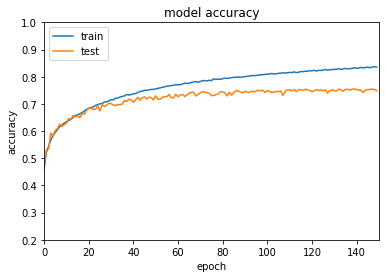

In [50]:
import matplotlib.pyplot as plt

# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.axis([0, 150, 0.2, 1])
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

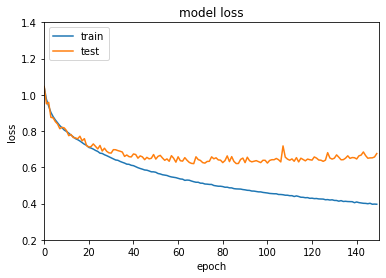

In [51]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.axis([0, 150, 0.2, 1.4])
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Optimales Modell speichern

In [52]:
# Mit mode.to_json wird nur die Architektur gespeichert.
# Besser: model.save()
## model_json = model.to_json()
## file_name_json = "model.json"
## file_name_h5 = "model.h5"
## with open(file_name_json, "w") as json_file:
    ## json_file.write(model_json)
## serialize weights to HDF5
##model.save_weights(file_name_h5)


save_model = '/home/sebastian/Schreibtisch/BDC/Language_detection/model.h5'
model.save(save_model)
print("Saved model to disk")

Saved model to disk


# Testen des Modells mit ungelabelten Daten

Einlesen der Testdaten aus dem S3 Bucket

In [ ]:
# von S3 lesen
#bucket_name = 'analyseprojectaudio'
#object_key = 'Test_Dateien/test_final_FeaturesExtracted.csv'
#s3 = boto3.client('s3')
#df_test = pd.read_csv ('s3://' + bucket_name+'/'+object_key, delimiter =';')

# von lokal lesen
df_test = pd.read_csv ('/home/sebastian/Schreibtisch/Gender_Age_Detection/test_final/test_final_FeaturesExtracted.csv', delimiter =';')

Die Input Datei für das Testen des Modells mit nicht gelabelten Daten wird analog zu den Test und Trainingsdatensätzen vorbereitet

In [ ]:
list_cn = df_test.columns.values
list_cn = np.delete(list_cn,0)
list_cn = np.delete(list_cn,0)
list_cn = np.delete(list_cn,0)
list_cn = np.delete(list_cn,0)
list_cn = np.delete(list_cn,0)
list_cn = np.delete(list_cn,0)
list_cn

In [ ]:
nrows = len(df_test)

for i in range (0,nrows):
    for j in list_cn:
        list_c = df_test[j].iloc[i]
        list_c = list_c.replace('[','')
        list_c = list_c.replace(']','')
        list1 = np.fromstring (list_c, sep=' ',dtype=float)
        df_test[j].iat[i] = list1
        df_test[j].iat[i] = df_test[j].iloc[i].mean()
    if (i % 10000 == 0):
        print ("Reihe "+ str(i) + " fertig")
print ("Konvertierung abgeschlossen.")

In [ ]:
df_test

In [ ]:
df_pred = df_test.copy()
del df_pred['Unnamed: 0']
del df_pred['index']
del df_pred['path']
del df_pred['age']
del df_pred['file_wave']
del df_pred['gender']

## Prediction der Testwerte
Die Ausgabe der Prediction gibt die vorhergesagte Klasse wieder (prediction_class)
0 = Male
1 = Female
Die Variable prediction_proba gibt die errechnete Wahrscheinlichkeit aus, dass es sich um die vorhergesagte Klasse handelt

In [ ]:
for i in range (7):
    prediction = model.predict(df_pred.iloc[[i]])
    prediction_class = model.predict_classes(df_pred.iloc[[i]])
    prediction_proba = model.predict_proba(df_pred.iloc[[i]])
    print(prediction)
    print (prediction_class)
    #print (prediction_proba)
    print ("----------")

# Der nachfolgende Code hilft bei der Überprüfung der Prediction

In [ ]:
label_encoder = LabelEncoder()
df_test['gender_enc'] = label_encoder.fit_transform(df_test['gender'])
print(df_gender_y)

In [ ]:
df_test[['gender','gender_enc']]